# Processing results using BigQuery #

We start by importing all the requisite packages from BayesCMD etc. as well as ones required to plot and read data from big query.

In [1]:
import os
import argparse
from pathlib import Path
import json
import matplotlib.pyplot as plt
from distutils import dir_util
from pprint import pprint
import pickle

# BayesCMD packages 
from bayescmd.results_handling import kde_plot
from bayescmd.results_handling import scatter_dist_plot
from bayescmd.results_handling import data_import
from bayescmd.results_handling import plot_repeated_outputs
from bayescmd.results_handling import histogram_plot
from bayescmd.results_handling import data_merge_by_batch
from bayescmd.abc import import_actual_data
from bayescmd.abc import priors_creator

# Google BigQuery
from google.cloud import bigquery
%load_ext google.cloud.bigquery

STARTING AT: /home/buck06191/repos/Github/BayesCMD/bayescmd
 Looking for: BayesCMD
STARTING AT: /home/buck06191/repos/Github/BayesCMD/bayescmd
 Looking for: BayesCMD
STARTING AT: /home/buck06191/repos/Github/BayesCMD/bayescmd
 Looking for: BayesCMD


In [2]:
# Explicitly use service account credentials by specifying the private
# key file. All clients in google-cloud-python have this helper.
client = bigquery.Client.from_service_account_json(
    "../../gcloud/hypothermia-auth.json"
)

In [3]:
def generate_histogram_query(project, dataset, model, n_bins, distance):
    histogram_query = """
    SELECT
      MIN(data.{distance}) AS min,
      MAX(data.{distance}) AS max,
      COUNT(data.{distance}) AS num,
      INTEGER((data.{distance}-value.min)/(value.max-value.min)*{n_bins}) AS group_
    FROM
      [{project}:{dataset}.{model}] data
    CROSS JOIN (
      SELECT
        MAX({distance}) AS max,
        MIN({distance}) AS min
      FROM
        [{project}:{dataset}.{model}]) value
    GROUP BY
      group_
    ORDER BY
      group_
    """.format(dataset=dataset, model=model, n_bins=n_bins, distance=distance, project=project)
    return histogram_query

In [40]:
def generate_posterior_query(project, dataset, model, distance, parameters, limit=50000):
    unpacked_params = ",\n".join(parameters)
    histogram_query = """
SELECT
    {unpacked_params},
    {distance},
    idx
FROM
  `{project}.{dataset}.{model}`
ORDER BY
  NRMSE ASC
LIMIT
  {limit}
    """.format(project=project, dataset=dataset, model=model, unpacked_params=unpacked_params,distance=distance, limit=limit)
    return histogram_query

In [41]:
def load_configuration(model_version, dataset, verbose=False):
    current_file = Path(os.path.abspath(''))
    config_file = os.path.join(current_file.parents[2],
                              'config_files',
                               'abc',
                               'bp_hypothermia_{}'.format(model_version),
                               'bp_hypothermia_{}_config.json'.format(model_version)
                              )

    with open(config_file, 'r') as conf_f:
        conf = json.load(conf_f)

    params = conf['priors']

    input_path = os.path.join(current_file.parents[2],
                              'data',
                              'clean_hypothermia',
                              '{}_filtered_formatted.csv'.format(dataset.upper()))

    d0 = import_actual_data(input_path)

    targets = conf['targets']
    model_name = conf['model_name']
    inputs = conf['inputs']

    config = {
        "model_name": model_name,
        "targets": targets,
        "inputs": inputs,
        "parameters": params,
        "input_path": input_path,
        "zero_flag": conf['zero_flag'],
    }
    
    if verbose:
        pprint(config)
        
    return config, d0

In [42]:
configuration = {}
for model_number in [1, 2, 4]:
    model_name = 'bph{}'.format(model_number)
    configuration[model_name] = {}
    for DATASET in ['LWP475', 'LWP479' ,'LWP481' ,'LWP484']:
        configuration[model_name][DATASET] = {}
        config, d0 = load_configuration(model_number, DATASET)
        configuration[model_name][DATASET]['bayescmd_config'] = config
        configuration[model_name][DATASET]['original_data']= d0
        
        configuration[model_name][DATASET]['histogram_query'] = generate_histogram_query('hypothermia-bayescmd', 
                                                                                            DATASET, 
                                                                                            model_name, 
                                                                                            100, 
                                                                                            'NRMSE')
        
        configuration[model_name][DATASET]['posterior_query'] = generate_posterior_query('hypothermia-bayescmd', 
                                                                                            DATASET, 
                                                                                            model_name, 
                                                                                            'NRMSE', 
                                                                                            list(configuration[model_name][DATASET]['bayescmd_config']['parameters'].keys()))


In [43]:
bph1lwp481_post = client.query(configuration['bph1']['LWP481']['posterior_query']).to_dataframe()


In [46]:
bph1lwp481_post.iloc[1360]

CBFn         0.006606
K_sigma      8.145102
phi          0.034815
n_h          2.272349
k_aut        0.835638
R_auto       6.651713
Xtot_n       3.899427
Q_10         5.340113
NADpool      4.153199
O2_n         0.023995
r_n          0.020783
r_0          0.011645
r_t          0.016204
NRMSE        0.598594
idx        918.000000
Name: 1360, dtype: float64

In [8]:
#df2_hist = client.query(sql2_hist, job_config=bigquery.QueryJobConfig(use_legacy_sql=True)).to_dataframe()
# df2_post = client.query(sql2_post).to_dataframe()

In [9]:
#df3_hist = client.query(sql3_hist, job_config=bigquery.QueryJobConfig(use_legacy_sql=True)).to_dataframe()
# df3_post = client.query(sql3_post).to_dataframe()

Working on bph1 - LWP475
Sample 0, idx:2363
{'CBFn': 0.007058581378689879,
 'K_sigma': 10.008432559816779,
 'NADpool': 4.4542204250869695,
 'O2_n': 0.019634150039403633,
 'Q_10': 5.796327857581718,
 'R_auto': 1.3359698963592503,
 'Xtot_n': 5.097507109451369,
 'k_aut': 0.8804236259306427,
 'n_h': 2.208479251709072,
 'phi': 0.03859689140995669,
 'r_0': 0.013060043550651929,
 'r_n': 0.018492890497956282,
 'r_t': 0.015965128004366017}
Sample 1, idx:3336
{'CBFn': 0.007414099819078375,
 'K_sigma': 11.111844509562637,
 'NADpool': 3.5965380356098966,
 'O2_n': 0.019944831861318527,
 'Q_10': 5.651112840551964,
 'R_auto': 0.9771517289956412,
 'Xtot_n': 5.4882638981166725,
 'k_aut': 0.9760942506350092,
 'n_h': 2.971693014018437,
 'phi': 0.04133688997218915,
 'r_0': 0.010330649711314942,
 'r_n': 0.014993510007121463,
 'r_t': 0.014906811945647469}
Sample 2, idx:393
{'CBFn': 0.006955393826299467,
 'K_sigma': 9.620942201756131,
 'NADpool': 4.152705492264692,
 'O2_n': 0.023564724265505453,
 'Q_10': 5.7

Sample 20, idx:3910
{'CBFn': 0.007030959639054515,
 'K_sigma': 10.316880994718217,
 'NADpool': 4.4360251381581435,
 'O2_n': 0.024211109027331087,
 'Q_10': 5.625530644244959,
 'R_auto': 0.18999409329882866,
 'Xtot_n': 6.950496250341933,
 'k_aut': 0.8989047375724191,
 'n_h': 2.4632499387129223,
 'phi': 0.03849495198655293,
 'r_0': 0.013867190258868373,
 'r_n': 0.02058737511463989,
 'r_t': 0.014896001912029113}
Sample 21, idx:1115
{'CBFn': 0.00697207893374347,
 'K_sigma': 10.591794657142689,
 'NADpool': 3.7784400401296834,
 'O2_n': 0.02424767605126,
 'Q_10': 5.443549776467787,
 'R_auto': 0.30974421701129184,
 'Xtot_n': 4.966595947913136,
 'k_aut': 0.7307599542799552,
 'n_h': 2.186444379117616,
 'phi': 0.04101991530900003,
 'r_0': 0.013823806107234807,
 'r_n': 0.01829658220439001,
 'r_t': 0.016032296822877934}
Sample 22, idx:3002
{'CBFn': 0.007840353570795438,
 'K_sigma': 10.052800989450397,
 'NADpool': 2.8257453818573435,
 'O2_n': 0.025545857393661248,
 'Q_10': 5.697275536766318,
 'R_auto

Sample 40, idx:3836
{'CBFn': 0.0075649645745852,
 'K_sigma': 11.304203440036941,
 'NADpool': 3.2627190196087965,
 'O2_n': 0.0226317447642654,
 'Q_10': 5.791901491278034,
 'R_auto': 0.052530794047548346,
 'Xtot_n': 6.237707920444282,
 'k_aut': 0.8799250588803925,
 'n_h': 2.5815960159964684,
 'phi': 0.030891799340536263,
 'r_0': 0.01239055894583954,
 'r_n': 0.016691785078122516,
 'r_t': 0.017112985839599755}
Sample 41, idx:815
{'CBFn': 0.008673222615615737,
 'K_sigma': 9.35559831072798,
 'NADpool': 3.47735645917179,
 'O2_n': 0.0196400222216318,
 'Q_10': 5.910702657300416,
 'R_auto': 0.05565821475994937,
 'Xtot_n': 4.985679222540002,
 'k_aut': 0.6180391592756893,
 'n_h': 2.9576812559046965,
 'phi': 0.04122620368616752,
 'r_0': 0.013648131611962405,
 'r_n': 0.015984912277357058,
 'r_t': 0.01480135343955509}
Sample 42, idx:4837
{'CBFn': 0.006681132856622857,
 'K_sigma': 10.536669225147037,
 'NADpool': 2.9091591475933964,
 'O2_n': 0.020890550131096714,
 'Q_10': 5.603861210118831,
 'R_auto': 

Sample 61, idx:3185
{'CBFn': 0.007444156232010042,
 'K_sigma': 8.328993377906682,
 'NADpool': 2.7829660287551707,
 'O2_n': 0.02363496926163847,
 'Q_10': 5.988220946533012,
 'R_auto': 0.8834416857439409,
 'Xtot_n': 4.063531591374334,
 'k_aut': 0.6812731858589998,
 'n_h': 2.318132978365884,
 'phi': 0.03694133064503453,
 'r_0': 0.013712185302191308,
 'r_n': 0.01583313680741302,
 'r_t': 0.01455971003985296}
Sample 62, idx:1121
{'CBFn': 0.006760895976790974,
 'K_sigma': 11.964495978755338,
 'NADpool': 4.126501657188101,
 'O2_n': 0.020000591806662363,
 'Q_10': 5.4437013541180095,
 'R_auto': 0.3384587037071529,
 'Xtot_n': 7.7862928027405705,
 'k_aut': 0.8202288733669278,
 'n_h': 2.65090504172637,
 'phi': 0.03800568759911352,
 'r_0': 0.014150922924405215,
 'r_n': 0.01875675920916409,
 'r_t': 0.01738620576282469}
Sample 63, idx:3914
{'CBFn': 0.0064717956482411325,
 'K_sigma': 8.1970637671038,
 'NADpool': 3.735545777018901,
 'O2_n': 0.02399775622932187,
 'Q_10': 5.741147112243497,
 'R_auto': 1.7

Sample 82, idx:4914
{'CBFn': 0.006539237400961074,
 'K_sigma': 8.935551550152233,
 'NADpool': 2.7098188110380788,
 'O2_n': 0.02557336146917303,
 'Q_10': 5.843530748985522,
 'R_auto': 2.2972691890861614,
 'Xtot_n': 5.829097977612894,
 'k_aut': 0.9262307337257558,
 'n_h': 2.6905557537255214,
 'phi': 0.036874960410376925,
 'r_0': 0.011024864247926782,
 'r_n': 0.01603970256994806,
 'r_t': 0.016758947295780348}
Sample 83, idx:3171
{'CBFn': 0.006987185386613509,
 'K_sigma': 10.09653593125625,
 'NADpool': 3.841004429033791,
 'O2_n': 0.021120178391876625,
 'Q_10': 5.342061056548968,
 'R_auto': 0.10006295207787176,
 'Xtot_n': 5.918888800046463,
 'k_aut': 0.7513932844012176,
 'n_h': 2.098488070347206,
 'phi': 0.04221762149380186,
 'r_0': 0.014233202963963087,
 'r_n': 0.02057110864456271,
 'r_t': 0.016506780892191625}
Sample 84, idx:2977
{'CBFn': 0.006722679622069021,
 'K_sigma': 9.015441098413062,
 'NADpool': 3.776740014253437,
 'O2_n': 0.019980481896029696,
 'Q_10': 4.993040231047708,
 'R_auto'

Sample 2, idx:4784
{'CBFn': 0.009503240551179177,
 'K_sigma': 9.862894755137942,
 'NADpool': 3.0783328540191235,
 'O2_n': 0.027004101361705047,
 'Q_10': 1.0780808126819137,
 'R_auto': 9.988070483372589,
 'Xtot_n': 4.354515754332093,
 'k_aut': 0.6761165804853266,
 'n_h': 2.0548862121139675,
 'phi': 0.04004627473066007,
 'r_0': 0.01334878824677404,
 'r_n': 0.017573085552718123,
 'r_t': 0.018363628098498463}
Sample 3, idx:215
{'CBFn': 0.007764758114201395,
 'K_sigma': 10.055017699073492,
 'NADpool': 3.5556289343447998,
 'O2_n': 0.02680163594578859,
 'Q_10': 1.0900874558166975,
 'R_auto': 9.167334010908249,
 'Xtot_n': 6.9885921541804885,
 'k_aut': 0.5296111265504048,
 'n_h': 2.3103799971674563,
 'phi': 0.03343175804464054,
 'r_0': 0.015048946308061568,
 'r_n': 0.01940593998824178,
 'r_t': 0.014846285228806185}
Sample 4, idx:1190
{'CBFn': 0.0077320803598644435,
 'K_sigma': 8.556711735711565,
 'NADpool': 3.4612355694471066,
 'O2_n': 0.021920576355600324,
 'Q_10': 1.0062020854828382,
 'R_auto

Sample 23, idx:465
{'CBFn': 0.008150227454839206,
 'K_sigma': 8.027892801002228,
 'NADpool': 3.0887956323594223,
 'O2_n': 0.021057530419764936,
 'Q_10': 1.091216773695565,
 'R_auto': 8.894689891687161,
 'Xtot_n': 7.279962294032634,
 'k_aut': 0.7481557864340693,
 'n_h': 2.4133934322186748,
 'phi': 0.02921655694616618,
 'r_0': 0.013316465557595084,
 'r_n': 0.0213398658214628,
 'r_t': 0.01774541148902096}
Sample 24, idx:339
{'CBFn': 0.006822092374620094,
 'K_sigma': 8.783545465081867,
 'NADpool': 3.3914467269393462,
 'O2_n': 0.02016904353793107,
 'Q_10': 1.0156569696996722,
 'R_auto': 8.933510419551663,
 'Xtot_n': 6.047711696456008,
 'k_aut': 0.6996164319878284,
 'n_h': 2.0008474956807234,
 'phi': 0.031234563953789405,
 'r_0': 0.013484413319008228,
 'r_n': 0.019623291625286,
 'r_t': 0.018862924920923563}
Sample 25, idx:1990
{'CBFn': 0.006677134305180696,
 'K_sigma': 10.446085680984911,
 'NADpool': 2.9058893605835774,
 'O2_n': 0.022826824896306615,
 'Q_10': 1.1061494569346866,
 'R_auto': 8

Sample 44, idx:2845
{'CBFn': 0.008066277843592493,
 'K_sigma': 8.117571175067035,
 'NADpool': 3.5446095878950987,
 'O2_n': 0.02702767612811427,
 'Q_10': 1.0872245621925098,
 'R_auto': 6.929567052861433,
 'Xtot_n': 7.381217497452928,
 'k_aut': 0.5688562959213813,
 'n_h': 2.706684712893733,
 'phi': 0.0328871909403011,
 'r_0': 0.013508355733961828,
 'r_n': 0.018532055326136845,
 'r_t': 0.0152404893994549}
Sample 45, idx:3439
{'CBFn': 0.009163083828620407,
 'K_sigma': 9.66492929851543,
 'NADpool': 3.5590178079958417,
 'O2_n': 0.026906133756101763,
 'Q_10': 1.0262696324482836,
 'R_auto': 6.538072893409574,
 'Xtot_n': 6.344305512496524,
 'k_aut': 0.5494871642468713,
 'n_h': 2.8592790711121965,
 'phi': 0.0414255615375337,
 'r_0': 0.014906636671093338,
 'r_n': 0.0149673722490483,
 'r_t': 0.015370962444451897}
Sample 46, idx:4628
{'CBFn': 0.0072062108033659625,
 'K_sigma': 11.466454418845409,
 'NADpool': 3.8736480914302214,
 'O2_n': 0.022105203272030208,
 'Q_10': 1.0210552983900296,
 'R_auto': 

Sample 65, idx:534
{'CBFn': 0.0078044889059028216,
 'K_sigma': 10.37199243155053,
 'NADpool': 2.7518605354630434,
 'O2_n': 0.02634858867855832,
 'Q_10': 1.0430367166197771,
 'R_auto': 8.377067368994894,
 'Xtot_n': 6.111877790645515,
 'k_aut': 0.8216121929680924,
 'n_h': 2.027680619580955,
 'phi': 0.030257359369314608,
 'r_0': 0.013123387894796845,
 'r_n': 0.016867493822434427,
 'r_t': 0.0191856807027864}
Sample 66, idx:4965
{'CBFn': 0.009239347573894028,
 'K_sigma': 8.685812860286529,
 'NADpool': 3.1722793230003044,
 'O2_n': 0.02232859479525842,
 'Q_10': 1.0221004507904126,
 'R_auto': 8.395981903411746,
 'Xtot_n': 4.265675692267149,
 'k_aut': 0.911608099856566,
 'n_h': 2.086670794053417,
 'phi': 0.04004253502449685,
 'r_0': 0.014422534858208184,
 'r_n': 0.01866701401243576,
 'r_t': 0.020126996666254157}
Sample 67, idx:3
{'CBFn': 0.0070223767654569134,
 'K_sigma': 8.1215074178594,
 'NADpool': 3.9482681575545446,
 'O2_n': 0.027773568465235172,
 'Q_10': 1.0307374989540976,
 'R_auto': 9.78

Sample 86, idx:2973
{'CBFn': 0.009275104878561313,
 'K_sigma': 8.115325401877454,
 'NADpool': 3.21827260133562,
 'O2_n': 0.021771185802048197,
 'Q_10': 1.0727696956969988,
 'R_auto': 9.148016370781436,
 'Xtot_n': 5.1439743183263085,
 'k_aut': 0.4932721178663722,
 'n_h': 2.6183945780563223,
 'phi': 0.042746504740590635,
 'r_0': 0.014673865334255354,
 'r_n': 0.016171614977596987,
 'r_t': 0.01486918642670949}
Sample 87, idx:2333
{'CBFn': 0.00784613732571623,
 'K_sigma': 11.198485961578069,
 'NADpool': 3.108051079596585,
 'O2_n': 0.02192415938898257,
 'Q_10': 1.0489920187912158,
 'R_auto': 7.77212347947017,
 'Xtot_n': 5.2037061488032785,
 'k_aut': 0.5209801345302022,
 'n_h': 2.0285085349204817,
 'phi': 0.04001628835721751,
 'r_0': 0.014174368959761619,
 'r_n': 0.018149588917646432,
 'r_t': 0.015684928600406982}
Sample 88, idx:3450
{'CBFn': 0.009195641688957472,
 'K_sigma': 8.775992257234646,
 'NADpool': 3.751181565551216,
 'O2_n': 0.01940931538997497,
 'Q_10': 1.1521092112499174,
 'R_auto'

Sample 6, idx:865
{'CBFn': 0.006790385421753789,
 'K_sigma': 8.729908285162669,
 'NADpool': 2.8449087275291536,
 'O2_n': 0.026416478658103367,
 'Q_10': 3.653806175421455,
 'R_auto': 6.027620570541966,
 'Xtot_n': 3.692006525989669,
 'k_aut': 0.8199103878486357,
 'n_h': 2.7983836557377324,
 'phi': 0.028992225132301406,
 'r_0': 0.011084972178823151,
 'r_n': 0.017016520003849955,
 'r_t': 0.01823634116260616}
Sample 7, idx:4472
{'CBFn': 0.007136800107432503,
 'K_sigma': 9.768030729180381,
 'NADpool': 3.5620285735961232,
 'O2_n': 0.019819942262454558,
 'Q_10': 4.783654458044578,
 'R_auto': 2.3118666478451844,
 'Xtot_n': 3.79795624903678,
 'k_aut': 0.5983036947396563,
 'n_h': 2.745505685828252,
 'phi': 0.03590809377513758,
 'r_0': 0.01431078571083643,
 'r_n': 0.015515368587925625,
 'r_t': 0.021001166550246995}
Sample 8, idx:3269
{'CBFn': 0.006967246810263547,
 'K_sigma': 8.302200591163809,
 'NADpool': 3.057122696791567,
 'O2_n': 0.022407170274145814,
 'Q_10': 3.1482257578269417,
 'R_auto': 8.

Sample 27, idx:4687
{'CBFn': 0.0069345494151145035,
 'K_sigma': 9.061422462827217,
 'NADpool': 3.6558713791768302,
 'O2_n': 0.028495085120442742,
 'Q_10': 3.6300538124001447,
 'R_auto': 2.020492960492942,
 'Xtot_n': 3.890937380432873,
 'k_aut': 0.6553357830413268,
 'n_h': 2.7712043854749067,
 'phi': 0.029892875256327025,
 'r_0': 0.013332321423785905,
 'r_n': 0.016643646175036858,
 'r_t': 0.018055387202154532}
Sample 28, idx:2279
{'CBFn': 0.007032670847596024,
 'K_sigma': 11.268704205331936,
 'NADpool': 2.791978729266174,
 'O2_n': 0.02112908017164973,
 'Q_10': 3.9681957644656234,
 'R_auto': 6.041159008827911,
 'Xtot_n': 3.6172428995000314,
 'k_aut': 0.6143271800429714,
 'n_h': 2.93900355126881,
 'phi': 0.034371916684806235,
 'r_0': 0.012637309719026888,
 'r_n': 0.01851054101702848,
 'r_t': 0.01583546453951681}
Sample 29, idx:617
{'CBFn': 0.007165985415624014,
 'K_sigma': 10.143055055007157,
 'NADpool': 4.411052915537086,
 'O2_n': 0.01969955324903186,
 'Q_10': 4.184896572027954,
 'R_auto

Sample 48, idx:3178
{'CBFn': 0.006558900848501342,
 'K_sigma': 9.056391810310274,
 'NADpool': 2.7474524046818454,
 'O2_n': 0.019759217074625454,
 'Q_10': 3.465401297765176,
 'R_auto': 3.939538494681389,
 'Xtot_n': 4.033595095541658,
 'k_aut': 0.7625810659874159,
 'n_h': 2.9469554387640464,
 'phi': 0.036165525906727315,
 'r_0': 0.011177775417988114,
 'r_n': 0.018266579435277985,
 'r_t': 0.01933497413458345}
Sample 49, idx:1072
{'CBFn': 0.006924285958268909,
 'K_sigma': 8.236406871747025,
 'NADpool': 3.1314075043698377,
 'O2_n': 0.02764952630205712,
 'Q_10': 4.0908317963577865,
 'R_auto': 4.495897400046843,
 'Xtot_n': 3.6433185386606497,
 'k_aut': 0.5996593788701344,
 'n_h': 2.769923407106398,
 'phi': 0.028884413276694006,
 'r_0': 0.015112453217059481,
 'r_n': 0.017594034182001794,
 'r_t': 0.017389449239290228}
Sample 50, idx:1839
{'CBFn': 0.007025449141091801,
 'K_sigma': 9.487668190429492,
 'NADpool': 3.874990325074076,
 'O2_n': 0.026740001553024497,
 'Q_10': 5.670658261854589,
 'R_aut

Sample 69, idx:4306
{'CBFn': 0.006757920270394107,
 'K_sigma': 10.481439699651109,
 'NADpool': 4.394039002323417,
 'O2_n': 0.028740466281292936,
 'Q_10': 5.586886125419944,
 'R_auto': 0.8256445435162529,
 'Xtot_n': 3.7006369815364213,
 'k_aut': 0.9903045305626208,
 'n_h': 2.974500182378168,
 'phi': 0.03803343033896178,
 'r_0': 0.01279906846111193,
 'r_n': 0.01827055253573593,
 'r_t': 0.01747707527326952}
Sample 70, idx:4263
{'CBFn': 0.00644243593195182,
 'K_sigma': 8.838253100888823,
 'NADpool': 3.039582094420748,
 'O2_n': 0.02154035823170814,
 'Q_10': 4.58247764184048,
 'R_auto': 2.128324612317618,
 'Xtot_n': 3.8802971760108433,
 'k_aut': 0.5815262956813368,
 'n_h': 2.5147908693235643,
 'phi': 0.038498473379066575,
 'r_0': 0.012574782704003171,
 'r_n': 0.019165486128341052,
 'r_t': 0.015577282357766231}
Sample 71, idx:77
{'CBFn': 0.006402873610074095,
 'K_sigma': 8.736107085221446,
 'NADpool': 3.2497380663236908,
 'O2_n': 0.027879060790097013,
 'Q_10': 4.974415544023456,
 'R_auto': 3.

                     18.95087776805112,
                     18.94538792894015,
                     18.938941208502143,
                     18.93236010612525,
                     18.925996139679974,
                     18.91866127714295,
                     18.911283592782222,
                     18.904195201803727,
                     18.89600976389143,
                     18.887744356013386,
                     18.87974008042449,
                     18.870409464654717,
                     18.8609005569721,
                     18.851609669490138,
                     18.84070062412168,
                     18.829539494867657,
                     18.81861996628157,
                     18.80579401376956,
                     18.792737983188054,
                     18.78007168103808,
                     18.76527750151803,
                     18.750413722972493,
                     18.736225007178547,
                     18.71979926492513,
                     18.703595

                     41.315999429892535,
                     41.298329651150134,
                     41.28205327227938,
                     41.267193666643834,
                     41.25383450977796,
                     41.24211151657271,
                     41.23220207424318,
                     41.224313137725424,
                     41.218667814733344,
                     41.215491113736135,
                     41.21499535822613,
                     41.21736578357471,
                     41.22274682756985,
                     41.231229602010586,
                     41.242840990720616,
                     41.25753476068912,
                     41.275185001544536,
                     41.295582128704424,
                     41.31843159996007,
                     41.3433554045181,
                     41.36989628871603,
                     41.3975245877329,
                     41.42564744464675,
                     41.45362012542685,
                     41.48075908

                      38.28300407823184,
                      38.28335044634607,
                      38.28374253993758,
                      38.28418330070568,
                      38.284674696036944,
                      38.28521770008751,
                      38.285812293639545,
                      38.28645748235073,
                      38.287151332677354,
                      38.28789102440755,
                      38.288672918401474,
                      38.28949263781661,
                      38.290345160813786,
                      38.291224922509876,
                      38.292125923779196,
                      38.293041844417566,
                      38.29396615817504,
                      38.29489224723398,
                      38.29581351385075,
                      38.296723487077465,
                      38.297615922721505,
                      38.2984848949681,
                      38.29932487837097,
                      38.300130819197214,
      

AttributeError: 'float' object has no attribute 'items'

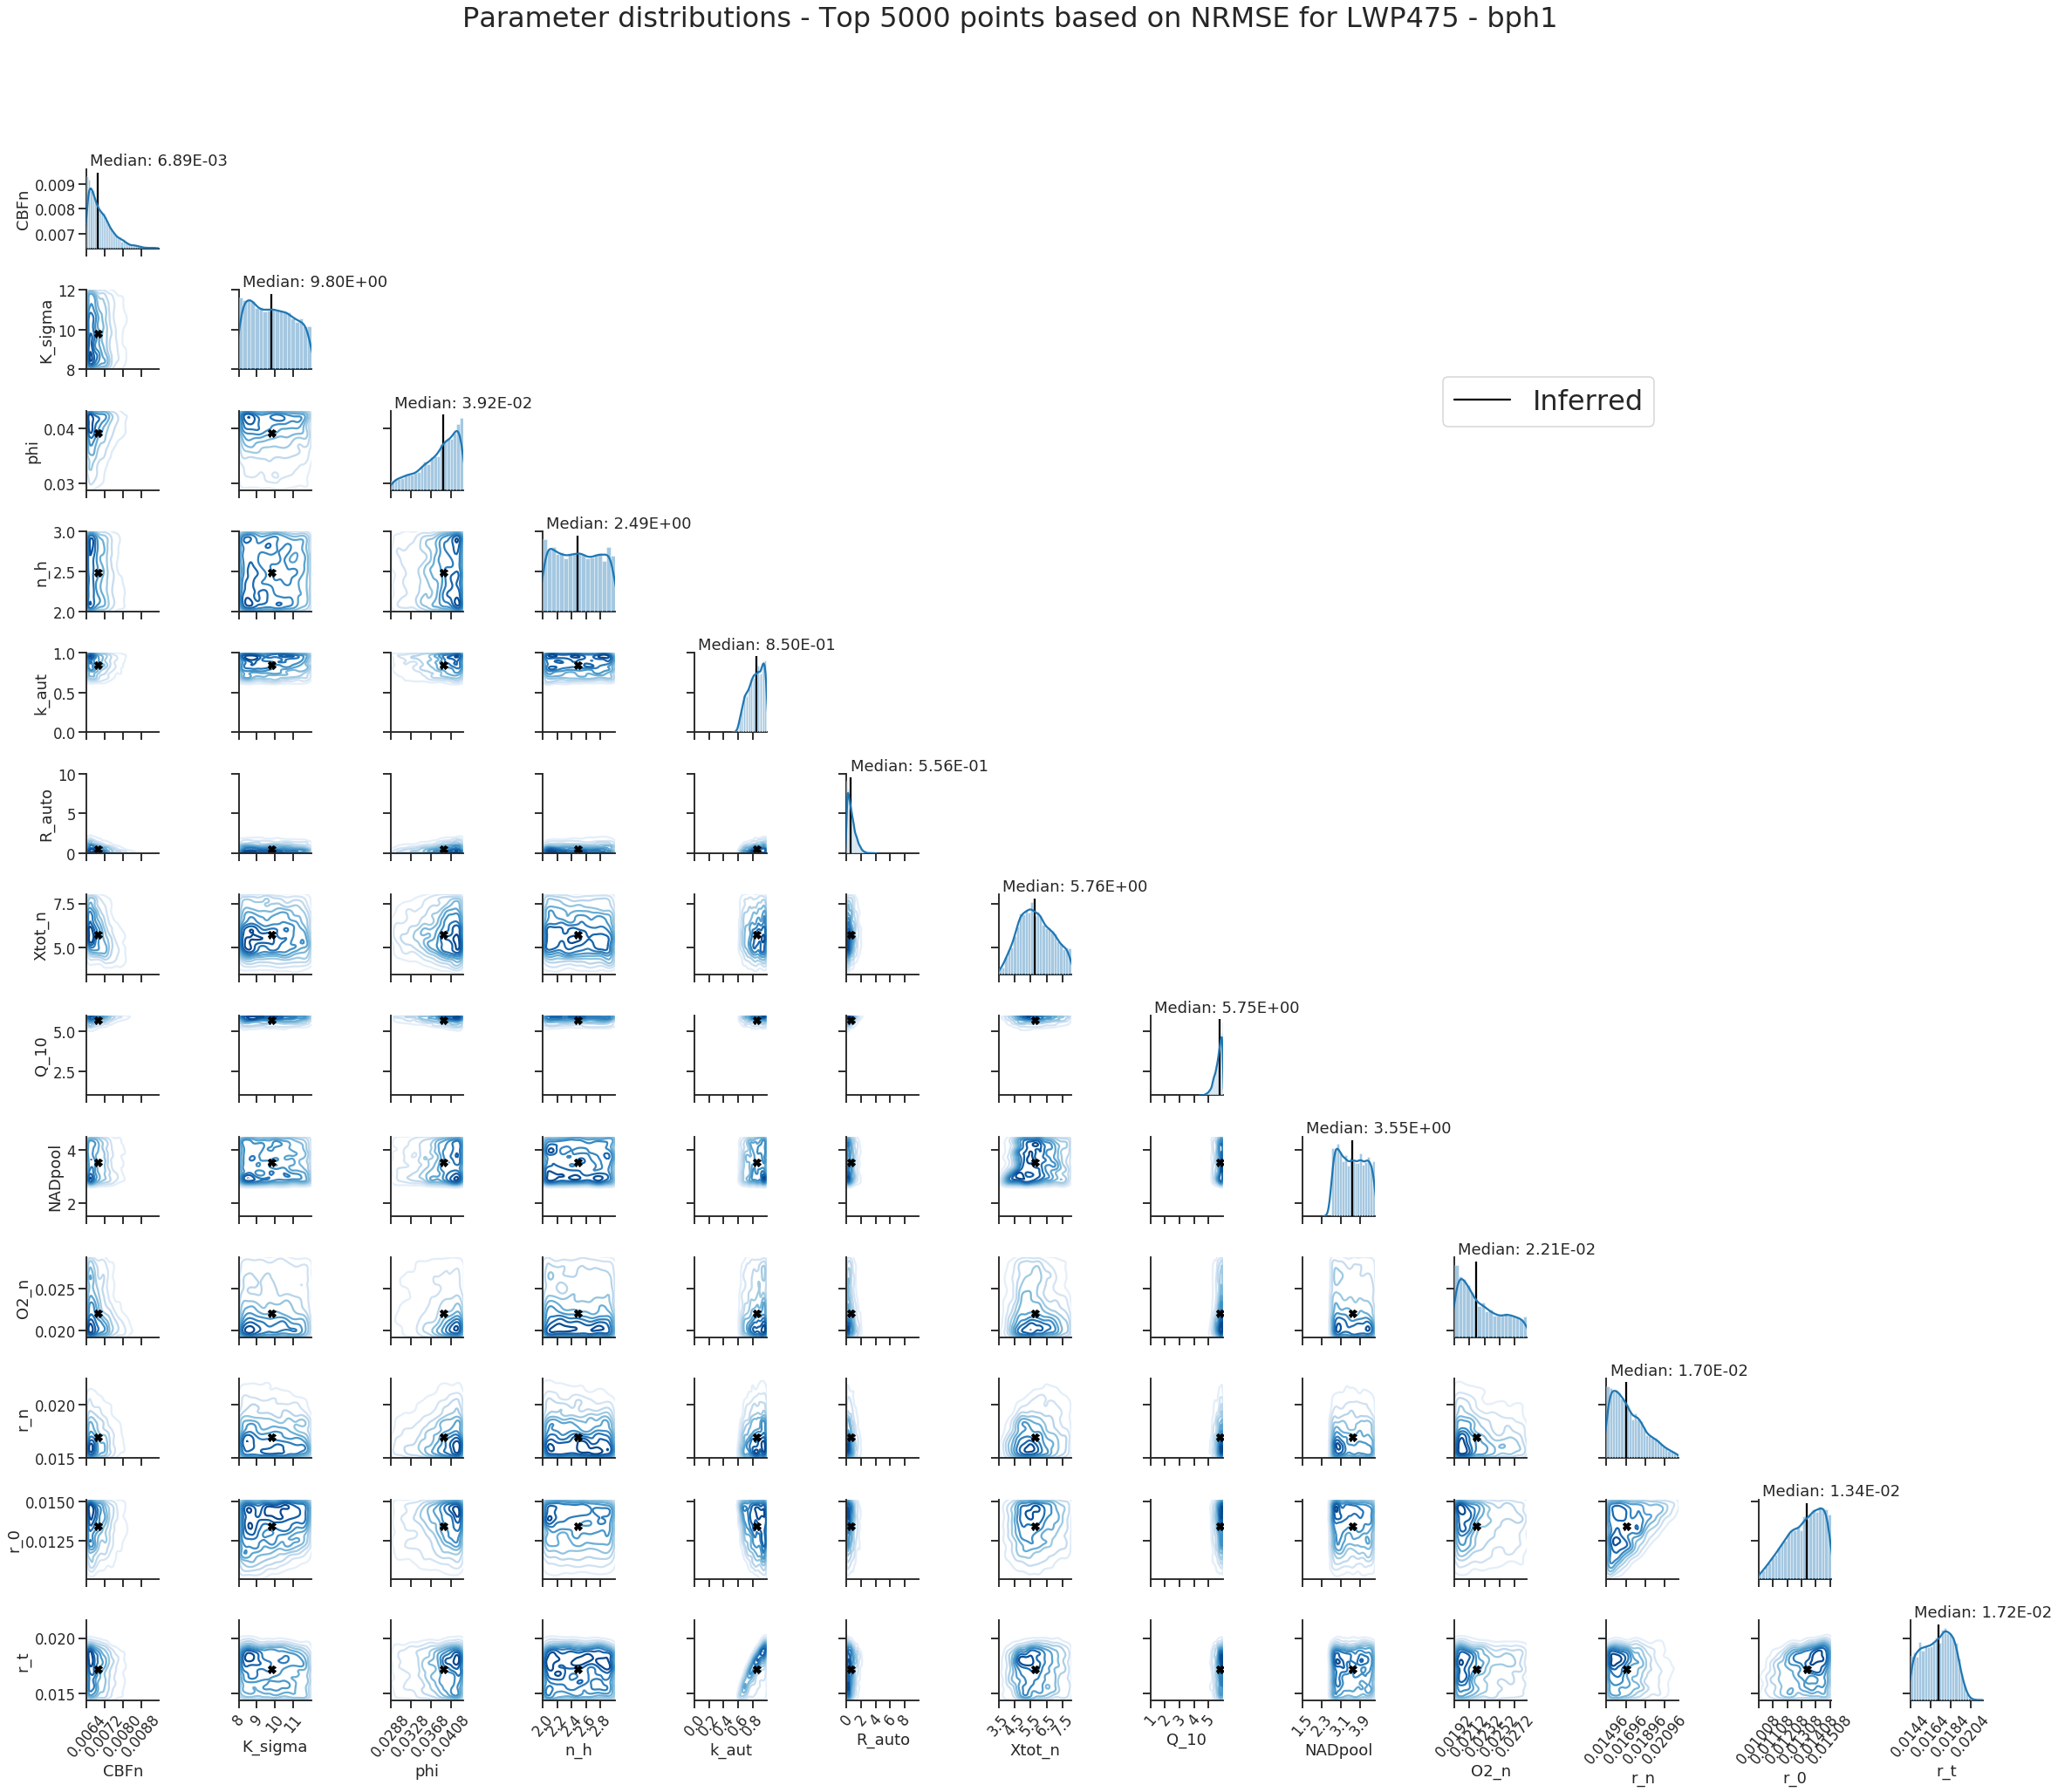

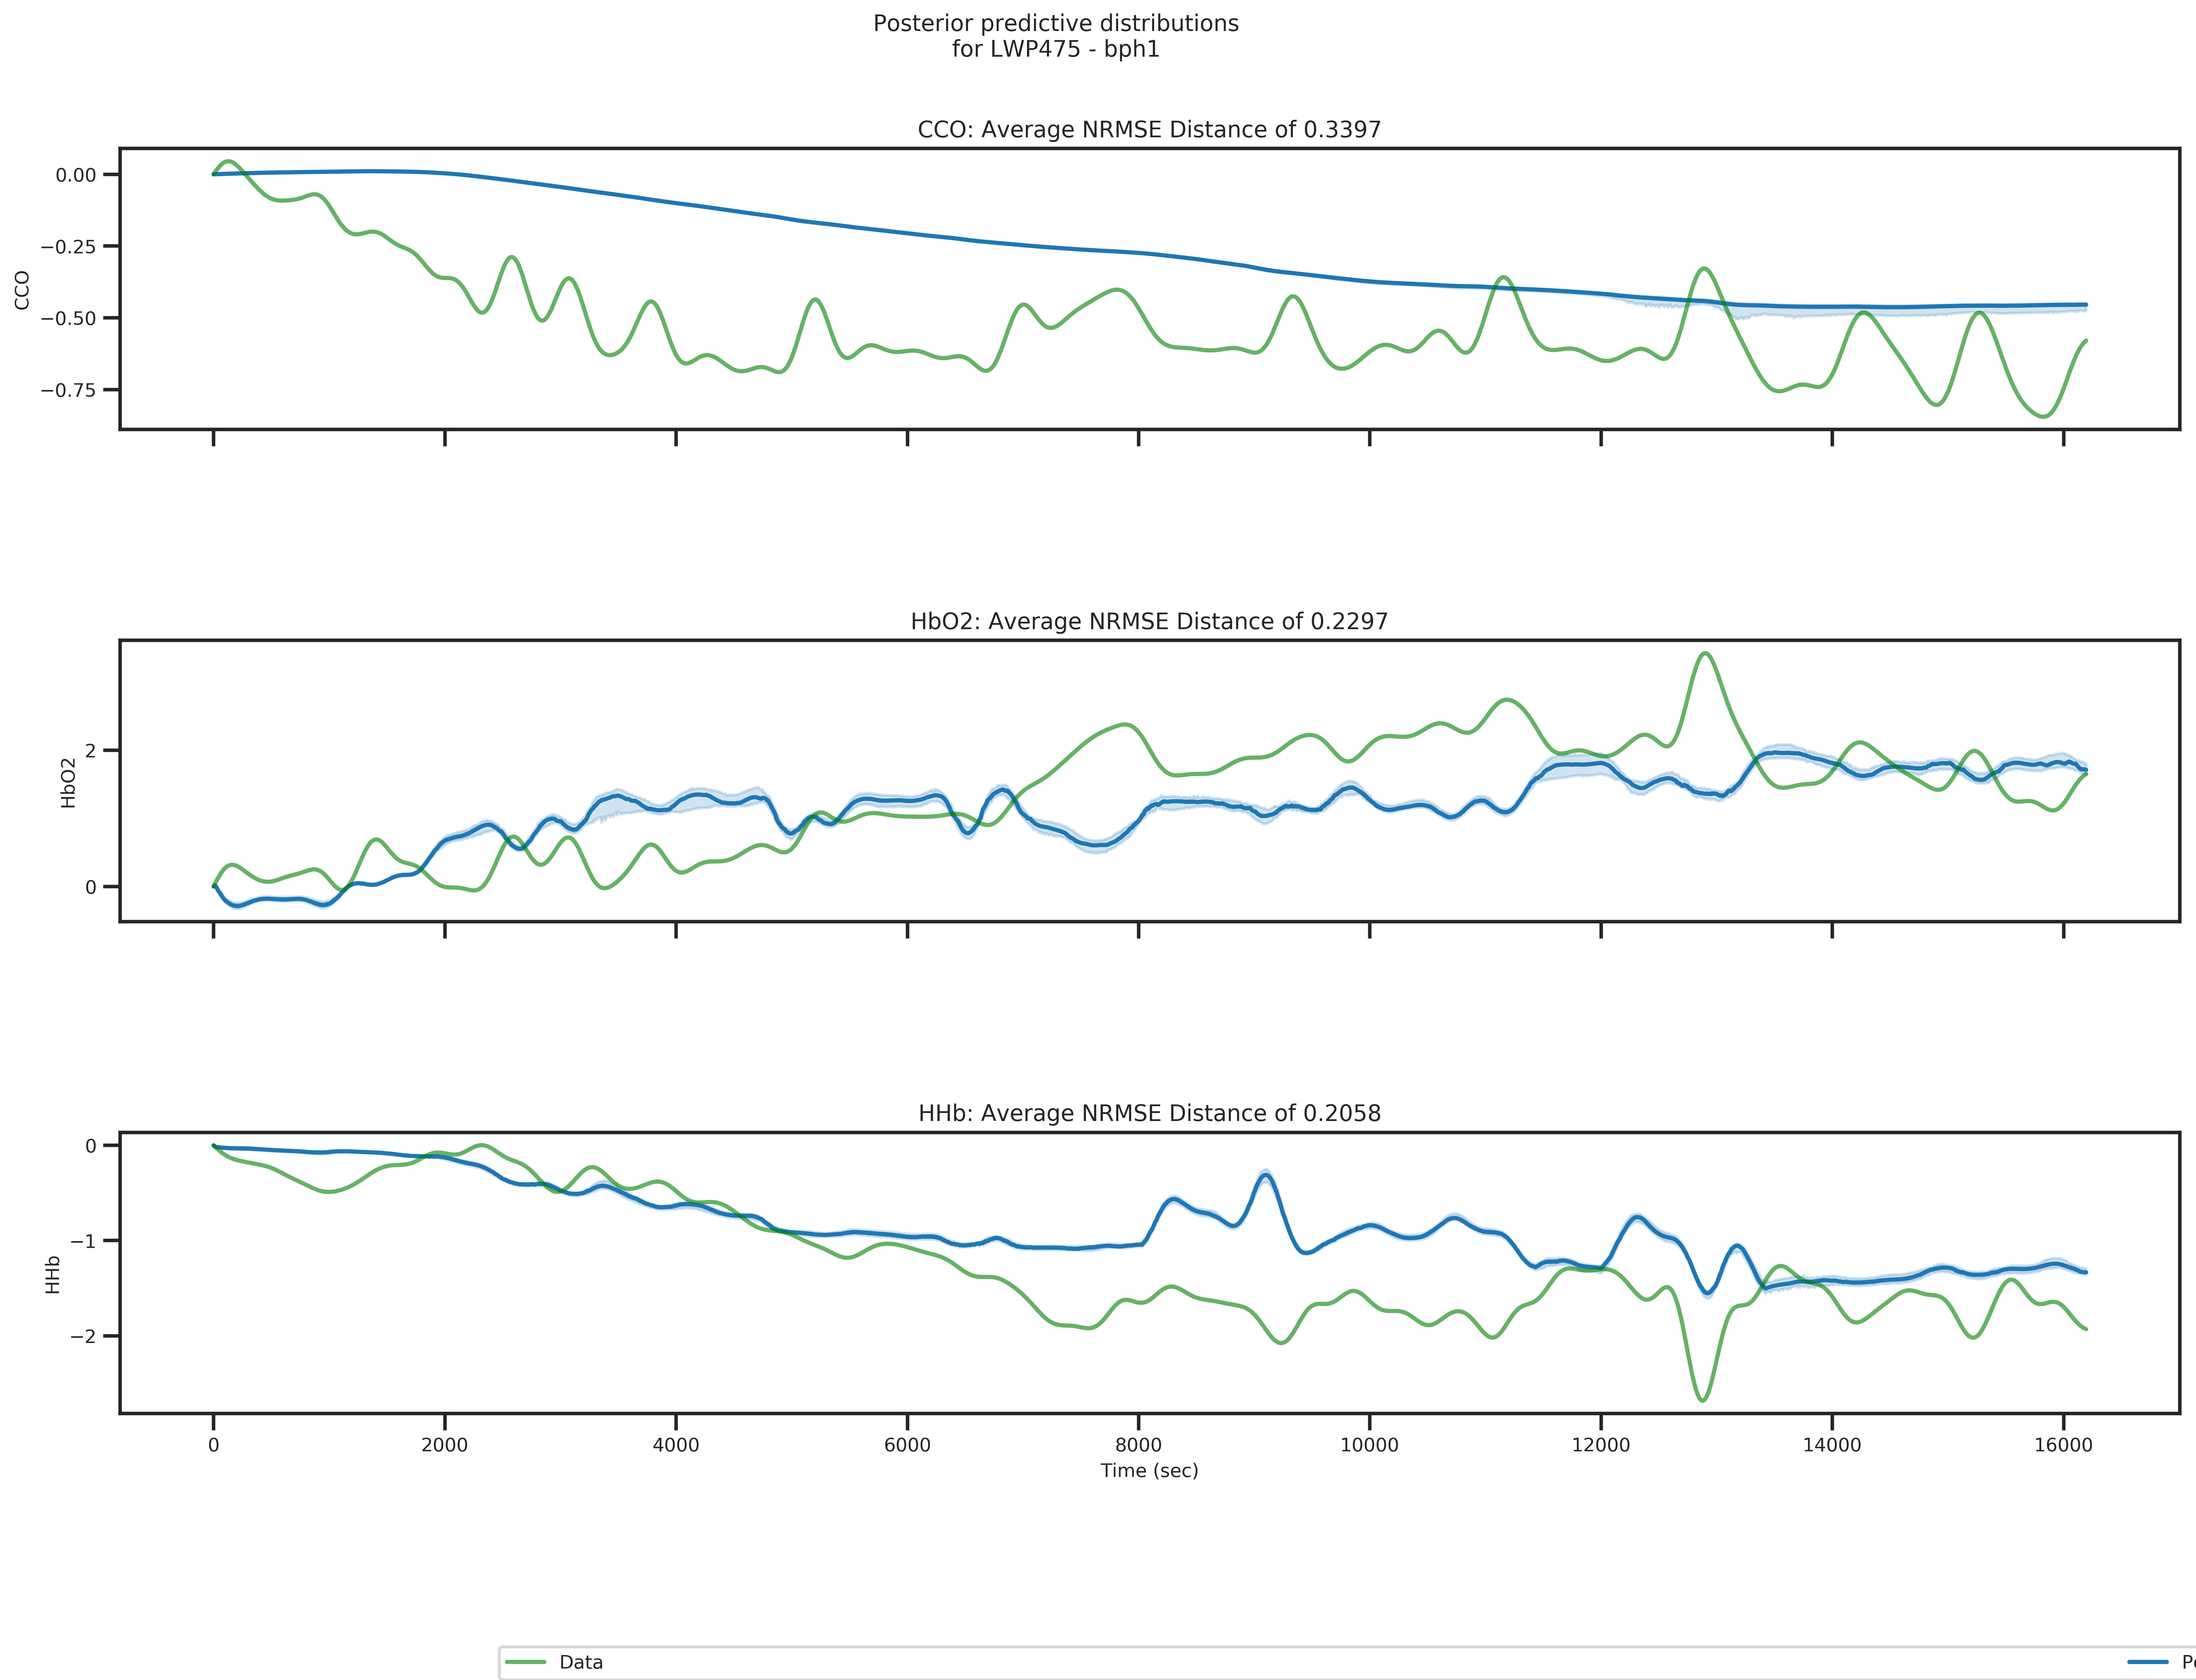

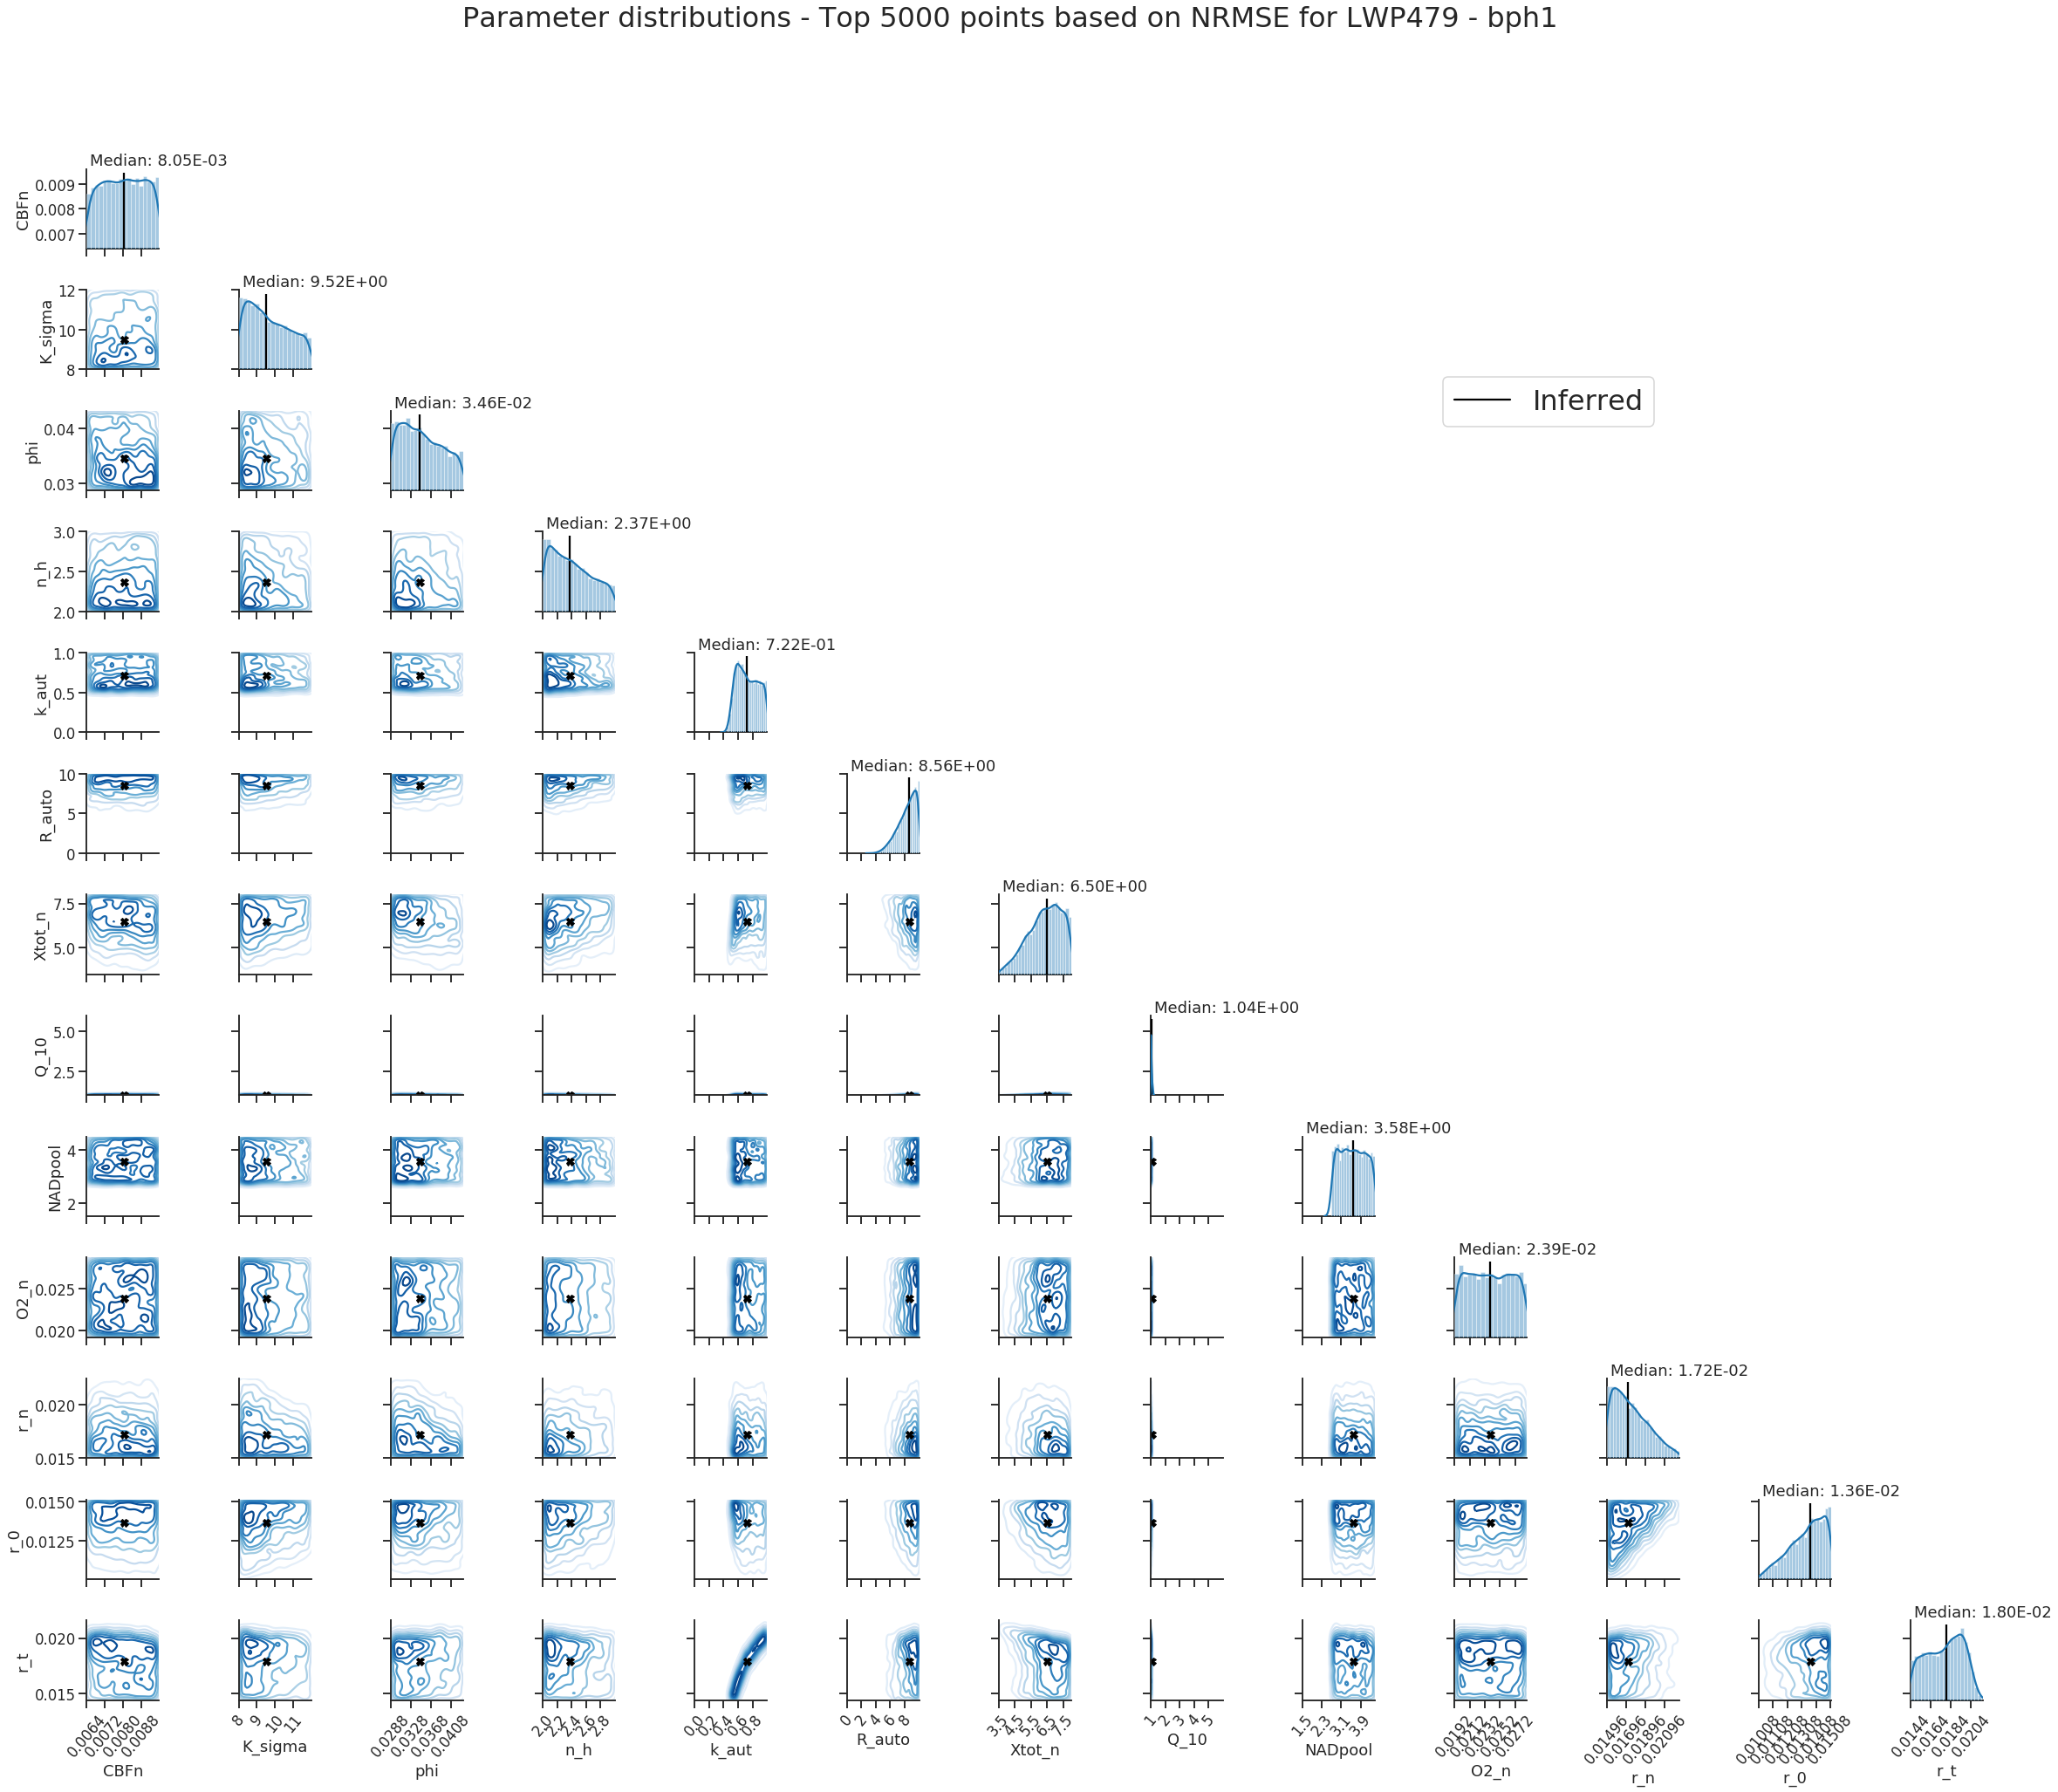

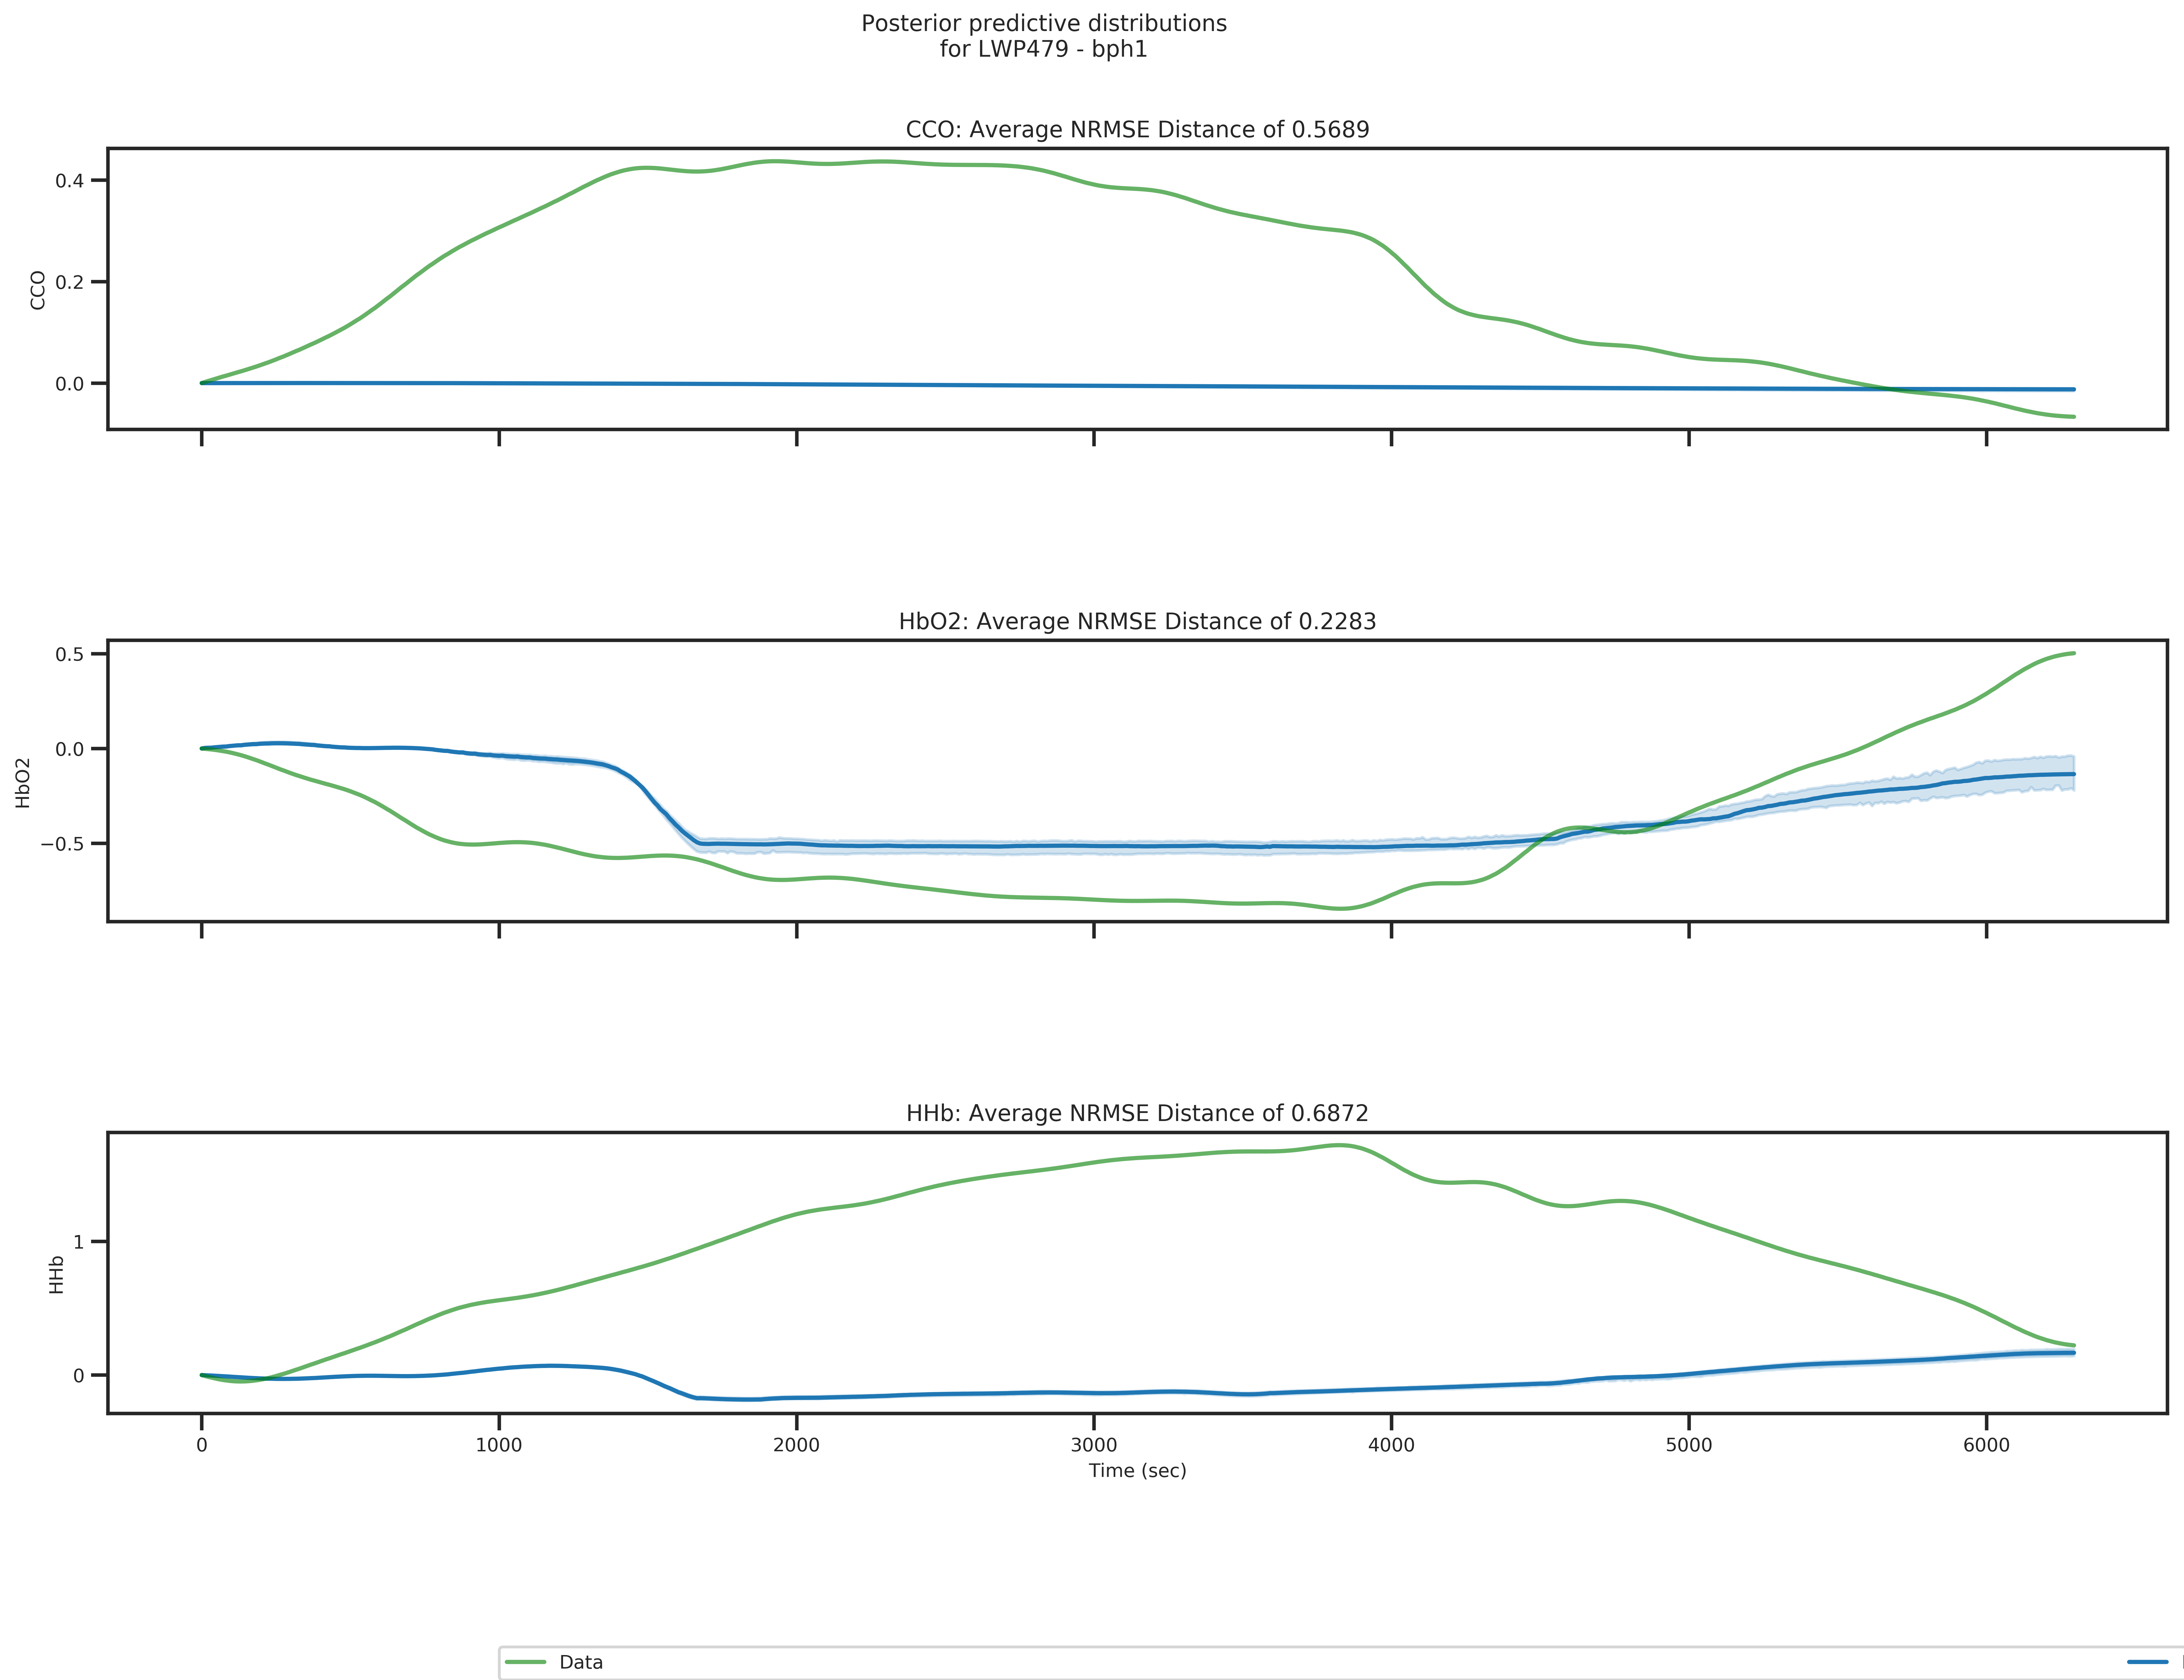

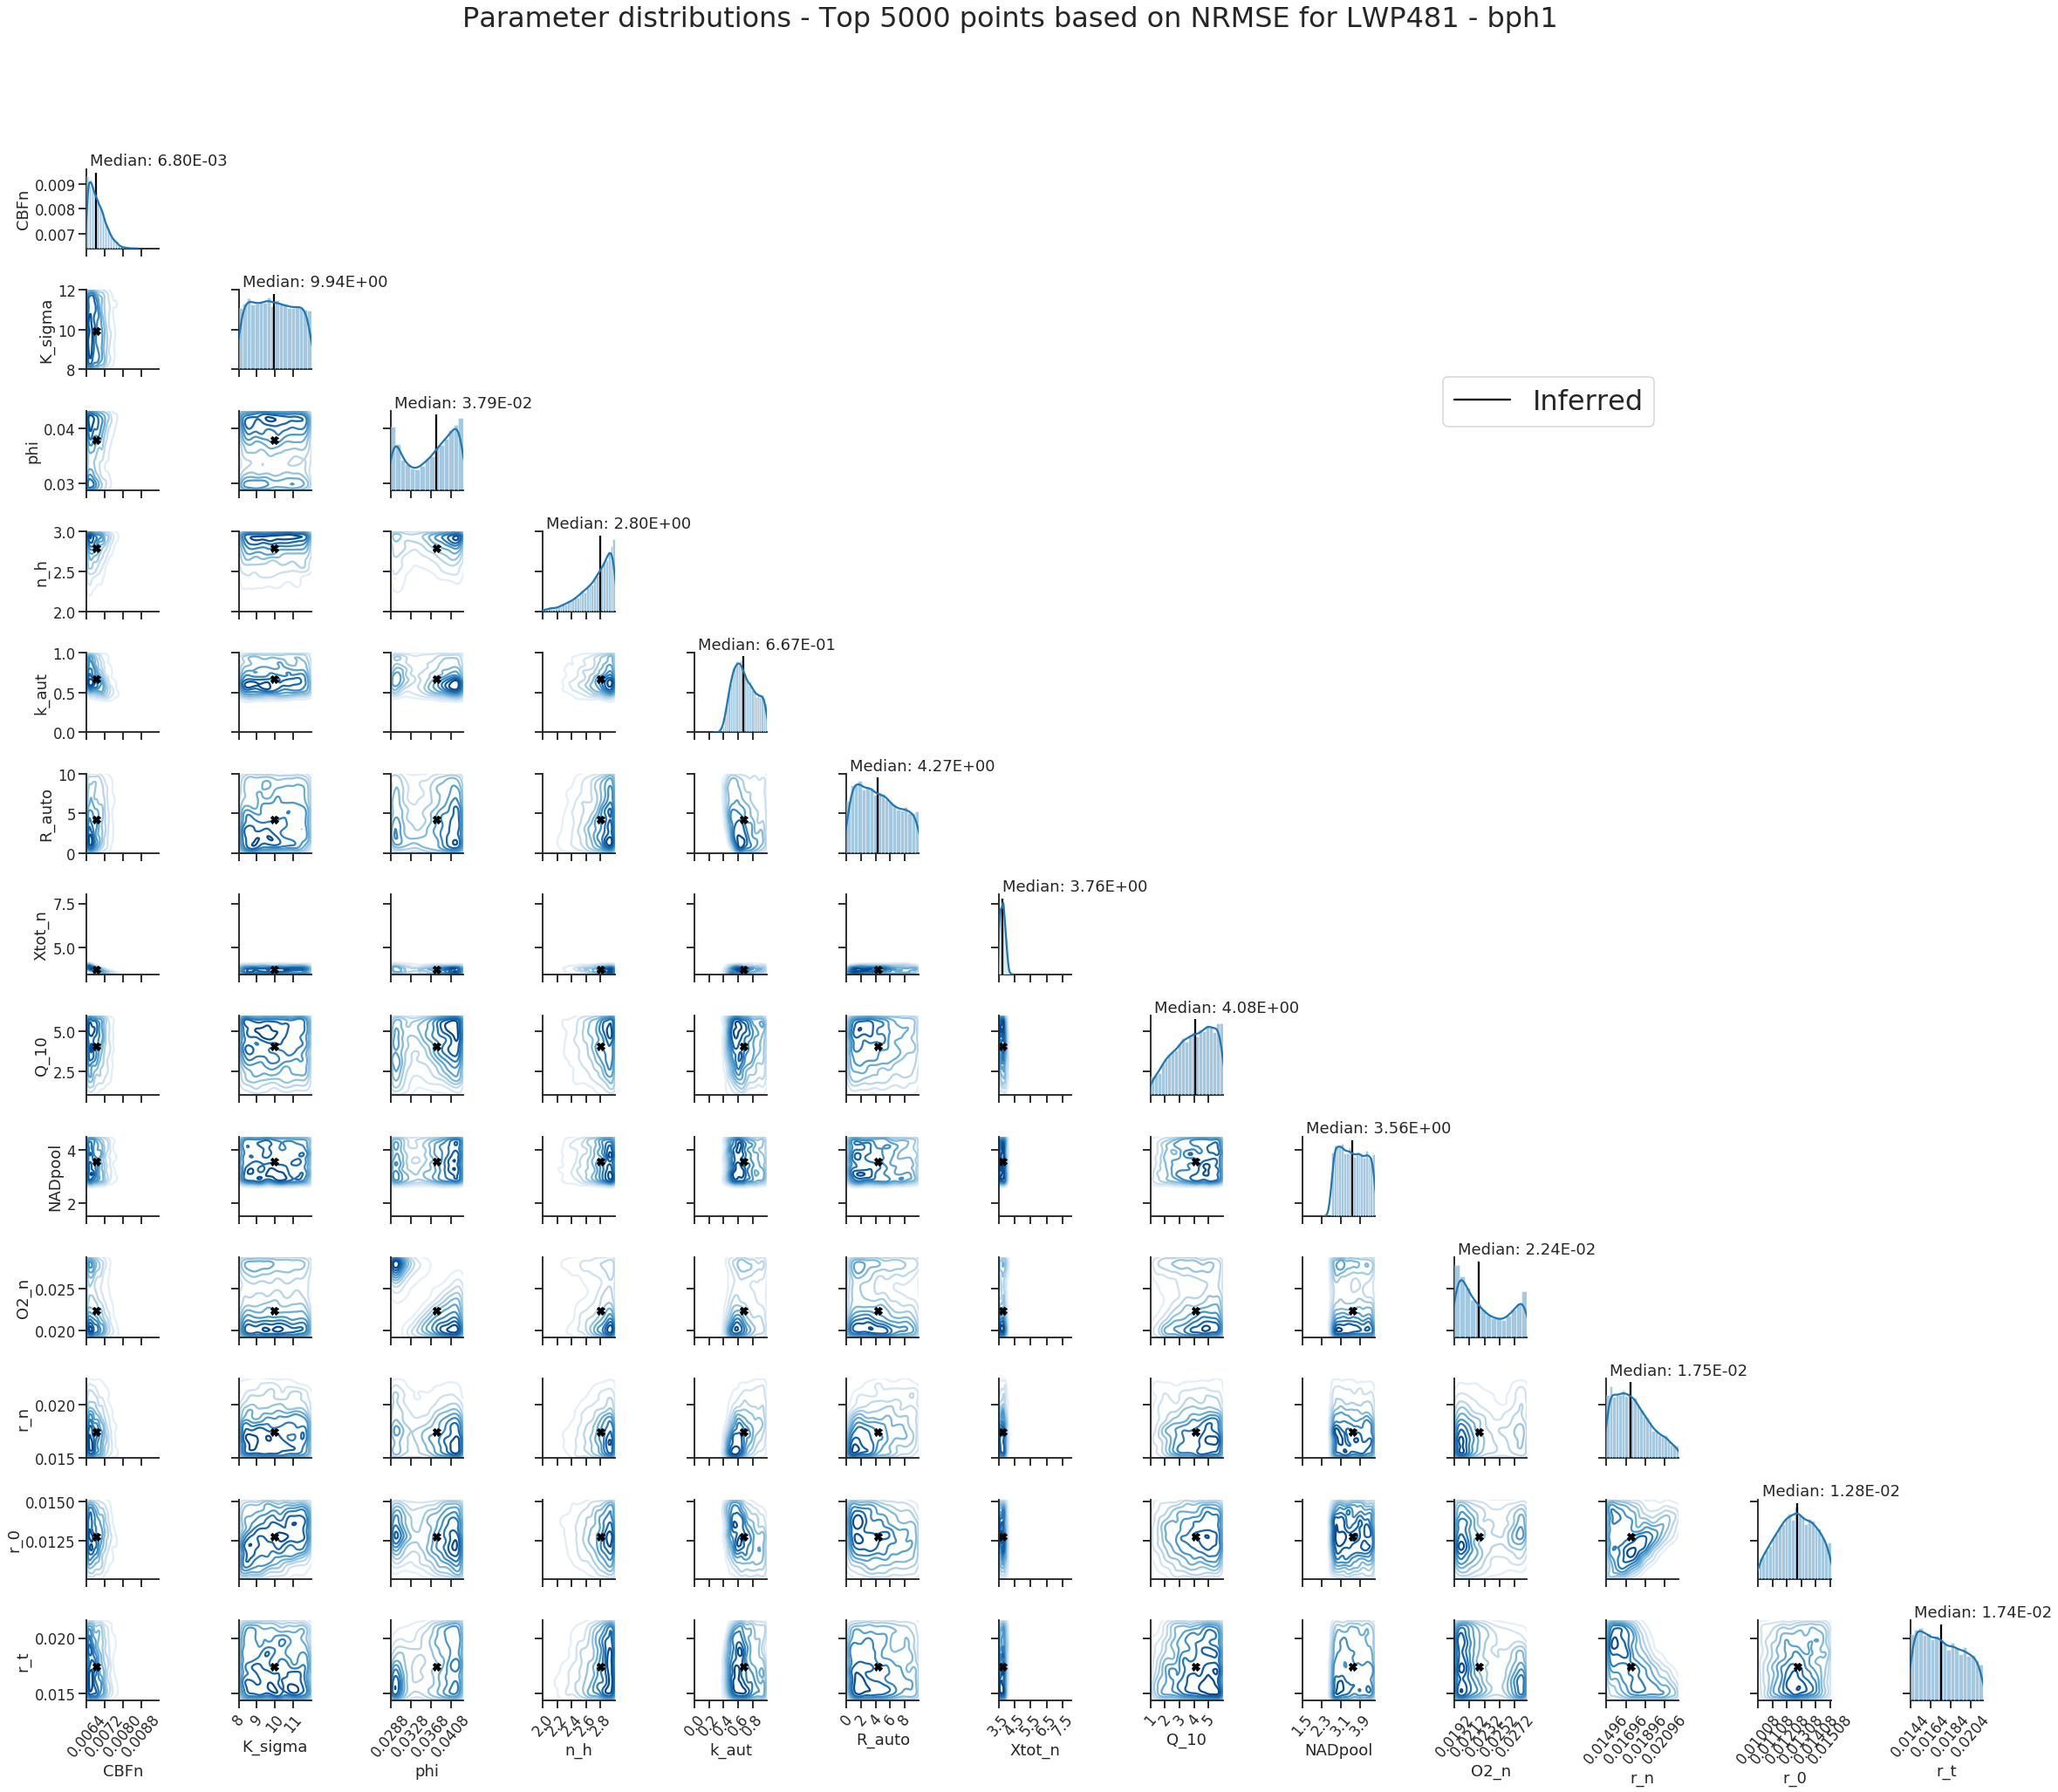

In [10]:
LIM=5000
for model_name in ['bph1', 'bph2', 'bph4']:
    for DATASET in ['LWP475', 'LWP479' ,'LWP481' ,'LWP484']:
        print("Working on {} - {}".format(model_name, DATASET))
        # Set config and create figure path
        config = configuration[model_name][DATASET]['bayescmd_config']
        figPath = "/home/buck06191/Dropbox/phd/hypothermia/ABC/Figures/{}/{}/{}".format(model_name, DATASET, 'NRMSE')
        dir_util.mkpath(figPath)
        
        # Get posterior
        df_post = client.query(configuration[model_name][DATASET]['posterior_query']).to_dataframe()
        
        # Plot posterior 
        g = kde_plot(df_post, config['parameters'], limit=LIM, n_ticks=4, d="NRMSE", median_file=os.path.join(figPath, "medians.txt"))
        g.fig._suptitle.set_text(g.fig._suptitle.get_text() + 'for {} - {}'.format(DATASET, model_name))
        with open(os.path.join(figPath, 'posterior_{}_{}.pickle'.format(model_name, DATASET)), 'wb') as f: 
            pickle.dump(g, f)
        g.fig.savefig(
            os.path.join(figPath, 'posterior_{}_{}.png'
                         .format(model_name, DATASET)),
            bbox_inches='tight', dpi=250)
        
        # Plot posterior predictive
        config["offset"] = {}
        fig, ax, lgd = plot_repeated_outputs(df_post, n_repeats=100, limit=LIM,
                                        distance='NRMSE', **config)
        fig.suptitle('Posterior predictive distributions\nfor {} - {}'.format(DATASET, model_name))
        fig.set_size_inches(18.5, 12.5)
        with open(os.path.join(figPath, 'posterior_predictive_{}_{}.pickle'.format(model_name, DATASET)), 'wb') as f: 
            pickle.dump(g, f)
        g.fig.savefig(
            os.path.join(figPath, 'posterior_predictive_{}_{}.png'
                         .format(model_name, DATASET)),
            bbox_inches='tight', bbox_extra_artists=(lgd,), dpi=250)

In [11]:
d = {'CCO': [-1.289461848795242,
                     -1.2797240175423448,
                     -1.2686540175054333,
                     -1.256502291868834,
                     -1.2435323334530832,
                     -1.2298334958746104,
                     -1.21506686009422,
                     -1.2004348337132789,
                     -1.1851397976984377,
                     -1.169504403218546,
                     -1.153750486708933,
                     -1.138097601886616,
                     -1.1222465056926663,
                     -1.1078234083119542,
                     -1.0940060060107215,
                     -1.0812363068014108,
                     -1.0698023827931988,
                     -1.0599302316132742,
                     -1.0513890617434793,
                     -1.045220566197854,
                     -1.0408836936711514,
                     -1.0384450868963886,
                     -1.0378553482704183,
                     -1.0388538309004036,
                     -1.0414375183244517,
                     -1.0454655100784904,
                     -1.0506384082161693,
                     -1.0566991905417642,
                     -1.0634043046451886,
                     -1.0706096934950595,
                     -1.0777122220678785,
                     -1.0850051348538097,
                     -1.0921855028020642,
                     -1.09908141760392,
                     -1.1056817396874048,
                     -1.1114941398288158,
                     -1.1168660079264252,
                     -1.1216361245846889,
                     -1.1257394488974586,
                     -1.1291395351781233,
                     -1.131851189264404,
                     -1.1337369245790583,
                     -1.134946008560289,
                     -1.135446698432186,
                     -1.1352420238431773,
                     -1.134282475393272,
                     -1.132736905021339,
                     -1.1305369539533174,
                     -1.1277266935434058,
                     -1.124345297226914,
                     -1.1202706731687653,
                     -1.1159542884941356,
                     -1.1111396752945377,
                     -1.1059331816587077,
                     -1.1004065680974875,
                     -1.0946268827842718,
                     -1.0884069942079313,
                     -1.0824445364696995,
                     -1.076351027662502,
                     -1.0702725546785423,
                     -1.0643002153616776,
                     -1.0582282484474228,
                     -1.0527934346746806,
                     -1.0475995384238639,
                     -1.0427666744678346,
                     -1.0383614672029435,
                     -1.0344305426882288,
                     -1.0307705722618008,
                     -1.027916173197943,
                     -1.0255772127484701,
                     -1.0237754698953185,
                     -1.022505483489643,
                     -1.021590316376775,
                     -1.021288995834822,
                     -1.0214535901108892,
                     -1.0220194839567824,
                     -1.022929799287348,
                     -1.0240419351303898,
                     -1.0253957847657063,
                     -1.026967437846692,
                     -1.028652668271855,
                     -1.0303828264004427,
                     -1.0320541609544958,
                     -1.0336337839956753,
                     -1.0351613798245431,
                     -1.036553645571903,
                     -1.0377695329165946,
                     -1.0387845704174956,
                     -1.0395359907566049,
                     -1.0400692017968018,
                     -1.0404230941630137,
                     -1.0405822150829236,
                     -1.0405612060646863,
                     -1.0403254878410686,
                     -1.0400100026723202,
                     -1.0396339937200212,
                     -1.039228748983347,
                     -1.0388382680801467,
                     -1.038457014780529,
                     -1.03821590236045,
                     -1.0381371172711582,
                     -1.038247196025338,
                     -1.0385725283259013,
                     -1.0391205293561687,
                     -1.03988455961132,
                     -1.0409158927849553,
                     -1.0421805806528013,
                     -1.0436492760320055,
                     -1.0453204253144548,
                     -1.047022553994834,
                     -1.048840921367282,
                     -1.0506884299386094,
                     -1.0525000017667052,
                     -1.05426086966269,
                     -1.0557692692297054,
                     -1.0571126804849873,
                     -1.0582136750530229,
                     -1.0590252888328084,
                     -1.0595225673682327,
                     -1.0596439526700727,
                     -1.0594211912263947,
                     -1.0588394763034716,
                     -1.0579050329257234,
                     -1.0565853718716023,
                     -1.055036183355879,
                     -1.05320825029994,
                     -1.0511659437843464,
                     -1.0489729745216,
                     -1.0466986797610618,
                     -1.0443212965015252,
                     -1.0421597346484124,
                     -1.0401149720176268,
                     -1.0382918513978852,
                     -1.0366907001945331,
                     -1.035566784952238,
                     -1.0348457855289162,
                     -1.0345831497770224,
                     -1.034809585878285,
                     -1.0355289599453898,
                     -1.0367267562698619,
                     -1.0384117766079357,
                     -1.0405338737892642,
                     -1.0430402028762404,
                     -1.045940473327688,
                     -1.0489588448467269,
                     -1.0522141141703754,
                     -1.0555956478739665,
                     -1.0590244460646736,
                     -1.062535649955676,
                     -1.065783728126152,
                     -1.0689540726500708,
                     -1.0719584102165893,
                     -1.0748466225483597,
                     -1.0773398058974828,
                     -1.079621614128162,
                     -1.081652315411677,
                     -1.0834278303037879,
                     -1.0850229877991484,
                     -1.0862996455727856,
                     -1.0874016777475344,
                     -1.088349558978617,
                     -1.0891812926278617,
                     -1.0899834862562976,
                     -1.0907103725896181,
                     -1.091473139119358,
                     -1.0923177178479828,
                     -1.0932918144385997,
                     -1.094489552999418,
                     -1.0958319522697921,
                     -1.0974333127554456,
                     -1.0993063848015625,
                     -1.101462057716475,
                     -1.1039862791469777,
                     -1.106654566351693,
                     -1.1096112562759597,
                     -1.1127966986091025,
                     -1.1161633492981142,
                     -1.119774891932157,
                     -1.123275872972388,
                     -1.1268353271579834,
                     -1.1303443111120364,
                     -1.1338396596014928,
                     -1.136956896416497,
                     -1.1398499813020055,
                     -1.1424108071863581,
                     -1.1445648994397077,
                     -1.1463195620419737,
                     -1.1474430705026986,
                     -1.1479981078662436,
                     -1.1479130985208459,
                     -1.1471402316778114,
                     -1.1456455336724884,
                     -1.1433502561982263,
                     -1.140228172816741,
                     -1.1362470740932007,
                     -1.1312604728998545,
                     -1.1255864029400875,
                     -1.1189039303291861,
                     -1.1112694801793843,
                     -1.10270200208541,
                     -1.0929430727915974,
                     -1.082800794748595,
                     -1.071696624869467,
                     -1.0598400002846695,
                     -1.0473778821610455,
                     -1.03402486551066,
                     -1.0211462951745773,
                     -1.0080361076136428,
                     -0.9951270009296741,
                     -0.9822706507124124,
                     -0.9710305697647168,
                     -0.9607924619015633,
                     -0.952037174568684,
                     -0.9450979862287906,
                     -0.9399467887342238,
                     -0.9374086426955968,
                     -0.9371619765221468,
                     -0.9392641869978066,
                     -0.943642662738642,
                     -0.9502245604701547,
                     -0.9583954879392202,
                     -0.9682943129505024,
                     -0.9794890123709413,
                     -0.9916218022935419,
                     -1.0046856449665764,
                     -1.0174118949236512,
                     -1.0303976752837753,
                     -1.0432123954911379,
                     -1.0559550792684098,
                     -1.0674840847697786,
                     -1.078499493471665,
                     -1.0887254252852154,
                     -1.098049081957116,
                     -1.1066616127700184,
                     -1.1138454977048626,
                     -1.120133610085654,
                     -1.1254082775276728,
                     -1.1296452843673122,
                     -1.132970871119101,
                     -1.1350839595567939,
                     -1.1362243007049264,
                     -1.1363757220101125,
                     -1.1355527930505296,
                     -1.1337760568459285,
                     -1.1311408033232597,
                     -1.1275982079266058,
                     -1.1232259650134893,
                     -1.1179789330120382,
                     -1.1122696227801216,
                     -1.1058713222346117,
                     -1.0989591186962357,
                     -1.0916704670209807,
                     -1.0839398776477571,
                     -1.0765132641586506,
                     -1.0690666524276056,
                     -1.0618910234576628,
                     -1.054991923641749,
                     -1.0491485654727246,
                     -1.044085416072181,
                     -1.040067662954239,
                     -1.037264447818093,
                     -1.035711945578322,
                     -1.035670075324216,
                     -1.0370344812828391,
                     -1.0397937564482125,
                     -1.043959007835619,
                     -1.0491512629919801,
                     -1.0554724695271729,
                     -1.062686578308616,
                     -1.070589482253159,
                     -1.0792042086155103,
                     -1.0877140247840797,
                     -1.0964747444812089,
                     -1.105205219140402,
                     -1.1139739523012737,
                     -1.1219945741658741,
                     -1.129696797466329,
                     -1.136879772983361,
                     -1.143649683249298,
                     -1.1494185928643528,
                     -1.1545561396567106,
                     -1.1589496380199418,
                     -1.1625590609042007,
                     -1.1654803019370588,
                     -1.1674269756791402,
                     -1.168586054827111,
                     -1.1689282180098968,
                     -1.1684862846771922,
                     -1.1672185177878986,
                     -1.1651355225397197,
                     -1.1622640708450394,
                     -1.15862704827487,
                     -1.1541779965353713,
                     -1.1491903736355111,
                     -1.1434664588426793,
                     -1.1371166416170762,
                     -1.1300556529367156,
                     -1.1228226757468807,
                     -1.1150925453596798,
                     -1.1070589983517842,
                     -1.0986342313422548,
                     -1.0905721101988872,
                     -1.0824905827182016,
                     -1.07465244294317,
                     -1.0672409739548725,
                     -1.0601987503058206,
                     -1.0542712172687114,
                     -1.049128503928865,
                     -1.0449882476800372,
                     -1.041834721705828,
                     -1.0400686373740735,
                     -1.0394872648571343,
                     -1.0401289757110599,
                     -1.0419617528763332,
                     -1.044867088943072,
                     -1.0488237932561209,
                     -1.0536774910046405,
                     -1.0592762648641567,
                     -1.0655960395037931,
                     -1.072070576734393,
                     -1.0789168509068352,
                     -1.085896897608605,
                     -1.0930265338358185,
                     -1.0996780293586854,
                     -1.1061743076786286,
                     -1.1123201634249786,
                     -1.1181756503672442,
                     -1.1232236742285027,
                     -1.1277856973889149,
                     -1.1317366428659807,
                     -1.1351477665861986,
                     -1.1376795439915341,
                     -1.1395729433252166,
                     -1.1407680425891222,
                     -1.141255455861129,
                     -1.1410851968026732,
                     -1.140169599046137,
                     -1.1385984295569747,
                     -1.136384839619537,
                     -1.1335386847178974,
                     -1.1301817188306642,
                     -1.1262769548094655,
                     -1.121899253973957,
                     -1.1170302094841214,
                     -1.112000680943191,
                     -1.106663368413609,
                     -1.1011551396287593,
                     -1.0954460447810215,
                     -1.0900271274255802,
                     -1.0846747366592662,
                     -1.0795636974068585,
                     -1.0746630445508323,
                     -1.0704940137718477,
                     -1.0667999849674934,
                     -1.0637295895423633,
                     -1.06123903352891,
                     -1.0596938528411513,
                     -1.0588543255236473,
                     -1.058769105406791,
                     -1.0594228374485868,
                     -1.0607314568638642,
                     -1.0627110481379063,
                     -1.0652248893803007,
                     -1.0681864373216854,
                     -1.0715205066273816,
                     -1.075022884482208,
                     -1.0786866991306483,
                     -1.082384938920089,
                     -1.086088144092747,
                     -1.0894877450395768,
                     -1.09270258934539,
                     -1.0956207752799803,
                     -1.0982787788842456,
                     -1.1003434230536364,
                     -1.102026610711386,
                     -1.103254962961271,
                     -1.1041298340349548,
                     -1.104323765976274,
                     -1.104113233797683,
                     -1.103468018528102,
                     -1.1025475293556148,
                     -1.1010379004299655,
                     -1.0992624990977498,
                     -1.097231247396433,
                     -1.0951498946318867,
                     -1.0927177400501713,
                     -1.0902836000039073,
                     -1.087882578932471,
                     -1.0857388853056722,
                     -1.0835574562872972,
                     -1.081671348927001,
                     -1.0801087611574978,
                     -1.0790651568624081,
                     -1.0782439856951995,
                     -1.0779076516236634,
                     -1.0780468390529068,
                     -1.0787816138749085,
                     -1.0798328537822652,
                     -1.081346072551036,
                     -1.083270166949025,
                     -1.0856400071958414,
                     -1.0882346259829894,
                     -1.0910806030588778,
                     -1.0941112787077285,
                     -1.0973009502037563,
                     -1.100527014283861,
                     -1.1037247622996167,
                     -1.106845849338552,
                     -1.1098388335740488,
                     -1.1126941354518685,
                     -1.1152938759850544,
                     -1.1176258199708387,
                     -1.119638513086924,
                     -1.121419704662374,
                     -1.122830703501609,
                     -1.1238973050693664,
                     -1.1245815910145334,
                     -1.125036282191024,
                     -1.1251274254310828,
                     -1.1249105708012308,
                     -1.1243684716748619,
                     -1.1236797071379614,
                     -1.1227361015621724,
                     -1.1216100451179574,
                     -1.1203098553571795,
                     -1.118993228165702,
                     -1.1175967876909365,
                     -1.1161919211287983,
                     -1.1148123530944067,
                     -1.1135450948297339,
                     -1.1123846124765855,
                     -1.1113801805896817,
                     -1.1105852666995797,
                     -1.1099753113883166,
                     -1.1096077471969348,
                     -1.1094943789633709,
                     -1.109700709476623,
                     -1.110080072908181,
                     -1.110748581007259,
                     -1.1117611706908799,
                     -1.1128929955613927,
                     -1.1142943534629088,
                     -1.1159196520641328,
                     -1.11784533796862,
                     -1.1197897158091517,
                     -1.1219319327319044,
                     -1.124215742385294,
                     -1.1267196588550326,
                     -1.1291506420172859,
                     -1.1316907801586866,
                     -1.1342854853669786,
                     -1.1370092811829993,
                     -1.1395915710906925,
                     -1.142195632044234,
                     -1.1447737537021634,
                     -1.1473902768841715,
                     -1.149814274467617,
                     -1.152177327055115,
                     -1.1544402528793754,
                     -1.156654211514188,
                     -1.158637414501886,
                     -1.160485453664606,
                     -1.162169078882585,
                     -1.1637257393161582,
                     -1.1650281619064915,
                     -1.1661390371686595,
                     -1.1670809068809425,
                     -1.1677676817412905,
                     -1.1682383705932737,
                     -1.16848786473241,
                     -1.1685403823715903,
                     -1.168363551946182,
                     -1.1679711144332858,
                     -1.167374748710066,
                     -1.1665939452833816,
                     -1.1656443950786017,
                     -1.164520745028689,
                     -1.16325058104723,
                     -1.161856186836626,
                     -1.1603854300868124,
                     -1.1588233093426947,
                     -1.1572105756912707,
                     -1.1555768049130333,
                     -1.1539792474264636,
                     -1.1524053285858802,
                     -1.150904564707192,
                     -1.1495222880105038,
                     -1.148256607881816,
                     -1.1471493551850511,
                     -1.1462482602437585,
                     -1.1455452778488462,
                     -1.1450626819931484,
                     -1.1448237273719997,
                     -1.14488338259783,
                     -1.1451534333471216,
                     -1.1456903359684483,
                     -1.146488495968709,
                     -1.1476072786388725,
                     -1.1488704882126142,
                     -1.1503734110724058,
                     -1.1521666744648569,
                     -1.1540173369351758,
                     -1.1560474127749072,
                     -1.1582075705179915,
                     -1.1605646722264435,
                     -1.162841470473916,
                     -1.165189235048934,
                     -1.1675500409115607,
                     -1.1699966989302917,
                     -1.172240796210442,
                     -1.1744473925241286,
                     -1.1765622203592154,
                     -1.1786619619465402,
                     -1.180475950703062,
                     -1.1821674404262468,
                     -1.1837915946234965,
                     -1.1851008639818694,
                     -1.1862455955734859,
                     -1.1871950332345322,
                     -1.188025408113347,
                     -1.1885414926683555,
                     -1.188870974285944,
                     -1.1890001987358494,
                     -1.1890015971360668,
                     -1.1887342404132728,
                     -1.1882949888328165,
                     -1.187748035584186,
                     -1.1869932315166558,
                     -1.1861045124933236,
                     -1.1851011384325139,
                     -1.1840484605016413,
                     -1.1828962451692167,
                     -1.1816934263872256,
                     -1.180474586589018,
                     -1.1793032220893933,
                     -1.178154403106455,
                     -1.177064740235291,
                     -1.1761069763050098,
                     -1.1752537388655289,
                     -1.1745415342357342,
                     -1.174002063527145,
                     -1.1736999969429873,
                     -1.1735659295789016,
                     -1.173647531412126,
                     -1.1739538795076077,
                     -1.1745468007826352,
                     -1.1752886331360404,
                     -1.1762483243998996,
                     -1.1774050854106828,
                     -1.1788164415505589,
                     -1.1802778283222022,
                     -1.181881742447299,
                     -1.1836706069038034,
                     -1.185406938162747,
                     -1.18719478437806,
                     -1.1889822671717487,
                     -1.190819923284683,
                     -1.1924680562768661,
                     -1.1940325209943352,
                     -1.195463300959629,
                     -1.1968043087887388,
                     -1.1978512400783574,
                     -1.1986900335643347,
                     -1.1993442211519578,
                     -1.1996560490467492,
                     -1.1996786246849953,
                     -1.1993858399876718,
                     -1.1987890906972098,
                     -1.1978170139702218,
                     -1.1964631573743925,
                     -1.1947169644752575,
                     -1.1925543273999009,
                     -1.1900100087665983,
                     -1.1869962901856468,
                     -1.1834726944229632,
                     -1.1795710208028032,
                     -1.1751300972441472,
                     -1.170165728952627,
                     -1.1645590498256262,
                     -1.1585882412956072,
                     -1.151971916616943,
                     -1.1447415098343572,
                     -1.136702470360918,
                     -1.1283198684004758,
                     -1.119163423757021,
                     -1.109033342530366,
                     -1.0985792760463418,
                     -1.087238018691878,
                     -1.075079313791833,
                     -1.0617212070201978,
                     -1.048095492546358,
                     -1.0334125747172185,
                     -1.0177733056743723,
                     -1.00063931677101,
                     -0.983339302663114,
                     -0.9648030739063586,
                     -0.9444811867122802,
                     -0.9241186684745066,
                     -0.9024028026611685,
                     -0.8795271554230901,
                     -0.8545615536685275,
                     -0.8298725534425749,
                     -0.8037549786533477,
                     -0.7752467667997851,
                     -0.7473344851808469,
                     -0.7180075636792603,
                     -0.6875731104102468,
                     -0.6545175910951251,
                     -0.6226173546065734,
                     -0.5893855127898932,
                     -0.5551286153458006,
                     -0.5178497823523283,
                     -0.4821798689368791,
                     -0.4451033578464834,
                     -0.40435200301795393,
                     -0.3653109054698048,
                     -0.3245332239239113,
                     -0.28217769500487616,
                     -0.23518199007222973,
                     -0.19088456196536743,
                     -0.14749371284731566,
                     -0.11136327872602027,
                     -0.10806399720489046,
                     -0.10713087111010997,
                     -0.10601008811167953,
                     -0.1045708082151021,
                     -0.10313893616571629,
                     -0.10159908393612684,
                     -0.09997156683531025,
                     -0.09808540437528818,
                     -0.09633294506730117,
                     -0.094548645082022,
                     -0.09254485235839859,
                     -0.09072940108557906,
                     -0.0889170004218609,
                     -0.08711535626914102,
                     -0.08513634232977105,
                     -0.08338118274853196,
                     -0.08165852873953189,
                     -0.07997285906385801,
                     -0.07814297225947019,
                     -0.07654813328826457,
                     -0.07500139550971843,
                     -0.07333015071601194,
                     -0.07189176173095031,
                     -0.0705059918871364,
                     -0.06917547879191399,
                     -0.0677409102480965,
                     -0.06652972909777954,
                     -0.06537400596314613,
                     -0.06412388972019376,
                     -0.06308614389872352,
                     -0.06210101484319194,
                     -0.06116879451886859,
                     -0.060151924533719446,
                     -0.05932803129307349,
                     -0.06736618464548735,
                     -0.11578242977309927,
                     -0.19860085954113788,
                     -0.2704253482687285,
                     -0.33533292349681715,
                     -0.39515016181518053,
                     -0.44455122795062135,
                     -0.4894154532321582,
                     -0.5294111547658312,
                     -0.5661678964142249,
                     -0.5964471754073106,
                     -0.6238022920753145,
                     -0.6490466361753416,
                     -0.6698383461524235,
                     -0.688613750499554,
                     -0.7053163812654248,
                     -0.7207747636278432,
                     -0.7335689101108482,
                     -0.7452592374010121,
                     -0.7563555855984748,
                     -0.7657511147684701,
                     -0.7745810227701877,
                     -0.7828651582995997,
                     -0.7911195255261606,
                     -0.7984642676069371,
                     -0.8057254239862468,
                     -0.8128841205720515,
                     -0.8203582163043511,
                     -0.8272496068944211,
                     -0.8342202103394375,
                     -0.8415651059524926,
                     -0.8483148430134865,
                     -0.8550548313681855,
                     -0.8616466444740285,
                     -0.8683725525018587,
                     -0.8742673254287828,
                     -0.8798345945849803,
                     -0.8852568558859484,
                     -0.8896406486453868,
                     -0.8933921723785185,
                     -0.8963663643819518,
                     -0.8987122177583131,
                     -0.8997969477973323,
                     -0.899833335298177,
                     -0.8987290492946408,
                     -0.8965240941095308,
                     -0.8929809692642373,
                     -0.8880292976683433,
                     -0.8816413322834,
                     -0.8739924233020168,
                     -0.8647607429849244,
                     -0.8540358608459743,
                     -0.841637681685104,
                     -0.8284094883331509,
                     -0.8137004014011343,
                     -0.7978262347548988,
                     -0.7806097766835517,
                     -0.7636621776228406,
                     -0.7461860740420102,
                     -0.7288368782498298,
                     -0.7117011661155861,
                     -0.6967932188299234,
                     -0.6835142694215189,
                     -0.6726952884464176,
                     -0.6647898396635875,
                     -0.660887009637885,
                     -0.6608277313309538,
                     -0.664899556706862,
                     -0.673531256001834,
                     -0.6854787828409834,
                     -0.7011534696279671,
                     -0.7207221028528745,
                     -0.7414555644103195,
                     -0.7643240193663404,
                     -0.7884373005166145,
                     -0.8140972373293601,
                     -0.8381915915309972,
                     -0.8622937572095738,
                     -0.8857357016266375,
                     -0.9090192963034887,
                     -0.9297055520723262,
                     -0.949407595233951,
                     -0.9677850538002162,
                     -0.9853918875026887,
                     -1.000572702302969,
                     -1.0146208250024253,
                     -1.0273992930851792,
                     -1.039392706352153,
                     -1.0495245606504937,
                     -1.058714296876699,
                     -1.0672862502656126,
                     -1.0744417984248888,
                     -1.0808625857105314,
                     -1.0865532748822795,
                     -1.0918442654245506,
                     -1.096211028814793,
                     -1.1001177427577347,
                     -1.1035977109574586,
                     -1.1069211642008698,
                     -1.1096958834724735,
                     -1.112250300352427,
                     -1.1148056171566632,
                     -1.117005580833392,
                     -1.1191123328367767,
                     -1.1211485080772456,
                     -1.1233152483869717,
                     -1.125260923490966,
                     -1.1272007876489663,
                     -1.129132470274481,
                     -1.1312271471395592,
                     -1.1331176894009518,
                     -1.1349950602969592,
                     -1.1368352439883238,
                     -1.1387868577854552,
                     -1.1404785773110182,
                     -1.1420840930293183,
                     -1.14373282626369,
                     -1.1450673062657597,
                     -1.146247394175573,
                     -1.1472445808970821,
                     -1.1481782858698661,
                     -1.148742375903749,
                     -1.1490693978796436,
                     -1.1491446739176991,
                     -1.149070982929514,
                     -1.148625803386226,
                     -1.147903885454626,
                     -1.1470006849382073,
                     -1.145768853207383,
                     -1.1442714853650342,
                     -1.1425364060980938,
                     -1.1406421457431293,
                     -1.1385403783695391,
                     -1.136258015471205,
                     -1.1338529458845454,
                     -1.1314049661088765,
                     -1.1289446742595821,
                     -1.1264849120946476,
                     -1.124137353637159,
                     -1.1219577999016386,
                     -1.1199699694360155,
                     -1.118264857853689,
                     -1.1169596808666287,
                     -1.1160462229873604,
                     -1.1155851749313535,
                     -1.1156352438115258,
                     -1.1163252143731996,
                     -1.1174721275474888,
                     -1.1191887732378134,
                     -1.1215882053193829,
                     -1.1243178952822714,
                     -1.1275248978112813,
                     -1.1311139076913603,
                     -1.1351641679387885,
                     -1.1391495694800575,
                     -1.1432380900933559,
                     -1.147265153165476,
                     -1.1512599877472665,
                     -1.1546627921589039,
                     -1.1575984466267806,
                     -1.160013239662198,
                     -1.1614157271691086,
                     -1.1618167230252268,
                     -1.1609972945904201,
                     -1.1587590748526093,
                     -1.1548221646793764,
                     -1.1488417017303392,
                     -1.1403373164304251,
                     -1.1292740649462119,
                     -1.1147010243692483,
                     -1.095953017927075,
                     -1.0714138937827036,
                     -1.0414643961393146,
                     -1.0028286469282541,
                     -0.9529413755879199,
                     -0.8852144267357323,
                     -0.7987840912770064,
                     -0.676842211065584,
                     -0.48792712913633013,
                     -0.21573581449368445,
                     'NaN',
                     'NaN',
                     -0.1896753973596331,
                     -0.17187980132916295,
                     -0.17985388649987616,
                     -0.18588697983243355,
                     -0.1908582400387973,
                     -0.19535380385734136,
                     -0.19850014070660799,
                     -0.20097932909764987,
                     -0.2028550908215414,
                     -0.20436087904160205,
                     -0.2051244606201852,
                     -0.20548816141196796,
                     -0.20550646787661975,
                     -0.2050722939781826,
                     -0.20437375755807186,
                     -0.20342209602602251,
                     -0.20217763428577903,
                     -0.2007827184298368,
                     -0.19926371669937937,
                     -0.197633372691842,
                     -0.19577805000242351,
                     -0.19398135785900925,
                     -0.1921595531838342,
                     -0.1901538433088841,
                     -0.18830246800279804,
                     -0.18646774918824816,
                     -0.18465486691349023,
                     -0.1826921151682123,
                     -0.18093408156475052,
                     -0.17922481738196508,
                     -0.1773818466332258,
                     -0.1757617106760789,
                     -0.1741929750669307,
                     -0.17267428293937903,
                     -0.17103541118017038,
                     -0.16961586868184803,
                     -0.1682498038432652,
                     -0.16676941838765008,
                     -0.1654983816874253,
                     -0.16427711284760818,
                     -0.16309946527815977,
                     -0.16181455332764405,
                     -0.16072120116463168,
                     -0.15966982793224985,
                     -0.15851394502226687,
                     -0.1575314549742034,
                     -0.1565841432293631,
                     -0.15566567038067727,
                     -0.15464594257100814,
                     -0.15377939503049248,
                     -0.152938008493218,
                     -0.1519992382562345,
                     -0.15119974140018158,
                     -0.15042163225645813,
                     -0.1496604472189839,
                     -0.14881007758006118,
                     -0.1480834647553336,
                     -0.1473758606978756,
                     -0.146587480139833,
                     -0.14591174307878746,
                     -0.1452556174659753,
                     -0.14452855204918438,
                     -0.14390702626083426,
                     -0.14330698940719058,
                     -0.14272591164020118,
                     -0.14208743656138798,
                     -0.14154653485651297,
                     -0.1410312875590009,
                     -0.1404688013561006,
                     -0.13999953217632694,
                     -0.13955906566644946,
                     -0.13914443915943522,
                     -0.1386943186858779,
                     -0.13833246119776932,
                     -0.13800278752477818,
                     -0.13764438553743194,
                     -0.13737011543390892,
                     -0.1371289839665407,
                     -0.1369166801255307,
                     -0.13668173448658594,
                     -0.13652381247696688,
                     -0.13639792197380837,
                     -0.1362986235671188,
                     -0.13617913391519942,
                     -0.1361278686532466,
                     -0.13610352623055494,
                     -0.13605715030890156,
                     -0.13607141900402242,
                     -0.1361074096635599,
                     -0.13615825079988375,
                     -0.1361811165059628,
                     -0.13625403356483679,
                     -0.13633761982352577,
                     -0.13642505999324372,
                     -0.13647423796686511,
                     -0.13656366822747884,
                     -0.136650640142013,
                     -0.13669141981755392,
                     -0.136767823635352,
                     -0.13683413871569575,
                     -0.13688931198056287,
                     -0.13689690243262212,
                     -0.13694024391652132,
                     -0.13697115801966775,
                     -0.13699290764039834,
                     -0.1369746772160403,
                     -0.13699400326149996,
                     -0.13700451108248057,
                     -0.13698196989438022,
                     -0.1369960445556678,
                     -0.13700567729222002,
                     -0.13701582109193589,
                     -0.13700512050878466,
                     -0.13702763712483176,
                     -0.13705186971043054,
                     -0.13706165765771425,
                     -0.13710076835733598,
                     -0.13714582846193146,
                     -0.13719850077098872,
                     -0.1372458955481147,
                     -0.13731757281492268,
                     -0.13740022912793962,
                     -0.13748161280646715,
                     -0.13758402846981918,
                     -0.13769941029526991,
                     -0.1378254484879075,
                     -0.13795307738247534,
                     -0.13809761188418088,
                     -0.13825483693846605,
                     -0.13841297039008377,
                     -0.13858495108713853,
                     -0.1387676457548424,
                     -0.13895611284109102,
                     -0.13914147528548615,
                     -0.13933733112446597,
                     -0.13953829004098892,
                     -0.13974047157979763,
                     -0.13993446850202554,
                     -0.140136632036255,
                     -0.14033815392086618,
                     -0.1405276192998184,
                     -0.14072393986723242,
                     -0.14091595616983052,
                     -0.14110231981273452,
                     -0.14127442007368324,
                     -0.14145178370419642,
                     -0.14162162135345324,
                     -0.14177617741283913,
                     -0.141934028692187,
                     -0.14208336795608212,
                     -0.14222443501743073,
                     -0.142352317699902,
                     -0.1424807912511556,
                     -0.1426015358528425,
                     -0.1427120207337857,
                     -0.14282100285060279,
                     -0.14292512841255542,
                     -0.14302525359168938,
                     -0.14312315303417622,
                     -0.1432183493048694,
                     -0.14331656472950746,
                     -0.1434201257285778,
                     -0.14352287719955464,
                     -0.14363403828963434,
                     -0.14375291794349165,
                     -0.14388660706929016,
                     -0.14402102169614292,
                     -0.14417083271245246,
                     -0.1443403958262388,
                     -0.14451072593781827,
                     -0.14469909397043706,
                     -0.14490095048066723,
                     -0.1451234176633389,
                     -0.1453444096106699,
                     -0.14558249373470375,
                     -0.14583908902996215,
                     -0.1460913909002241,
                     -0.14635746675251193,
                     -0.14663042594280162,
                     -0.14691550032818199,
                     -0.14719183679211803,
                     -0.14747577726829314,
                     -0.1477670895762877,
                     -0.1480469026873531,
                     -0.14832999250235201,
                     -0.14861068551429849,
                     -0.14889380172783154,
                     -0.1491637776164751,
                     -0.1494325781785133,
                     -0.1497045912348586,
                     -0.14996425549009113,
                     -0.15022477786408292,
                     -0.1504817389090255,
                     -0.15074499859811094,
                     -0.15099997586413577,
                     -0.15126163156458886,
                     -0.15153555285253043,
                     -0.15180728632399845,
                     -0.15209243744165016,
                     -0.15239808772675498,
                     -0.1527051657435495,
                     -0.15303346645418017,
                     -0.15338049918894875,
                     -0.15375880220534463,
                     -0.1541428515314468,
                     -0.15455706221348967,
                     -0.15500810561277933,
                     -0.15546428184379238,
                     -0.1559535321643421,
                     -0.15646720407850126,
                     -0.15701825149511756,
                     -0.15756726874009147,
                     -0.1581461375983106,
                     -0.15875749972228295,
                     -0.1593565610254685,
                     -0.15997775690929128,
                     -0.16062218585535123,
                     -0.1612415958841747,
                     -0.16187219531300404,
                     -0.16249761459014153,
                     -0.1631304657635259,
                     -0.16372157834088719,
                     -0.16430815447341116,
                     -0.16489172282282452,
                     -0.1654244277943708,
                     -0.16594303903061913,
                     -0.1664512188736376,
                     -0.16690461706959245,
                     -0.16733830174473652,
                     -0.16774254476201117,
                     -0.16813398311171077,
                     -0.1684743037405022,
                     -0.16879488352180344,
                     -0.16910731054094574,
                     -0.16937665611833808,
                     -0.16963133446889508,
                     -0.16988558721927902,
                     -0.17010749136217937,
                     -0.17032279213706059,
                     -0.17053126937628896,
                     -0.170752037140035,
                     -0.17095445948919863,
                     -0.17116153176424995,
                     -0.17139036500412588,
                     -0.17160892649656834,
                     -0.17183937840114377,
                     -0.1720983487823517,
                     -0.17235164329457375,
                     -0.1726215844061901,
                     -0.17290692490952134,
                     -0.17322575992719808,
                     -0.17353932851712175,
                     -0.17387207230794885,
                     -0.17423784092586786,
                     -0.1745954815847996,
                     -0.17497094634948107,
                     -0.1753770593507544,
                     -0.17576976211890355,
                     -0.1761771342925061,
                     -0.17661106358773032,
                     -0.17702558835687388,
                     -0.17745082175904225,
                     -0.17787792529563987,
                     -0.1783252925207061,
                     -0.17874610696635396,
                     -0.17917171674099072,
                     -0.17961250160263967,
                     -0.1800226617450694,
                     -0.1804337247870901,
                     -0.18085641753834777,
                     -0.1812464000866747,
                     -0.18163466240132056,
                     -0.1820141215423854,
                     -0.18240235713914862,
                     -0.1827581826493822,
                     -0.18310943907953878,
                     -0.18346927465417065,
                     -0.18379912253527556,
                     -0.18412794531786958,
                     -0.18445003837063195,
                     -0.18478281326696472,
                     -0.18509050279599568,
                     -0.18539853230649192,
                     -0.18572021115704226,
                     -0.18602097368637316,
                     -0.18632506612835537,
                     -0.1866300251638382,
                     -0.18695347960063835,
                     -0.18726055419557583,
                     -0.18757536746450582,
                     -0.18791206365201366,
                     -0.18823415079042619,
                     -0.1885666940257511,
                     -0.18890488003331152,
                     -0.18926992264986756,
                     -0.189619609246142,
                     -0.18998235204494585,
                     -0.19037231502671154,
                     -0.19074375225594153,
                     -0.19112888469953504,
                     -0.1915211067625489,
                     -0.19194111406571648,
                     -0.1923370529191962,
                     -0.1927468376618504,
                     -0.1931850355400535,
                     -0.1935946405189497,
                     -0.1940180968271039,
                     -0.19447004081583089,
                     -0.1948894451516203,
                     -0.19532279249412784,
                     -0.19575935607506023,
                     -0.1962241185078723,
                     -0.1966526789862054,
                     -0.19709552087482526,
                     -0.19756745721532984,
                     -0.19800191981322818,
                     -0.19845090567168433,
                     -0.19890260031636453,
                     -0.19938256518227016,
                     -0.1998248064566349,
                     -0.2002815445490244,
                     -0.2007669608535596,
                     -0.2012155761182044,
                     -0.20167841556893118,
                     -0.20214379741574545,
                     -0.20263614665338792,
                     -0.2030931974972574,
                     -0.20356368695590613,
                     -0.20406084743861513,
                     -0.2045239376376098,
                     -0.20499937172799598,
                     -0.20549955182486324,
                     -0.20596693617802805,
                     -0.20644589551819442,
                     -0.20692558267760505,
                     -0.20742875641993003,
                     -0.20790054293137375,
                     -0.20838200720201197,
                     -0.2088859378443492,
                     -0.20935908457476932,
                     -0.20984075550959697,
                     -0.21032198148459624,
                     -0.21082415754378245,
                     -0.21129572088497287,
                     -0.21177453929545664,
                     -0.21227385146745575,
                     -0.2127418089024017,
                     -0.2132161062688255,
                     -0.21371000983865246,
                     -0.21417135067541296,
                     -0.21463765322126607,
                     -0.2151003686265653,
                     -0.2155815463067361,
                     -0.21602761716813756,
                     -0.21647697551140466,
                     -0.216944474084297,
                     -0.21737272061982738,
                     -0.2178043621855981,
                     -0.21822964171575882,
                     -0.2186722430145082,
                     -0.21907407853678867,
                     -0.21947663643243553,
                     -0.2198970402930282,
                     -0.22027517264008284,
                     -0.22065407045387786,
                     -0.22105156900221545,
                     -0.22140581299770012,
                     -0.22176155354109603,
                     -0.2221110030447845,
                     -0.22248151495300422,
                     -0.22280909051748607,
                     -0.22314084221101543,
                     -0.22349734814372396,
                     -0.22381226218901606,
                     -0.22413435403020832,
                     -0.22448512859823694,
                     -0.22479624355274044,
                     -0.22511816150844874,
                     -0.2254431382353664,
                     -0.2258010214468567,
                     -0.2261218506008311,
                     -0.2264581609660867,
                     -0.22683176883031614,
                     -0.2271701460007465,
                     -0.22752720554963485,
                     -0.2279239587842463,
                     -0.2282866558257036,
                     -0.2286702099868099,
                     -0.2290645306691054,
                     -0.229498978580257,
                     -0.22989956695818028,
                     -0.23032216873912198,
                     -0.23078519642013023,
                     -0.23121375158256408,
                     -0.2316634653855127,
                     -0.23215147040873194,
                     -0.23260370280480278,
                     -0.23307493488521636,
                     -0.23355226779673208,
                     -0.23406201335640822,
                     -0.2345331612143589,
                     -0.23501877920725947,
                     -0.23553365268851614,
                     -0.23600925582463486,
                     -0.23649538207300966,
                     -0.2370061298883258,
                     -0.2374765609568678,
                     -0.23795393428631287,
                     -0.2384268232844336,
                     -0.2389188408560389,
                     -0.23937058256993504,
                     -0.23982540894094942,
                     -0.24029758609008062,
                     -0.2407300926104478,
                     -0.24116388811751718,
                     -0.24161391103379987,
                     -0.24202485878155697,
                     -0.24243628664284664,
                     -0.24286421295317312,
                     -0.2432536386626114,
                     -0.2436437956188312,
                     -0.24402757638487765,
                     -0.24442987945898811,
                     -0.24479443690047795,
                     -0.24516184289752604,
                     -0.24555075370372473,
                     -0.24590240667873606,
                     -0.24625917040409712,
                     -0.2466405584089232,
                     -0.24698523294984653,
                     -0.2473375775936499,
                     -0.24771728476069335,
                     -0.2480605757635879,
                     -0.24841348590514448,
                     -0.24879613673957238,
                     -0.24914254231506125,
                     -0.2495000988262795,
                     -0.2498603874915677,
                     -0.25025051410558874,
                     -0.2506050417944993,
                     -0.25097141986710303,
                     -0.2513683277769941,
                     -0.25172999680517,
                     -0.2521029925008884,
                     -0.2525054897277123,
                     -0.2528736265190823,
                     -0.2532528442948282,
                     -0.2536609492383841,
                     -0.2540352853136036,
                     -0.25442041805571436,
                     -0.25480786367137,
                     -0.2552231328125542,
                     -0.2556044644526577,
                     -0.25599640461135464,
                     -0.2564171723224967,
                     -0.2568030102655939,
                     -0.2571999803144721,
                     -0.2576265193168445,
                     -0.25801615726412175,
                     -0.25841758328491155,
                     -0.258849867683898,
                     -0.2592431359914262,
                     -0.2596493866056026,
                     -0.26008823493361233,
                     -0.2604855220735767,
                     -0.26089701101370083,
                     -0.26134263387942125,
                     -0.2617444223052244,
                     -0.2621614119559539,
                     -0.2626134482833558,
                     -0.2630196786623073,
                     -0.26344132761072386,
                     -0.2638653170930205,
                     -0.26432268627315453,
                     -0.2647324051130871,
                     -0.2651567545285973,
                     -0.2656145375508858,
                     -0.2660243410028852,
                     -0.26644758187409295,
                     -0.2668710349960132,
                     -0.2673245624446598,
                     -0.26773058595835686,
                     -0.26814828678042324,
                     -0.2685958830189266,
                     -0.2689969573049941,
                     -0.26940845607571556,
                     -0.26981858353445054,
                     -0.2702562192207623,
                     -0.27064817725101703,
                     -0.27104901821279564,
                     -0.27147701433791527,
                     -0.271860297616333,
                     -0.27225143977648725,
                     -0.2726686265045834,
                     -0.27304151942137084,
                     -0.27342094720944826,
                     -0.2738248741163913,
                     -0.27418546201038924,
                     -0.2745510668298795,
                     -0.27491226383605744,
                     -0.27529478879398644,
                     -0.27563584335313357,
                     -0.27597967387834366,
                     -0.2763436381515957,
                     -0.2766687430437033,
                     -0.2769953537314135,
                     -0.27734023017249076,
                     -0.2776500084056106,
                     -0.27796015481945724,
                     -0.27826552921239467,
                     -0.27858747974602277,
                     -0.2788805641559663,
                     -0.27917418869581634,
                     -0.2794849575344327,
                     -0.2797715452627049,
                     -0.28005988315379543,
                     -0.2803673399796341,
                     -0.28065411649735633,
                     -0.2809450552260315,
                     -0.28123850180961335,
                     -0.281555864707828,
                     -0.2818538859175442,
                     -0.2821607796512126,
                     -0.2824968045222075,
                     -0.2828112111512256,
                     -0.28313893793099704,
                     -0.28350197190081844,
                     -0.2838394425798437,
                     -0.28419562112805635,
                     -0.28459364304689694,
                     -0.2849605067789051,
                     -0.28535099049917534,
                     -0.28575493231439947,
                     -0.2862066572567298,
                     -0.28661733953283075,
                     -0.2870561376937042,
                     -0.28754621663581503,
                     -0.2879870889997333,
                     -0.2884560651112661,
                     -0.2889747778170279,
                     -0.2894361288094926,
                     -0.28992271187698315,
                     -0.29045456725254076,
                     -0.2909224521145215,
                     -0.29141074563003594,
                     -0.2918982410671045,
                     -0.2924204533248229,
                     -0.29287402062014994,
                     -0.2933408775475105,
                     -0.29383859410496443,
                     -0.29426862320663616,
                     -0.294707528096463,
                     -0.2951731816289922,
                     -0.2955747468753209,
                     -0.29598270481521805,
                     -0.2964154611073836,
                     -0.29678972078872695,
                     -0.2971699200472416,
                     -0.2975755651519602,
                     -0.2979291149453736,
                     -0.29828998357771264,
                     -0.2986478085321172,
                     -0.2990334557079575,
                     -0.2993744740904829,
                     -0.29972643448713054,
                     -0.30011108803766995,
                     -0.30045503449228195,
                     -0.30081294777401546,
                     -0.3012069502240043,
                     -0.3015620397773348,
                     -0.3019336075777225,
                     -0.30234354555337456,
                     -0.30271469642365095,
                     -0.30310379805173737,
                     -0.3035329187622758,
                     -0.3039217647242813,
                     -0.30432870912050014,
                     -0.30474222356395875,
                     -0.3051938544317957,
                     -0.3056020175965576,
                     -0.3060270185968164,
                     -0.30648974180367355,
                     -0.30690529308734016,
                     -0.30733718445351144,
                     -0.30780454382868416,
                     -0.30822438061251234,
                     -0.3086570665844679,
                     -0.30912249878408443,
                     -0.30953932677655877,
                     -0.3099666015290638,
                     -0.3104242072071598,
                     -0.31083261961501696,
                     -0.31124985552491974,
                     -0.311695789305359,
                     -0.3120927987355402,
                     -0.3124973167429158,
                     -0.3128983015125055,
                     -0.3133256406103192,
                     -0.31370518136185616,
                     -0.31409149441055745,
                     -0.3145052947324857,
                     -0.3148724903585746,
                     -0.3152463411588807,
                     -0.3156478811028757,
                     -0.316004673877278,
                     -0.31636838896538855,
                     -0.31676055889328786,
                     -0.3171088179428835,
                     -0.31746472242168894,
                     -0.3178498752526262,
                     -0.31819224720907585,
                     -0.3185428310815649,
                     -0.31892350977995343,
                     -0.319262210237393,
                     -0.31960967764558773,
                     -0.3199575335485411,
                     -0.3203353371005405,
                     -0.32067165261450914,
                     -0.32101738666979956,
                     -0.321394688857479,
                     -0.32173054729384765,
                     -0.3220762183823018,
                     -0.32245388560453325,
                     -0.32278970069821566,
                     -0.3231355331488036,
                     -0.32351380769290544,
                     -0.3238493924015702,
                     -0.3241948368640949,
                     -0.3245726290533819,
                     -0.3249066977581981,
                     -0.3252505927487277,
                     -0.32562644534493634,
                     -0.32595756807376836,
                     -0.32629796672069133,
                     -0.32666954208952187,
                     -0.3269956939611879,
                     -0.32733024348133044,
                     -0.3276947007372278,
                     -0.32801370642983096,
                     -0.3283399550946944,
                     -0.3286642623141539,
                     -0.3290152382423204,
                     -0.3293218648683719,
                     -0.3296343198840879,
                     -0.3299731474697123,
                     -0.3302697732219953,
                     -0.33057127706154876,
                     -0.3308977709599092,
                     -0.33118504695818846,
                     -0.3314767506661019,
                     -0.3317926163938726,
                     -0.3320726463342415,
                     -0.3323568990778635,
                     -0.33266520584436626,
                     -0.3329407795750231,
                     -0.33322113165371336,
                     -0.3335258620911929,
                     -0.33380021840156404,
                     -0.33407996431780185,
                     -0.3343847515185545,
                     -0.3346604234025414,
                     -0.33494219540391523,
                     -0.3352497545084831,
                     -0.3355280554566213,
                     -0.3358129653821613,
                     -0.33612437218671093,
                     -0.3364050815835152,
                     -0.3366927408931379,
                     -0.33700744707992314,
                     -0.3372892372702935,
                     -0.33757838299342596,
                     -0.3378950811416649,
                     -0.3381763690174404,
                     -0.33846506426465495,
                     -0.3387817887867597,
                     -0.33906074300878764,
                     -0.33934736365998397,
                     -0.3396342273515479,
                     -0.33994886703841665,
                     -0.34022348343644554,
                     -0.34050656987156025,
                     -0.3408191903869512,
                     -0.3410912323908636,
                     -0.3413725191771914,
                     -0.3416840819844128,
                     -0.3419549596994753,
                     -0.3422358550796516,
                     -0.3425476801549895,
                     -0.3428192634733333,
                     -0.34310158563594256,
                     -0.34338615357731267,
                     -0.34370085283604845,
                     -0.3439761998817416,
                     -0.3442628290584982,
                     -0.3445808444164438,
                     -0.3448606581348948,
                     -0.34515159095716685,
                     -0.34547331066803966,
                     -0.3457573672686064,
                     -0.3460523273036132,
                     -0.34637699571130165,
                     -0.3466645385613992,
                     -0.3469619563609202,
                     -0.347286280250848,
                     -0.3475747787253727,
                     -0.3478718564518986,
                     -0.3481690961121592,
                     -0.34849100927467636,
                     -0.3487758816419483,
                     -0.3490668236498198,
                     -0.3493812669510795,
                     -0.34965849261098814,
                     -0.34993992969825893,
                     -0.3502429592230009,
                     -0.3505084958868763,
                     -0.35077671381555053,
                     -0.35106560267233844,
                     -0.3513170054664666,
                     -0.35157028640651244,
                     -0.35184395656299794,
                     -0.35208055780476183,
                     -0.35231943985626263,
                     -0.3525547752431231,
                     -0.35281111410016486,
                     -0.35303137732940093,
                     -0.35325550205158024,
                     -0.3535036845199904,
                     -0.3537171420411869,
                     -0.353936420339704,
                     -0.35418209287272306,
                     -0.3543939215146247,
                     -0.3546133640852629,
                     -0.35486106377763865,
                     -0.35507562083538885,
                     -0.3552992752991395,
                     -0.35555232465914594,
                     -0.3557724275432438,
                     -0.3560023986167256,
                     -0.3562619282301056,
                     -0.3564885849850101,
                     -0.35672511966443465,
                     -0.3569648302713079,
                     -0.357231978661508,
                     -0.3574662380626158,
                     -0.3577095751488861,
                     -0.35798002354163766,
                     -0.3582181289096638,
                     -0.3584641885805528,
                     -0.35873547272288414,
                     -0.35897465972121795,
                     -0.3592206407827571,
                     -0.35949016184902083,
                     -0.3597280619461333,
                     -0.35997162017182854,
                     -0.3602373942314736,
                     -0.36047195411131505,
                     -0.36071116959491656,
                     -0.3609715351434313,
                     -0.36120104391620256,
                     -0.36143450185932713,
                     -0.3616885334784142,
                     -0.3619119307045318,
                     -0.3621390066907887,
                     -0.36236468939963523,
                     -0.3626102271597511,
                     -0.3628252620163511,
                     -0.3630440976930887,
                     -0.36328392190277864,
                     -0.3634935028694895,
                     -0.3637073385731146,
                     -0.36394281806766465,
                     -0.36414852704571987,
                     -0.36435898897585056,
                     -0.3645915198256585,
                     -0.3647946869390068,
                     -0.3650030341506429,
                     -0.36523365871394464,
                     -0.3654356725380409,
                     -0.3656431165583222,
                     -0.36587263017114807,
                     -0.3660744813555219,
                     -0.36628198384255206,
                     -0.36651131947348264,
                     -0.36671415693441756,
                     -0.3669225482864962,
                     -0.36715217975208314,
                     -0.3673564359675945,
                     -0.36756609608119883,
                     -0.3677964189216202,
                     -0.36800243923980763,
                     -0.3682135082076421,
                     -0.3684445839630635,
                     -0.36865191440986234,
                     -0.36886389570558675,
                     -0.36909514178489505,
                     -0.36930277130088884,
                     -0.36951443165360187,
                     -0.3697445645078404,
                     -0.3699506766779699,
                     -0.37016006083043573,
                     -0.37038701519430367,
                     -0.3705891764531601,
                     -0.37079373070701477,
                     -0.37101490607774024,
                     -0.37121052153654627,
                     -0.37140760417515606,
                     -0.3716203758891442,
                     -0.3718070580210048,
                     -0.37199449700348813,
                     -0.37219689003392675,
                     -0.3723733483340011,
                     -0.3725501380130449,
                     -0.3727414626318542,
                     -0.37290767788093276,
                     -0.3730741622922692,
                     -0.3732550884386868,
                     -0.37341252267314423,
                     -0.37357055979553716,
                     -0.3737433176411281,
                     -0.3738946785456669,
                     -0.3740473466944212,
                     -0.3742153341893266,
                     -0.3743642000000393,
                     -0.3745153411803395,
                     -0.3746826599152178,
                     -0.37483287272280486,
                     -0.3749865410700141,
                     -0.37515732667293067,
                     -0.37531253459712144,
                     -0.3754723357387847,
                     -0.3756501945132161,
                     -0.37581321375079124,
                     -0.3759818129767424,
                     -0.37616912090581234,
                     -0.3763414872067535,
                     -0.37652005470792055,
                     -0.3767175620117412,
                     -0.3768991975568758,
                     -0.3770870895007225,
                     -0.3772935295964945,
                     -0.37748251902213825,
                     -0.37767729345875933,
                     -0.377889571310699,
                     -0.3780824914410213,
                     -0.37828002440833336,
                     -0.378493442684665,
                     -0.37868551921209864,
                     -0.3788804975590303,
                     -0.3790892344338856,
                     -0.37927488593640585,
                     -0.3794613948689975,
                     -0.37965940628696443,
                     -0.37983300242211343,
                     -0.3800053895359834,
                     -0.3801871320597349,
                     -0.38034386039552887,
                     -0.38051202106673915,
                     -0.3806556838445588,
                     -0.38079550741701573,
                     -0.38094250958220993,
                     -0.381065386951211,
                     -0.3811837824694819,
                     -0.3813093115981805,
                     -0.3814123469974718,
                     -0.38151120614142,
                     -0.38161806066976156,
                     -0.3817045415517054,
                     -0.38178788807177194,
                     -0.3818807242248149,
                     -0.3819554894931005,
                     -0.3820286053490299,
                     -0.3821129040007982,
                     -0.3821812314945941,
                     -0.38224947383381214,
                     -0.3823304470042634,
                     -0.3823971257903296,
                     -0.3824650778728602,
                     -0.3825468590565939,
                     -0.38261558195818607,
                     -0.3826865893517303,
                     -0.38277196322994383,
                     -0.382845123611231,
                     -0.38292114341529404,
                     -0.38299946683264185,
                     -0.38309166882543394,
                     -0.38317232055077777,
                     -0.3832559249655486,
                     -0.38335290117405535,
                     -0.3834389022707397,
                     -0.3835275019186048,
                     -0.38362826648503207,
                     -0.3837185823770522,
                     -0.3838108253318075,
                     -0.3839137192312815,
                     -0.3840067245548304,
                     -0.38410071045859673,
                     -0.38420367227068164,
                     -0.3842973117403948,
                     -0.38439086120571064,
                     -0.3844916768400043,
                     -0.3845836811490528,
                     -0.384674464732099,
                     -0.38477096417919643,
                     -0.3848589984094193,
                     -0.384944787553918,
                     -0.385035065256226,
                     -0.3851170442962594,
                     -0.385196014223587,
                     -0.3852787497329348,
                     -0.3853531999504526,
                     -0.3854243318594391,
                     -0.3854991701285646,
                     -0.3855656556606058,
                     -0.3856291005214304,
                     -0.3856969086979419,
                     -0.3857563599792658,
                     -0.385813634296016,
                     -0.38587654794646553,
                     -0.3859311618633615,
                     -0.38598496391824744,
                     -0.386046020266966,
                     -0.3860988900599092,
                     -0.3861525331632247,
                     -0.3862150544477583,
                     -0.38626954403177893,
                     -0.3863263343284161,
                     -0.3863933347307511,
                     -0.3864524431994391,
                     -0.38651512232102875,
                     -0.3865888404935513,
                     -0.38665488669082204,
                     -0.3867253702125311,
                     -0.3868071509661093,
                     -0.38688160214913797,
                     -0.3869609317959377,
                     -0.3870513257651429,
                     -0.38713481566712415,
                     -0.38722327723504263,
                     -0.38732214695213857,
                     -0.3874146654411384,
                     -0.3875119039676842,
                     -0.3876119956265218,
                     -0.38772099089551104,
                     -0.38782431259689004,
                     -0.3879315818984892,
                     -0.38804667955136485,
                     -0.3881563207593031,
                     -0.3882690103579374,
                     -0.3883881536032889,
                     -0.38850161787289506,
                     -0.3886169662939667,
                     -0.38873731279246176,
                     -0.38885123493109414,
                     -0.38896565611512124,
                     -0.389083579120798,
                     -0.38919388984969716,
                     -0.3893032310505528,
                     -0.38941474509950924,
                     -0.38951728606645525,
                     -0.38962261268067816,
                     -0.3897181301573658,
                     -0.38981064328157616,
                     -0.3899040566523799,
                     -0.38998680971716304,
                     -0.3900661267713867,
                     -0.3901464550434749,
                     -0.39021594045283553,
                     -0.39028210575962025,
                     -0.3903499608140084,
                     -0.3904072430963816,
                     -0.3904617656196978,
                     -0.390519172775663,
                     -0.39056702352020556,
                     -0.39061300442404295,
                     -0.3906627209589561,
                     -0.39070376165383125,
                     -0.3907437074635985,
                     -0.39078824548204283,
                     -0.3908248599323516,
                     -0.39086094248934733,
                     -0.3909021430220626,
                     -0.3909358507995415,
                     -0.39096930995282553,
                     -0.39100811755647963,
                     -0.3910394296716817,
                     -0.3910705387753903,
                     -0.3911070286854947,
                     -0.39113567855049247,
                     -0.3911640446567739,
                     -0.39119774956614983,
                     -0.39122305757331194,
                     -0.3912480065441637,
                     -0.39127834553148694,
                     -0.39129969148622,
                     -0.3913207520041385,
                     -0.39134743181784487,
                     -0.39136468278354664,
                     -0.39138193553728895,
                     -0.3914052341561609,
                     -0.391418951709058,
                     -0.3914331592562306,
                     -0.3914539617018159,
                     -0.3914653493814614,
                     -0.3914778351840265,
                     -0.39149746072767394,
                     -0.39150813533442,
                     -0.3915205172756828,
                     -0.3915404500840051,
                     -0.39155214055600535,
                     -0.3915725672499183,
                     -0.39158572328759456,
                     -0.39160146808180174,
                     -0.3916249829126398,
                     -0.3916418321422642,
                     -0.3916614578259011,
                     -0.39168864361278455,
                     -0.3917102371178083,
                     -0.3917347271723147,
                     -0.3917664016801502,
                     -0.39179357283467436,
                     -0.39182362551114014,
                     -0.3918603469733801,
                     -0.39189356710907236,
                     -0.3919295382006941,
                     -0.3919716028756953,
                     -0.3920109635864894,
                     -0.3920528313151395,
                     -0.3921002109966236,
                     -0.39214527402536326,
                     -0.3921959777385435,
                     -0.3922444434386435,
                     -0.3922949828433186,
                     -0.3923502526780091,
                     -0.392402892690516,
                     -0.39245736068410103,
                     -0.39251632567449934,
                     -0.3925718517026614,
                     -0.3926290563187647,
                     -0.39269074218428524,
                     -0.3927478584172325,
                     -0.3928066718920011,
                     -0.39287020765990094,
                     -0.39292790032781144,
                     -0.3929874843738657,
                     -0.3930522713197698,
                     -0.3931099811847995,
                     -0.39317520723653504,
                     -0.3932328815439311,
                     -0.3932930758502458,
                     -0.3933593994702929,
                     -0.39341710622689313,
                     -0.39347768775923614,
                     -0.39354471555790327,
                     -0.3936026992149741,
                     -0.3936636570721322,
                     -0.3937311007906073,
                     -0.39378932803138167,
                     -0.3938504007011028,
                     -0.39391749785174196,
                     -0.3939756321489206,
                     -0.3940360765010308,
                     -0.3941016972567039,
                     -0.3941589137951947,
                     -0.39422255996774697,
                     -0.39427858056815035,
                     -0.3943354659230289,
                     -0.3943955555644308,
                     -0.3944487040388496,
                     -0.39450165952293853,
                     -0.39455661858562324,
                     -0.3946057017974477,
                     -0.39465363865852576,
                     -0.39470259017915477,
                     -0.39474676287993965,
                     -0.3947890787226942,
                     -0.3948318226291068,
                     -0.39487081602022184,
                     -0.3949076150804618,
                     -0.39494474090082626,
                     -0.39497899538143433,
                     -0.39501112303933084,
                     -0.3950439132016895,
                     -0.39507449440854997,
                     -0.39510331795060766,
                     -0.39513341360851223,
                     -0.3951616087426267,
                     -0.39518863516185,
                     -0.3952175221424168,
                     -0.39524459342577506,
                     -0.3952709882472133],
             'HHb': [21.090491874212205,
                     21.195417114676218,
                     21.295291400820087,
                     21.390465193202292,
                     21.481308874713815,
                     21.567858494541973,
                     21.649423769978444,
                     21.72750457979378,
                     21.800709444505717,
                     21.869042401716687,
                     21.93233426318724,
                     21.990375185385165,
                     22.042483894309136,
                     22.089616796098213,
                     22.13064196932594,
                     22.165493596561905,
                     22.194018627963047,
                     22.216080994582782,
                     22.23147280277409,
                     22.240451311181978,
                     22.24280290076376,
                     22.238660193802257,
                     22.228199321492365,
                     22.211783644684225,
                     22.189444197320608,
                     22.16182919470278,
                     22.12937957938991,
                     22.09263967946959,
                     22.052218880820757,
                     22.008960117207963,
                     21.963057985551536,
                     21.915660784703643,
                     21.867409394747934,
                     21.819015996460543,
                     21.771294473802694,
                     21.724596533527983,
                     21.67985762877215,
                     21.637571185229977,
                     21.59823622432852,
                     21.562288770117135,
                     21.5300578285423,
                     21.501861951496544,
                     21.47792187157303,
                     21.458312951246942,
                     21.443066114593044,
                     21.43201521341361,
                     21.425344398965315,
                     21.422691760618108,
                     21.42382798576319,
                     21.42847561593916,
                     21.43614702177336,
                     21.446912850184695,
                     21.460092050145626,
                     21.47532769135011,
                     21.492228909725316,
                     21.510399517270436,
                     21.52930281325512,
                     21.548938202003477,
                     21.5686467199357,
                     21.588134526684296,
                     21.607093744501267,
                     21.625155493837504,
                     21.642286705858325,
                     21.658071056555066,
                     21.672351920943917,
                     21.684973166503276,
                     21.69580668586239,
                     21.704755610732548,
                     21.711770806432963,
                     21.716794948062255,
                     21.719843069063597,
                     21.720948999886037,
                     21.720218842454234,
                     21.717635599324357,
                     21.713393704994502,
                     21.707628428848082,
                     21.7005019410578,
                     21.692254082641103,
                     21.68292428393625,
                     21.672838328461527,
                     21.662180900928558,
                     21.65115026447219,
                     21.639987190226886,
                     21.62873222495198,
                     21.617653955403313,
                     21.60685578200097,
                     21.59642932938626,
                     21.586434206488697,
                     21.576912682034138,
                     21.56779130642267,
                     21.559076164115254,
                     21.55066469448153,
                     21.542438111536445,
                     21.534245700666457,
                     21.525939165552842,
                     21.51735267432791,
                     21.50830167353908,
                     21.4986165697833,
                     21.4881145108746,
                     21.476722750466426,
                     21.464317036861935,
                     21.45082291504691,
                     21.43621849969202,
                     21.42049423608794,
                     21.403792200425006,
                     21.38621513300711,
                     21.367916504246462,
                     21.349109593755234,
                     21.33001847559887,
                     21.310977519537275,
                     21.29229295997083,
                     21.274261925665538,
                     21.257205418190214,
                     21.24141845775578,
                     21.22722575419048,
                     21.21489981623517,
                     21.20464472617203,
                     21.196633839112017,
                     21.190972860725253,
                     21.187743358526507,
                     21.186929540020806,
                     21.188446509500466,
                     21.19214889503084,
                     21.197816398058155,
                     21.205212796172912,
                     21.2139845179371,
                     21.223774282137764,
                     21.234183654907554,
                     21.244790985510157,
                     21.255156744782173,
                     21.264884237489124,
                     21.273519835151504,
                     21.280694372890345,
                     21.28605970336322,
                     21.289334645803834,
                     21.29025662686523,
                     21.288657252800153,
                     21.284427245490004,
                     21.277526171759728,
                     21.267972743588764,
                     21.255877682872747,
                     21.241387729956156,
                     21.224713226044994,
                     21.206110062100233,
                     21.185863439480666,
                     21.164341236156606,
                     21.141864697883875,
                     21.11878600609187,
                     21.095440114337986,
                     21.072185566821336,
                     21.049369888016745,
                     21.027252819346135,
                     21.006050921153445,
                     20.986033073785304,
                     20.967358700848994,
                     20.95011539519997,
                     20.934362499451826,
                     20.92006238439079,
                     20.907277634800298,
                     20.895877776259077,
                     20.88572255574496,
                     20.876649661382093,
                     20.86842509961371,
                     20.860936394524987,
                     20.853905519900103,
                     20.84709795212747,
                     20.8402895598062,
                     20.83325210760257,
                     20.82582888003736,
                     20.817847387522768,
                     20.80917370290741,
                     20.79972361200946,
                     20.789486446426544,
                     20.778403875642297,
                     20.766616312542205,
                     20.754232241700908,
                     20.741432624889786,
                     20.728520363633205,
                     20.715610515015776,
                     20.703185149076152,
                     20.691594342650482,
                     20.681326629741786,
                     20.672601289096566,
                     20.66603363748763,
                     20.66204656573664,
                     20.66107501523009,
                     20.66361127440434,
                     20.66985083198936,
                     20.68025531556848,
                     20.695090698264572,
                     20.71460796805464,
                     20.73882828779098,
                     20.76782645519416,
                     20.80155840809881,
                     20.83986288796193,
                     20.882469175939725,
                     20.929065712030795,
                     20.979072710853973,
                     21.03198150731535,
                     21.087144596444332,
                     21.14376426510152,
                     21.201272484561336,
                     21.258566033430466,
                     21.31485493567969,
                     21.369256712335606,
                     21.42077079416967,
                     21.468869744574736,
                     21.512397620273862,
                     21.550684441992093,
                     21.58293567523552,
                     21.608897722078908,
                     21.62778010332123,
                     21.639277844482777,
                     21.643149413337788,
                     21.63918330335758,
                     21.627603416861408,
                     21.608396758349233,
                     21.58183544281279,
                     21.548304529583074,
                     21.508272424419378,
                     21.462356817050146,
                     21.411306414475053,
                     21.35583287085753,
                     21.29676274411998,
                     21.23500860264056,
                     21.17133678326513,
                     21.106900779648388,
                     21.042542397333186,
                     20.979235415629326,
                     20.917666517585968,
                     20.85896247424056,
                     20.803831870429676,
                     20.753007714900654,
                     20.70721404071174,
                     20.666843097589233,
                     20.632597414794724,
                     20.60478901764874,
                     20.583686649660525,
                     20.56948011422219,
                     20.56213859125693,
                     20.561677265487063,
                     20.567886453111655,
                     20.580464758794,
                     20.59898453722339,
                     20.62300283993444,
                     20.65183896662012,
                     20.684829465810413,
                     20.721162706494475,
                     20.760190936877486,
                     20.80086964717372,
                     20.84236478950199,
                     20.883781818563723,
                     20.924151045453776,
                     20.962832284463797,
                     20.998759413386818,
                     21.031226204186645,
                     21.05947178313156,
                     21.0830747626229,
                     21.10132174867374,
                     21.113850006772918,
                     21.120365700053938,
                     21.120666901311537,
                     21.114752444915762,
                     21.10264509702386,
                     21.084537871693776,
                     21.060760664796103,
                     21.031639730692834,
                     20.997793092647722,
                     20.95978944060183,
                     20.918308346970385,
                     20.87417070419977,
                     20.827945005756387,
                     20.780702705436827,
                     20.733221862001194,
                     20.68643811396861,
                     20.640916912070523,
                     20.59774533917837,
                     20.557614815663566,
                     20.521315028187118,
                     20.489236103335706,
                     20.462180622515195,
                     20.44055873400778,
                     20.42473673454671,
                     20.415039503843722,
                     20.411479747893917,
                     20.41422969479859,
                     20.423205350735337,
                     20.438248560243988,
                     20.459055023667403,
                     20.48524258865226,
                     20.51635447004117,
                     20.55183493425888,
                     20.59101138379056,
                     20.63332987031759,
                     20.677882387819793,
                     20.723943527876973,
                     20.770630646005543,
                     20.817390855444117,
                     20.863156141586273,
                     20.907217964597844,
                     20.948719866688148,
                     20.987300095892863,
                     21.022009119971827,
                     21.0523580525552,
                     21.07787345348184,
                     21.09803203880253,
                     21.11288405456075,
                     21.12194987485208,
                     21.125187398906267,
                     21.122502061269714,
                     21.114288139555416,
                     21.100567780325772,
                     21.08166629467186,
                     21.05791431231617,
                     21.029948509468586,
                     20.998260950916382,
                     20.96344676074875,
                     20.926175710309384,
                     20.887158086145373,
                     20.847087502295395,
                     20.80681964769519,
                     20.76704780968071,
                     20.728566906829286,
                     20.691891873449812,
                     20.657909568249128,
                     20.627177882313923,
                     20.600367843342074,
                     20.57765592243157,
                     20.559729045066838,
                     20.546857901640944,
                     20.53942020772942,
                     20.537178640003635,
                     20.540458680677222,
                     20.549172503247885,
                     20.56316491878643,
                     20.58234901097286,
                     20.60603274329995,
                     20.63403295334084,
                     20.665871036234112,
                     20.7011319768934,
                     20.73893910319781,
                     20.7787996016102,
                     20.820082969980234,
                     20.862200347659456,
                     20.904321620517937,
                     20.945824040036744,
                     20.9861164694255,
                     21.0246239353215,
                     21.060776704525992,
                     21.094013688955847,
                     21.123945011083958,
                     21.150167564409536,
                     21.17249688436986,
                     21.190574650771254,
                     21.204292121330493,
                     21.213498659601452,
                     21.218392099503998,
                     21.21887207071879,
                     21.215090212968583,
                     21.207232566609985,
                     21.19543513164156,
                     21.180198313598133,
                     21.161692071124392,
                     21.140251544664903,
                     21.11615044066443,
                     21.089934138870934,
                     21.061890649261688,
                     21.03236630979247,
                     21.001665805443054,
                     20.970231416102337,
                     20.93837633722605,
                     20.906368228266338,
                     20.874463234645873,
                     20.842924861147893,
                     20.812025460327263,
                     20.781917464947455,
                     20.752773811495075,
                     20.724679118733263,
                     20.697842151675722,
                     20.672315339598452,
                     20.6482002117941,
                     20.6254566586141,
                     20.604245351939838,
                     20.584566394294278,
                     20.56648888235185,
                     20.549916545653197,
                     20.534993622921732,
                     20.521715010503026,
                     20.510154387015152,
                     20.50020485857095,
                     20.4920142545916,
                     20.485593313835878,
                     20.481030623906207,
                     20.478213965912474,
                     20.477285425051942,
                     20.478256077059225,
                     20.481204471307613,
                     20.48598394912203,
                     20.492690611397283,
                     20.501294196927304,
                     20.51181383056674,
                     20.52403371529506,
                     20.53795248060911,
                     20.55345915515834,
                     20.570470390126584,
                     20.588696893980487,
                     20.608009267606715,
                     20.628209776399697,
                     20.649104413033623,
                     20.67037784910639,
                     20.69178344514111,
                     20.713074771280482,
                     20.7339833837926,
                     20.75425450237274,
                     20.773574838964254,
                     20.791716189916826,
                     20.808400691904453,
                     20.82352057634234,
                     20.836765174147207,
                     20.847987281238204,
                     20.856963855997076,
                     20.863778013889856,
                     20.868181509421895,
                     20.870139412241212,
                     20.869523621582683,
                     20.86658853822945,
                     20.86118514701381,
                     20.853384020870145,
                     20.843161350391433,
                     20.830875649375486,
                     20.816489682642274,
                     20.80014770146827,
                     20.781916307260747,
                     20.76217737595711,
                     20.740997550144936,
                     20.718555977506245,
                     20.694982107426355,
                     20.67061835430798,
                     20.64561106356047,
                     20.62009491513457,
                     20.594357645846323,
                     20.568585722339748,
                     20.542948490235123,
                     20.51761542101264,
                     20.492801900774094,
                     20.4687167379028,
                     20.44550379692658,
                     20.423327404573648,
                     20.40232948864799,
                     20.382716537777686,
                     20.364602709601392,
                     20.348138063644253,
                     20.333387058657127,
                     20.32053741305167,
                     20.309666901818733,
                     20.300903509572034,
                     20.294214867972688,
                     20.289754596119447,
                     20.287547405557056,
                     20.287680312944815,
                     20.289992094226413,
                     20.29457727153873,
                     20.301378483375174,
                     20.31040902568749,
                     20.3213547468215,
                     20.33421956309441,
                     20.348941050130772,
                     20.365097652018978,
                     20.382611907726066,
                     20.401246627166568,
                     20.420837023952757,
                     20.44087564005793,
                     20.461191995617575,
                     20.481490349419445,
                     20.501535867508036,
                     20.52084683304185,
                     20.539202080884788,
                     20.55632182369451,
                     20.571963132335313,
                     20.585794726563943,
                     20.59760642930802,
                     20.60721049764199,
                     20.614420972260593,
                     20.61914627361133,
                     20.62123915856707,
                     20.620597039379,
                     20.61732574895587,
                     20.611343976606733,
                     20.602706955689374,
                     20.591406465228197,
                     20.577766934632663,
                     20.561797323709733,
                     20.54366365118289,
                     20.523450586856338,
                     20.50160460124026,
                     20.478213645897938,
                     20.453500203837432,
                     20.42761274443082,
                     20.401000357269538,
                     20.373810524853937,
                     20.346197877429834,
                     20.31854184040223,
                     20.291024362265457,
                     20.263842424007287,
                     20.237181491874786,
                     20.211278432577036,
                     20.186340972767113,
                     20.162509873187414,
                     20.139958284745052,
                     20.118759251126853,
                     20.099125810001865,
                     20.081134117519095,
                     20.06492462659088,
                     20.05042651437085,
                     20.037826045436198,
                     20.027198181454803,
                     20.01838505419482,
                     20.011526287225863,
                     20.006579182470453,
                     20.00356889396412,
                     20.00226560339438,
                     20.002714176347208,
                     20.004800479581153,
                     20.008454373468627,
                     20.013406972401924,
                     20.019581675586526,
                     20.026831356366014,
                     20.03488037836693,
                     20.043560710689732,
                     20.052652104950543,
                     20.061926965563835,
                     20.071135306014853,
                     20.08002232916224,
                     20.088353739570408,
                     20.095871511991074,
                     20.102395796504148,
                     20.10765859752296,
                     20.111440536780943,
                     20.113646534110526,
                     20.114062380238952,
                     20.11257872899683,
                     20.10907494811371,
                     20.103596517197044,
                     20.096079724845733,
                     20.08656437717331,
                     20.075100589735914,
                     20.061882789706495,
                     20.047048300822524,
                     20.03079716602004,
                     20.013359037883834,
                     19.995042295251924,
                     19.976169315989154,
                     19.95705678619844,
                     19.938051571621696,
                     19.91956595834641,
                     19.901959623854726,
                     19.885630164502878,
                     19.87090665199547,
                     19.858223053066585,
                     19.847911449432168,
                     19.840330453344606,
                     19.835709847451554,
                     19.834392068254974,
                     19.836636861882745,
                     19.842564154507897,
                     19.852391860642093,
                     19.8662383552095,
                     19.884216932207934,
                     19.906298306126505,
                     19.93250261301722,
                     19.96280466460357,
                     19.99715418283792,
                     20.03540874966437,
                     20.07739765778577,
                     20.123002169172043,
                     20.172045905998637,
                     20.22423813360596,
                     20.279403415273215,
                     20.337293595323498,
                     20.397745945020358,
                     20.460349688902134,
                     20.524917713220066,
                     20.591148371270002,
                     20.65896365166652,
                     20.72786484402863,
                     20.797611440613316,
                     20.86822663958508,
                     20.939160968638156,
                     21.01027960036156,
                     21.08124802497102,
                     21.15220914719582,
                     21.222567058443275,
                     21.292236053540133,
                     21.3608929414337,
                     21.428803119009856,
                     21.495361331000556,
                     21.560381316102127,
                     21.624218189149882,
                     21.686297243889104,
                     21.746643565180154,
                     21.805038938863348,
                     21.861888989630298,
                     21.91671710178196,
                     21.96949542490488,
                     22.02066027966421,
                     22.069855802321968,
                     22.11725301853176,
                     22.162865078104314,
                     22.207076207907033,
                     22.24971785831555,
                     22.29102205611635,
                     22.33113261800811,
                     22.37031465131634,
                     22.40856571787618,
                     22.44614801331566,
                     22.48319278803438,
                     22.519763304039635,
                     22.55602890998839,
                     22.592160782021566,
                     22.62803962819637,
                     22.6637001568888,
                     22.69915195100976,
                     22.58922062403272,
                     22.560642485325644,
                     22.532407594637156,
                     22.501308856462256,
                     22.47246541157116,
                     22.443091502936202,
                     22.41296346694361,
                     22.379530832226713,
                     22.347568606503202,
                     22.31483972890974,
                     22.279079886155394,
                     22.244847679334832,
                     22.21021452900375,
                     22.175346758954262,
                     22.13845492355363,
                     22.103918606076284,
                     22.070088484716482,
                     22.037296414761403,
                     22.003942258223542,
                     21.974393843003618,
                     21.946954866211545,
                     21.92003638460898,
                     21.89809973534924,
                     21.879189891633157,
                     21.863671085043748,
                     21.84971298178821,
                     21.84195995667493,
                     21.83791366989398,
                     21.835620818438098,
                     21.839870959554602,
                     21.847707174791267,
                     21.859197619170537,
                     21.871953667412097,
                     21.890705771598853,
                     21.890147388921257,
                     21.8133874126648,
                     21.736689521732295,
                     21.660600780588,
                     21.58692070018744,
                     21.51640033342612,
                     21.449107103180022,
                     21.385916322892946,
                     21.326992353408844,
                     21.272627474588568,
                     21.22257042991731,
                     21.177185030186894,
                     21.136413458325848,
                     21.099796947864597,
                     21.06742190456287,
                     21.03894779035037,
                     21.01414260675017,
                     20.99238329804711,
                     20.973503754350265,
                     20.95712158236612,
                     20.94256216226538,
                     20.929579315473823,
                     20.917704923062082,
                     20.906596710838038,
                     20.89565925058792,
                     20.88470183961851,
                     20.873388495895878,
                     20.861523455827125,
                     20.84872920015608,
                     20.83500988599074,
                     20.820320512335908,
                     20.80450993302793,
                     20.787763570636905,
                     20.7701851691444,
                     20.75198570684819,
                     20.733342626038123,
                     20.714637022366624,
                     20.696180193586496,
                     20.678349796637345,
                     20.661574832706357,
                     20.646246268362326,
                     20.63271592360984,
                     20.62150615025825,
                     20.61291680936734,
                     20.607263047009035,
                     20.604703248874348,
                     20.60570612794979,
                     20.610210516201096,
                     20.61811267341119,
                     20.629721418298924,
                     20.644600863827826,
                     20.662510503607233,
                     20.682893397920175,
                     20.705757167365082,
                     20.73016243792074,
                     20.755509322840552,
                     20.78088186432788,
                     20.806029660653348,
                     20.829730995634204,
                     20.851225126605186,
                     20.86952891834633,
                     20.884320886957333,
                     20.894518851646914,
                     20.899527136703554,
                     20.898693080344025,
                     20.891862511946282,
                     20.878542527509623,
                     20.858591485934156,
                     20.831984869573255,
                     20.798878791180023,
                     20.759596562936036,
                     20.714577135423415,
                     20.664180186094725,
                     20.609270188689614,
                     20.55051527638489,
                     20.48884134977801,
                     20.424715606068457,
                     20.35938581599645,
                     20.29361079703676,
                     20.228380952735808,
                     20.164012087187032,
                     20.10167829786183,
                     20.041916229978256,
                     19.985437061776622,
                     19.93222815831104,
                     19.883065706831825,
                     19.838099555662236,
                     19.797604125383586,
                     19.76121760760012,
                     19.729227099829313,
                     19.701537629004218,
                     19.677591295325758,
                     19.65736771011989,
                     19.64047188650841,
                     19.626595620524032,
                     19.61510246528875,
                     19.605737976957677,
                     19.59804131583803,
                     19.59163410525509,
                     19.585986492735472,
                     19.58082440148825,
                     19.575828863075163,
                     19.570645276110895,
                     19.56509773093038,
                     19.559005562220502,
                     19.5522595800892,
                     19.544796177158858,
                     19.536644541317965,
                     19.527866187285017,
                     19.518573043808757,
                     19.50895306982402,
                     19.499220173717323,
                     19.489612914541958,
                     19.48038963882241,
                     19.471866171801636,
                     19.464335153978837,
                     19.45807303028638,
                     19.453386305702033,
                     19.45053600194759,
                     19.449755365949194,
                     19.45124557539952,
                     19.455176836507075,
                     19.46165876107399,
                     19.470755599844793,
                     19.482481888785337,
                     19.49677712373601,
                     19.51351901157095,
                     19.532555439023085,
                     19.553637130947347,
                     19.57645010062478,
                     19.60065746621667,
                     19.625861257148046,
                     19.651600170260185,
                     19.677338032123973,
                     19.702564301946445,
                     19.726712579343225,
                     19.749237758316617,
                     19.769493821606925,
                     19.786907219481296,
                     19.80100086079176,
                     19.81117019501815,
                     19.816966034973223,
                     19.81792720968319,
                     19.813858211514685,
                     19.804422490570907,
                     19.78950096515854,
                     19.769009026542633,
                     19.74324240151057,
                     19.712372892315717,
                     19.676721665668147,
                     19.637032067901387,
                     19.59396513538129,
                     19.548382090867786,
                     19.50125491857563,
                     19.45391777173085,
                     19.40768582260021,
                     19.363987345020767,
                     19.3243644501156,
                     19.290586761627473,
                     19.26443969617555,
                     19.247698594999154,
                     19.24228226866709,
                     19.250091577169655,
                     19.27299860062254,
                     19.312847821604308,
                     19.371498164224523,
                     19.45056494705659,
                     19.551649893680338,
                     19.67637196094921,
                     19.82573974797538,
                     20.00093457961274,
                     20.20267359867395,
                     20.432041232627594,
                     20.68862420069452,
                     20.972645479174826,
                     21.28338494662755,
                     21.62136157553024,
                     21.983948900408556,
                     22.369422643900673,
                     22.77821120921714,
                     'NaN',
                     'NaN',
                     22.93851597407426,
                     22.051917263029633,
                     21.862063879667318,
                     21.675723663281328,
                     21.50549114115294,
                     21.355549597919136,
                     21.20471323403226,
                     21.06621755032267,
                     20.933441663663483,
                     20.808627830659045,
                     20.666801710214745,
                     20.524612955965104,
                     20.380863004784278,
                     20.21326439621909,
                     20.03961497360395,
                     19.854931028636056,
                     19.663675949380295,
                     19.452492734770846,
                     19.23736853074747,
                     19.017621691923562,
                     18.797793457936194,
                     18.573099185505463,
                     18.35388884534317,
                     18.14207940416836,
                     17.9368476962391,
                     17.74379961945691,
                     17.564042976241375,
                     17.398326025313725,
                     17.248205099656868,
                     17.115181658990032,
                     16.998371309195313,
                     16.89975696119954,
                     16.818735750733634,
                     16.75487195937417,
                     16.706189171801004,
                     16.674598199646333,
                     16.657931608418345,
                     16.65346975642385,
                     16.663074002373573,
                     16.683817432435987,
                     16.714233203956397,
                     16.751085479056812,
                     16.79653622068792,
                     16.847054417294338,
                     16.899266892876835,
                     16.955871228207677,
                     17.01319258270731,
                     17.07004792582329,
                     17.123275341245726,
                     17.176494699370327,
                     17.226131265002948,
                     17.269559252585182,
                     17.310895642872627,
                     17.346943679917743,
                     17.377573337902536,
                     17.40091336728203,
                     17.420939493326905,
                     17.435253908470425,
                     17.44270372493982,
                     17.446636230981152,
                     17.445478221668406,
                     17.43862249995253,
                     17.42856830677286,
                     17.41456824666325,
                     17.39706453482801,
                     17.37601555102448,
                     17.35286315071966,
                     17.32780455716826,
                     17.30101601943226,
                     17.273436961608777,
                     17.245707936081015,
                     17.21830566341139,
                     17.191637069002603,
                     17.166430408546585,
                     17.14349556169751,
                     17.123074916462752,
                     17.10601718091253,
                     17.09294222819555,
                     17.08428880182641,
                     17.080104322529454,
                     17.081737470081396,
                     17.089202815792074,
                     17.102837226638393,
                     17.122069939430403,
                     17.149147251965022,
                     17.182907536283125,
                     17.222020733241216,
                     17.269828526643884,
                     17.323726460298982,
                     17.383488956119074,
                     17.446009330475388,
                     17.516982151869225,
                     17.590824871990513,
                     17.667010435290987,
                     17.740426864398994,
                     17.8207719846827,
                     17.898802988263746,
                     17.969431212559826,
                     18.04616898861218,
                     18.11741287012376,
                     18.18458437285555,
                     18.242102093121563,
                     18.30619760446499,
                     18.363291253201478,
                     18.416123407443138,
                     18.460037130699792,
                     18.510312316590003,
                     18.55367183422959,
                     18.588563876830296,
                     18.628365643448817,
                     18.661466859525152,
                     18.690508445991924,
                     18.71262955292605,
                     18.736995473403198,
                     18.755160002268322,
                     18.766894984129852,
                     18.77898666850691,
                     18.78572614811494,
                     18.788738031482414,
                     18.787396063256654,
                     18.785235103470544,
                     18.77967927891814,
                     18.771415454744236,
                     18.76257352511485,
                     18.75218108049007,
                     18.741206977112743,
                     18.730030431744858,
                     18.719846812793396,
                     18.710432096470683,
                     18.702209808228286,
                     18.696721530250134,
                     18.693281937306974,
                     18.6926077285033,
                     18.69413684429988,
                     18.700796859961113,
                     18.71026092939276,
                     18.723329008107385,
                     18.738485482650596,
                     18.760554297369254,
                     18.785099562968103,
                     18.810824013087938,
                     18.843885895573397,
                     18.878515608480395,
                     18.915574249723484,
                     18.95230542314817,
                     18.995314009758143,
                     19.037891143610565,
                     19.07818717972123,
                     19.12258870579523,
                     19.164652342712927,
                     19.20477895544425,
                     19.240555334947782,
                     19.27665975274228,
                     19.308102790215123,
                     19.33378801499027,
                     19.35698810395799,
                     19.374533042640515,
                     19.386662483181055,
                     19.393031246172015,
                     19.39460327770229,
                     19.390821336324287,
                     19.382318397856775,
                     19.368509788241205,
                     19.350607026101066,
                     19.328901533423025,
                     19.304942506699565,
                     19.276387628186335,
                     19.2461384067668,
                     19.215720504159055,
                     19.18188543347872,
                     19.148140011396663,
                     19.114471935445913,
                     19.082666482153673,
                     19.049268055912243,
                     19.017754370518446,
                     18.989208102508588,
                     18.960518375071675,
                     18.93451506254661,
                     18.910999267202488,
                     18.890803396128142,
                     18.872012826048604,
                     18.856208758130045,
                     18.84361622769843,
                     18.833256033702344,
                     18.825663033024576,
                     18.820731081628246,
                     18.818268494400595,
                     18.81837251785907,
                     18.82051806883903,
                     18.82442880920947,
                     18.830647422924923,
                     18.83826424637003,
                     18.847199621877557,
                     18.85700540040201,
                     18.868276928653255,
                     18.880142270793872,
                     18.89228292491337,
                     18.90509990150583,
                     18.918049938622122,
                     18.930889910951738,
                     18.943638493725405,
                     18.95619509590479,
                     18.968309020662662,
                     18.979988626729345,
                     18.990780142243974,
                     19.00106232373875,
                     19.010683504154578,
                     19.018963728324863,
                     19.026497192930425,
                     19.03292254539755,
                     19.038396067682726,
                     19.04219295177706,
                     19.04494874967407,
                     19.046581992366225,
                     19.04641738171862,
                     19.045042081535517,
                     19.042466739654742,
                     19.038092312381313,
                     19.032454527265376,
                     19.025429762498568,
                     19.017361715050768,
                     19.00762952715898,
                     18.99681529961387,
                     18.985292029492424,
                     18.972295412982934,
                     18.958559609313188,
                     18.94462472623486,
                     18.929492786795887,
                     18.91411133343165,
                     18.89856448250055,
                     18.88362586295131,
                     18.867964980809973,
                     18.85280105394024,
                     18.838857822449224,
                     18.82462714937361,
                     18.811400703580553,
                     18.799821840019884,
                     18.788367971505483,
                     18.778253986304367,
                     18.769410821851853,
                     18.762355442497856,
                     18.75584046861552,
                     18.75074071714912,
                     18.747299293198186,
                     18.744603075439212,
                     18.74313311554091,
                     18.742948658782687,
                     18.743563003797416,
                     18.745052293181544,
                     18.747317711265406,
                     18.75023809669462,
                     18.753840712522834,
                     18.757767543762494,
                     18.761869525672772,
                     18.766486628420868,
                     18.771061155942547,
                     18.77545287447726,
                     18.780179394817377,
                     18.784612688529528,
                     18.788663524077204,
                     18.792921457026402,
                     18.7967949965544,
                     18.800404988649298,
                     18.80368174835902,
                     18.807168527855605,
                     18.81039726562809,
                     18.8134282702159,
                     18.816802254034478,
                     18.820160274445502,
                     18.823598825512608,
                     18.82763998549081,
                     18.831977129466214,
                     18.836803206393633,
                     18.84212704822033,
                     18.848511467770848,
                     18.85555877762779,
                     18.863258263437068,
                     18.87232754735823,
                     18.882229938794882,
                     18.893081032097555,
                     18.904605869472327,
                     18.91772900591849,
                     18.931550395788246,
                     18.945726513774705,
                     18.961369701694657,
                     18.977326226175993,
                     18.993594503273886,
                     19.009572224089823,
                     19.02638979362507,
                     19.042673146649165,
                     19.057910109268587,
                     19.07311846913991,
                     19.087001033362608,
                     19.099421271821257,
                     19.109956493693016,
                     19.119050619194372,
                     19.125874441615828,
                     19.130304926860667,
                     19.13219300594038,
                     19.13139069289174,
                     19.127769720608647,
                     19.121783815546184,
                     19.112182871780707,
                     19.1000195388254,
                     19.086080192167522,
                     19.068164865548074,
                     19.048344943020545,
                     19.027783841902448,
                     19.003325070778377,
                     18.97800691025362,
                     18.951652099986486,
                     18.92620235299089,
                     18.897489479275947,
                     18.86954824217611,
                     18.84386432674159,
                     18.815728864011035,
                     18.78947246274643,
                     18.76460137342398,
                     18.74296895357194,
                     18.72004631443699,
                     18.69994815592147,
                     18.683535416168784,
                     18.666814317342592,
                     18.653180662923962,
                     18.642023280932587,
                     18.63417877373912,
                     18.62720933509197,
                     18.623115298057478,
                     18.621867355485367,
                     18.62232105516933,
                     18.625205534718397,
                     18.63018638904735,
                     18.63752490892257,
                     18.646709074587484,
                     18.657708027187475,
                     18.669788349721575,
                     18.684793352095415,
                     18.700778415119387,
                     18.7170082510041,
                     18.73627383105028,
                     18.755875534774887,
                     18.776184421799613,
                     18.795942804676077,
                     18.818497560487188,
                     18.840576715957162,
                     18.861369084752468,
                     18.8843892129421,
                     18.906348709088302,
                     18.926500338606953,
                     18.948094187747124,
                     18.968084332180815,
                     18.986817282326207,
                     19.00334539309926,
                     19.02003394648046,
                     19.03451667960832,
                     19.04644058721199,
                     19.05739235521573,
                     19.06582546172978,
                     19.071852544408728,
                     19.075384131532065,
                     19.076603683446347,
                     19.075171115931674,
                     19.071475611374918,
                     19.064581965649047,
                     19.055230088246535,
                     19.044194985072256,
                     19.029307470349327,
                     19.012446959240837,
                     18.993430440517304,
                     18.973886842064314,
                     18.94999128863021,
                     18.92520041099026,
                     18.90111928311873,
                     18.872635815622004,
                     18.844286161129553,
                     18.8178648283964,
                     18.787160305318896,
                     18.757638386212292,
                     18.728524189584768,
                     18.702481160217722,
                     18.67247098457792,
                     18.6447833393619,
                     18.621004544626985,
                     18.593742873215657,
                     18.569377357829858,
                     18.549160819574226,
                     18.526070864217544,
                     18.506154363728076,
                     18.488158399959595,
                     18.47391160471015,
                     18.457894539943812,
                     18.445043683836943,
                     18.43574094931117,
                     18.425771025774903,
                     18.41873164477222,
                     18.414660756509317,
                     18.411072563051537,
                     18.41000817840213,
                     18.410959902455673,
                     18.413891669224196,
                     18.418733492112946,
                     18.425355085824485,
                     18.433210809322983,
                     18.443815537107923,
                     18.45553933293632,
                     18.467692283051523,
                     18.483077138857,
                     18.498867244116628,
                     18.51554011766464,
                     18.531731980813692,
                     18.551106897945967,
                     18.569885025891,
                     18.58729613845468,
                     18.607229813142904,
                     18.625807624825853,
                     18.642365742100445,
                     18.6603903232168,
                     18.67639736043469,
                     18.68993691061684,
                     18.70368421529818,
                     18.7149933713881,
                     18.724257593380514,
                     18.731126358081656,
                     18.736726618714428,
                     18.7399655469332,
                     18.741219094661336,
                     18.74050049541515,
                     18.737999183480913,
                     18.734416972450102,
                     18.728676067215947,
                     18.722064372053286,
                     18.715452716827183,
                     18.706937778494208,
                     18.69854654718301,
                     18.691145515448593,
                     18.682397139000273,
                     18.674618220289695,
                     18.66758839244468,
                     18.662269985569676,
                     18.65654826026476,
                     18.652399574947506,
                     18.650133198724834,
                     18.64815778412501,
                     18.64774952066125,
                     18.648927055324563,
                     18.65086930487103,
                     18.654012694045313,
                     18.658146555888205,
                     18.663162913431837,
                     18.668729082433583,
                     18.674669056150478,
                     18.68059689663708,
                     18.686888613888087,
                     18.69266605789199,
                     18.697677545085718,
                     18.70222672114318,
                     18.705581024715062,
                     18.70772171146984,
                     18.708468604169123,
                     18.70768908482732,
                     18.705702597886145,
                     18.70156367721102,
                     18.69605285193458,
                     18.68983228343855,
                     18.681065098710913,
                     18.671518102260187,
                     18.662095891765667,
                     18.65013047559401,
                     18.638208541602733,
                     18.62730432008968,
                     18.614163202071435,
                     18.601850175608885,
                     18.589939573836254,
                     18.579788113908368,
                     18.568026937950847,
                     18.557752029021888,
                     18.549562845515982,
                     18.54029954990665,
                     18.532649905850327,
                     18.526045421842614,
                     18.52124732875591,
                     18.515924443967084,
                     18.511966440367143,
                     18.50950942099629,
                     18.50678957500346,
                     18.50506838292004,
                     18.503960632012305,
                     18.50373233101362,
                     18.503332352054397,
                     18.503427657609517,
                     18.504076799104,
                     18.504541209352357,
                     18.505274278473387,
                     18.506392103911335,
                     18.507374792844562,
                     18.50860991309903,
                     18.510266914339397,
                     18.51203572466791,
                     18.51424860447236,
                     18.516978642294628,
                     18.520402306124982,
                     18.524669394880167,
                     18.529792926516503,
                     18.53578347889264,
                     18.543396910732454,
                     18.552096488931795,
                     18.561670721194986,
                     18.57367849775832,
                     18.5867679306873,
                     18.60126856185122,
                     18.61630087192514,
                     18.634488934368864,
                     18.653232353528605,
                     18.671740942387633,
                     18.69328930131141,
                     18.71456296185137,
                     18.734645584584698,
                     18.756940765172278,
                     18.777841576079602,
                     18.797612689560225,
                     18.814916966125985,
                     18.83236640356541,
                     18.846914694310954,
                     18.858101282247777,
                     18.86756617598661,
                     18.873478260168444,
                     18.87595459645503,
                     18.875243528642606,
                     18.87113579105325,
                     18.864385027881653,
                     18.853695373048005,
                     18.840572942136323,
                     18.825103721372646,
                     18.80897983221944,
                     18.78895647262932,
                     18.768447494449674,
                     18.748989943450745,
                     18.726139987803386,
                     18.704165214535887,
                     18.68448067835597,
                     18.661999151819046,
                     18.641312801488628,
                     18.623566382347096,
                     18.60357943737345,
                     18.585800550002407,
                     18.569351113124092,
                     18.5557345503308,
                     18.54042713721515,
                     18.527239160757077,
                     18.516673853851014,
                     18.504732636722455,
                     18.494564090849728,
                     18.4865304682218,
                     18.47726164482294,
                     18.469345515571874,
                     18.463089908084854,
                     18.455634112821727,
                     18.44916310674071,
                     18.443999992254785,
                     18.437636727543566,
                     18.432027246636522,
                     18.42670777401919,
                     18.4224137537084,
                     18.416990565755746,
                     18.41225567213001,
                     18.4085981511305,
                     18.40401378235861,
                     18.400199724127326,
                     18.3975108585921,
                     18.394218802118072,
                     18.39181475374539,
                     18.390557729168325,
                     18.389139561578677,
                     18.38868249180063,
                     18.389327577337923,
                     18.390308806692314,
                     18.392238649210356,
                     18.395022436775797,
                     18.398678846284415,
                     18.403312497360186,
                     18.408710418268548,
                     18.414693951867136,
                     18.422003917240424,
                     18.429829981509947,
                     18.437885701441168,
                     18.44746821767424,
                     18.457226788226947,
                     18.466826965619145,
                     18.477937953855797,
                     18.488860676741123,
                     18.499256482412395,
                     18.51094703414543,
                     18.52210924680145,
                     18.53244957004154,
                     18.54372815728701,
                     18.55421533184188,
                     18.56419924720453,
                     18.573242931301326,
                     18.582703222073043,
                     18.591226065260166,
                     18.598762263992715,
                     18.606351869066838,
                     18.61305346178211,
                     18.61893226840947,
                     18.624636707786212,
                     18.629617337545636,
                     18.634022766024867,
                     18.638132815891698,
                     18.641733840570502,
                     18.645016754231907,
                     18.64796419628625,
                     18.650598251614735,
                     18.653120482112286,
                     18.65529086829597,
                     18.657277421972214,
                     18.65907656561379,
                     18.660909567585946,
                     18.662326918661034,
                     18.6636030595398,
                     18.664921860559037,
                     18.665700454799534,
                     18.66629330048096,
                     18.666902815775458,
                     18.666797710313354,
                     18.666448848234843,
                     18.666107149227994,
                     18.664859064457204,
                     18.663348907899376,
                     18.661898332105242,
                     18.65938690127004,
                     18.65668264471524,
                     18.654181144238553,
                     18.65055766463706,
                     18.64690854337135,
                     18.643687214333315,
                     18.639411793513876,
                     18.63535680896938,
                     18.631993068261245,
                     18.627779751392865,
                     18.624061862071684,
                     18.620687229063932,
                     18.618272093814213,
                     18.61544384261394,
                     18.613421363465463,
                     18.61252125260638,
                     18.61162302959486,
                     18.61165608357848,
                     18.61280332822631,
                     18.61436008699059,
                     18.61684549617153,
                     18.62029681456087,
                     18.624498009381796,
                     18.629485406484207,
                     18.635164272383026,
                     18.641795585145346,
                     18.648944850198415,
                     18.656411432817674,
                     18.66484159749988,
                     18.673417365001935,
                     18.681881938857543,
                     18.69110260497999,
                     18.70003870491033,
                     18.708438697614426,
                     18.71718216714594,
                     18.72521542652581,
                     18.732361302937875,
                     18.739294792671593,
                     18.745172715856,
                     18.749957278579053,
                     18.753928617157783,
                     18.75665420308363,
                     18.758283363256226,
                     18.758561075729133,
                     18.757605255821225,
                     18.755774817491435,
                     18.75220540833177,
                     18.74763064305455,
                     18.742001801092815,
                     18.736067969312565,
                     18.728187720640285,
                     18.719873859620066,
                     18.71185550463452,
                     18.701984186404953,
                     18.692209932333892,
                     18.683303237119446,
                     18.672803473308466,
                     18.662916824423075,
                     18.654372390387206,
                     18.644630003379877,
                     18.63592849465837,
                     18.627976204805183,
                     18.621663495040934,
                     18.61479959107737,
                     18.609317194380765,
                     18.605598654289214,
                     18.601883977776183,
                     18.59960947421138,
                     18.598957499730023,
                     18.598798630256052,
                     18.59996125372678,
                     18.602430693409122,
                     18.60575716303652,
                     18.610108153845907,
                     18.61529843630919,
                     18.621497009255815,
                     18.628267420289134,
                     18.635539503462645,
                     18.642928668229963,
                     18.65106137045608,
                     18.65898801705493,
                     18.666403678216955,
                     18.67399989570978,
                     18.680775378236593,
                     18.68652922345807,
                     18.691698373665837,
                     18.695544686922215,
                     18.69807555155412,
                     18.699204658991718,
                     18.698754780103513,
                     18.697017865676322,
                     18.693189495416217,
                     18.68787121357769,
                     18.681007432766044,
                     18.67342885798773,
                     18.663254695295247,
                     18.652229574728928,
                     18.641282312860387,
                     18.62773221169274,
                     18.614061277603547,
                     18.601309095382458,
                     18.586189838272162,
                     18.571699570575888,
                     18.55884667898388,
                     18.544039074407745,
                     18.530477326647905,
                     18.519025020211878,
                     18.506130765387866,
                     18.494872762999954,
                     18.485893937982933,
                     18.47603652393416,
                     18.467951943055883,
                     18.461139667942824,
                     18.4563236319318,
                     18.451332854417192,
                     18.447939418599592,
                     18.446252865324094,
                     18.444840832008904,
                     18.444694182903582,
                     18.445756626843593,
                     18.447349521997488,
                     18.449760154398838,
                     18.452836060124902,
                     18.456484300298957,
                     18.460455472051866,
                     18.46457242409142,
                     18.4690860275345,
                     18.473452321223462,
                     18.477540643704852,
                     18.481682702089323,
                     18.485308853426737,
                     18.48839656607408,
                     18.491122028372217,
                     18.493133650003372,
                     18.49446848332454,
                     18.495261074420988,
                     18.49522201538851,
                     18.49453176569122,
                     18.493512392569027,
                     18.49147969128766,
                     18.48906282817865,
                     18.48668367556821,
                     18.483315357383717,
                     18.479941395022163,
                     18.477012135412938,
                     18.47330386626759,
                     18.469982671632266,
                     18.467449234121656,
                     18.46449464298044,
                     18.462243474755578,
                     18.460982229438113,
                     18.45974099451096,
                     18.459382919858548,
                     18.460044370966273,
                     18.461182536116734,
                     18.463220757776213,
                     18.466136425471014,
                     18.46992578866296,
                     18.474476575070817,
                     18.479625550609978,
                     18.485917711880145,
                     18.492703561092394,
                     18.499716181037737,
                     18.507961629579512,
                     18.51634664975768,
                     18.524551496134563,
                     18.533875836782766,
                     18.542952321039937,
                     18.55146429788106,
                     18.560799014841532,
                     18.569523572434203,
                     18.577382954414897,
                     18.585645000513075,
                     18.59302293613582,
                     18.59937416544443,
                     18.605674395782753,
                     18.61095989422763,
                     18.615232493919923,
                     18.619064465148707,
                     18.621927111850496,
                     18.62397197880672,
                     18.62532844176957,
                     18.625930657295573,
                     18.62605471779011,
                     18.625424049152254,
                     18.624379654638684,
                     18.623270305669724,
                     18.6215231169914,
                     18.619757082961694,
                     18.618327308517742,
                     18.616529500436606,
                     18.61508497645993,
                     18.61429003916874,
                     18.613503957784474,
                     18.613358324830422,
                     18.61404031199573,
                     18.615162536817902,
                     18.61709352373985,
                     18.619879124627346,
                     18.62354346950166,
                     18.628056970657667,
                     18.633316352923014,
                     18.639850088064723,
                     18.647156122808273,
                     18.654990776668647,
                     18.664404423844733,
                     18.674414905265387,
                     18.6846573772472,
                     18.69664479465583,
                     18.708970179030967,
                     18.721177336438952,
                     18.73511942933919,
                     18.749070313382095,
                     18.762519523152747,
                     18.777489476588247,
                     18.792083232063074,
                     18.805777896587298,
                     18.82057091414584,
                     18.83456248453303,
                     18.8472735422962,
                     18.86047669747413,
                     18.872450192837643,
                     18.882815044192206,
                     18.89294135528865,
                     18.9014594386956,
                     18.90816075979538,
                     18.913852710405667,
                     18.917559500992272,
                     18.919735787028884,
                     18.919981226285973,
                     18.9185028034506,
                     18.91493224064622,
                     18.909554444753834,
                     18.902853547601232,
                     18.893675276120064,
                     18.883059065815726,
                     18.871752904695697,
                     18.8578190870767,
                     18.843024755274435,
                     18.828319036044242,
                     18.811045091508316,
                     18.79359908708205,
                     18.777037287632574,
                     18.75812179804026,
                     18.73971555260261,
                     18.722882982750292,
                     18.704014607202904,
                     18.68623352459374,
                     18.67051588835424,
                     18.653150688066532,
                     18.637291793535795,
                     18.62375497189519,
                     18.60901181844968,
                     18.596012477526425,
                     18.584261531485282,
                     18.574725893814684,
                     18.564598920791553,
                     18.556259665479704,
                     18.55003533927304,
                     18.54374245030118,
                     18.539103954214166,
                     18.536236439194862,
                     18.533752704278054,
                     18.532660681276276,
                     18.532898044440596,
                     18.533864319244966,
                     18.535857178428174,
                     18.538677562871115,
                     18.542406129236472,
                     18.546719734455277,
                     18.55133377582459,
                     18.556823192910677,
                     18.562413362153077,
                     18.567796656507703,
                     18.57379947453338,
                     18.57942544164576,
                     18.584413772589645,
                     18.589583062411567,
                     18.59397401320613,
                     18.59744375318604,
                     18.60055957730208,
                     18.602652105725628,
                     18.603751298748133,
                     18.603987231969796,
                     18.603174894830467,
                     18.601542441021056,
                     18.598677278931962,
                     18.59498036848465,
                     18.590858668731702,
                     18.585351042372608,
                     18.579429750586065,
                     18.573616582605727,
                     18.566506643242175,
                     18.559511074132438,
                     18.55317460303762,
                     18.545857091579958,
                     18.539182671129346,
                     18.53361806192402,
                     18.527580474590454,
                     18.522619320053483,
                     18.51904350883566,
                     18.515646495169122,
                     18.51360526036012,
                     18.51301711108492,
                     18.513350135975973,
                     18.515142546095216,
                     18.518256311369647,
                     18.523049317626228,
                     18.529232882261812,
                     18.536436284401336,
                     18.54600398245781,
                     18.556736435798673,
                     18.56886185096988,
                     18.58147369764344,
                     18.597088723863003,
                     18.61336379267726,
                     18.629511641690968,
                     18.64877867378693,
                     18.668199982679205,
                     18.68689365708644,
                     18.70849261453633,
                     18.729666761975924,
                     18.749510158636124,
                     18.771710686152627,
                     18.792889559596,
                     18.812198625421235,
                     18.833075932570488,
                     18.85239730269618,
                     18.869458258910342,
                     18.88720921464495,
                     18.902114120602654,
                     18.91703985085719,
                     18.92989545035888,
                     18.940373177214493,
                     18.95031494409818,
                     18.95825844212963,
                     18.96412958066218,
                     18.96904922741957,
                     18.97226152252259,
                     18.973903928538558,
                     18.974423669160068,
                     18.973678098277933,
                     18.971953572275225,
                     18.96911599801345,
                     18.96548991647415,
                     18.961433274752597,
                     18.956349675901055,

                     18.95087776805112,
                     18.94538792894015,
                     18.938941208502143,
                     18.93236010612525,
                     18.925996139679974,
                     18.91866127714295,
                     18.911283592782222,
                     18.904195201803727,
                     18.89600976389143,
                     18.887744356013386,
                     18.87974008042449,
                     18.870409464654717,
                     18.8609005569721,
                     18.851609669490138,
                     18.84070062412168,
                     18.829539494867657,
                     18.81861996628157,
                     18.80579401376956,
                     18.792737983188054,
                     18.78007168103808,
                     18.76527750151803,
                     18.750413722972493,
                     18.736225007178547,
                     18.71979926492513,
                     18.703595318715806,
                     18.688452600963146,
                     18.671093576250392,
                     18.65433480620878,
                     18.63904740695456,
                     18.621694155440917,
                     18.60533642982333,
                     18.590806610604098,
                     18.57448003629725,
                     18.56076368089125,
                     18.545629989192932,
                     18.532041276353876,
                     18.520596664873437,
                     18.508035530174133,
                     18.497159553694328,
                     18.488399750636557,
                     18.479034715790892,
                     18.471383629943496,
                     18.46567170228374,
                     18.45990477701317,
                     18.45574168372017,
                     18.453207888858643,
                     18.451149381928428,
                     18.450457497278823,
                     18.45098059502668,
                     18.45241783868908,
                     18.45487892692051,
                     18.458070791151524,
                     18.462468992673745,
                     18.467132927504586,
                     18.473064050208485,
                     18.47930076700796,
                     18.485440502941326,
                     18.49283664266367,
                     18.500111306769448,
                     18.506866708758572,
                     18.514673592965547,
                     18.521997460255463,
                     18.528504960162994,
                     18.535757390398498,
                     18.542292643293848,
                     18.547877542750957,
                     18.553894166236724,
                     18.559120714442948,
                     18.563435064471477,
                     18.56794640235267,
                     18.57146240219286,
                     18.575044961815603,
                     18.578043139647647,
                     18.580480098137116,
                     18.583009983501064,
                     18.58520896219231,
                     18.587120492333074,
                     18.589227351680325,
                     18.591253045437437,
                     18.593219090735566,
                     18.595556326166026,
                     18.598002601022497,
                     18.600523271227292,
                     18.60360768573859,
                     18.60689322124007,
                     18.610272049085637,
                     18.614368395814086,
                     18.618394899900473,
                     18.623169744319064,
                     18.628051288628324,
                     18.632829184567843,
                     18.638380298792477,
                     18.643875594602424,
                     18.649073493370146,
                     18.65493610265327,
                     18.66054203950974,
                     18.665662213607057,
                     18.671255894623805,
                     18.676416075554567,
                     18.680961009758747,
                     18.68575907350757,
                     18.690018437339454,
                     18.69363018416828,
                     18.697301529230344,
                     18.700427071096957,
                     18.702973353100635,
                     18.705451168357197,
                     18.707464687694237,
                     18.70904062104751,
                     18.710494398548796,
                     18.711619283830473,
                     18.712473946618587,
                     18.71321195313074,
                     18.713763145700526],
             'HbO2': [7.827889062298121,
                      7.8658714309394195,
                      7.901768915127115,
                      7.935638681155525,
                      7.9675657790002195,
                      7.997455855583228,
                      8.024809520285164,
                      8.050492699337314,
                      8.073664115263156,
                      8.094373037582468,
                      8.112607655636873,
                      8.128373083341476,
                      8.14143300802255,
                      8.152550446694482,
                      8.16127812278296,
                      8.167815956766288,
                      8.172319739902276,
                      8.174953638295637,
                      8.17582927924491,
                      8.175309860751184,
                      8.173455892475374,
                      8.17049420412053,
                      8.166634966866692,
                      8.16215051904733,
                      8.157068939044212,
                      8.151725822257681,
                      8.146283466586988,
                      8.140913376358517,
                      8.1357768735166,
                      8.1311292257364,
                      8.126803567768437,
                      8.123164918932705,
                      8.120253623151315,
                      8.118135075741886,
                      8.116927071809089,
                      8.116467837812891,
                      8.116954774189077,
                      8.118333180376988,
                      8.120572708689563,
                      8.123631945744556,
                      8.127436354395268,
                      8.131941759635717,
                      8.137083706834199,
                      8.142749571857673,
                      8.148841874832746,
                      8.155183139750989,
                      8.1618565497848,
                      8.168644834790149,
                      8.17545111164396,
                      8.182183187909747,
                      8.188648610471459,
                      8.195031840042336,
                      8.201070071895138,
                      8.206722520795008,
                      8.211942001958269,
                      8.216688649317117,
                      8.220841747780346,
                      8.224617189116302,
                      8.227820150700925,
                      8.230479291712888,
                      8.232607651324646,
                      8.23417124961414,
                      8.235332084583819,
                      8.236001806312451,
                      8.236237469019352,
                      8.236079866703038,
                      8.235569379132162,
                      8.2347469765723,
                      8.233663545269868,
                      8.23234499920013,
                      8.230841299176214,
                      8.229193465806802,
                      8.227466497144945,
                      8.225630257892746,
                      8.223765209020874,
                      8.221898091609702,
                      8.22005647315584,
                      8.21830224200866,
                      8.216563917744695,
                      8.21493841905835,
                      8.213432607489677,
                      8.21206200386005,
                      8.210872645822999,
                      8.20979558983588,
                      8.208914287886799,
                      8.208225815870438,
                      8.207738020352508,
                      8.207459054413704,
                      8.207407615887602,
                      8.207552254167794,
                      8.207931461246323,
                      8.20853543476187,
                      8.209360599530129,
                      8.210396354570777,
                      8.211642184809103,
                      8.213090507681219,
                      8.214720774453605,
                      8.216515142220473,
                      8.218435644089206,
                      8.220496292510873,
                      8.222657762904522,
                      8.22488684358597,
                      8.22715534263921,
                      8.22941295628632,
                      8.231674148148777,
                      8.233898621446642,
                      8.236049501325159,
                      8.238101997556125,
                      8.240016393791677,
                      8.241806200487824,
                      8.243456249125146,
                      8.244941020784017,
                      8.246252508632939,
                      8.247375459980175,
                      8.248329985062085,
                      8.249125816272088,
                      8.249757844611961,
                      8.250235586483766,
                      8.250563798904794,
                      8.250773686242276,
                      8.250877716946269,
                      8.250888405034235,
                      8.250823104987509,
                      8.250692567625912,
                      8.250535420818625,
                      8.25034819463123,
                      8.25015260185186,
                      8.249964675600976,
                      8.24979881918344,
                      8.249663298512507,
                      8.249590949433255,
                      8.249567286308476,
                      8.24961323959897,
                      8.249737456076243,
                      8.24995940637428,
                      8.250273357753956,
                      8.250692636551843,
                      8.251224643489765,
                      8.251875847050282,
                      8.252645768060779,
                      8.253549518349903,
                      8.254584811257537,
                      8.255753475966188,
                      8.257054751683201,
                      8.2584804375532,
                      8.260055485021761,
                      8.26176120482741,
                      8.263591807590204,
                      8.26552985076897,
                      8.267579093207003,
                      8.269748084095474,
                      8.272005309511872,
                      8.274312678420198,
                      8.276692144081666,
                      8.27912264965174,
                      8.281566529298171,
                      8.28399922127231,
                      8.286363910774403,
                      8.288701226720223,
                      8.290953270378136,
                      8.29308221575863,
                      8.295058898211016,
                      8.296825784832572,
                      8.298421192126098,
                      8.299783148917466,
                      8.300883470151492,
                      8.301700465575502,
                      8.302203971636185,
                      8.302400778674606,
                      8.302271362845671,
                      8.301801668617529,
                      8.300986544592392,
                      8.29984232051622,
                      8.298322670088952,
                      8.296482182327257,
                      8.294320443778712,
                      8.291852118083161,
                      8.289141389407346,
                      8.286094958563345,
                      8.282839594974698,
                      8.279389536297115,
                      8.275834211300552,
                      8.272068096206723,
                      8.26824783759778,
                      8.264400955045716,
                      8.2605718123355,
                      8.256860039939019,
                      8.253188416419546,
                      8.249691781198502,
                      8.246411374567993,
                      8.243423685173369,
                      8.240701609868799,
                      8.23831047142421,
                      8.236295435167424,
                      8.234685383472227,
                      8.23349943447797,
                      8.232791966452456,
                      8.232500760863061,
                      8.232667594616842,
                      8.23329430175574,
                      8.234329707678581,
                      8.23590687459371,
                      8.237840282890526,
                      8.24016294796917,
                      8.242853113615494,
                      8.245807885184904,
                      8.249204179230064,
                      8.252793158217784,
                      8.256591533196874,
                      8.26048751460481,
                      8.264646403342791,
                      8.268832906557673,
                      8.27304100821984,
                      8.277227124932967,
                      8.28128707915326,
                      8.28530665053475,
                      8.289146162178652,
                      8.29276663655672,
                      8.296127545631565,
                      8.29917403040032,
                      8.301885230641936,
                      8.304271526055413,
                      8.306277188452922,
                      8.30788549764793,
                      8.309110983186017,
                      8.309859749680134,
                      8.310284081156173,
                      8.310340983514058,
                      8.310088474807866,
                      8.309419126781721,
                      8.30854915096947,
                      8.30745877783384,
                      8.306191210036626,
                      8.304837677313042,
                      8.303324148931145,
                      8.301850830862374,
                      8.300420881350187,
                      8.29907822211969,
                      8.297885510952987,
                      8.296827894507329,
                      8.295995892453426,
                      8.295398488921307,
                      8.295052379389537,
                      8.294955128877062,
                      8.295156731883901,
                      8.295602101397588,
                      8.296298933439443,
                      8.297197416318456,
                      8.298392896298804,
                      8.29973777751075,
                      8.301241991696154,
                      8.302879285671654,
                      8.304567561067232,
                      8.306426646245392,
                      8.308266716492179,
                      8.310099385541273,
                      8.311853564883876,
                      8.31362562613816,
                      8.3152580817349,
                      8.316754459398158,
                      8.318089716227039,
                      8.31922211741452,
                      8.320162555957658,
                      8.320859310704249,
                      8.321295130134523,
                      8.321468914429138,
                      8.321308414200738,
                      8.32087030336662,
                      8.320123950588654,
                      8.319064994358005,
                      8.317745530274072,
                      8.316021529498332,
                      8.31406743552159,
                      8.31185545733408,
                      8.309467969504992,
                      8.306750449987096,
                      8.303927106827125,
                      8.300987584199719,
                      8.298031584318158,
                      8.294934234849924,
                      8.291912583950579,
                      8.288976474612479,
                      8.286173032000267,
                      8.283591891792337,
                      8.281178733748577,
                      8.279064097606474,
                      8.277273520019497,
                      8.275852339744803,
                      8.274812733680248,
                      8.274177137300427,
                      8.273975229542273,
                      8.274221012605706,
                      8.27489382616943,
                      8.276091516258447,
                      8.27769923605139,
                      8.279746953092074,
                      8.282168709346541,
                      8.285120750328725,
                      8.288404299470706,
                      8.292043537846979,
                      8.29593637964507,
                      8.300271394396914,
                      8.304803798307944,
                      8.309541714334339,
                      8.31444518156774,
                      8.319378887218738,
                      8.324515590762983,
                      8.329612362208596,
                      8.334641465959775,
                      8.3394700669933,
                      8.344215008186698,
                      8.348683295585358,
                      8.352816734381776,
                      8.356502163380455,
                      8.359775312974772,
                      8.362531866849709,
                      8.364697858661996,
                      8.3662199103672,
                      8.367052039242422,
                      8.367127039739701,
                      8.36648648263142,
                      8.36507295157573,
                      8.362917182723455,
                      8.359888730624128,
                      8.356147755116249,
                      8.351676871618583,
                      8.3465893943549,
                      8.34071863841901,
                      8.334313199039158,
                      8.32740456677708,
                      8.32016936960478,
                      8.312433091769014,
                      8.304482133262864,
                      8.296389518268631,
                      8.288250722854144,
                      8.280272357464327,
                      8.272306114726128,
                      8.264605113970205,
                      8.257265302800915,
                      8.250461863881727,
                      8.24408581957242,
                      8.238305774949536,
                      8.233205031898049,
                      8.2288923249694,
                      8.225304937499772,
                      8.222497821638115,
                      8.220517453011695,
                      8.219384150961146,
                      8.219078709925446,
                      8.21953962278761,
                      8.220764245327985,
                      8.222686034120478,
                      8.22532273999298,
                      8.22852321786387,
                      8.23224131383866,
                      8.236350426082645,
                      8.240897414436512,
                      8.24569196291517,
                      8.25066469972482,
                      8.255733253128287,
                      8.260753950978684,
                      8.26579507536888,
                      8.270695962450054,
                      8.275392191207686,
                      8.279775270197721,
                      8.283914684143863,
                      8.287719553465923,
                      8.291147717108743,
                      8.294144358442093,
                      8.296763079321408,
                      8.298993306654635,
                      8.300816264784654,
                      8.302228300741564,
                      8.30325384622316,
                      8.303946312136999,
                      8.304300797657543,
                      8.304346294384473,
                      8.304070553827076,
                      8.303561214360395,
                      8.302813897046793,
                      8.301868299170122,
                      8.300675850205053,
                      8.299330410814605,
                      8.297819760287105,
                      8.296180060788023,
                      8.294333510379722,
                      8.292365562809808,
                      8.290256639271142,
                      8.288038466698788,
                      8.285615535373466,
                      8.283065888695939,
                      8.280372161173178,
                      8.277571397185001,
                      8.27456452642382,
                      8.271433024674156,
                      8.268175189929766,
                      8.264845771182435,
                      8.261356535579782,
                      8.257801675285442,
                      8.254205179047135,
                      8.250643751190841,
                      8.247052733323066,
                      8.243535749959047,
                      8.240141974044374,
                      8.236959663752891,
                      8.233955512742279,
                      8.231222544701744,
                      8.228821516615843,
                      8.226826858056056,
                      8.225238506686397,
                      8.224106695495022,
                      8.22348116445326,
                      8.223391955354323,
                      8.223869247337474,
                      8.22489110382346,
                      8.226476014768584,
                      8.228589589797481,
                      8.231288495452105,
                      8.234470042133438,
                      8.238115005849162,
                      8.24212778435823,
                      8.246590168762705,
                      8.251338788761695,
                      8.256328026741675,
                      8.261428202881493,
                      8.266743623896158,
                      8.27209295872264,
                      8.277425477684103,
                      8.282614791901521,
                      8.287779370463882,
                      8.292766068598405,
                      8.297537182979669,
                      8.30199925352131,
                      8.306268912977119,
                      8.310250835231042,
                      8.313925994557453,
                      8.317243256793367,
                      8.320298275119658,
                      8.323056516318037,
                      8.325477770255896,
                      8.327628969752393,
                      8.329510379405024,
                      8.331112427670224,
                      8.332427187143043,
                      8.33347989708424,
                      8.334292738922038,
                      8.334844110782663,
                      8.335127955351297,
                      8.335124361042938,
                      8.334861050567268,
                      8.334304490087574,
                      8.33345067627705,
                      8.332241128280792,
                      8.330711453326543,
                      8.328829029693377,
                      8.326607786360327,
                      8.32396166622951,
                      8.320951568705974,
                      8.317565215885713,
                      8.313854525342798,
                      8.309718340091058,
                      8.305260574949491,
                      8.300503753493777,
                      8.295547258107778,
                      8.290287734577142,
                      8.28487373642113,
                      8.27943389971781,
                      8.273871209646884,
                      8.26835367205948,
                      8.262958367575427,
                      8.257830144413436,
                      8.252889595240697,
                      8.248300492185146,
                      8.244143606318888,
                      8.240540420433973,
                      8.237436323958464,
                      8.234944330418612,
                      8.233120175189645,
                      8.232023125414019,
                      8.231626327609803,
                      8.23195601641741,
                      8.233021016327637,
                      8.234796506418583,
                      8.237285513878057,
                      8.240416398897198,
                      8.24411120480674,
                      8.248397932687139,
                      8.253143562934232,
                      8.258276286314441,
                      8.263652269493905,
                      8.269329308359469,
                      8.275128373999065,
                      8.280959735680694,
                      8.286663787028301,
                      8.292320185716964,
                      8.29775635662735,
                      8.302890233122106,
                      8.307589861067434,
                      8.311937668181644,
                      8.315814646026187,
                      8.319116844086057,
                      8.321911188127551,
                      8.324141144419954,
                      8.325776856270092,
                      8.326797553798109,
                      8.327237090209739,
                      8.327127297282878,
                      8.326470762130278,
                      8.325311557683667,
                      8.323639907796677,
                      8.321564197169945,
                      8.319111435036532,
                      8.316371310869838,
                      8.31329635595575,
                      8.310039892959235,
                      8.30668912679159,
                      8.303175858796523,
                      8.299660550309856,
                      8.296183753728537,
                      8.292847047443878,
                      8.289578072651395,
                      8.286514707470829,
                      8.28368954651254,
                      8.28117668397133,
                      8.278914983990374,
                      8.276990899766032,
                      8.275446795671263,
                      8.274238037075062,
                      8.273402523651134,
                      8.272943433189914,
                      8.272859928182815,
                      8.273134340947463,
                      8.273742693837587,
                      8.274670533005434,
                      8.275878584890854,
                      8.277373347954489,
                      8.279084915707013,
                      8.280962533451381,
                      8.283026179287253,
                      8.285189392232114,
                      8.28741768628001,
                      8.289643171384173,
                      8.291890315697769,
                      8.29407706934497,
                      8.296166902918635,
                      8.298101657899243,
                      8.299898619887454,
                      8.301506381790627,
                      8.302892744634878,
                      8.304022966088981,
                      8.304898133614332,
                      8.305511446054455,
                      8.30583728293382,
                      8.305861149511042,
                      8.305609778001687,
                      8.30506907906053,
                      8.30425480250724,
                      8.303138696433708,
                      8.301780502491603,
                      8.30017978441844,
                      8.298374331352486,
                      8.296328798325813,
                      8.294116209487273,
                      8.291776026167055,
                      8.289273845129715,
                      8.286678571769151,
                      8.284017141614202,
                      8.281344389640354,
                      8.278641562595267,
                      8.275956673236296,
                      8.273333155482607,
                      8.270822669473397,
                      8.268434165422068,
                      8.266178077446483,
                      8.264120932887897,
                      8.262302920498072,
                      8.260695244593599,
                      8.259360612525679,
                      8.258316122959677,
                      8.25764170140695,
                      8.257245101014655,
                      8.257188814892295,
                      8.257452462078385,
                      8.258162815108667,
                      8.259153741774233,
                      8.260428581420225,
                      8.26215731473891,
                      8.264118360622424,
                      8.266358074003454,
                      8.268781452181297,
                      8.271594566921651,
                      8.274512513015534,
                      8.277572866664734,
                      8.280650428598351,
                      8.283983638270163,
                      8.287247209778593,
                      8.290373323853474,
                      8.29361995236035,
                      8.296652702442497,
                      8.299500324779988,
                      8.302029221921321,
                      8.304475149075744,
                      8.306521676112263,
                      8.308116084312516,
                      8.309472991326173,
                      8.310317823536748,
                      8.310684085305367,
                      8.310502113410115,
                      8.309915770565768,
                      8.308736526173043,
                      8.307011884219733,
                      8.304738262230611,
                      8.301987385731435,
                      8.298682791759626,
                      8.294914153756894,
                      8.290710102180268,
                      8.286079214302697,
                      8.281113597174736,
                      8.27593113657701,
                      8.27051148795581,
                      8.264952424113876,
                      8.25936791621377,
                      8.388796647926393,
                      8.436080981246691,
                      8.48223264788002,
                      8.529771198903836,
                      8.575158315405938,
                      8.619907170790832,
                      8.664085712904416,
                      8.709153752731018,
                      8.751829462859067,
                      8.79287827753505,
                      8.833513813839538,
                      8.870690967302874,
                      8.90490045654659,
                      8.935777306738071,
                      8.964161349630256,
                      8.987032296293663,
                      9.004975466039358,
                      9.01757783870229,
                      9.025964173497119,
                      9.026585435068831,
                      9.020875962257005,
                      9.010364752156951,
                      8.990682450511358,
                      8.964331053095702,
                      8.931016410081762,
                      8.893265698952305,
                      8.845328423753518,
                      8.7913977409987,
                      8.734314043247739,
                      8.667270668449353,
                      8.595641889367908,
                      8.519405898448715,
                      8.442471125346174,
                      8.357332862927839,
                      8.289597114202437,
                      8.293049544480388,
                      8.29491231622596,
                      8.295182102258687,
                      8.294675370025173,
                      8.293614451808356,
                      8.291839751443318,
                      8.289746504173268,
                      8.287332286531885,
                      8.2847238902456,
                      8.281747705983566,
                      8.278670962083158,
                      8.275536306605288,
                      8.272168261610279,
                      8.268784182916495,
                      8.265360345842371,
                      8.2619752916736,
                      8.258478154869504,
                      8.255038864483767,
                      8.251701826529656,
                      8.248328875935899,
                      8.245067348572082,
                      8.241915831904162,
                      8.23894672902633,
                      8.236049679329788,
                      8.233359895834353,
                      8.230889207969623,
                      8.228709458535757,
                      8.22673455539873,
                      8.225089982836312,
                      8.223824569260815,
                      8.222870212897877,
                      8.22233556085428,
                      8.222228350117028,
                      8.222582736416852,
                      8.223368035127807,
                      8.22465162782047,
                      8.22642107822138,
                      8.22868155920791,
                      8.231453157160821,
                      8.23471855033046,
                      8.238430595367795,
                      8.242663656136285,
                      8.247356438618276,
                      8.252482252760855,
                      8.257941014828885,
                      8.263885966821393,
                      8.270158910252455,
                      8.276628709688765,
                      8.283507008180846,
                      8.290563112861804,
                      8.297766976237533,
                      8.304940943563702,
                      8.312356248364562,
                      8.319702305884796,
                      8.326954561622927,
                      8.333921766294312,
                      8.340897986514467,
                      8.347546490552507,
                      8.353852616723557,
                      8.35964880510712,
                      8.365192125476806,
                      8.370195856908385,
                      8.374650797819152,
                      8.378447469167192,
                      8.38173611705366,
                      8.384357072825516,
                      8.386295690803697,
                      8.38752204009828,
                      8.38803329146469,
                      8.387848032167105,
                      8.386977837604988,
                      8.38530287485154,
                      8.382982320161783,
                      8.379989971999374,
                      8.376440609694635,
                      8.372108167816839,
                      8.367304862988028,
                      8.362013158896682,
                      8.35640439243243,
                      8.350207279265643,
                      8.343812971276941,
                      8.337217774967622,
                      8.330611498245947,
                      8.32372809989614,
                      8.316951963983525,
                      8.310285629651633,
                      8.303897148528518,
                      8.2975521596855,
                      8.291562914016156,
                      8.286016871656836,
                      8.280704663521254,
                      8.275861430821928,
                      8.271474378503322,
                      8.267619226637597,
                      8.264137708133052,
                      8.261163798938618,
                      8.25867075383503,
                      8.256680352825127,
                      8.255077929253575,
                      8.253913276678764,
                      8.25316702348852,
                      8.25275238314724,
                      8.25267364843118,
                      8.252884603486223,
                      8.25334498799168,
                      8.254000878149272,
                      8.254821910964754,
                      8.255757931053065,
                      8.25675644681149,
                      8.25778697618797,
                      8.258808585349696,
                      8.259775273802552,
                      8.260639224207962,
                      8.261387099484475,
                      8.261985878261997,
                      8.262395744553249,
                      8.262613103154491,
                      8.262619752022182,
                      8.262403186410342,
                      8.26195946762559,
                      8.261299562228748,
                      8.26043130692949,
                      8.259375046786566,
                      8.258163321590189,
                      8.256823586741227,
                      8.255389599036139,
                      8.25392594849761,
                      8.252475756457297,
                      8.251083622569933,
                      8.24982420777153,
                      8.248768902245734,
                      8.247978875657383,
                      8.247490146834535,
                      8.24738146586832,
                      8.247704459270405,
                      8.248531834162357,
                      8.249856217852395,
                      8.251708358303446,
                      8.25416302460278,
                      8.25716166703832,
                      8.260710078038151,
                      8.264742926993716,
                      8.269317757072463,
                      8.27430399247898,
                      8.279638205373693,
                      8.285180148685397,
                      8.290963016306451,
                      8.29681346846041,
                      8.302550376209284,
                      8.30818957799165,
                      8.313566240338682,
                      8.318549600365541,
                      8.322980581062795,
                      8.326873033912426,
                      8.330132017639142,
                      8.332665501052897,
                      8.334398202920967,
                      8.335376189991202,
                      8.335617316668163,
                      8.335106230475498,
                      8.333932580863507,
                      8.332180525638048,
                      8.32993685246914,
                      8.327308730544669,
                      8.32447282720248,
                      8.321489512974063,
                      8.31850038087155,
                      8.315763916600892,
                      8.31319690222886,
                      8.310988498867143,
                      8.309139644350955,
                      8.308077038464061,
                      8.307352096030362,
                      8.307172993316591,
                      8.307323077933514,
                      8.308588628732368,
                      8.309973162494858,
                      8.311333658666975,
                      8.313963688416326,
                      'NaN',
                      'NaN',
                      8.646402081571708,
                      9.769220750535771,
                      10.202254851576752,
                      10.637883804570198,
                      11.02008124633131,
                      11.321901037588725,
                      11.622016318805944,
                      11.866293378500156,
                      12.0742877045494,
                      12.2286062440475,
                      12.432877211062888,
                      12.621117658039115,
                      12.790503601713997,
                      13.039776045423487,
                      13.298831885085997,
                      13.588492931138214,
                      13.88713772595481,
                      14.264528882720217,
                      14.655685244350494,
                      15.06631227639954,
                      15.474161232406567,
                      15.917106254037492,
                      16.349071069543385,
                      16.75718771507659,
                      17.162461239891652,
                      17.53635059961151,
                      17.876166015001008,
                      18.173945324628633,
                      18.438090240670387,
                      18.657213427129804,
                      18.829884797567477,
                      18.9608226274438,
                      19.04702671829242,
                      19.090502473325984,
                      19.094122678123473,
                      19.059912190561004,
                      18.99105843815583,
                      18.892808065027847,
                      18.765487277209928,
                      18.615063227040807,
                      18.44554009785691,
                      18.263935090327458,
                      18.067576190324807,
                      17.864666652119084,
                      17.662514544127163,
                      17.455542995941034,
                      17.25275197834128,
                      17.0565427074175,
                      16.873919300793183,
                      16.695581294028536,
                      16.530671799887237,
                      16.384585903694955,
                      16.246405967041312,
                      16.124448677768875,
                      16.01824140470366,
                      15.931485369855231,
                      15.85418380968293,
                      15.792559207496417,
                      15.748251949840881,
                      15.713673096632103,
                      15.69262686457783,
                      15.685331971837323,
                      15.687280252100491,
                      15.699683255795245,
                      15.72129959848629,
                      15.750902962422444,
                      15.787515101383633,
                      15.829271259628158,
                      15.87419972513391,
                      15.922783356856234,
                      15.971644481717604,
                      16.019359513583804,
                      16.063326640774992,
                      16.10422879894926,
                      16.138154360829088,
                      16.163023304593068,
                      16.17868581037858,
                      16.182073355869797,
                      16.171770109213057,
                      16.14681813939956,
                      16.10487787003979,
                      16.045536857769825,
                      15.96795573913578,
                      15.873876162189084,
                      15.757607852915346,
                      15.623491223032811,
                      15.476048115344938,
                      15.305728345301755,
                      15.122089104930808,
                      14.926468445622923,
                      14.729408015947328,
                      14.513262729800477,
                      14.296982068263668,
                      14.082235960264434,
                      13.884943997046042,
                      13.674420605127764,
                      13.479807490439013,
                      13.315593262068564,
                      13.139568872690512,
                      12.986839136715789,
                      12.851784438652043,
                      12.749761615229419,
                      12.631339605756157,
                      12.536216235704789,
                      12.454833113401294,
                      12.399430061843887,
                      12.324254984132208,
                      12.267272173078927,
                      12.23142864373164,
                      12.176998754032754,
                      12.136894991940473,
                      12.10239286172353,
                      12.080788327105271,
                      12.045268784462941,
                      12.01982269956391,
                      12.004453434161285,
                      11.979806201711417,
                      11.96237830412389,
                      11.947636079572586,
                      11.937642554471704,
                      11.923113199760206,
                      11.912196276036877,
                      11.903605308682156,
                      11.892472001475936,
                      11.882737363386685,
                      11.872758657372591,
                      11.86264444777844,
                      11.850347341681962,
                      11.837882850049981,
                      11.825163720221067,
                      11.80900714004869,
                      11.792607247415832,
                      11.774826205031944,
                      11.758100186659393,
                      11.73489573176022,
                      11.71244879404648,
                      11.688817628224982,
                      11.668435567423595,
                      11.637847443387992,
                      11.609361582412014,
                      11.586154306968163,
                      11.5505539646449,
                      11.51797474094695,
                      11.48510221337815,
                      11.45860976637361,
                      11.418955415924685,
                      11.38360918876718,
                      11.356393919243812,
                      11.318083678565321,
                      11.285297704189347,
                      11.255497682782037,
                      11.234135281129394,
                      11.206705479663876,
                      11.18606522379797,
                      11.17425709824651,
                      11.160966521489701,
                      11.154437201495378,
                      11.153337428526179,
                      11.158282777964176,
                      11.166015609846214,
                      11.178235383327651,
                      11.193294928249216,
                      11.212792268438973,
                      11.233945929095238,
                      11.256432281419789,
                      11.276715874297935,
                      11.301842218488908,
                      11.324824016303944,
                      11.342467871160181,
                      11.364522265220268,
                      11.382571134291815,
                      11.397686381972473,
                      11.406222394552461,
                      11.418388146776449,
                      11.42598810540382,
                      11.427197334947541,
                      11.430980476049772,
                      11.430876324569647,
                      11.428122755382152,
                      11.421417885325644,
                      11.415946023823258,
                      11.408402606506066,
                      11.39873413479515,
                      11.389219727191538,
                      11.379117964824639,
                      11.368694964811183,
                      11.35874280714773,
                      11.348248447222865,
                      11.338932818718003,
                      11.331518661887422,
                      11.323552365209952,
                      11.317603836658973,
                      11.313347463613693,
                      11.31186951559691,
                      11.310377105137098,
                      11.311206947482523,
                      11.314900735982905,
                      11.319092595367453,
                      11.325199008413186,
                      11.33354981415031,
                      11.342670531599145,
                      11.35285669253684,
                      11.364086924679395,
                      11.376167835857006,
                      11.388764369583077,
                      11.401038504117999,
                      11.413185097059108,
                      11.425397372546545,
                      11.436460164447073,
                      11.446742369725131,
                      11.455988086014328,
                      11.464477835894629,
                      11.47128215327089,
                      11.476807539562483,
                      11.481226016017251,
                      11.484088583681869,
                      11.485772927911182,
                      11.486333542370701,
                      11.485774860529915,
                      11.48435116901394,
                      11.482089256719535,
                      11.479305581052808,
                      11.476130835510743,
                      11.472338176571744,
                      11.468804838840576,
                      11.465271235232963,
                      11.46111678293331,
                      11.458033587855212,
                      11.455072537072608,
                      11.452271536134221,
                      11.44858425845455,
                      11.446791133125132,
                      11.444918205136045,
                      11.441785050809315,
                      11.440701586590839,
                      11.439238617408144,
                      11.436313706416877,
                      11.435264952528273,
                      11.433609704515474,
                      11.431591470526575,
                      11.428324795623698,
                      11.42627999906197,
                      11.423588690058322,
                      11.419900423035932,
                      11.416640441778705,
                      11.41285949090276,
                      11.408575139702066,
                      11.403932273666006,
                      11.39901225829733,
                      11.393750104719242,
                      11.388647409909078,
                      11.382311795784082,
                      11.376071678093304,
                      11.370449581356745,
                      11.36317417877749,
                      11.35624403966964,
                      11.350232482780896,
                      11.342386360207982,
                      11.335074907057853,
                      11.328846130998777,
                      11.320797500849254,
                      11.313392723594395,
                      11.306161114086587,
                      11.299934926024674,
                      11.292046692749643,
                      11.28482510497656,
                      11.278668941734031,
                      11.271012584240442,
                      11.26396955054225,
                      11.257908535646749,
                      11.250381842696813,
                      11.243367241254743,
                      11.236431778356101,
                      11.230322625211501,
                      11.222521022590218,
                      11.215101416465021,
                      11.208648645073792,
                      11.200191203352334,
                      11.192049336714659,
                      11.1837916407411,
                      11.176615342514975,
                      11.166857516415831,
                      11.157501755289665,
                      11.149639716510984,
                      11.138952429916625,
                      11.128898080098034,
                      11.119008887647185,
                      11.110955742868121,
                      11.100163866002585,
                      11.090514005469165,
                      11.083250316506495,
                      11.073991129304183,
                      11.066401823941328,
                      11.060184618821356,
                      11.056518262565493,
                      11.052512549612384,
                      11.050761622708855,
                      11.05161321253012,
                      11.053863956735634,
                      11.058529532007931,
                      11.065615940271659,
                      11.074357834092522,
                      11.086740742594193,
                      11.100963957358882,
                      11.115471369223867,
                      11.134989550133376,
                      11.155280406882,
                      11.174004727348008,
                      11.198634630897851,
                      11.222573774958228,
                      11.246633969648588,
                      11.266815676487148,
                      11.293427795283709,
                      11.317372495207387,
                      11.335714249951081,
                      11.360172887783873,
                      11.380860821174675,
                      11.399448208640903,
                      11.41215745982017,
                      11.43003123183312,
                      11.443630094550095,
                      11.451467666244774,
                      11.462922020027394,
                      11.470323452499468,
                      11.475250796798514,
                      11.47626404121984,
                      11.47827450241497,
                      11.477135246400275,
                      11.473333189845249,
                      11.468114448928812,
                      11.460602758380176,
                      11.451960769728714,
                      11.43956238697892,
                      11.425763357242433,
                      11.410117112781542,
                      11.39500005904993,
                      11.373493791622783,
                      11.351706897294054,
                      11.33175826756038,
                      11.30421050790136,
                      11.277165699859276,
                      11.249101996555055,
                      11.223758536279641,
                      11.190312672327156,
                      11.158378794745659,
                      11.130313242609525,
                      11.094921449954073,
                      11.061855951178963,
                      11.033327903579917,
                      10.998940180280185,
                      10.967687694296705,
                      10.93826709981712,
                      10.913665865975611,
                      10.885939718877252,
                      10.862285479093924,
                      10.843967679477746,
                      10.825114469951483,
                      10.810824085169688,
                      10.800503818300678,
                      10.794963289828885,
                      10.79211686183484,
                      10.793891797409158,
                      10.799715511814604,
                      10.81048727372256,
                      10.825343791568255,
                      10.842746339546673,
                      10.866903947484648,
                      10.894005432740297,
                      10.924441850315944,
                      10.95466791898402,
                      10.993380513712385,
                      11.03266070961649,
                      11.068892353749343,
                      11.114282204504386,
                      11.158052419623806,
                      11.196112083041328,
                      11.243708641215191,
                      11.287562884971662,
                      11.32981284654283,
                      11.364211715191823,
                      11.408363936389009,
                      11.446714057007297,
                      11.475730267072146,
                      11.514002221338611,
                      11.545675661026973,
                      11.568094365893852,
                      11.598852101907543,
                      11.622941565150605,
                      11.643762725481775,
                      11.657239875512241,
                      11.676822378206243,
                      11.690479598792914,
                      11.697826766172748,
                      11.70865125405417,
                      11.714545808039357,
                      11.716002431285471,
                      11.71798881679926,
                      11.716314972532816,
                      11.71211058116169,
                      11.706205260576278,
                      11.696864347207955,
                      11.685758798963251,
                      11.674777876994197,
                      11.65779538091099,
                      11.640457662605503,
                      11.624940284107472,
                      11.601591613795021,
                      11.579180595254728,
                      11.55588722664987,
                      11.53582561256371,
                      11.507058805604323,
                      11.480741513614777,
                      11.459073620321874,
                      11.429568985667041,
                      11.403518671468717,
                      11.382825492920901,
                      11.356200144793638,
                      11.333812178269818,
                      11.317043681435878,
                      11.296927883797226,
                      11.281406416253215,
                      11.269070388463662,
                      11.2613789129844,
                      11.253742664007273,
                      11.250100279407377,
                      11.249960357967739,
                      11.25186989551549,
                      11.256491393261395,
                      11.2626214016784,
                      11.271849942604723,
                      11.28204320595006,
                      11.291642996432655,
                      11.30452059272551,
                      11.316628944024318,
                      11.326468100586963,
                      11.339059554721763,
                      11.349580544155776,
                      11.358729853440286,
                      11.364837751643652,
                      11.37224769529481,
                      11.376934264334302,
                      11.37869800231697,
                      11.380332766777455,
                      11.37954573804661,
                      11.376772370698069,
                      11.37259760450823,
                      11.366837985386566,
                      11.360390362842063,
                      11.351788759982112,
                      11.342784300103727,
                      11.333397930069935,
                      11.325026897066875,
                      11.314794378923848,
                      11.305841738188867,
                      11.299014869315705,
                      11.291593710912688,
                      11.286391762967202,
                      11.283700898842397,
                      11.282140256646972,
                      11.283079422949445,
                      11.286057186161601,
                      11.29183395721731,
                      11.29955984136483,
                      11.308032826644768,
                      11.320494245541655,
                      11.333668228164987,
                      11.345852881794945,
                      11.362573737260806,
                      11.378506898685897,
                      11.391835040899242,
                      11.409659916648938,
                      11.425422133811638,
                      11.440264392398841,
                      11.451555169160422,
                      11.466654454188651,
                      11.478852441228309,
                      11.487226094958833,
                      11.498468471536986,
                      11.506852779821475,
                      11.513706909988358,
                      11.517768585833903,
                      11.523421814280159,
                      11.526926170632327,
                      11.528376418503514,
                      11.53056159008042,
                      11.531335534333147,
                      11.531377708290803,
                      11.530600227127556,
                      11.529899188781227,
                      11.528670155157505,
                      11.527174935159385,
                      11.525526954376291,
                      11.523714582199167,
                      11.521900039111733,
                      11.519731617332548,
                      11.517421523159193,
                      11.51506899253244,
                      11.511917800482822,
                      11.508363351243107,
                      11.504154279638646,
                      11.499633018107142,
                      11.493009271383652,
                      11.48550723616318,
                      11.477739286124685,
                      11.466358391448406,
                      11.4539461888909,
                      11.441626415914483,
                      11.42392894956949,
                      11.405410521086013,
                      11.385040290419028,
                      11.36563282098198,
                      11.338837706043304,
                      11.312194327218332,
                      11.287964011961039,
                      11.255994078806543,
                      11.22546193101807,
                      11.198799428721848,
                      11.165452724122591,
                      11.135198729210414,
                      11.106771090123,
                      11.083715519666516,
                      11.057550478631436,
                      11.03659359236075,
                      11.022102975501468,
                      11.008185647398511,
                      11.000213507867135,
                      10.998164392779012,
                      10.999876664142768,
                      11.006862843859821,
                      11.017717693574797,
                      11.034389522037669,
                      11.054311241879033,
                      11.077340648174882,
                      11.10011983206816,
                      11.129683101428657,
                      11.158886756666647,
                      11.184658862585266,
                      11.217035256371636,
                      11.246769323066228,
                      11.271073723697553,
                      11.301513681046123,
                      11.327991422566626,
                      11.348325611897884,
                      11.37416190223562,
                      11.395683589884978,
                      11.415011668780517,
                      11.42914538924437,
                      11.447879006015857,
                      11.462870477868893,
                      11.473308356845521,
                      11.48755593242007,
                      11.498822666508339,
                      11.506583440068614,
                      11.517599479714207,
                      11.526393837463896,
                      11.532540298326847,
                      11.541579317178549,
                      11.54896952193156,
                      11.554255285848306,
                      11.562198275570232,
                      11.568791594748376,
                      11.574993835339368,
                      11.579505491930476,
                      11.58635685324597,
                      11.591884465817717,
                      11.595594673320964,
                      11.601178639113197,
                      11.605320921334197,
                      11.60767965299478,
                      11.611215896742113,
                      11.613226994863671,
                      11.613645789026267,
                      11.614273749485614,
                      11.613440919586308,
                      11.611412428393022,
                      11.608431137540752,
                      11.604239278072951,
                      11.598904888682226,
                      11.593190893335311,
                      11.584877062469568,
                      11.575951305235945,
                      11.567446847334171,
                      11.555294725770514,
                      11.543106922365537,
                      11.532134530659356,
                      11.516771483676951,
                      11.502010098032287,
                      11.489188410324342,
                      11.47169586400738,
                      11.455400977525153,
                      11.441626999834059,
                      11.42338337580943,
                      11.406831618991372,
                      11.393168313663306,
                      11.37564048681495,
                      11.360125121596065,
                      11.34551303456036,
                      11.333627617367883,
                      11.318954512810068,
                      11.306351651213612,
                      11.296447102014401,
                      11.284654417356535,
                      11.274724221125535,
                      11.267022873777407,
                      11.258110353176956,
                      11.250681693194885,
                      11.24491322449309,
                      11.238403958399285,
                      11.232946535839773,
                      11.228611903259079,
                      11.223821997982279,
                      11.219712384212126,
                      11.21631618396149,
                      11.212647488433777,
                      11.20941797758548,
                      11.206481270278696,
                      11.203935703991577,
                      11.201344197935923,
                      11.199093666581696,
                      11.197204210403314,
                      11.195546621989568,
                      11.1942776922139,
                      11.193353229933363,
                      11.193019538032113,
                      11.193130063793413,
                      11.193518860011674,
                      11.194910502416597,
                      11.196725407637558,
                      11.198634489006938,
                      11.20192698860025,
                      11.205479184155164,
                      11.208798356216771,
                      11.213750447349934,
                      11.218650693768424,
                      11.222888055955396,
                      11.228794044175016,
                      11.234236611018828,
                      11.238580219497052,
                      11.244370019608438,
                      11.2492777149227,
                      11.25364652247437,
                      11.256599875938596,
                      11.260327269037596,
                      11.262770360841701,
                      11.263669181080992,
                      11.26457059139553,
                      11.264089121095246,
                      11.262267191372183,
                      11.25958708466288,
                      11.255639160408778,
                      11.250785689176057,
                      11.244239535108525,
                      11.236746882227019,
                      11.228957705651377,
                      11.218824722217864,
                      11.208238911225497,
                      11.198068036915748,
                      11.185236660812636,
                      11.172573253042826,
                      11.161050017430814,
                      11.1469923835021,
                      11.133779539780468,
                      11.122348972267678,
                      11.10897836776307,
                      11.097087132165111,
                      11.087428277782283,
                      11.076808249586561,
                      11.068143710321356,
                      11.061859764325149,
                      11.055805008963553,
                      11.051904509294221,
                      11.050149936829973,
                      11.049814641268892,
                      11.051477220164506,
                      11.05465093684589,
                      11.060239659910875,
                      11.067305700704443,
                      11.075902748859265,
                      11.084731799655076,
                      11.096800976015727,
                      11.109234386756018,
                      11.120706223311787,
                      11.135572949245248,
                      11.149849268054567,
                      11.16212501076293,
                      11.177595667788255,
                      11.191615257543551,
                      11.202886480988596,
                      11.216814715392033,
                      11.228656729835206,
                      11.239179548332476,
                      11.24676768127525,
                      11.255890362577786,
                      11.262572004886316,
                      11.266366124493391,
                      11.270539645922842,
                      11.27237147069058,
                      11.271892080422386,
                      11.27063059890376,
                      11.26742424995223,
                      11.262750855352712,
                      11.256272276885307,
                      11.248501442940867,
                      11.240274662290663,
                      11.229583988315904,
                      11.218449599737502,
                      11.20673517245675,
                      11.195858456212626,
                      11.182550638781466,
                      11.170096284400312,
                      11.159515751686339,
                      11.147366853500227,
                      11.13701382912232,
                      11.129190251709899,
                      11.121190938100327,
                      11.115669566139013,
                      11.112850223493034,
                      11.11151614950962,
                      11.112868768183668,
                      11.116460264084195,
                      11.123109028242357,
                      11.132032018784669,
                      11.143273946570716,
                      11.155195318406347,
                      11.171664715351904,
                      11.188978304386106,
                      11.205234824450963,
                      11.226520629422803,
                      11.247229350231345,
                      11.265223953604556,
                      11.288262289645363,
                      11.309390295878341,
                      11.326569878999669,
                      11.34839206247981,
                      11.367341718599215,
                      11.381744150372054,
                      11.400047550229507,
                      11.415021626978465,
                      11.425526615693325,
                      11.438897769432339,
                      11.448981247516558,
                      11.457090328203595,
                      11.461865829233854,
                      11.467911832414137,
                      11.471336203164157,
                      11.472244761491,
                      11.473179115306566,
                      11.472259430765556,
                      11.469955241816006,
                      11.466735112997284,
                      11.462537172498966,
                      11.458027574568781,
                      11.452081115009735,
                      11.446018493654757,
                      11.440535453845419,
                      11.433594216196582,
                      11.427272843691224,
                      11.42213825193506,
                      11.415980752931045,
                      11.410946502730571,
                      11.407344486533725,
                      11.40345328450468,
                      11.400868897220876,
                      11.39931942423465,
                      11.398864422694338,
                      11.399159527199723,
                      11.400458229290319,
                      11.402308090143594,
                      11.405496583414992,
                      11.409137103794276,
                      11.41257459996778,
                      11.417588015644402,
                      11.422381089172006,
                      11.426262332388163,
                      11.431578451068171,
                      11.43605817937069,
                      11.439148674487962,
                      11.44317030773429,
                      11.445940978969649,
                      11.447185088683538,
                      11.448569167686555,
                      11.448563285772336,
                      11.4472438500357,
                      11.445098120950721,
                      11.44170513228491,
                      11.43750071680916,
                      11.431486009807857,
                      11.42460084981173,
                      11.417588794324308,
                      11.407941434653319,
                      11.397964708528795,
                      11.388620164104365,
                      11.376132637501295,
                      11.363941715537702,
                      11.353105967571132,
                      11.339052534486925,
                      11.32591921111958,
                      11.314737724215869,
                      11.30071056545704,
                      11.288142783625165,
                      11.27790896800838,
                      11.265565002047813,
                      11.25504323288529,
                      11.2469500286008,
                      11.237681349316032,
                      11.230341722946507,
                      11.22520219729467,
                      11.219812688603298,
                      11.216161199703485,
                      11.214174106372214,
                      11.212672561644517,
                      11.212444698679247,
                      11.213132412941812,
                      11.214728088922714,
                      11.216949237870754,
                      11.21927445145721,
                      11.222564471581393,
                      11.225782860289373,
                      11.228399471298504,
                      11.231681418611343,
                      11.23428382582086,
                      11.235819880280886,
                      11.237414478590386,
                      11.23791222363907,
                      11.2371886719993,
                      11.235687447035836,
                      11.232906152261302,
                      11.229057843559811,
                      11.22345725969403,
                      11.216623106499046,
                      11.209125398443044,
                      11.198881459180344,
                      11.187644030175182,
                      11.176316958027938,
                      11.161363634175379,
                      11.145803090241374,
                      11.130824114326884,
                      11.111594588598376,
                      11.092257476090497,
                      11.074210259552638,
                      11.051659694346272,
                      11.029593188943666,
                      11.009518934216155,
                      10.985156054107279,
                      10.961933255328987,
                      10.941363907313042,
                      10.91721666713895,
                      10.894908967605774,
                      10.875818605250716,
                      10.854318177991692,
                      10.835333067968804,
                      10.819969958721689,
                      10.803701891420756,
                      10.790508976555554,
                      10.7810618143524,
                      10.77238308478796,
                      10.767722111633502,
                      10.765039880102732,
                      10.76575997713896,
                      10.76952794845254,
                      10.776631192084542,
                      10.786719455374692,
                      10.798770914598695,
                      10.815263215311814,
                      10.83388408287566,
                      10.852974424347202,
                      10.877195353551345,
                      10.902329678369147,
                      10.926228557044348,
                      10.955555461418083,
                      10.984424980298492,
                      11.01042026794975,
                      11.041823877753401,
                      11.071484322751125,
                      11.09695841156245,
                      11.1275681591757,
                      11.15542484902622,
                      11.17829643793546,
                      11.205806074213246,
                      11.229928261354088,
                      11.24882365032188,
                      11.271635585819318,
                      11.290824815924198,
                      11.307822661034116,
                      11.320329064995,
                      11.335535345845344,
                      11.347358640807192,
                      11.355159119272681,
                      11.364424952910205,
                      11.370774991100049,
                      11.374076237297666,
                      11.377646841085093,
                      11.37896423196211,
                      11.378313726322038,
                      11.376870682228612,
                      11.373953565334517,
                      11.370153792195572,
                      11.364795797758763,
                      11.35879955152052,
                      11.35292934843019,
                      11.345176909104309,
                      11.337614312459857,
                      11.331028039908134,
                      11.322748639272964,
                      11.315402475046147,
                      11.309637206020396,
                      11.302840918802232,
                      11.297531497749516,
                      11.294061435861456,
                      11.2905512418003,
                      11.288772282130214,
                      11.288668738446939,
                      11.289608170267067,
                      11.292130826106257,
                      11.29572905623891,
                      11.301305555545728,
                      11.307918432476217,
                      11.314667596828638,
                      11.323996663947998,
                      11.333523067808922,
                      11.342113316959196,
                      11.353447909813847,
                      11.364041833875383,
                      11.372749049199475,
                      11.383895987471758,
                      11.393473566703081,
                      11.400563633541132,
                      11.409317256892347,
                      11.41594620076472,
                      11.419943600523414,
                      11.424398738621232,
                      11.426518030321173,
                      11.426324456419827,
                      11.425021812163594,
                      11.421505184230265,
                      11.416370637212053,
                      11.408347293089935,
                      11.398505963897442,
                      11.387992371235256,
                      11.37280549155878,
                      11.356398252015373,
                      11.338063639357292,
                      11.320309410946924,
                      11.295913026572892,
                      11.271287965834516,
                      11.248506025172368,
                      11.218354406361732,
                      11.188828374282894,
                      11.162185189639917,
                      11.128182765860224,
                      11.095715295328263,
                      11.06706627664532,
                      11.031880217127076,
                      10.999132042158648,
                      10.970946116188044,
                      10.937694629045978,
                      10.907662918681874,
                      10.882628826646705,
                      10.854342658568328,
                      10.832326176850808,
                      10.808589942841975,
                      10.788744914804589,
                      10.773644412252569,
                      10.75812834026529,
                      10.746218444968271,
                      10.738235074769717,
                      10.731002957690649,
                      10.72674400119071,
                      10.725286395530212,
                      10.725285852094716,
                      10.727386838326277,
                      10.731060398552113,
                      10.736520368274617,
                      10.743181070714067,
                      10.750318397773892,
                      10.759360965050178,
                      10.768865730997707,
                      10.778043229144137,
                      10.78919800159374,
                      10.80035149159387,
                      10.810715148416985,
                      10.823212952826745,
                      10.835532534007807,
                      10.846887781188464,
                      10.860689146986672,
                      10.874345970134893,
                      10.88701298227974,
                      10.902608211403905,
                      10.918174206802094,
                      10.9327055446773,
                      10.950776831960896,
                      10.968858481881941,
                      10.985698661322106,
                      11.006720725907698,
                      11.027601289471036,
                      11.046783758002181,
                      11.070718549491522,
                      11.094106670948628,
                      11.115099468489012,
                      11.141256735664426,
                      11.166248441156243,
                      11.188011760804644,
                      11.215143039680306,
                      11.240379090517115,
                      11.261597947706063,
                      11.288148559281101,
                      11.312112365096398,
                      11.33148158342349,
                      11.355885000336093,
                      11.373868127321208,
                      11.39616063052139,
                      11.415062509977377,
                      11.429171496755709,
                      11.447177612325415,
                      11.461771962457929,
                      11.471976674790865,
                      11.4850244978627,
                      11.494853517262694,
                      11.50099872010125,
                      11.50870650529344,
                      11.513638711972854,
                      11.515817400956912,
                      11.518179737065621,
                      11.518401287833036,
                      11.516926574016319,
                      11.514332707308467,
                      11.51035723909146,
                      11.505767801607323,
                      11.498999143793094,
                      11.492657344765812,
                      11.483717583468032,
                      11.47474530913901,
                      11.466745228466923,
                      11.455723565359383,
                      11.445368665728537,
                      11.436670819681432,
                      11.425040437012687,
                      11.414618228840732,
                      11.406250734567434,
                      11.395383635180197,
                      11.386024415729006,
                      11.378804153696331,
                      11.369675338824171,
                      11.362080404995913,
                      11.356419304949007,
                      11.349405673598385,
                      11.344620933004894,
                      11.338886032630558,
                      11.334239743035218,
                      11.330787327565021,
                      11.32649155873821,
                      11.322840153046789,
                      11.319910941882139,
                      11.316125341543126,
                      11.312594366143546,
                      11.309454912564426,
                      11.305253496765118,
                      11.301048850869307,
                      11.297102117736307,
                      11.291786806348483,
                      11.286385504182357,
                      11.281312499628147,
                      11.27456815552711,
                      11.268638002245492,
                      11.260967502368233,
                      11.25346385582175,
                      11.24673201998584,
                      11.23810621364528,
                      11.229924381634248,
                      11.222836781268201,
                      11.213981049120543,
                      11.205878230888244,
                      11.199125663006017,
                      11.190919564712056,
                      11.18370076322522,
                      11.177943738502888,
                      11.17115145167792,
                      11.16544092126582,
                      11.161115190892268,
                      11.156172361537024,
                      11.152236899797764,
                      11.149441949615719,
                      11.146362927366209,
                      11.144080851668642,
                      11.142596886882226,
                      11.141038419054778,
                      11.140000358383793,
                      11.13941388632748,
                      11.138845983050166,
                      11.138539287507061],
             'P_a': [32.95635491912986,
                     33.35109782621728,
                     33.734584314970846,
                     34.10551875372883,
                     34.46259780091097,
                     34.804514068266016,
                     35.12996333550568,
                     35.437655397056176,
                     35.726328473784974,
                     35.99476696794719,
                     36.24182218250907,
                     36.46643547236958,
                     36.66766315151999,
                     36.84470235377631,
                     36.99691694206336,
                     37.12386248809214,
                     37.225309305341746,
                     37.30126251786374,
                     37.35197819033589,
                     37.377974636057246,
                     37.38003816315311,
                     37.35922271492322,
                     37.316843099602224,
                     37.25446176968055,
                     37.17386937712077,
                     37.07705957456147,
                     36.96619873602883,
                     36.84359142408596,
                     36.71164253256417,
                     36.57281709135261,
                     36.429598743256555,
                     36.28444790400171,
                     36.13976060218049,
                     35.99782896773767,
                     35.86080429315558,
                     35.730663527201116,
                     35.609179973096644,
                     35.49789884831843,
                     35.39811822191077,
                     35.31087568140288,
                     35.236940902500294,
                     35.1768141096074,
                     35.130730233644606,
                     35.098668405699634,
                     35.08036628001895,
                     35.0753385641649,
                     35.08289905096009,
                     35.10218539688669,
                     35.1321858741163,
                     35.171767335334316,
                     35.21970366617415,
                     35.27470405198372,
                     35.33544044734125,
                     35.40057370420852,
                     35.4687778861637,
                     35.53876237179324,
                     35.609291431270904,
                     35.67920104798182,
                     35.74741285214681,
                     35.812945133694384,
                     35.87492100247057,
                     35.9325738589158,
                     35.98525042063376,
                     36.032411613596196,
                     36.073631676962904,
                     36.10859584618157,
                     36.137096970189845,
                     36.159031385243274,
                     36.17439431061247,
                     36.183274952797554,
                     36.185851410864785,
                     36.18238537455011,
                     36.17321650913357,
                     36.158756338073886,
                     36.13948137747826,
                     36.11592525538799,
                     36.088669569152266,
                     36.05833329600771,
                     36.02556067065652,
                     35.991007570545314,
                     35.95532659290496,
                     35.919151153719994,
                     35.88307907425794,
                     35.847656234040706,
                     35.81336095044068,
                     35.780589786462045,
                     35.74964548469554,
                     35.720727676142474,
                     35.69392692100925,
                     35.669222511125376,
                     35.64648430888633,
                     35.62547872583054,
                     35.60587876616055,
                     35.58727788653332,
                     35.569207260262246,
                     35.55115588630138,
                     35.53259285506299,
                     35.512990978594395,
                     35.49185091580743,
                     35.46872487697259,
                     35.44323897721134,
                     35.41511332755852,
                     35.38417900550608,
                     35.35039113549814,
                     35.313837433391036,
                     35.27474172569761,
                     35.23346214053797,
                     35.19048387567497,
                     35.14640667006903,
                     35.10192732780244,
                     35.057817855574584,
                     35.01489996604704,
                     34.97401685858072,
                     34.93600330801839,
                     34.901655166532336,
                     34.871699412305055,
                     34.84676586349412,
                     34.82736161943842,
                     34.81384919739279,
                     34.80642920735683,
                     34.80512825545466,
                     34.80979259293503,
                     34.82008783718441,
                     34.83550488657932,
                     34.85537193615475,
                     34.87887228014105,
                     34.905067365965074,
                     34.93292435057211,
                     34.96134721534049,
                     34.98921033348832,
                     35.01539326587029,
                     35.038815496810074,
                     35.05846981680709,
                     35.073453115151366,
                     35.08299345990563,
                     35.08647250866035,
                     35.083442501368495,
                     35.07363732491044,
                     35.05697739413299,
                     35.03356834972721,
                     35.00369381258107,
                     34.9678026435182,
                     34.92649132872912,
                     34.88048224197703,
                     34.83059862535507,
                     34.777737183888405,
                     34.722839210531234,
                     34.66686115291548,
                     34.610745506601475,
                     34.5553928751481,
                     34.50163597782987,
                     34.45021631367233,
                     34.401764106772774,
                     34.35678206158853,
                     34.31563334604481,
                     34.27853409474013,
                     34.245550587179864,
                     34.21660111215119,
                     34.19146238546319,
                     34.1697802514646,
                     34.15108427646469,
                     34.134805740613785,
                     34.120298457297814,
                     34.106861796145544,
                     34.09376525631143,
                     34.0802739292057,
                     34.065674201664436,
                     34.04929907715877,
                     34.03055252815854,
                     34.00893233154641,
                     33.984050876693225,
                     33.95565346990731,
                     33.9236336894468,
                     33.888045375196874,
                     33.84911087176674,
                     33.807225188696336,
                     33.76295580082415,
                     33.7170378880739,
                     33.67036490800102,
                     33.62397450573644,
                     33.579029891082065,
                     33.536796945113075,
                     33.49861745085734,
                     33.46587896670982,
                     33.43998197026819,
                     33.422304988860475,
                     33.41416849895224,
                     33.416798421688874,
                     33.4312900703809,
                     33.458573421696684,
                     33.49938058733187,
                     33.554216356553674,
                     33.623332660880756,
                     33.70670777821966,
                     33.804031041544185,
                     33.91469374124219,
                     34.03778680429487,
                     34.17210569234201,
                     34.316162781899756,
                     34.46820727505746,
                     34.62625244508124,
                     34.788109761638864,
                     34.951429181625755,
                     35.113744650737104,
                     35.272523652685074,
                     35.42521947935891,
                     35.56932478609341,
                     35.70242494863856,
                     35.8222497550526,
                     35.92672204348988,
                     36.0140020275496,
                     36.08252622305347,
                     36.13104009076751,
                     36.158623725613715,
                     36.16471014322009,
                     36.14909593121593,
                     36.11194423989454,
                     36.05378028004041,
                     35.97547967043841,
                     35.878250130325085,
                     35.76360714074157,
                     35.633344302315756,
                     35.48949919428442,
                     35.33431558908276,
                     35.17020289753764,
                     34.99969371165885,
                     34.825400276406086,
                     34.649970661356036,
                     34.47604532351095,
                     34.30621466262568,
                     34.14297808127091,
                     33.988704983271475,
                     33.84559808306723,
                     33.71565935867417,
                     33.6006589633046,
                     33.50210741351198,
                     33.42123138970412,
                     33.35895350972892,
                     33.315876458342764,
                     33.29227186528378,
                     33.288074313710055,
                     33.30288082173582,
                     33.33595606875746,
                     33.38624353590479,
                     33.45238260123648,
                     33.53273148293338,
                     33.625395767001415,
                     33.72826209992696,
                     33.83903648102508,
                     33.95528646154377,
                     34.07448645210025,
                     34.19406525739835,
                     34.311454896201305,
                     34.42413972367123,
                     34.529704850816934,
                     34.62588285046542,
                     34.71059775100083,
                     34.78200535094653,
                     34.83852894410027,
                     34.87888963079073,
                     34.902130507871966,
                     34.90763417712945,
                     34.89513318492023,
                     34.864713198682914,
                     34.81680892900757,
                     34.7521930070108,
                     34.671958212865135,
                     34.57749361158694,
                     34.47045527915555,
                     34.35273239199076,
                     34.226409506092615,
                     34.09372587324859,
                     33.95703263799936,
                     33.81874873844055,
                     33.68131630325802,
                     33.5471563022253,
                     33.41862517230367,
                     33.29797310931896,
                     33.18730468548951,
                     33.08854242160041,
                     33.00339390326687,
                     32.93332297874108,
                     32.87952550934726,
                     32.842910063626874,
                     32.824083854825695,
                     32.82334412181465,
                     32.84067505031869,
                     32.87575022898356,
                     32.92794053683994,
                     32.99632726731257,
                     33.07972021059596,
                     33.1766803420024,
                     33.28554669815498,
                     33.40446696242846,
                     33.53143122145504,
                     33.66430829344445,
                     33.80088396819641,
                     33.93890044318357,
                     34.07609619680455,
                     34.21024551581218,
                     34.33919689497802,
                     34.460909557176635,
                     34.57348740195496,
                     34.675209776865145,
                     34.76455857119528,
                     34.84024124710714,
                     34.9012095394241,
                     34.94667366413192,
                     34.976111970440215,
                     34.98927604830211,
                     34.98619136247659,
                     34.96715352814113,
                     34.932720375615524,
                     34.88369997750665,
                     34.82113483590396,
                     34.74628245601522,
                     34.66059257070643,
                     34.56568132983902,
                     34.46330282763606,
                     34.355318406358336,
                     34.24366423918108,
                     34.130317751616104,
                     34.01726348122441,
                     33.90645899444223,
                     33.79980147650763,
                     33.69909558922803,
                     33.6060231569793,
                     33.52211519909476,
                     33.44872678116762,
                     33.387015112321556,
                     33.33792127201395,
                     33.302155906995644,
                     33.280189191545134,
                     33.27224528517738,
                     33.27830144627651,
                     33.29809186541847,
                     33.33111616986074,
                     33.376652425334356,
                     33.43377433068946,
                     33.501372175373355,
                     33.5781770197674,
                     33.662787472804595,
                     33.75369838551965,
                     33.849330755075755,
                     33.94806213963952,
                     34.04825691514437,
                     34.14829575258123,
                     34.24660375022385,
                     34.341676712635504,
                     34.43210512500921,
                     34.51659542821782,
                     34.5939882590291,
                     34.663273383597556,
                     34.723601122866704,
                     34.77429014773648,
                     34.81483161003681,
                     34.84488966994109,
                     34.86429857589376,
                     34.873056542433055,
                     34.87131674822101,
                     34.85937583665957,
                     34.837660341779916,
                     34.80671148143602,
                     34.76716875945861,
                     34.71975280242635,
                     34.66524783114055,
                     34.60448413794297,
                     34.5383209132381,
                     34.46762974000234,
                     34.393279053408484,
                     34.31611984205148,
                     34.23697284462139,
                     34.156617467820844,
                     34.0757826150375,
                     33.99513956910515,
                     33.9152970158657,
                     33.83679822887994,
                     33.76012036224793,
                     33.68567572325355,
                     33.61381482619805,
                     33.54483096974118,
                     33.478966036496324,
                     33.416417186947065,
                     33.3573441096841,
                     33.30187649551128,
                     33.25012142184653,
                     33.2021703614495,
                     33.158105559998745,
                     33.11800555637809,
                     33.08194964760211,
                     33.05002113021709,
                     33.022309185627286,
                     32.9989093207421,
                     32.97992232840509,
                     32.965451793525745,
                     32.95560023849492,
                     32.950464071022914,
                     32.95012756243773,
                     32.95465613752943,
                     32.964089292966655,
                     32.97843347804015,
                     32.997655269305994,
                     33.021675151249575,
                     33.05036218132548,
                     33.083529774125566,
                     33.12093279111753,
                     33.1622660733485,
                     33.207164506271596,
                     33.255204657985345,
                     33.305907983898145,
                     33.35874554221298,
                     33.41314411647364,
                     33.4684935950427,
                     33.524155415191,
                     33.57947184513855,
                     33.633775854569414,
                     33.6864013147329,
                     33.73669327263935,
                     33.78401805767463,
                     33.82777300035284,
                     33.86739556949259,
                     33.902371763694795,
                     33.93224362317077,
                     33.95661575623644,
                     33.97516079962847,
                     33.98762375285399,
                     33.99382514397631,
                     33.99366299729159,
                     33.987113582707366,
                     33.974230934554434,
                     33.95514513779679,
                     33.93005939558614,
                     33.89924591527037,
                     33.86304067960532,
                     33.82183720435366,
                     33.77607942068793,
                     33.72625385762112,
                     33.67288133064799,
                     33.61650836173801,
                     33.55769855939397,
                     33.497024177244214,
                     33.435058050739,
                     33.37236608924218,
                     33.30950047785143,
                     33.246993719536015,
                     33.18535362223973,
                     33.12505930606817,
                     33.06655827124637,
                     33.010264526663725,
                     32.95655773061891,
                     32.90578324125044,
                     32.858252918478854,
                     32.81424646835059,
                     32.77401308085107,
                     32.73777308915518,
                     32.70571937661757,
                     32.678018280973326,
                     32.65480979402311,
                     32.636206926407816,
                     32.62229419408097,
                     32.61312527684564,
                     32.60871999025857,
                     32.60906079033854,
                     32.61408908631062,
                     32.623701663639864,
                     32.63774751713278,
                     32.6560253669185,
                     32.67828208682917,
                     32.704212223114105,
                     32.73345872717188,
                     32.76561497186902,
                     32.800228068071874,
                     32.83680344669444,
                     32.87481062210417,
                     32.91369000556713,
                     32.95286059419994,
                     32.99172832499401,
                     33.029694858809634,
                     33.06616654832969,
                     33.10056334693289,
                     33.132327430450914,
                     33.16093132813954,
                     33.18588539022892,
                     33.206744454462985,
                     33.22311361034189,
                     33.23465299503098,
                     33.241081587837975,
                     33.24218000000186,
                     33.23779228168514,
                     33.22782678627286,
                     33.21225614246719,
                     33.191116389244854,
                     33.16450533166223,
                     33.13258018057066,
                     33.095554547947444,
                     33.053694880509255,
                     33.007316425207414,
                     32.956778829192,
                     32.902481482212806,
                     32.84485870865565,
                     32.78437490637838,
                     32.72151970875636,
                     32.65680321696481,
                     32.59075131677658,
                     32.52390106423309,
                     32.456796102296096,
                     32.389982058545115,
                     32.32400187281587,
                     32.25939101277914,
                     32.19667255265648,
                     32.136352111358875,
                     32.07891266619109,
                     32.02480927332371,
                     31.97446373610462,
                     31.928259269027148,
                     31.88653521132125,
                     31.849581851359932,
                     31.8176354322389,
                     31.790873420576155,
                     31.76941013500714,
                     31.753292847065875,
                     31.74249848260228,
                     31.736931063405837,
                     31.73642003402669,
                     31.740719617002643,
                     31.749509330368458,
                     31.762395784013354,
                     31.778915846765575,
                     31.79854124667349,
                     31.820684636736058,
                     31.844707130076767,
                     31.86992728178137,
                     31.895631465683113,
                     31.92108555886714,
                     31.94554780232665,
                     31.968282654109586,
                     31.988575394795827,
                     32.00574718833274,
                     32.01917024855134,
                     32.02828271832507,
                     32.03260284029302,
                     32.03174199055662,
                     32.025416162163616,
                     32.013455522378756,
                     31.99581172339544,
                     31.972562716499073,
                     31.943914900549967,
                     31.9102025213306,
                     31.871884322089596,
                     31.829537522217453,
                     31.783849268504696,
                     31.735605762891275,
                     31.685679323868477,
                     31.635013686644914,
                     31.58460788945222,
                     31.535499128956072,
                     31.488744995592114,
                     31.44540551823777,
                     31.406525454355698,
                     31.373117253469143,
                     31.346145096675507,
                     31.326510373580543,
                     31.315038903373857,
                     31.312470142157203,
                     31.31944854714033,
                     31.33651719311605,
                     31.36411366168659,
                     31.402568153229314,
                     31.45210370831869,
                     31.512838369715716,
                     31.58478906753369,
                     31.667876969282105,
                     31.76193400497552,
                     31.86671025690769,
                     31.981881894602836,
                     32.10705933878738,
                     32.24179535649194,
                     32.38559282559109,
                     32.53791196170555,
                     32.698176869054585,
                     32.86578135072427,
                     33.04009398278328,
                     33.220462512974265,
                     33.4062176845296,
                     33.596676608284724,
                     33.79114581263714,
                     33.988924093336884,
                     34.18930526780134,
                     34.39158091773945,
                     34.59504318594661,
                     34.79898768283956,
                     35.00271655667099,
                     35.20554178632761,
                     35.406788763627304,
                     35.60580023864559,
                     35.80194070118513,
                     35.99460125819562,
                     36.183205037127486,
                     36.36721309925937,
                     36.546130789194066,
                     36.71951438350172,
                     36.88697784012831,
                     37.0481993975601,
                     37.20292773494243,
                     37.350987385975266,
                     37.49228310162339,
                     37.626802875591366,
                     37.75461937445176,
                     37.875889544262286,
                     37.99085219503528,
                     38.09982339596724,
                     38.20318955265358,
                     38.301398087339884,
                     38.394945708625116,
                     38.48436434122483,
                     38.57020489086116,
                     38.65301914101873,
                     38.73334020750824,
                     38.81166209860386,
                     38.88841902800396,
                     38.963965195059174,
                     39.03855577789664,
                     39.11232988058563,
                     39.18529613737275,
                     39.25732160841078,
                     39.32812450712541,
                     39.397271185633564,
                     39.46417767707228,
                     39.52811595530946,
                     39.58822492416219,
                     39.643525991644104,
                     39.692942924596124,
                     39.735325522509534,
                     39.76947650434244,
                     39.7941808762732,
                     39.80823694870493,
                     39.810488103797034,
                     39.799854385369684,
                     39.77536299345242,
                     39.73617681388521,
                     39.681620192741406,
                     39.611201267274865,
                     39.52463028086173,
                     39.42183343067485,
                     39.302961916356324,
                     39.1683959718786,
                     39.01874377237505,
                     38.85483521804432,
                     38.67771071333811,
                     38.48860518274734,
                     38.28892769028239,
                     38.08023714965771,
                     37.86421471718348,
                     37.64263354323233,
                     37.41732661808887,
                     37.19015348298667,
                     36.96296658696642,
                     36.737578056153396,
                     36.51572760789632,
                     36.2990522935626,
                     36.08905869627496,
                     35.887098147202764,
                     35.694345457340184,
                     35.51178159055628,
                     35.340180627203644,
                     35.18010128435779,
                     35.031883166502794,
                     34.89564781709894,
                     34.77130452784039,
                     34.658560743709565,
                     34.556936785899325,
                     34.465784508369914,
                     34.38430941164324,
                     34.311595661483054,
                     34.246633401558384,
                     34.18834770894641,
                     34.135628519003,
                     34.08736083896841,
                     34.042454573665594,
                     33.99987329927072,
                     33.95866134306331,
                     33.91796856120524,
                     33.87707225574939,
                     33.8353957371895,
                     33.79252311855,
                     33.74821001782397,
                     33.70238994237957,
                     33.65517622549935,
                     33.60685947516824,
                     33.557900574102824,
                     33.50891933678085,
                     33.460678985991635,
                     33.414066661491695,
                     33.37007021983227,
                     33.32975163071174,
                     33.2942173261027,
                     33.26458592003886,
                     33.24195379474779,
                     33.22735914463448,
                     33.22174518017991,
                     33.22592331174985,
                     33.24053724935997,
                     33.266029058263086,
                     33.30260828986668,
                     33.35022535035683,
                     33.40855026542176,
                     33.47695794383035,
                     33.55452093569443,
                     33.64001052605548,
                     33.73190680408346,
                     33.82841810505173,
                     33.92750993915544,
                     34.02694320275125,
                     34.12432112029498,
                     34.21714399722412,
                     34.302870485173216,
                     34.3789836846497,
                     34.443060055834636,
                     34.49283880179723,
                     34.526289162472864,
                     34.54167294641484,
                     34.53759965998155,
                     34.51307178851219,
                     34.46751814414054,
                     34.400813706098546,
                     34.31328501033875,
                     34.20570084918076,
                     34.079248760825344,
                     33.93549846286707,
                     33.776353960567505,
                     33.60399650201831,
                     33.420820839779815,
                     33.229367391889284,
                     33.03225288843967,
                     32.832101965564426,
                     32.63148195078474,
                     32.4328427942098,
                     32.23846375832565,
                     32.05040810359297,
                     31.87048661668009,
                     31.70023044130882,
                     31.540873305201465,
                     31.393342905561454,
                     31.258260933307465,
                     31.135950993610976,
                     31.026453522945772,
                     30.929546709576307,
                     30.844772386513284,
                     30.771465869824347,
                     30.708788746193147,
                     30.655763658976845,
                     30.61131019169858,
                     30.574280995415563,
                     30.543497349911604,
                     30.517783391216433,
                     30.495998285509017,
                     30.4770656878224,
                     30.45999989647971,
                     30.44392820133506,
                     30.42810902449992,
                     30.411945564725286,
                     30.394994778759777,
                     30.37697166077576,
                     30.357748908452713,
                     30.33735218550134,
                     30.315951300824363,
                     30.29384772126839,
                     30.271458915807592,
                     30.24930009192429,
                     30.227963928161593,
                     30.208098929185653,
                     30.190387030489063,
                     30.17552105849792,
                     30.1641826084503,
                     30.157020839000946,
                     30.15463260298542,
                     30.157544242924537,
                     30.16619528333158,
                     30.18092415766645,
                     30.20195602641235,
                     30.229392684872945,
                     30.26320453186409,
                     30.30322457414823,
                     30.34914447019263,
                     30.400512659894204,
                     30.456734672572935,
                     30.51707574470149,
                     30.580665906632873,
                     30.646507712463634,
                     30.713486789025733,
                     30.780385368790864,
                     30.84589894671266,
                     30.908656161891184,
                     30.967241950545404,
                     31.02022394646508,
                     31.066182018706108,
                     31.103740734685502,
                     31.131604422770238,
                     31.148594386728593,
                     31.153687701091062,
                     31.146056897954065,
                     31.125109748483506,
                     31.090528252838904,
                     31.04230588662509,
                     30.980782115197098,
                     30.906673181879803,
                     30.821098202584984,
                     30.72559965565792,
                     30.622157439179176,
                     30.513195774340787,
                     30.401582357295,
                     30.29061929682308,
                     30.18402551690915,
                     30.085910450763105,
                     30.00073900724337,
                     29.93328795327173,
                     29.8885940267006,
                     29.871894271827138,
                     29.888559272018863,
                     29.944020137298658,
                     30.043690283926363,
                     30.19288321044867,
                     30.396727621906436,
                     30.66008137377431,
                     30.98744579468536,
                     31.382881997819467,
                     31.849930800999587,
                     32.39153784274705,
                     33.00998540734028,
                     33.70683236247223,
                     34.48286347791409,
                     35.3380492423981,
                     36.271517134989104,
                     37.28153513704766,
                     38.365508086832726,
                     39.51998727392787,
                     'NaN',
                     'NaN',
                     40.740693439598004,
                     42.022553091133176,
                     43.359747758515326,
                     44.745775531151295,
                     46.17352392525045,
                     47.63535286373516,
                     49.12318631331908,
                     50.6286109268228,
                     52.142979888887254,
                     53.65752006387087,
                     55.16344049752247,
                     56.65204032719104,
                     58.114814203572685,
                     59.5435534137353,
                     60.930441015292274,
                     62.268139442618526,
                     63.54986922709745,
                     64.76947768350499,
                     65.92149665114381,
                     67.00118863684763,
                     68.00458098120981,
                     68.92848794996232,
                     69.77052092604485,
                     70.5290871296924,
                     71.20337751208604,
                     71.79334464709466,
                     72.29967158495953,
                     72.72373273368515,
                     73.06754790171058,
                     73.33373067330686,
                     73.52543230112883,
                     73.64628229346611,
                     73.70032684968717,
                     73.69196625454954,
                     73.6258922759197,
                     73.50702651811598,
                     73.34046056654519,
                     73.13139862432882,
                     72.88510319523954,
                     72.60684421729547,
                     72.30185190680223,
                     71.97527344257861,
                     71.63213351127852,
                     71.27729864919438,
                     70.91544524979233,
                     70.55103105109967,
                     70.18826986550448,
                     69.83110926602114,
                     69.48321090499489,
                     69.14793312406331,
                     68.82831552588587,
                     68.52706522143907,
                     68.24654453956947,
                     67.98876008269467,
                     67.75535312614362,
                     67.54759147746482,
                     67.3663630214246,
                     67.21217126134867,
                     67.08513321824725,
                     66.98498006423866,
                     66.9110608500277,
                     66.86234964261546,
                     66.83745632356043,
                     66.83464121484272,
                     66.8518336043317,
                     66.88665414140176,
                     66.93644096899915,
                     66.99827935292683,
                     67.06903446357785,
                     67.14538686406974,
                     67.22387017014866,
                     67.3009102817924,
                     67.37286555370768,
                     67.43606727990351,
                     67.48685992281939,
                     67.52164062258655,
                     67.53689767020282,
                     67.52924780140157,
                     67.4954723393652,
                     67.43255235657722,
                     67.33770311600445,
                     67.20840807368175,
                     67.04245267065234,
                     66.83795801173666,
                     66.59341432874926,
                     66.30771387055522,
                     65.98018257232674,
                     65.61060955781188,
                     65.19927325160181,
                     64.74696265459778,
                     64.25499219411199,
                     63.7252085240212,
                     63.15998773681476,
                     62.56222166693359,
                     61.935292313340355,
                     61.28303387795252,
                     60.60968248020739,
                     59.91981422340197,
                     59.21827289604626,
                     58.51008912686276,
                     57.80039322340769,
                     57.094324185510295,
                     56.39693749642805,
                     55.71311427410715,
                     55.047474234221426,
                     54.40429469648214,
                     53.78743757640114,
                     53.200285968259536,
                     52.64569156420949,
                     52.12593379011901,
                     51.642691188803155,
                     51.19702526013131,
                     50.78937668514043,
                     50.419573621720815,
                     50.08685155985251,
                     49.78988405539464,
                     49.52682350988674,
                     49.29535101851224,
                     49.092734165689855,
                     48.91589151257604,
                     48.761462402542655,
                     48.625880618888175,
                     48.50545037072245,
                     48.39642306237589,
                     48.29507332033207,
                     48.197772808100495,
                     48.101060448306235,
                     48.001707783276906,
                     47.896778330246796,
                     47.78367991864065,
                     47.66020913472347,
                     47.52458714690789,
                     47.37548634611337,
                     47.21204740943922,
                     47.03388657898041,
                     46.84109313698427,
                     46.63421724999637,
                     46.41424854355532,
                     46.18258594853671,
                     45.940999523020785,
                     45.691585095564996,
                     45.43671269798402,
                     45.17896986142231,
                     44.92110094065282,
                     44.66594370809512,
                     44.416364519973655,
                     44.17519340083397,
                     43.945160416690335,
                     43.7288347067354,
                     43.52856751224155,
                     43.346440472728666,
                     43.18422035082951,
                     43.04332120057301,
                     42.92477481435032,
                     42.82921007815225,
                     42.75684164027899,
                     42.707468064951996,
                     42.68047940977867,
                     42.67487394464703,
                     42.68928352594787,
                     42.72200695665077,
                     42.77105049972492,
                     42.834174569230505,
                     42.90894549975147,
                     42.99279118955876,
                     43.08305932434452,
                     43.17707681708224,
                     43.27220905085724,
                     43.36591749504782,
                     43.45581429157475,
                     43.53971248410866,
                     43.6156706894374,
                     43.68203117993733,
                     43.73745054821707,
                     43.780922347129035,
                     43.81179132781151,
                     43.82975912294241,
                     43.83488143245824,
                     43.827556960426826,
                     43.808508525316995,
                     43.77875692421563,
                     43.7395882757755,
                     43.69251569486327,
                     43.63923625992128,
                     43.58158431896113,
                     43.521482242155066,
                     43.460889769957554,
                     43.4017531252527,
                     43.3459550535088,
                     43.29526692485972,
                     43.25130397875077,
                     43.21548472011147,
                     43.18899539033716,
                     43.172760338952216,
                     43.16741901292357,
                     43.17331015967684,
                     43.19046370696085,
                     43.21860063791245,
                     43.2571410212931,
                     43.30522018120399,
                     43.361712794750396,
                     43.42526449106531,
                     43.494330295970315,
                     43.56721903101122,
                     43.64214254230491,
                     43.71726841284358,
                     43.79077461188491,
                     43.86090436809698,
                     43.926019430440554,
                     43.984649812244434,
                     44.03553810951796,
                     44.07767655905505,
                     44.11033517803649,
                     44.13307962919882,
                     44.14577789471707,
                     44.148595398807736,
                     44.14197884343319,
                     44.126629645510434,
                     44.10346842116737,
                     44.07359240105363,
                     44.03822794894605,
                     43.998680483320705,
                     43.9562840768031,
                     43.912352854933594,
                     43.868136065170475,
                     43.824778372245575,
                     43.78328658562518,
                     43.74450366158673,
                     43.709090463163186,
                     43.67751541849382,
                     43.65005190172274,
                     43.62678287779844,
                     43.60761210772396,
                     43.59228100631721,
                     43.580390083249775,
                     43.571423785328754,
                     43.56477750035895,
                     43.5597854855591,
                     43.555748546968765,
                     43.55196041502758,
                     43.54773192439696,
                     43.54241229888358,
                     43.535407050031104,
                     43.52619220538468,
                     43.514324774637046,
                     43.49944952681099,
                     43.48130228366745,
                     43.45971003496073,
                     43.434588255350256,
                     43.40593585600537,
                     43.37382823834023,
                     43.33840893130492,
                     43.29988028437229,
                     43.258493655266925,
                     43.21453947769942,
                     43.16833752487706,
                     43.120227604426965,
                     43.07056083544551,
                     43.019691576984535,
                     42.96797000990131,
                     42.915735330534936,
                     42.86330950059445,
                     42.81099151126104,
                     42.75905215245594,
                     42.70772931943483,
                     42.65722392881943,
                     42.607696548216985,
                     42.559264863244074,
                     42.51200211084442,
                     42.46593659904253,
                     42.42105241411449,
                     42.37729139108926,
                     42.33455639634391,
                     42.292715943272846,
                     42.25161013183577,
                     42.21105786685723,
                     42.17086526647972,
                     42.13083512228444,
                     42.090777218618925,
                     42.05051926250628,
                     42.00991811939227,
                     41.96887099814321,
                     41.92732618752851,
                     41.8852929228573,
                     41.842849960679956,
                     41.800152463303505,
                     41.757436841914966,
                     41.715023274314625,
                     41.67331569655196,
                     41.63279916114793,
                     41.5940345501947,
                     41.55765072189832,
                     41.52433424910087,
                     41.49481697540336,
                     41.46986166698685,
                     41.45024607520049,
                     41.43674574808575,
                     41.43011594305352,
                     41.43107300327206,
                     41.440275568531604,
                     41.45830599395519,
                     41.48565234238737,
                     41.52269129843639,
                     41.56967232968556,
                     41.6267034022663,
                     41.693738551722625,
                     41.77056762027563,
                     41.85680849725391,
                     41.95190223331988,
                     42.05511142828039,
                     42.16552230053848,
                     42.2820508173803,
                     42.40345318643081,
                     42.52834087362069,
                     42.65520012469451,
                     42.782415737287025,
                     42.90829857793488,
                     43.03111608883273,
                     43.14912481403319,
                     43.26060382572441,
                     43.363887870682056,
                     43.457399090825504,
                     43.53967628859515,
                     43.60940088466905,
                     43.66541892590463,
                     43.70675872186439,
                     43.732643901499536,
                     43.742501876320595,
                     43.7359678661302,
                     43.712884784268844,
                     43.673299388588894,
                     43.61745518036494,
                     43.54578257655351,
                     43.45888689384791,
                     43.35753466882362,
                     43.24263879957245,
                     43.11524293422517,
                     42.97650545780032,
                     42.827683351211206,
                     42.67011612579635,
                     42.50520998172288,
                     42.33442230310712,
                     42.159246586483626,
                     41.98119789939521,
                     41.80179897780598,
                     41.62256708783129,
                     41.4450017894836,
                     41.27057373890948,
                     41.10071464707774,
                     40.93680847950589,
                     40.780183939625395,
                     40.63210823414627,
                     40.49378207610422,
                     40.36633584072852,
                     40.250826749814216,
                     40.148236921816796,
                     40.059472088970864,
                     39.985360751015854,
                     39.92665350837761,
                     39.88402229728491,
                     39.858059239096214,
                     39.8492748218644,
                     39.85809515923033,
                     39.88485812271989,
                     39.92980821750278,
                     39.993090164999586,
                     40.074741263103036,
                     40.174682709035835,
                     40.29271018089519,
                     40.42848406984516,
                     40.581519826270096,
                     40.75117892664123,
                     40.936660985697706,
                     41.13699753548047,
                     41.351047972646825,
                     41.577498139562785,
                     41.81486195132883,
                     42.06148640781149,
                     42.31556023695148,
                     42.575126306565885,
                     42.83809782193133,
                     43.10227820149848,
                     43.365384399703345,
                     43.625073331089666,
                     43.87897094954355,
                     44.12470345268294,
                     44.359930013254726,
                     44.58237638439984,
                     44.78986868325711,
                     44.98036663082738,
                     45.151995521165205,
                     45.30307621398617,
                     45.432152490880235,
                     45.538015181956375,
                     45.619722552411496,
                     45.67661653444407,
                     45.70833449653408,
                     45.714816355186436,
                     45.696306947974804,
                     45.65335369471592,
                     45.58679966952046,
                     45.497772284411795,
                     45.387667840726216,
                     45.25813223699475,
                     45.11103813732382,
                     44.94845891432593,
                     44.77263969801874,
                     44.585965893618166,
                     44.390929575290656,
                     44.190094212095815,
                     43.98605822699079,
                     43.78141792253641,
                     43.57873032490163,
                     43.38047650057965,
                     43.189025886729624,
                     43.006602144536316,
                     42.83525099752087,
                     42.67681046177515,
                     42.532883825054405,
                     42.404815698182965,
                     42.2936714519427,
                     42.200220364642746,
                     42.124922831898495,
                     42.067922019280815,
                     42.029040359360856,
                     42.00778129773497,
                     42.00333666935252,
                     42.01460003007547,
                     42.04018617524301,
                     42.07845694688402,
                     42.1275532662488,
                     42.185433131997485,
                     42.2499151017439,
                     42.318726534503234,
                     42.38955562920484,
                     42.46010607097774,
                     42.5281529134589,
                     42.59159819522924,
                     42.648524714056656,
                     42.69724635899091,
                     42.7363534223911,
                     42.764751381733305,
                     42.78169175966722,
                     42.78679384533124,
                     42.78005629014137,
                     42.76185787137804,
                     42.73294704023324,
                     42.69442023317808,
                     42.64768932168095,
                     42.594438993547925,
                     42.536575276608616,
                     42.4761668010937,
                     42.41538072038102,
                     42.35641545003482,
                     42.30143253359711,
                     42.25248999823893,
                     42.21147952118695,
                     42.180069584785954,
                     42.159656555835326,
                     42.15132529620393,
                     42.15582051844066,
                     42.173529667047546,
                     42.204477657325754,
                     42.248333360220464,
                     42.3044272990071,
                     42.37177963265634,
                     42.44913715184743,
                     42.53501772171537,
                     42.62776038803955,
                     42.725579234376056,
                     42.826619040325916,
                     42.92901083785854,
                     43.03092557749647,
                     43.1306242814505,
                     43.226503261256504,
                     43.317133201453515,
                     43.40129114979302,
                     43.47798470242241,
                     43.5464679246023,
                     43.60624879749431,
                     43.65708822080487,
                     43.6989908213682,
                     43.732188014764176,
                     43.75711394136194,
                     43.774375053758824,
                     43.78471427469857,
                     43.78897077786589,
                     43.788036571907334,
                     43.78281119347935,
                     43.77415593970813,
                     43.76284919055679,
                     43.749544474161574,
                     43.73473299157099,
                     43.71871231739322,
                     43.70156290957639,
                     43.68313388239986,
                     43.663039217665435,
                     43.64066521435355,
                     43.615189519017505,
                     43.585611557740705,
                     43.550793631924805,
                     43.509511376193515,
                     43.46051174242617,
                     43.402576205080436,
                     43.334586512425105,
                     43.25559006355822,
                     43.164861892897775,
                     43.061960305793306,
                     42.94677343650214,
                     42.81955438739556,
                     42.6809431343444,
                     42.531974007825546,
                     42.37406822960221,
                     42.209011648091305,
                     42.03891843123782,
                     41.866182020279254,
                     41.693415111418865,
                     41.52338081288396,
                     41.35891742239975,
                     41.20285948496789,
                     41.05795792149425,
                     40.926802060545846,
                     40.81174635040082,
                     40.71484436772405,
                     40.6377924664757,
                     40.581885026782196,
                     40.54798278028244,
                     40.53649513042232,
                     40.5473767877894,
                     40.580138441285136,
                     40.63387062605468,
                     40.70727946637138,
                     40.79873259536831,
                     40.90631329682926,
                     41.027880770672354,
                     41.16113437166939,
                     41.30367968430013,
                     41.453094355046815,
                     41.60699169674711,
                     41.76308020684118,
                     41.91921730687473,
                     42.073455820769624,
                     42.22408196925413,
                     42.36964396752154,
                     42.50897066435305,
                     42.64118003711545,
                     42.76567773733495,
                     42.882146244217736,
                     42.990525507326396,
                     43.09098622578052,
                     43.183897107566,
                     43.269787576800496,
                     43.349307456560105,
                     43.42318516195715,
                     43.49218590269358,
                     43.557071320836215,
                     43.618561877568936,
                     43.67730315122519,
                     43.7338370212943,
                     43.78857849778704,
                     43.84179872346221,
                     43.89361443895039,
                     43.94398396717978,
                     43.992709551317475,
                     44.03944567623073,
                     44.08371282349427,
                     44.12491595932604,
                     44.16236693576875,
                     44.195309897706956,
                     44.22294873196422,
                     44.244475571733005,
                     44.259099382399995,
                     44.26607370380999,
                     44.26472270591407,
                     44.254464822243975,
                     44.234833348257865,
                     44.20549351875938,
                     44.16625570328393,
                     44.11708447782798,
                     44.05810344478831,
                     43.98959577973848,
                     43.912000583314644,
                     43.82590520974268,
                     43.73203383180493,
                     43.6312325863009,
                     43.524451724089545,
                     43.41272526294965,
                     43.29714870722033,
                     43.17885545306123,
                     43.0589925397379,
                     42.93869643178411,
                     42.81906951905443,
                     42.701157997465124,
                     42.58593174207841,
                     42.47426670939904,
                     42.36693031324886,
                     42.26457011541484,
                     42.16770606458701,
                     42.076726408370085,
                     41.99188729454065,
                     41.913315970386144,
                     41.84101738498562,
                     41.774883900437196,
                     41.714707725252836,
                     41.660195598443764,
                     41.61098518132209,
                     41.566662563655974,
                     41.526780269453035,
                     41.49087515917986,
                     41.45848566628097,
                     41.42916786635405,
                     41.402509945429856,
                     41.37814470157621,
                     41.35575977942008,
                     41.3351054018727,

                     41.315999429892535,
                     41.298329651150134,
                     41.28205327227938,
                     41.267193666643834,
                     41.25383450977796,
                     41.24211151657271,
                     41.23220207424318,
                     41.224313137725424,
                     41.218667814733344,
                     41.215491113736135,
                     41.21499535822613,
                     41.21736578357471,
                     41.22274682756985,
                     41.231229602010586,
                     41.242840990720616,
                     41.25753476068912,
                     41.275185001544536,
                     41.295582128704424,
                     41.31843159996007,
                     41.3433554045181,
                     41.36989628871603,
                     41.3975245877329,
                     41.42564744464675,
                     41.45362012542685,
                     41.48075908735904,
                     41.50635643051121,
                     41.52969535326537,
                     41.55006623732429,
                     41.566782999091174,
                     41.57919935777314,
                     41.58672468120524,
                     41.58883907548552,
                     41.58510738513335,
                     41.57519177093894,
                     41.55886253846787,
                     41.536006906461864,
                     41.50663543471997,
                     41.470885876467065,
                     41.42902427944932,
                     41.38144323085162,
                     41.32865722091225,
                     41.271295184729446,
                     41.21009036589901,
                     41.145867724552446,
                     41.079529183088425,
                     41.01203706365815,
                     40.944396121196135,
                     40.87763461394809,
                     40.81278487890477,
                     40.750863888918595,
                     40.69285425670073,
                     40.639686115739245,
                     40.59222025207556,
                     40.55123279141987,
                     40.517401673110776,
                     40.491295074618094,
                     40.473361892288224,
                     40.46392433574788,
                     40.46317265261378,
                     40.47116196604718,
                     40.48781118114525,
                     40.512903897359415,
                     40.546091251036074,
                     40.5868966018841,
                     40.63472196806844,
                     40.68885610706801,
                     40.748484134894355,
                     40.81269857589455,
                     40.88051173903013,
                     40.95086932312521,
                     41.02266516171007,
                     41.094757025347285,
                     41.16598340077996,
                     41.2351811550929,
                     41.30120396432743,
                     41.36294133986264,
                     41.4193380282265,
                     41.46941350007853,
                     41.51228119093919,
                     41.54716711493511,
                     41.57342744333637,
                     41.590564619575666,
                     41.59824157099565,
                     41.596293576567646,
                     41.584737361514684,
                     41.56377701546538,
                     41.533806371673805,
                     41.49540754330943,
                     41.44934539227859,
                     41.39655780950315,
                     41.338141812849685,
                     41.27533561362993,
                     41.20949695237258,
                     41.14207814521927,
                     41.07459840277102,
                     41.00861407703647,
                     40.94568755621124,
                     40.88735556066827,
                     40.83509759837439,
                     40.79030531786595,
                     40.754253457968346,
                     40.728073042703414,
                     40.71272741249873,
                     40.70899161961991,
                     40.717435643742654,
                     40.738411799877774,
                     40.772046615480626,
                     40.81823734940109,
                     40.87665321669027,
                     40.94674127493985,
                     41.02773682450221,
                     41.11867808089397,
                     41.21842479611936,
                     41.32568043740511,
                     41.43901747412906,
                     41.55690527092461,
                     41.677740032116155,
                     41.799876189214196,
                     41.9216585737657,
                     42.041454679997734,
                     42.15768630287673,
                     42.268859842284954,
                     42.37359459414163,
                     42.470648402685335,
                     42.558940121766646,
                     42.63756842318316,
                     42.70582659161379,
                     42.76321305186415,
                     42.80943747863467,
                     42.84442243794693,
                     42.86830060154043,
                     42.88140766198748,
                     42.88427115896337,
                     42.87759550696375,
                     42.86224359015832,
                     42.83921535799508,
                     42.809623913496445,
                     42.77466963376739,
                     42.73561289702868,
                     42.693746009333125,
                     42.65036492515738,
                     42.606741341042195,
                     42.56409571573781,
                     42.523571740624874,
                     42.48621275504184,
                     42.452940571661415,
                     42.42453714105567,
                     42.40162943508638,
                     42.38467786311317,
                     42.37396845624688,
                     42.36960896886807,
                     42.37152895861911,
                     42.37948381905101,
                     42.393062654239394,
                     42.41169980281065,
                     42.434689741445176,
                     42.461205026502604,
                     42.490316866905815,
                     42.52101786075673,
                     42.55224637262744,
                     42.58291198104887,
                     42.61192139100572,
                     42.63820418881756,
                     42.66073781998993,
                     42.67857119521238,
                     42.69084637321638,
                     42.696817827797304,
                     42.69586887711212,
                     42.68752493443437,
                     42.671463327592,
                     42.647519524473566,
                     42.61568969038116,
                     42.57612958854933,
                     42.52914991867999,
                     42.47520827075607,
                     42.4148979521224,
                     42.34893402159246,
                     42.27813692934055,
                     42.20341421005947,
                     42.12574070721452,
                     42.04613781913742,
                     41.965652254133005,
                     41.885334761726845,
                     41.806219271975166,
                     41.72930282902207,
                     41.65552665615957,
                     41.5857586450309,
                     41.52077752580434,
                     41.461258947024135,
                     41.407763667126694,
                     41.360728027200445,
                     41.32045683353944,
                     41.287118731284345,
                     41.260744101850754,
                     41.241225471115456,
                     41.228320374738175,
                     41.22165659219053,
                     41.22073963193492,
                     41.224962326403585,
                     41.233616375642285,
                     41.24590565898202,
                     41.260961109277666,
                     41.277856909873854,
                     41.29562773087606,
                     41.313286673780574,
                     41.3298435501545,
                     41.344323089266545,
                     41.35578265788248,
                     41.3633290861863,
                     41.36613422736632,
                     41.36344893333564,
                     41.35461520159713,
                     41.339076330704614,
                     41.316385002788685,
                     41.286209280288574,
                     41.248336554443995,
                     41.20267551588688,
                     41.14925623844607,
                     41.08822848350445,
                     41.01985834963342,
                     40.94452341231615,
                     40.86270651944568,
                     40.774988427219206,
                     40.682039475720245,
                     40.58461051120611,
                     40.483523259834804,
                     40.3796603433302,
                     40.27395510115456,
                     40.16738134862645,
                     40.06094316095061,
                     39.95566473603109,
                     39.852580359878836,
                     39.75272447854037,
                     39.65712186662761,
                     39.56677787143443,
                     39.482668703391816,
                     39.4057317417883,
                     39.336855834030864,
                     39.27687159044443,
                     39.22654171384743,
                     39.1865514484724,
                     39.15749927901742,
                     39.13988805237507,
                     39.13411672907932,
                     39.14047299641502,
                     39.15912698749085,
                     39.190126347623,
                     39.233392869214356,
                     39.28872087789505,
                     39.355777496829354,
                     39.43410484722593,
                     39.52312416918312,
                     39.62214177688702,
                     39.73035670276085,
                     39.846869840557375,
                     39.9706943694708,
                     40.10076723045103,
                     40.23596143128412,
                     40.37509897664144,
                     40.51696424889109,
                     40.660317698103036,
                     40.80390972798866,
                     40.946494683854226,
                     41.0868448581026,
                     41.223764429452416,
                     41.356103245065064,
                     41.48277034138069,
                     41.60274708158963,
                     41.715099768248876,
                     41.81899157203455,
                     41.91369360479925,
                     41.9985949582947,
                     42.07321152941923,
                     42.1371934589272,
                     42.19033102300571,
                     42.23255883388328,
                     42.263958222947565,
                     42.28475769481977,
                     42.29533135328917,
                     42.29619521227298,
                     42.28800132088629,
                     42.27152965565142,
                     42.247677767730565,
                     42.21744821818628,
                     42.18193388596955,
                     42.1423012876661,
                     42.09977210260342,
                     42.05560315040535,
                     42.011065119409764,
                     41.967420392599905,
                     41.925900361547065,
                     41.88768265604611,
                     41.85386874518263,
                     41.82546238318874,
                     41.80334937973308,
                     41.78827916666347,
                     41.780848607638916,
                     41.781488451265986,
                     41.79045276436236,
                     41.80781160592146,
                     41.83344712220955,
                     41.86705316603881,
                     41.90813847143164,
                     41.956033346746004,
                     42.009899781547105,
                     42.068744794600896,
                     42.13143678542607,
                     42.196724593551586,
                     42.26325891955622,
                     42.329615719831665,
                     42.39432115265711,
                     42.45587762796429,
                     42.51279049953679,
                     42.56359493738601,
                     42.60688252652686,
                     42.6413271489941,
                     42.66570971138441,
                     42.678941278241346,
                     42.68008416635053,
                     42.66837055436312,
                     42.6432181743384,
                     42.60424268301482,
                     42.55126636400422,
                     42.48432288792489,
                     42.40365795405292,
                     42.30972575041802,
                     42.20318129182264,
                     42.084868816416055,
                     41.95580653120236,
                     41.817168089290945,
                     41.67026125535465,
                     41.51650427176465,
                     41.35740047798809,
                     41.19451176115782,
                     41.02943142635546,
                     40.86375707140494,
                     40.699064034618026,
                     40.53687995696885,
                     40.378660962337456,
                     40.22576990840557,
                     40.079457095568785,
                     39.94084374511979,
                     39.81090847790044,
                     39.69047694845347,
                     39.580214723004026,
                     39.48062343322594,
                     39.39204018771281,
                     39.31464017369616,
                     39.24844232957479,
                     39.193317914882144,
                     39.14900175133421,
                     39.115105859571074,
                     39.09113517306474,
                     39.07650497375641,
                     39.07055966221007,
                     39.07259244737023,
                     39.08186551803867,
                     39.09763024199741,
                     39.11914693087212,
                     39.145703709671544,
                     39.17663403970361,
                     39.21133246359311,
                     39.24926817373486,
                     39.28999605327327,
                     39.33316490317862,
                     39.378522648945456,
                     39.425918411025556,
                     39.47530141789204,
                     39.52671683455984,
                     39.58029866923645,
                     39.63626000331912,
                     39.694880861346995,
                     39.756494094988064,
                     39.8214696987055,
                     39.890198007238794,
                     39.96307225053716,
                     40.040470962595194,
                     40.12274075392263,
                     40.210179954778354,
                     40.303023608411586,
                     40.40143023594144,
                     40.50547071031768,
                     40.615119475140666,
                     40.73024823679876,
                     40.85062215708909,
                     40.975898487776426,
                     41.105627524975695,
                     41.23925572314687,
                     41.37613079498599,
                     41.51550862816858,
                     41.656561862036874,
                     41.798389976785245,
                     41.94003074978072,
                     42.08047292986931,
                     42.21866997581952,
                     42.353554704250605,
                     42.48405469694739,
                     42.60910832340087,
                     42.727681233313355,
                     42.83878315732648,
                     42.94148481883538,
                     43.03493470801047,
                     43.11837540777398,
                     43.19115909889541,
                     43.25276181636192,
                     43.30279599043555,
                     43.3410207917855,
                     43.36734981816993,
                     43.38185571406496,
                     43.38477140132806,
                     43.376487708537496,
                     43.357547306761624,
                     43.32863498075021,
                     43.290564382477974,
                     43.244261528150254,
                     43.19074541135626,
                     43.13110621363066,
                     43.06648169432941,
                     42.99803242497487,
                     42.92691658904746,
                     42.854265090576426,
                     42.78115770314539,
                     42.70860094812962,
                     42.63750832195837,
                     42.56868340248917,
                     42.502806259814655,
                     42.44042348251731,
                     42.38194201204321,
                     42.32762686018507,
                     42.27760267000389,
                     42.2318589687702,
                     42.19025885251887,
                     42.152550738148584,
                     42.11838272657698,
                     42.08731904726959,
                     42.05885800836787,
                     42.03245086242999,
                     42.007521014242,
                     41.98348303689467,
                     41.95976101554267,
                     41.93580579697762,
                     41.911110782190605,
                     41.88522595462346,
                     41.857769885782126,
                     41.828439501491104,
                     41.797017428847184,
                     41.763376781296486,
                     41.72748328345465,
                     41.68939469228791,
                     41.649257536202086,
                     41.607301263273456,
                     41.5638299586799,
                     41.519211857057016,
                     41.473866939561404,
                     41.42825297098151,
                     41.38285040103075,
                     41.33814662364377,
                     41.29462015039559,
                     41.252725295984675,
                     41.212877982269006,
                     41.17544323569253,
                     41.1407248813999,
                     41.10895783095618,
                     41.08030322706067,
                     41.05484655835216,
                     41.032598703454866,
                     41.01349971998831,
                     40.99742507379201,
                     40.98419391369453,
                     40.97357893839889,
                     40.965317368897495,
                     40.95912252476917,
                     40.9546955009788,
                     40.95173645307778,
                     40.949955025724215],
             'SaO2sup': [0.9107494564126114,
                         0.9138415106635768,
                         0.9168738422451714,
                         0.9198162710071174,
                         0.9226403042726907,
                         0.9253197124758101,
                         0.9278310511805751,
                         0.930154115782094,
                         0.9322723173536838,
                         0.9341729705771371,
                         0.9358474873629045,
                         0.9372914725351948,
                         0.9385047207337781,
                         0.9394911163951203,
                         0.9402584412593368,
                         0.9408180962535756,
                         0.9411847467773973,
                         0.941375902313476,
                         0.9414114428599185,
                         0.9413131058803317,
                         0.9411039482475403,
                         0.9408077979788467,
                         0.9404487104041821,
                         0.9400504427713504,
                         0.9396359601915165,
                         0.9392269843033658,
                         0.9388435941565859,
                         0.9385038866860687,
                         0.9382237018917077,
                         0.9380164155876148,
                         0.9378928004614161,
                         0.9378609542790893,
                         0.9379262924264379,
                         0.9380916005951524,
                         0.9383571422800252,
                         0.9387208148376284,
                         0.9391783471590331,
                         0.9397235315267474,
                         0.9403484819523985,
                         0.9410439112167924,
                         0.9417994189483201,
                         0.9426037833713863,
                         0.9434452498236636,
                         0.9443118097617169,
                         0.9451914647223838,
                         0.9460724705517307,
                         0.9469435581231695,
                         0.9477941277075587,
                         0.9486144150926941,
                         0.9493956284381484,
                         0.950130055658493,
                         0.9508111428257628,
                         0.9514335446534371,
                         0.951993148565307,
                         0.9524870741724731,
                         0.9529136501971187,
                         0.9532723710105414,
                         0.9535638350119805,
                         0.9537896670821264,
                         0.953952427322634,
                         0.9540555082656773,
                         0.9541030227301998,
                         0.9540996845305911,
                         0.9540506843095552,
                         0.9539615628532733,
                         0.9538380843296963,
                         0.9536861119520555,
                         0.9535114886008688,
                         0.9533199249314519,
                         0.9531168974371492,
                         0.9529075588155439,
                         0.9526966627822666,
                         0.9524885051810505,
                         0.9522868828337423,
                         0.9520950710500325,
                         0.9519158200816082,
                         0.9517513700886423,
                         0.9516034834302016,
                         0.9514734923379875,
                         0.9513623593263035,
                         0.9512707470715831,
                         0.9511990940026278,
                         0.9511476915123273,
                         0.951116758557946,
                         0.9511065094770611,
                         0.9511172111218806,
                         0.9511492259124288,
                         0.9512030381238101,
                         0.9512792616299803,
                         0.9513786283785258,
                         0.9515019580012947,
                         0.9516501100971291,
                         0.9518239217755654,
                         0.9520241339482622,
                         0.9522513105340153,
                         0.9525057551605584,
                         0.9527874300865813,
                         0.9530958819427247,
                         0.9534301785339875,
                         0.9537888604013279,
                         0.9541699101499931,
                         0.9545707417535566,
                         0.9549882111690947,
                         0.9554186486835797,
                         0.9558579124901595,
                         0.9563014621045697,
                         0.9567444494183611,
                         0.9571818244885226,
                         0.9576084526170858,
                         0.9580192388989581,
                         0.9584092562121933,
                         0.9587738725777665,
                         0.9591088739043439,
                         0.9594105783360127,
                         0.9596759387188374,
                         0.9599026300802639,
                         0.9600891194620526,
                         0.9602347159538391,
                         0.9603395993347051,
                         0.9604048263407163,
                         0.9604323142348741,
                         0.9604248020575874,
                         0.9603857906663706,
                         0.9603194634015337,
                         0.9602305898904335,
                         0.9601244160688774,
                         0.960006543905926,
                         0.9598828045409188,
                         0.9597591285771881,
                         0.9596414171442668,
                         0.9595354170711822,
                         0.9594466031464748,
                         0.9593800700176434,
                         0.9593404358435373,
                         0.9593317593873968,
                         0.9593574718382272,
                         0.959420324269721,
                         0.9595223512763735,
                         0.9596648509541388,
                         0.9598483810130201,
                         0.9600727704259184,
                         0.9603371456459824,
                         0.9606399700825967,
                         0.9609790952304939,
                         0.9613518216072818,
                         0.9617549674771899,
                         0.9621849432275552,
                         0.9626378292258879,
                         0.9631094550278039,
                         0.9635954779375528,
                         0.9640914591439608,
                         0.9645929359508132,
                         0.9650954889587967,
                         0.9655948033890788,
                         0.96608672401788,
                         0.966567303382953,
                         0.9670328430215623,
                         0.9674799275325703,
                         0.9679054512687896,
                         0.968306637502249,
                         0.968681049985543,
                         0.9690265969530587,
                         0.9693415277458887,
                         0.9696244223804716,
                         0.9698741745006313,
                         0.9700899682582265,
                         0.9702712497741116,
                         0.9704176939591299,
                         0.9705291676420623,
                         0.9706056901641508,
                         0.9706473928473875,
                         0.9706544789977934,
                         0.9706271863222355,
                         0.970565753767875,
                         0.9704703947933883,
                         0.9703412789272363,
                         0.9701785231646451,
                         0.9699821943317514,
                         0.9697523230485383,
                         0.9694889293977427,
                         0.9691920598877544,
                         0.9688618347999598,
                         0.9684985045395471,
                         0.968102513162716,
                         0.9676745668316253,
                         0.9672157045552968,
                         0.9667273682233002,
                         0.9662114686539154,
                         0.9656704441948382,
                         0.9651073083743087,
                         0.9645256832428273,
                         0.9639298153934756,
                         0.9633245722009152,
                         0.9627154165506565,
                         0.9621083592004115,
                         0.9615098888739816,
                         0.9609268811786106,
                         0.9603664883977278,
                         0.9598360130800759,
                         0.9593427690678105,
                         0.9588939341416265,
                         0.9584963987936231,
                         0.9581566157691954,
                         0.957880454956904,
                         0.9576730679628863,
                         0.9575387663030227,
                         0.9574809166121742,
                         0.9575018556472322,
                         0.9576028271937024,
                         0.9577839423068394,
                         0.9580441636415512,
                         0.9583813139507492,
                         0.9587921081626369,
                         0.9592722078025367,
                         0.959816295937917,
                         0.9604181703303345,
                         0.9610708520962464,
                         0.9617667069165069,
                         0.9624975756903799,
                         0.963254911499842,
                         0.9640299198265805,
                         0.964813699134555,
                         0.9655973791772717,
                         0.9663722546912465,
                         0.9671299124761334,
                         0.967862350216965,
                         0.9685620857499397,
                         0.9692222557822202,
                         0.9698367033245536,
                         0.9704000532734475,
                         0.9709077756956012,
                         0.9713562364418938,
                         0.9717427347724262,
                         0.9720655277221754,
                         0.9723238409879217,
                         0.9725178661794913,
                         0.97264874435999,
                         0.9727185359051915,
                         0.9727301768409674,
                         0.9726874219675861,
                         0.9725947752543999,
                         0.9724574081999217,
                         0.9722810671155261,
                         0.9720719706114375,
                         0.9718366989237646,
                         0.9715820770764196,
                         0.9713150541622665,
                         0.971042581204121,
                         0.9707714900985812,
                         0.970508376066479,
                         0.970259485862931,
                         0.9700306137673651,
                         0.9698270071001549,
                         0.9696532827099067,
                         0.9695133555539407,
                         0.9694103801677764,
                         0.9693467055071896,
                         0.9693238433703631,
                         0.9693424503841025,
                         0.9694023233737997,
                         0.9695024078303794,
                         0.9696408191319706,
                         0.9698148761619605,
                         0.9700211469726239,
                         0.9702555061573905,
                         0.9705132036005898,
                         0.9707889442614593,
                         0.9710769786107758,
                         0.9713712032588042,
                         0.9716652711662885,
                         0.9719527105852573,
                         0.9722270515166964,
                         0.9724819580114357,
                         0.9727113641231303,
                         0.9729096108072294,
                         0.9730715806042869,
                         0.9731928265958386,
                         0.9732696919114981,
                         0.9732994160250912,
                         0.973280224228111,
                         0.9732113970227312,
                         0.9730933167276682,
                         0.9729274893079031,
                         0.9727165402707341,
                         0.9724641843486692,
                         0.9721751695460265,
                         0.9718551969065373,
                         0.9715108180328016,
                         0.9711493129437678,
                         0.9707785512887913,
                         0.9704068402389442,
                         0.9700427625408691,
                         0.969695008248105,
                         0.9693722035585417,
                         0.969082740017357,
                         0.9688346071268781,
                         0.9686352311602225,
                         0.968491322710119,
                         0.9684087352186914,
                         0.9683923364374667,
                         0.9684458944791917,
                         0.9685719798668317,
                         0.9687718847797471,
                         0.9690455605562066,
                         0.9693915744400005,
                         0.969807086549347,
                         0.9702878480750928,
                         0.9708282217426352,
                         0.9714212255479154,
                         0.9720586006552661,
                         0.9727309040927898,
                         0.9734276264885553,
                         0.9741373345656349,
                         0.9748478374795099,
                         0.9755463753753918,
                         0.9762198278102125,
                         0.9768549389647435,
                         0.977438555895869,
                         0.9779578754727122,
                         0.9784006951312106,
                         0.9787556622006113,
                         0.9790125163262431,
                         0.9791623194449136,
                         0.9791976678559757,
                         0.9791128811552823,
                         0.9789041631380558,
                         0.9785697302073699,
                         0.9781099033320784,
                         0.9775271601809132,
                         0.9768261447336155,
                         0.9760136324588601,
                         0.9750984500683415,
                         0.9740913499042207,
                         0.9730048401724781,
                         0.9718529734652448,
                         0.9706510972810664,
                         0.9694155715060323,
                         0.9681634590047306,
                         0.9669121965230991,
                         0.9656792539549294,
                         0.96448179060349,
                         0.9633363173317413,
                         0.9622583734217446,
                         0.9612622265697597,
                         0.9603606037613251,
                         0.9595644598407922,
                         0.9588827894541885,
                         0.958322486745001,
                         0.9578882557604611,
                         0.9575825730209456,
                         0.9574057021605848,
                         0.9573557590162267,
                         0.9574288240875672,
                         0.957619097978531,
                         0.9579190943141046,
                         0.958319863743113,
                         0.9588112419978577,
                         0.9593821145800898,
                         0.9600206904661165,
                         0.960714777261324,
                         0.9614520504822428,
                         0.9622203101013159,
                         0.9630077181465725,
                         0.9638030119787462,
                         0.9645956888277177,
                         0.9653761582075484,
                         0.9661358599007839,
                         0.9668673462779149,
                         0.9675643287773557,
                         0.9682216893983994,
                         0.9688354590341498,
                         0.9694027653688814,
                         0.9699217538591407,
                         0.9703914859873071,
                         0.9708118195007852,
                         0.9711832757121516,
                         0.9715068991212847,
                         0.9717841146245193,
                         0.9720165874066609,
                         0.9722060902894899,
                         0.9723543828609642,
                         0.9724631061608843,
                         0.972533696080793,
                         0.9725673179736147,
                         0.9725648242751751,
                         0.972526736215913,
                         0.97245324994464,
                         0.9723442666035905,
                         0.9721994451029236,
                         0.9720182755669908,
                         0.971800170688343,
                         0.9715445715515056,
                         0.9712510638985585,
                         0.9709195003225942,
                         0.9705501235116266,
                         0.9701436854408422,
                         0.9697015573392034,
                         0.9692258253485758,
                         0.9687193670578964,
                         0.9681859045361324,
                         0.967630030106843,
                         0.9670572019008564,
                         0.966473707184347,
                         0.9658865925750151,
                         0.9653035615103346,
                         0.9647328406888558,
                         0.9641830186183669,
                         0.9636628607974622,
                         0.963181107333954,
                         0.962746259866971,
                         0.9623663654282558,
                         0.9620488052964162,
                         0.9618000969365424,
                         0.9616257167708164,
                         0.9615299508052608,
                         0.9615157790691239,
                         0.9615847984488162,
                         0.9617371868832357,
                         0.9619717101211598,
                         0.9622857704283458,
                         0.9626754948776136,
                         0.9631358592542252,
                         0.9636608422371299,
                         0.9642436034277398,
                         0.9648766780258717,
                         0.96555218051566,
                         0.9662620096266601,
                         0.9669980470654868,
                         0.9677523430432946,
                         0.9685172824115811,
                         0.9692857262102398,
                         0.9700511245706056,
                         0.970807598149714,
                         0.9715499865586026,
                         0.972273863557336,
                         0.9729755200956602,
                         0.9736519175452285,
                         0.9743006146478577,
                         0.9749196727381036,
                         0.9755075446388686,
                         0.9760629532440315,
                         0.9765847661755694,
                         0.9770718730240361,
                         0.9775230715413684,
                         0.977936968746548,
                         0.9783119022278552,
                         0.9786458859971435,
                         0.9789365841137083,
                         0.9791813140148865,
                         0.9793770801477071,
                         0.9795206371675741,
                         0.9796085807175452,
                         0.97963746266843,
                         0.9796039267146688,
                         0.9795048594047197,
                         0.9793375510539103,
                         0.9790998605537286,
                         0.9787903778592209,
                         0.9784085779046217,
                         0.9779549598619975,
                         0.9774311660116304,
                         0.9768400750268682,
                         0.9761858651780868,
                         0.9754740438145653,
                         0.9747114404695627,
                         0.9739061620279381,
                         0.9730675095671489,
                         0.9722058576959616,
                         0.9713324984314253,
                         0.9704594528327646,
                         0.9695992547100404,
                         0.9687647117061732,
                         0.9679686498783198,
                         0.967223648553287,
                         0.9665417726863368,
                         0.965934310202876,
                         0.9654115218355629,
                         0.9649824107677705,
                         0.9646545189380598,
                         0.964433756134039,
                         0.964324267006997,
                         0.9643283398930957,
                         0.9644463598824037,
                         0.9646768070118807,
                         0.9650162988730945,
                         0.9654596754272018,
                         0.9660001225029525,
                         0.9666293293845135,
                         0.9673376751063372,
                         0.9681144375615552,
                         0.9689480192762818,
                         0.9698261836733052,
                         0.9707362958113479,
                         0.9716655619054688,
                         0.9726012623740907,
                         0.9735309736852896,
                         0.9744427748639466,
                         0.9753254351532762,
                         0.9761685799804488,
                         0.9769628330366885,
                         0.977699932932811,
                         0.9783728235266684,
                         0.9789757176384251,
                         0.9795041344668344,
                         0.9799549115807591,
                         0.9803261928678672,
                         0.9806173942617582,
                         0.9808291494293822,
                         0.980963237876994,
                         0.9810224981236866,
                         0.9810107286988874,
                         0.9809325797489348,
                         0.9807934379948017,
                         0.9805993076763428,
                         0.9803566899568114,
                         0.9800724630535133,
                         0.9797537651143138,
                         0.9794078815820652,
                         0.9790421384850763,
                         0.978663802765933,
                         0.9782799904207837,
                         0.9778975828832058,
                         0.9775231517788044,
                         0.9771628919299827,
                         0.9768225623259245,
                         0.9765074346939012,
                         0.9762222493023011,
                         0.9759711776728375,
                         0.975757791957232,
                         0.9755850408238509,
                         0.9754552317892816,
                         0.9753700200076753,
                         0.9753304035830256,
                         0.9753367254801497,
                         0.9753886820666087,
                         0.9754853382181872,
                         0.9756251487764815,
                         0.9758059859836484,
                         0.9760251723697796,
                         0.9762795184632322,
                         0.9765653646491991,
                         0.9768786265117347,
                         0.9772148430383121,
                         0.9775692271194524,
                         0.9779367178250967,
                         0.9783120339864786,
                         0.9786897286691918,
                         0.9790642441981041,
                         0.9794299674846023,
                         0.9797812854994957,
                         0.9801126408166099,
                         0.980418587210589,
                         0.9806938453188395,
                         0.9809333583664029,
                         0.9811323479015732,
                         0.9812863694000236,
                         0.9813913674696368,
                         0.9814437302331978,
                         0.9814403422898509,
                         0.9813786354688024,
                         0.9812566364015787,
                         0.9810730097646547,
                         0.980827095895221,
                         0.9805189413720757,
                         0.9801493210932516,
                         0.9797197503830557,
                         0.9792324857329833,
                         0.9786905129304828,
                         0.9780975215609263,
                         0.977457865182065,
                         0.9767765068634635,
                         0.9760589502480715,
                         0.9753111568164269,
                         0.9745394505976668,
                         0.9737504121512783,
                         0.972950764208182,
                         0.9721472518698856,
                         0.9713465206723549,
                         0.970554996076429,
                         0.9697787680074574,
                         0.9690234839113094,
                         0.9682942534223593,
                         0.9675955671718238,
                         0.9669312315407226,
                         0.9663043203369327,
                         0.9657171435188048,
                         0.9651712322711893,
                         0.9646673390327885,
                         0.964205450536441,
                         0.9637848115995411,
                         0.9634039573089317,
                         0.9630607513739166,
                         0.962752428739154,
                         0.9624756410070536,
                         0.9622265037586394,
                         0.9620006454202294,
                         0.961793257841604,
                         0.9615991491834308,
                         0.9614128000298315,
                         0.9612284238348617,
                         0.961040032879573,
                         0.9608415108667765,
                         0.9606266931251443,
                         0.9603894551452268,
                         0.9601238098385987,
                         0.9598240135065886,
                         0.959484680032086,
                         0.9591009022674752,
                         0.95866837898322,
                         0.9581835450709899,
                         0.9576437019835693,
                         0.9570471446810501,
                         0.9563932806957426,
                         0.9556827363943711,
                         0.9549174451759466,
                         0.9541007122619091,
                         0.9532372509607009,
                         0.9523331858457031,
                         0.9513960191677094,
                         0.9504345579988152,
                         0.9494588010232703,
                         0.9484797854898805,
                         0.9475093965480006,
                         0.9465601429237026,
                         0.9456449045616258,
                         0.9447766593554131,
                         0.9439681972998517,
                         0.9432318312103363,
                         0.9425791134888124,
                         0.9420205682396986,
                         0.9415654473819305,
                         0.9412215183390095,
                         0.9409948895200722,
                         0.9408898782428934,
                         0.9409089241015752,
                         0.9410525491406151,
                         0.941319364633976,
                         0.9417061228286367,
                         0.9422078107226156,
                         0.9428177818227158,
                         0.9435279208794644,
                         0.9443288358396245,
                         0.9452100707065039,
                         0.9461603326718329,
                         0.9471677267916538,
                         0.9482199916212565,
                         0.9493047295838738,
                         0.9504096263966879,
                         0.9515226545845717,
                         0.9526322569469289,
                         0.9537275067738519,
                         0.9547982425941788,
                         0.9558351762306622,
                         0.9568299738882655,
                         0.9577753108768353,
                         0.9586649013533326,
                         0.9594935051547177,
                         0.9602569143711667,
                         0.9609519227654681,
                         0.9615762814617582,
                         0.9621286444930813,
                         0.9626085078071838,
                         0.9630161451850908,
                         0.9633525442354306,
                         0.9636193452030491,
                         0.9638187847922295,
                         0.9639536465762976,
                         0.9640272188739033,
                         0.964043260248293,
                         0.9640059720624499,
                         0.9639199768349588,
                         0.9637903005250699,
                         0.9636223563675002,
                         0.9634219275141802,
                         0.9631951455532959,
                         0.9629484619873662,
                         0.9626886099692515,
                         0.9624225540138295,
                         0.9621574260141476,
                         0.9619004466789067,
                         0.9616588324443611,
                         0.9614396889505774,
                         0.9612498932465894,
                         0.9610959679307532,
                         0.9609839513696623,
                         0.9609192689018978,
                         0.9609066104558185,
                         0.9609498202314362,
                         0.9610518039616788,
                         0.9612144587461883,
                         0.961438629548243,
                         0.9617240952196109,
                         0.9620695854735153,
                         0.9624728286943492,
                         0.9629306289839711,
                         0.9634389695005755,
                         0.9639931380141761,
                         0.9645878697227261,
                         0.9652175017695542,
                         0.9658761335890754,
                         0.9665577871811517,
                         0.9672565616537229,
                         0.9679667768406491,
                         0.9686831014478787,
                         0.9694006619514509,
                         0.9701151293126732,
                         0.970822781446156,
                         0.9715205402463848,
                         0.9722059828320399,
                         0.9728773274968837,
                         0.9735333956576264,
                         0.97417355185528,
                         0.9747976245809997,
                         0.9754058113375846,
                         0.9759985718931545,
                         0.976576514120692,
                         0.9771402771345917,
                         0.977690416613785,
                         0.9782272972096631,
                         0.978750996739399,
                         0.9792612264334762,
                         0.9797572708415125,
                         0.9802379501465215,
                         0.9807016066711438,
                         0.9811461163596757,
                         0.9815689250432795,
                         0.9819671083710556,
                         0.9823374534288175,
                         0.982676559278777,
                         0.9829809529475366,
                         0.9832472167811648,
                         0.983472122592726,
                         0.9836527676708328,
                         0.9837867075212323,
                         0.9838720802003441,
                         0.9839077172879032,
                         0.9838932369431,
                         0.983829115089378,
                         0.9837167315577888,
                         0.9835583889540177,
                         0.9833573030543173,
                         0.9831175646272843,
                         0.9828440736644769,
                         0.98254244802524,
                         0.982218909404217,
                         0.9818801502675198,
                         0.9815331859458903,
                         0.9811851964115063,
                         0.9808433624068535,
                         0.9805147005556744,
                         0.9802059018879468,
                         0.9799231778784129,
                         0.9796721176625273,
                         0.9794575595899515,
                         0.9792834797390065,
                         0.9791528994780961,
                         0.9790678136487843,
                         0.9790291404773389,
                         0.9790366939035922,
                         0.9790891786458276,
                         0.979184207991612,
                         0.979318344008965,
                         0.9794871596014886,
                         0.9796853215765576,
                         0.979906693649421,
                         0.9801444580608863,
                         0.9803912542362235,
                         0.9806393326535432,
                         0.980880721818545,
                         0.9811074059584822,
                         0.9813115107529187,
                         0.9814854941160143,
                         0.9816223387405707,
                         0.9817157428159463,
                         0.9817603050502782,
                         0.9817516998741372,
                         0.981686838491303,
                         0.9815640112883548,
                         0.9813830070377701,
                         0.9811452043559761,
                         0.9808536310431545,
                         0.9805129872735283,
                         0.980129629155424,
                         0.9797115099577876,
                         0.9792680773030975,
                         0.9788101258329666,
                         0.9783496062193422,
                         0.9778993928637459,
                         0.9774730141312584,
                         0.9770843504257749,
                         0.9767473067400677,
                         0.9764754674200812,
                         0.9762817416929742,
                         0.9761780089736058,
                         0.9761747730685785,
                         0.9762808341599307,
                         0.9765029869199576,
                         0.9768457523476528,
                         0.9773111499934676,
                         0.9778985162201606,
                         0.9786043730971893,
                         0.9794223514941859,
                         0.9803431709516892,
                         0.9813546779676,
                         0.9824419434357996,
                         0.9835874190950743,
                         0.9847711519768823,
                         0.9859710549637546,
                         0.9871632306725572,
                         0.9883223449508417,
                         0.9894220453196081,
                         0.9904354187175939,
                         0.9913354819128287,
                         0.9920956969670995,
                         0.9926905031976209,
                         0.9930958562136896,
                         0.9932897638519741,
                         0.9932528082265439,
                         0.9929686426782633,
                         0.9924244521798857,
                         0.9916113657554255,
                         0.9905248097333141,
                         0.9891647911999373,
                         0.9875361018781225,
                         0.9856484338434225,
                         0.9835164000205904,
                         0.9811594542710967,
                         0.97860170806806,
                         0.9758716432123928,
                         0.9730017227069122,
                         0.9700279046914101,
                         0.966989067156478,
                         0.9639263538898917,
                         0.9608824546493266,
                         0.9579008347804192,
                         0.9550249313018686,
                         'NaN',
                         'NaN',
                         0.9522973337738795,
                         0.9497589689969653,
                         0.9474483087323615,
                         0.945400619203914,
                         0.9436472701760465,
                         0.9422151199670334,
                         0.9411259909230406,
                         0.9403962477127553,
                         0.9400364883617436,
                         0.9400513552818128,
                         0.9404394707177899,
                         0.9411934980897165,
                         0.9423003277075673,
                         0.943741382329007,
                         0.9454930350733535,
                         0.947527129367325,
                         0.9498115879687324,
                         0.9523110957906402,
                         0.9549878393252692,
                         0.9578022840285776,
                         0.9607139701449796,
                         0.963682307183956,
                         0.966667347639944,
                         0.9696305215708884,
                         0.972535315269717,
                         0.9753478793847343,
                         0.9780375543536033,
                         0.9805773037924118,
                         0.982944049414312,
                         0.9851189040346868,
                         0.9870873021475589,
                         0.9888390303327114,
                         0.9903681622893401,
                         0.9916729055226873,
                         0.9927553685871449,
                         0.9936212592830411,
                         0.9942795253013249,
                         0.994741949511496,
                         0.9950227124064152,
                         0.9951379341763041,
                         0.9951052085146981,
                         0.9949431395990328,
                         0.9946708927800834,
                         0.9943077684025963,
                         0.9938728069104212,
                         0.9933844320093874,
                         0.9928601372149706,
                         0.9923162196419834,
                         0.9917675634394792,
                         0.99122747387131,
                         0.9907075617224873,
                         0.9902176765001408,
                         0.9897658858169838,
                         0.989358497411403,
                         0.9890001194832508,
                         0.988693754415086,
                         0.9884409205074505,
                         0.9882417960821117,
                         0.9880953801936044,
                         0.98799966422815,
                         0.9879518088485274,
                         0.9879483210497917,
                         0.9879852265080669,
                         0.9880582329158006,
                         0.9881628805837255,
                         0.9882946772337293,
                         0.9884492145892121,
                         0.9886222650718901,
                         0.9888098576186717,
                         0.9890083323223192,
                         0.9892143742594771,
                         0.9894250274850362,
                         0.9896376907300142,
                         0.9898500968301956,
                         0.9900602783255098,
                         0.9902665219982637,
                         0.990467315356547,
                         0.9906612882139909,
                         0.9908471525671889,
                         0.991023643927969,
                         0.9911894671317952,
                         0.991343249420135,
                         0.9914835032897393,
                         0.9916086012232606,
                         0.9917167639728808,
                         0.9918060635726398,
                         0.9918744417182941,
                         0.9919197435895903,
                         0.9919397666140304,
                         0.9919323231004598,
                         0.9918953151236807,
                         0.9918268195372697,
                         0.9917251805495063,
                         0.9915891069316081,
                         0.9914177706454903,
                         0.9912109034782963,
                         0.9909688881466765,
                         0.9906928402818106,
                         0.9903846777299293,
                         0.9900471737113462,
                         0.9896839905837252,
                         0.989299691261064,
                         0.9888997257547395,
                         0.988490390830229,
                         0.9880787614128983,
                         0.9876725931252863,
                         0.9872801961889631,
                         0.986910281861823,
                         0.986571783581549,
                         0.986273656010921,
                         0.9860246561861122,
                         0.9858331119108409,
                         0.9857066833778138,
                         0.9856521246986635,
                         0.9856750525494258,
                         0.9857797294540666,
                         0.9859688692965288,
                         0.9862434724380627,
                         0.9866026972976002,
                         0.987043774424372,
                         0.9875619679736134,
                         0.9881505881287016,
                         0.9888010564505875,
                         0.9895030244395019,
                         0.9902445438311891,
                         0.9910122853916534,
                         0.9917918012964196,
                         0.9925678246602219,
                         0.9933245984939194,
                         0.9940462253670007,
                         0.9947170283859695,
                         0.9953219137778854,
                         0.9958467253880235,
                         0.9962785817344739,
                         0.9966061868705042,
                         0.9968201071426742,
                         0.9969130069554191,
                         0.9968798378213498,
                         0.9967179762549152,
                         0.9964273074223271,
                         0.99601025286168,
                         0.9954717420037319,
                         0.994819128625235,
                         0.9940620547208755,
                         0.9932122655520986,
                         0.9922833807836908,
                         0.9912906276134902,
                         0.9902505426034688,
                         0.9891806495103661,
                         0.9880991207849243,
                         0.9870244305652175,
                         0.9859750069389791,
                         0.9849688909983039,
                         0.9840234097658073,
                         0.9831548694517981,
                         0.9823782747379225,
                         0.9817070789143304,
                         0.9811529687666507,
                         0.9807256871534115,
                         0.9804328952644255,
                         0.9802800756294947,
                         0.980270476071872,
                         0.9804050939844815,
                         0.9806826995572642,
                         0.9810998959068609,
                         0.9816512134594297,
                         0.9823292354179197,
                         0.9831247507120182,
                         0.9840269304901769,
                         0.9850235239793866,
                         0.9861010694215221,
                         0.987245115802153,
                         0.9884404512139504,
                         0.9896713339227229,
                         0.9909217225002194,
                         0.9921755017236231,
                         0.9934167012930193,
                         0.9946297047710647,
                         0.9957994465005213,
                         0.9969115946107149,
                         0.9979527185908803,
                         0.9989104402872455,
                         0.9997735675595538,
                         1.0005322101896321,
                         1.0011778779457823,
                         1.0017035609532783,
                         1.0021037926919412,
                         1.0023746960332938,
                         1.0025140127458612,
                         1.0025211168473405,
                         1.0023970120811132,
                         1.0021443136600043,
                         1.0017672142729959,
                         1.0012714342126756,
                         1.0006641553745903,
                         0.9999539388252368,
                         0.9991506256517546,
                         0.9982652209086038,
                         0.9973097606751825,
                         0.9962971625384887,
                         0.9952410602150252,
                         0.9941556235173284,
                         0.9930553654357454,
                         0.9919549387196183,
                         0.9908689249688848,
                         0.9898116198434908,
                         0.9887968185143216,
                         0.9878376058667934,
                         0.9869461561871542,
                         0.9861335470861761,
                         0.9854095922330766,
                         0.9847826970845321,
                         0.9842597412143317,
                         0.9838459901090281,
                         0.9835450384361443,
                         0.983358785860576,
                         0.9832874455266584,
                         0.9833295843788866,
                         0.9834821936006922,
                         0.9837407866424059,
                         0.9840995216191941,
                         0.9845513443183005,
                         0.9850881476894388,
                         0.9857009435194343,
                         0.9863800420107228,
                         0.9871152351700649,
                         0.9878959802299668,
                         0.9887115797267161,
                         0.9895513553047072,
                         0.9904048127719532,
                         0.9912617963673326,
                         0.9921126305926328,
                         0.9929482482949633,
                         0.99376030394927,
                         0.9945412712878923,
                         0.9952845245651498,
                         0.9959844028490643,
                         0.9966362568257696,
                         0.997236477714558,
                         0.9977825080487868,
                         0.9982728342936535,
                         0.9987069615433044,
                         0.9990853708509035,
                         0.9994094600748433,
                         0.9996814694518815,
                         0.9999043934169595,
                         1.000081880467074,
                         1.0002181231036729,
                         1.000317740078509,
                         1.0003856533081708,
                         1.0004269619112,
                         1.00044681585909,
                         1.0004502917201201,
                         1.0004422729155698,
                         1.0004273368046053,
                         1.0004096507708207,
                         1.0003928793039862,
                         1.000380103859121,
                         1.0003737570355602,
                         1.000375572355231,
                         1.0003865506356715,
                         1.0004069436531902,
                         1.0004362554785218,
                         1.0004732615450345,
                         1.000516045181535,
                         1.0005620510117752,
                         1.0006081542947185,
                         1.0006507449576951,
                         1.000685824763216,
                         1.0007091157542667,
                         1.0007161778476383,
                         1.0007025331958908,
                         1.000663794721859,
                         1.000595796051506,
                         1.000494719937779,
                         1.0003572221864319,
                         1.000180548070757,
                         0.9999626382617204,
                         0.9997022214082731,
                         0.9993988906838176,
                         0.999053161871825,
                         0.9986665108976474,
                         0.9982413891237804,
                         0.9977812152089632,
                         0.9972903428814311,
                         0.996774004584063,
                         0.9962382316011866,
                         0.9956897519566122,
                         0.9951358680589796,
                         0.9945843167381241,
                         0.9940431149344064,
                         0.9935203948366578,
                         0.9930242326764812,
                         0.9925624756454887,
                         0.9921425714913161,
                         0.9917714052717721,
                         0.991455147523642,
                         0.991199117758906,
                         0.991007666760704,
                         0.9908840806347132,
                         0.9908305089945459,
                         0.9908479190332049,
                         0.9909360765639456,
                         0.9910935544120791,
                         0.9913177678203553,
                         0.9916050358174122,
                         0.991950666814888,
                         0.9923490660631806,
                         0.9927938620233161,
                         0.9932780482168333,
                         0.9937941367127061,
                         0.9943343191179901,
                         0.9948906307753818,
                         0.9954551138508165,
                         0.9960199751243125,
                         0.9965777345741946,
                         0.9971213612549016,
                         0.9976443934884456,
                         0.9981410409887802,
                         0.9986062671837951,
                         0.9990358506601944,
                         0.999426425305109,
                         0.9997754993326536,
                         1.0000814539460472,
                         1.0003435228829363,
                         1.0005617545137735,
                         1.0007369585046348,
                         1.0008706393141613,
                         1.0009649189695797,
                         1.0010224516617556,
                         1.0010463327186516,
                         1.0010400044668397,
                         1.001007161379499,
                         1.00095165674522,
                         1.000877412884063,
                         1.0007883366951273,
                         1.000688242052751,
                         1.0005807802855466,
                         1.000469379682423,
                         1.0003571946805845,
                         1.0002470651094624,
                         1.0001414855979518,
                         1.0000425850055752,
                         0.9999521155156488,
                         0.9998714508335468,
                         0.9998015927680808,
                         0.9997431853402713,
                         0.9996965354618292,
                         0.999661639155198,
                         0.9996382122469322,
                         0.9996257244547846,
                         0.9996234358038926,
                         0.9996304343461817,
                         0.9996456742165286,
                         0.9996680131360849,
                         0.999696248564091,
                         0.9997291518010861,
                         0.9997654994553008,
                         0.9998041017969754,
                         0.9998438276393509,
                         0.9998836254973404,
                         0.9999225408829336,
                         0.9999597296980344,
                         0.9999944677788922,
                         1.000026156730073,
                         1.0000543262589554,
                         1.0000786332832816,
                         1.0000988581339243,
                         1.0001148982126908,
                         1.000126759490842,
                         1.0001345462485602,
                         1.0001384494595162,
                         1.0001387342188237,
                         1.000135726598099,
                         1.0001298002891654,
                         1.0001213633693622,
                         1.0001108454877299,
                         1.0000986857337468,
                         1.000085321410075,
                         1.0000711778890672,
                         1.000056659690746,
                         1.0000421428785742,
                         1.00002796882952,
                         1.0000144393974508,
                         1.0000018134544408,
                         0.999990304763671,
                         0.9999800811106333,
                         0.9999712645966011,
                         0.9999639329799188,
                         0.9999581219366533,
                         0.9999538281024329,
                         0.9999510127517387,
                         0.9999496059692196,
                         0.9999495111694994,
                         0.9999506098270148,
                         0.9999527662852902,
                         0.9999558325252521,
                         0.9999596527842755,
                         0.9999640679311625,
                         0.9999689195167459,
                         0.9999740534348491,
                         0.999979323143515,
                         0.9999845924113727,
                         0.9999897375684137,
                         0.9999946492540075,
                         0.9999992336674625,
                         1.0000034133376359,
                         1.0000071274378741,
                         1.000010331680822,
                         1.0000129978343266,
                         1.0000151129047552,
                         1.0000166780375945,
                         1.0000177071872358,
                         1.0000182256084873,
                         1.000018268221694,
                         1.000017877901533,
                         1.0000171037367225,
                         1.0000159993042121,
                         1.0000146209970628,
                         1.0000130264403457,
                         1.000011273024159,
                         1.0000094165774176,
                         1.0000075102005956,
                         1.000005603270179,
                         1.0000037406223807,
                         1.0000019619187648,
                         1.0000003011919028,
                         0.999998786565138,
                         0.9999974401369819,
                         0.9999962780176764,
                         0.9999953105030344,
                         0.9999945423688129,
                         0.9999939732675943,
                         0.9999935982093967,
                         0.9999934081070042,
                         0.9999933903672418,
                         0.9999935295100706,
                         0.9999938077983943,
                         0.9999942058627996,
                         0.999994703307021,
                         0.9999952792816873,
                         0.9999959130158015,
                         0.9999965842973664,
                         0.9999972738965559,
                         0.9999979639267924,
                         0.9999986381409759,
                         0.9999992821618876,
                         0.9999998836474256,
                         1.0000004323928031,
                         1.0000009203731208,
                         1.0000013417308145,
                         1.0000016927133535,
                         1.0000019715672441,
                         1.0000021783948543,
                         1.000002314980854,
                         1.000002384595146,
                         1.0000023917790895,
                         1.000002342121572,
                         1.0000022420311347,
                         1.0000020985098568,
                         1.0000019189341527,
                         1.000001710846993,
                         1.0000014817653753,
                         1.0000012390061617,
                         1.00000098953268,
                         1.0000007398237754,
                         1.0000004957663173,
                         1.0000002625715227,
                         1.0000000447148671,
                         0.9999998458988176,
                         0.9999996690371593,
                         0.999999516259294,
                         0.9999993889325641,
                         0.9999992877004159,
                         0.9999992125340458,
                         0.9999991627950751,
                         0.9999991373067614,
                         0.9999991344312892,
                         0.9999991521507594,
                         0.9999991881496397,
                         0.9999992398965999,
                         0.9999993047238679,
                         0.9999993799024745,
                         0.9999994627119938,
                         0.9999995505036523,
                         0.9999996407559344,
                         0.999999731122071,
                         0.9999998194690464,
                         0.9999999039079845,
                         0.9999999828159993,
                         1.000000054849783,
                         1.0000001189513756,
                         1.0000001743466975,
                         1.00000022053755,
                         1.0000002572878754,
                         1.0000002846051257,
                         1.0000003027176287,
                         1.0000003120488565,
                         1.0000003131894792,
                         1.000000306868074,
                         1.0000002939212917,
                         1.0000002752642398,
                         1.0000002518617535,
                         1.0000002247011452,
                         1.0000001947669452,
                         1.000000163018032,
                         1.0000001303674753,
                         1.0000000976653154,
                         1.0000000656844121,
                         1.0000000351094094,
                         1.0000000065287893,
                         0.9999999804299189,
                         0.999999957196929,
                         0.9999999371112114,
                         0.9999999203542841,
                         0.999999907012739,
                         0.9999998970849624,
                         0.9999998904893077,
                         0.9999998870733934,
                         0.9999998866242044,
                         0.9999998888786885,
                         0.9999998935345495,
                         0.9999999002609665,
                         0.9999999087089959,
                         0.9999999185214383,
                         0.9999999293419906,
                         0.9999999408235315,
                         0.9999999526354283,
                         0.9999999644697801,
                         0.9999999760465539,
                         0.9999999871175913,
                         0.9999999974694995,
                         1.0000000069254562,
                         1.00000001534599,
                         1.0000000226288137,
                         1.0000000287077955,
                         1.0000000335511792,
                         1.0000000371591589,
                         1.0000000395609272,
                         1.0000000408113165,
                         1.000000040987145,
                         1.0000000401833857,
                         1.0000000385092611,
                         1.000000036084364,
                         1.0000000330348913,
                         1.000000029490071,
                         1.000000025578847,
                         1.0000000214268774,
                         1.0000000171538859,
                         1.0000000128713986,
                         1.000000008680881,
                         1.000000004672281,
                         1.0000000009229795,
                         0.999999997497128,
                         0.999999994445363,
                         0.9999999918048631,
                         0.999999989599718,
                         0.99999998784157,
                         0.999999986530488,
                         0.9999999856560328,
                         0.9999999851984708,
                         0.9999999851300957,
                         0.9999999854166137,
                         0.9999999860185569,
                         0.9999999868926888,
                         0.9999999879933676,
                         0.9999999892738409,
                         0.9999999906874452,
                         0.9999999921886926,
                         0.9999999937342331,
                         0.9999999952836747,
                         0.99999999680026,
                         0.9999999982513947,
                         0.9999999996090299,
                         1.0000000008499002,
                         1.00000000195563,
                         1.0000000029127138,
                         1.0000000037123837,
                         1.000000004350379,
                         1.0000000048266298,
                         1.0000000051448705,
                         1.0000000053122022,
                         1.0000000053386138,
                         1.000000005236482,
                         1.0000000050200608,
                         1.0000000047049742,
                         1.0000000043077224,
                         1.0000000038452146,
                         1.0000000033343321,
                         1.0000000027915368,
                         1.0000000022325224,
                         1.0000000016719184,
                         1.0000000011230434,
                         1.0000000005977119,
                         1.0000000001060954,
                         0.9999999996566351,
                         0.9999999992560029,
                         0.9999999989091083,
                         0.999999998619145,
                         0.9999999983876742,
                         0.9999999982147391,
                         0.9999999980990042,
                         0.999999998037913,
                         0.9999999980278603,
                         0.9999999980643745,
                         0.9999999981423024,
                         0.9999999982559938,
                         0.9999999983994787,
                         0.9999999985666382,
                         0.9999999987513619,
                         0.9999999989476914,
                         0.9999999991499451,
                         0.9999999993528256,
                         0.99999999955151,
                         0.9999999997417186,
                         0.9999999999197662,
                         1.0000000000825948,
                         1.0000000002277862,
                         1.0000000003535594,
                         1.0000000004587521,
                         1.0000000005427931,
                         1.0000000006056597,
                         1.0000000006478291,
                         1.0000000006702212,
                         1.0000000006741347,
                         1.000000000661183,
                         1.0000000006332261,
                         1.0000000005923055,
                         1.0000000005405802,
                         1.000000000480265,
                         1.0000000004135712,
                         1.000000000342656,
                         1.0000000002695748,
                         1.0000000001962452,
                         1.000000000124413,
                         1.000000000055628,
                         0.9999999999912262,
                         0.9999999999323166,
                         0.9999999998797762,
                         0.9999999998342531,
                         0.9999999997961717,
                         0.9999999997657433,
                         0.9999999997429816,
                         0.9999999997277199,
                         0.9999999997196312,
                         0.9999999997182505,
                         0.9999999997229975,
                         0.9999999997332008,
                         0.9999999997481231,
                         0.9999999997669842,
                         0.9999999997889829,
                         0.9999999998133184,
                         0.9999999998392081,
                         0.9999999998659037,
                         0.9999999998927067,
                         0.9999999999189808,
                         0.9999999999441604,
                         0.9999999999677581,
                         0.9999999999893681,
                         1.000000000008668,
                         1.0000000000254183,
                         1.0000000000394613,
                         1.0000000000507157,
                         1.0000000000591716,
                         1.0000000000648843,
                         1.000000000067967,
                         1.0000000000685831,
                         1.0000000000669393,
                         1.0000000000632756,
                         1.000000000057859,
                         1.0000000000509743,
                         1.0000000000429152,
                         1.0000000000339748,
                         1.00000000002444,
                         1.0000000000145852,
                         1.0000000000046674,
                         0.9999999999949193,
                         0.9999999999855482,
                         0.9999999999767336,
                         0.9999999999686255,
                         0.999999999961345,
                         0.9999999999549821,
                         0.9999999999495973,
                         0.9999999999452233,
                         0.9999999999418663,
                         0.9999999999395073,
                         0.9999999999381043,
                         0.9999999999375967,
                         0.9999999999379077,
                         0.999999999938948,
                         0.999999999940619,
                         0.9999999999428165,
                         0.999999999945433,
                         0.9999999999483622,
                         0.9999999999514994,
                         0.9999999999547445,
                         0.9999999999580038,
                         0.9999999999611922,
                         0.9999999999642349,
                         0.9999999999670692,
                         0.9999999999696441,
                         0.99999999997192,
                         0.9999999999738687,
                         0.9999999999754722,
                         0.9999999999767233,
                         0.9999999999776243,
                         0.9999999999781859,
                         0.9999999999784258,
                         0.9999999999783666,
                         0.9999999999780347,
                         0.9999999999774584,
                         0.9999999999766688,
                         0.9999999999757001,
                         0.9999999999745883,
                         0.9999999999733695,
                         0.9999999999720798,
                         0.9999999999707542,
                         0.9999999999694275,
                         0.9999999999681326,
                         0.9999999999668997,
                         0.9999999999657548,
                         0.9999999999647197,
                         0.9999999999638126,
                         0.9999999999630481,
                         0.999999999962437,
                         0.9999999999619874,
                         0.9999999999617037,
                         0.9999999999615872,
                         0.9999999999616367,
                         0.9999999999618487,
                         0.999999999962217,
                         0.9999999999627326,
                         0.9999999999633828,
                         0.9999999999641526,
                         0.9999999999650234,
                         0.999999999965975,
                         0.9999999999669862,
                         0.9999999999680367,
                         0.9999999999691059,
                         0.999999999970174,
                         0.9999999999712226,
                         0.9999999999722344,
                         0.9999999999731944,
                         0.9999999999740904,
                         0.9999999999749101,
                         0.9999999999756427,
                         0.99999999997628,
                         0.999999999976816,
                         0.9999999999772491,
                         0.9999999999775828,
                         0.9999999999778244,
                         0.9999999999779842,
                         0.9999999999780745,
                         0.9999999999781092,
                         0.9999999999781024,
                         0.9999999999780677,
                         0.9999999999780183,
                         0.9999999999779665,
                         0.9999999999779244,
                         0.9999999999779028,
                         0.9999999999779102,
                         0.9999999999779529,
                         0.9999999999780341,
                         0.9999999999781553,
                         0.9999999999783143,
                         0.9999999999785082,
                         0.9999999999787321,
                         0.9999999999789806,
                         0.9999999999792466,
                         0.9999999999795235,
                         0.9999999999798037,
                         0.9999999999800799,
                         0.9999999999803448,
                         0.999999999980591,
                         0.9999999999808109,
                         0.9999999999809962,
                         0.9999999999811378,
                         0.999999999981227,
                         0.9999999999812554,
                         0.9999999999812151,
                         0.9999999999810991,
                         0.9999999999809025,
                         0.9999999999806222,
                         0.9999999999802585,
                         0.9999999999798128,
                         0.9999999999792876,
                         0.9999999999786856,
                         0.9999999999780097,
                         0.999999999977264,
                         0.9999999999764545,
                         0.9999999999755899,
                         0.9999999999746804,
                         0.9999999999737368,
                         0.9999999999727704,
                         0.9999999999717933,
                         0.9999999999708173,
                         0.9999999999698549,
                         0.9999999999689199,
                         0.9999999999680269,
                         0.9999999999671907,
                         0.9999999999664255,
                         0.9999999999657441,
                         0.9999999999651557,
                         0.9999999999646679,
                         0.9999999999642866,
                         0.999999999964016,
                         0.9999999999638597,
                         0.9999999999638205,
                         0.9999999999638994,
                         0.9999999999640962,
                         0.999999999964407,
                         0.9999999999648255,
                         0.9999999999653411,
                         0.9999999999659412,
                         0.999999999966612,
                         0.9999999999673373,
                         0.9999999999681007,
                         0.9999999999688863,
                         0.9999999999696798,
                         0.9999999999704694,
                         0.9999999999712453,
                         0.9999999999719996,
                         0.9999999999727249,
                         0.9999999999734139,
                         0.9999999999740596,
                         0.999999999974657,
                         0.9999999999752022,
                         0.9999999999756922,
                         0.9999999999761264,
                         0.9999999999765062,
                         0.9999999999768336,
                         0.9999999999771115,
                         0.9999999999773435,
                         0.9999999999775322,
                         0.9999999999776789,
                         0.9999999999777834,
                         0.9999999999778448,
                         0.9999999999778625,
                         0.9999999999778368,
                         0.9999999999777687,
                         0.999999999977659,
                         0.9999999999775112,
                         0.9999999999773298,
                         0.9999999999771206,
                         0.9999999999768893,
                         0.9999999999766415,
                         0.9999999999763834,
                         0.9999999999761219,
                         0.9999999999758639,
                         0.9999999999756161,
                         0.9999999999753847,
                         0.9999999999751755,
                         0.9999999999749924,
                         0.9999999999748383,
                         0.999999999974715,
                         0.9999999999746224,
                         0.9999999999745587,
                         0.9999999999745213,
                         0.9999999999745058,
                         0.9999999999745093,
                         0.9999999999745286,
                         0.9999999999745616,
                         0.9999999999746059,
                         0.9999999999746594,
                         0.9999999999747208,
                         0.9999999999747895,
                         0.9999999999748662,
                         0.9999999999749527,
                         0.999999999975051,
                         0.9999999999751652,
                         0.9999999999753,
                         0.9999999999754585,
                         0.9999999999756433,
                         0.9999999999758553,
                         0.9999999999760947,
                         0.9999999999763596,
                         0.9999999999766466,
                         0.9999999999769507,
                         0.9999999999772662,
                         0.9999999999775863,
                         0.9999999999779028,
                         0.999999999978207,
                         0.9999999999784889,
                         0.9999999999787385,
                         0.9999999999789453,
                         0.999999999979101,
                         0.9999999999791994,
                         0.9999999999792369,
                         0.999999999979212,
                         0.9999999999791249,
                         0.9999999999789795,
                         0.9999999999787816,
                         0.999999999978539,
                         0.9999999999782593,
                         0.9999999999779505,
                         0.9999999999776209,
                         0.9999999999772782,
                         0.9999999999769297,
                         0.9999999999765824,
                         0.9999999999762424,
                         0.9999999999759162,
                         0.9999999999756092,
                         0.9999999999753273,
                         0.9999999999750772,
                         0.9999999999748657,
                         0.9999999999746991,
                         0.9999999999745826,
                         0.99999999997452,
                         0.9999999999745138,
                         0.999999999974565,
                         0.999999999974673,
                         0.9999999999748356,
                         0.9999999999750493,
                         0.9999999999753107,
                         0.9999999999756166,
                         0.9999999999759622,
                         0.9999999999763414,
                         0.9999999999767466,
                         0.9999999999771702,
                         0.9999999999776027,
                         0.9999999999780358,
                         0.9999999999784621,
                         0.9999999999788742,
                         0.9999999999792637,
                         0.9999999999796217,
                         0.99999999997994,
                         0.99999999998021,
                         0.9999999999804232,
                         0.9999999999805717,
                         0.9999999999806473,
                         0.9999999999806433,
                         0.9999999999805546,
                         0.9999999999803773,
                         0.9999999999801078,
                         0.9999999999797434,
                         0.9999999999792825,
                         0.9999999999787248,
                         0.9999999999780733,
                         0.9999999999773338,
                         0.9999999999765141,
                         0.9999999999756245,
                         0.9999999999746787,
                         0.9999999999736918,
                         0.9999999999726812,
                         0.9999999999716642,
                         0.9999999999706592,
                         0.999999999969685,
                         0.9999999999687607,
                         0.9999999999679063,
                         0.9999999999671413,
                         0.9999999999664841,
                         0.9999999999659521,
                         0.9999999999655593,
                         0.999999999965316,
                         0.9999999999652285,
                         0.999999999965299,
                         0.9999999999655258,
                         0.9999999999659037,
                         0.9999999999664239,
                         0.9999999999670719,
                         0.9999999999678291,
                         0.9999999999686732,
                         0.9999999999695787,
                         0.9999999999705166,
                         0.9999999999714562,
                         0.9999999999723663,
                         0.9999999999732161,
                         0.9999999999739778,
                         0.9999999999746281,
                         0.9999999999751488,
                         0.9999999999755279,
                         0.9999999999757593,
                         0.9999999999758417,
                         0.9999999999757786,
                         0.9999999999755773,
                         0.9999999999752499,
                         0.9999999999748117,
                         0.9999999999742814,
                         0.9999999999736799,
                         0.9999999999730291,
                         0.9999999999723503,
                         0.9999999999716654,
                         0.9999999999709946,
                         0.9999999999703568,
                         0.9999999999697685,
                         0.9999999999692438,
                         0.9999999999687949,
                         0.9999999999684305,
                         0.9999999999681576,
                         0.9999999999679808,
                         0.9999999999679029,
                         0.9999999999679251,
                         0.9999999999680473,
                         0.9999999999682685,
                         0.9999999999685856,
                         0.9999999999689949,
                         0.9999999999694906,
                         0.9999999999700647,
                         0.999999999970707,
                         0.9999999999714045,
                         0.9999999999721417,
                         0.9999999999729018,
                         0.9999999999736668,
                         0.99999999997442,
                         0.9999999999751459,
                         0.9999999999758314,
                         0.9999999999764669,
                         0.9999999999770462,
                         0.9999999999775668,
                         0.9999999999780307,
                         0.9999999999784422,
                         0.9999999999788072,
                         0.9999999999791312,
                         0.9999999999794195,
                         0.999999999979674,
                         0.9999999999798952,
                         0.999999999980081,
                         0.9999999999802277,
                         0.9999999999803301,
                         0.9999999999803829,
                         0.9999999999803824,
                         0.9999999999803255,
                         0.99999999998021,
                         0.9999999999800339,
                         0.9999999999797946,
                         0.9999999999794893,
                         0.9999999999791158,
                         0.9999999999786731,
                         0.9999999999781604,
                         0.9999999999775777,
                         0.9999999999769257,
                         0.9999999999762071,
                         0.9999999999754273,
                         0.9999999999745934,
                         0.9999999999737157,
                         0.9999999999728069,
                         0.9999999999718803,
                         0.9999999999709509,
                         0.9999999999700357,
                         0.9999999999691535,
                         0.9999999999683236,
                         0.9999999999675653,
                         0.9999999999668963,
                         0.9999999999663324,
                         0.9999999999658867,
                         0.9999999999655701,
                         0.999999999965391,
                         0.9999999999653546,
                         0.9999999999654626,
                         0.9999999999657133,
                         0.999999999966101,
                         0.9999999999666148,
                         0.9999999999672408,
                         0.9999999999679626,
                         0.9999999999687624,
                         0.9999999999696207,
                         0.9999999999705177,
                         0.9999999999714335,
                         0.9999999999723487,
                         0.9999999999732445,
                         0.9999999999741028,
                         0.9999999999749061,
                         0.9999999999756382,
                         0.9999999999762862,
                         0.9999999999768404,
                         0.9999999999772957,
                         0.9999999999776504,
                         0.9999999999779057,
                         0.9999999999780649,
                         0.999999999978133,
                         0.9999999999781154,
                         0.9999999999780171,
                         0.9999999999778432,
                         0.9999999999775987,
                         0.9999999999772895,
                         0.9999999999769217,
                         0.9999999999765028,
                         0.9999999999760406,
                         0.9999999999755445,
                         0.9999999999750243,
                         0.9999999999744916,
                         0.9999999999739579,
                         0.9999999999734344,
                         0.9999999999729319,
                         0.9999999999724607,
                         0.9999999999720304,
                         0.9999999999716495,
                         0.9999999999713249,
                         0.9999999999710606,
                         0.9999999999708571],
             't': [0.0,
                   11.0,
                   21.0,
                   31.0,
                   41.0,
                   51.0,
                   62.0,
                   72.0,
                   82.0,
                   92.0,
                   102.0,
                   112.0,
                   123.0,
                   133.0,
                   143.0,
                   153.0,
                   163.0,
                   173.0,
                   184.0,
                   194.0,
                   204.0,
                   214.0,
                   224.0,
                   235.0,
                   245.0,
                   255.0,
                   265.0,
                   275.0,
                   285.0,
                   296.0,
                   306.0,
                   316.0,
                   326.0,
                   336.0,
                   347.0,
                   357.0,
                   367.0,
                   377.0,
                   387.0,
                   397.0,
                   408.0,
                   418.0,
                   428.0,
                   438.0,
                   448.0,
                   459.0,
                   469.0,
                   479.0,
                   489.0,
                   499.0,
                   510.0,
                   520.0,
                   530.0,
                   540.0,
                   550.0,
                   560.0,
                   571.0,
                   581.0,
                   591.0,
                   601.0,
                   611.0,
                   622.0,
                   632.0,
                   642.0,
                   652.0,
                   662.0,
                   672.0,
                   683.0,
                   693.0,
                   703.0,
                   713.0,
                   723.0,
                   734.0,
                   744.0,
                   754.0,
                   764.0,
                   774.0,
                   785.0,
                   795.0,
                   805.0,
                   815.0,
                   825.0,
                   836.0,
                   846.0,
                   856.0,
                   866.0,
                   876.0,
                   886.0,
                   897.0,
                   907.0,
                   917.0,
                   927.0,
                   937.0,
                   948.0,
                   958.0,
                   968.0,
                   978.0,
                   988.0,
                   999.0,
                   1009.0,
                   1019.0,
                   1029.0,
                   1039.0,
                   1050.0,
                   1060.0,
                   1070.0,
                   1080.0,
                   1090.0,
                   1101.0,
                   1111.0,
                   1121.0,
                   1131.0,
                   1141.0,
                   1152.0,
                   1162.0,
                   1172.0,
                   1182.0,
                   1192.0,
                   1203.0,
                   1213.0,
                   1223.0,
                   1233.0,
                   1243.0,
                   1254.0,
                   1264.0,
                   1274.0,
                   1284.0,
                   1294.0,
                   1304.0,
                   1315.0,
                   1325.0,
                   1335.0,
                   1345.0,
                   1356.0,
                   1366.0,
                   1376.0,
                   1386.0,
                   1396.0,
                   1407.0,
                   1417.0,
                   1427.0,
                   1437.0,
                   1447.0,
                   1458.0,
                   1468.0,
                   1478.0,
                   1488.0,
                   1498.0,
                   1509.0,
                   1519.0,
                   1529.0,
                   1539.0,
                   1550.0,
                   1560.0,
                   1570.0,
                   1580.0,
                   1590.0,
                   1601.0,
                   1611.0,
                   1621.0,
                   1631.0,
                   1641.0,
                   1652.0,
                   1662.0,
                   1672.0,
                   1682.0,
                   1692.0,
                   1703.0,
                   1713.0,
                   1723.0,
                   1733.0,
                   1743.0,
                   1754.0,
                   1764.0,
                   1774.0,
                   1784.0,
                   1794.0,
                   1805.0,
                   1815.0,
                   1825.0,
                   1835.0,
                   1846.0,
                   1856.0,
                   1866.0,
                   1876.0,
                   1886.0,
                   1897.0,
                   1907.0,
                   1917.0,
                   1927.0,
                   1938.0,
                   1948.0,
                   1958.0,
                   1968.0,
                   1978.0,
                   1989.0,
                   1999.0,
                   2009.0,
                   2019.0,
                   2029.0,
                   2040.0,
                   2050.0,
                   2060.0,
                   2070.0,
                   2080.0,
                   2091.0,
                   2101.0,
                   2111.0,
                   2121.0,
                   2132.0,
                   2142.0,
                   2152.0,
                   2162.0,
                   2172.0,
                   2183.0,
                   2193.0,
                   2203.0,
                   2213.0,
                   2223.0,
                   2234.0,
                   2244.0,
                   2254.0,
                   2264.0,
                   2274.0,
                   2285.0,
                   2295.0,
                   2305.0,
                   2315.0,
                   2326.0,
                   2336.0,
                   2346.0,
                   2356.0,
                   2366.0,
                   2377.0,
                   2387.0,
                   2397.0,
                   2407.0,
                   2417.0,
                   2428.0,
                   2438.0,
                   2448.0,
                   2458.0,
                   2468.0,
                   2479.0,
                   2489.0,
                   2499.0,
                   2509.0,
                   2520.0,
                   2530.0,
                   2540.0,
                   2550.0,
                   2560.0,
                   2571.0,
                   2581.0,
                   2591.0,
                   2601.0,
                   2612.0,
                   2622.0,
                   2632.0,
                   2642.0,
                   2652.0,
                   2663.0,
                   2673.0,
                   2683.0,
                   2693.0,
                   2704.0,
                   2714.0,
                   2724.0,
                   2734.0,
                   2744.0,
                   2755.0,
                   2765.0,
                   2775.0,
                   2785.0,
                   2796.0,
                   2806.0,
                   2816.0,
                   2826.0,
                   2837.0,
                   2847.0,
                   2857.0,
                   2867.0,
                   2877.0,
                   2888.0,
                   2898.0,
                   2908.0,
                   2918.0,
                   2929.0,
                   2939.0,
                   2949.0,
                   2959.0,
                   2969.0,
                   2980.0,
                   2990.0,
                   3000.0,
                   3010.0,
                   3021.0,
                   3031.0,
                   3041.0,
                   3051.0,
                   3062.0,
                   3072.0,
                   3082.0,
                   3092.0,
                   3102.0,
                   3113.0,
                   3123.0,
                   3133.0,
                   3143.0,
                   3154.0,
                   3164.0,
                   3174.0,
                   3184.0,
                   3195.0,
                   3205.0,
                   3215.0,
                   3225.0,
                   3235.0,
                   3246.0,
                   3256.0,
                   3266.0,
                   3276.0,
                   3287.0,
                   3297.0,
                   3307.0,
                   3317.0,
                   3328.0,
                   3338.0,
                   3348.0,
                   3358.0,
                   3369.0,
                   3379.0,
                   3389.0,
                   3399.0,
                   3409.0,
                   3420.0,
                   3430.0,
                   3440.0,
                   3450.0,
                   3461.0,
                   3471.0,
                   3481.0,
                   3491.0,
                   3502.0,
                   3512.0,
                   3522.0,
                   3532.0,
                   3543.0,
                   3553.0,
                   3563.0,
                   3573.0,
                   3584.0,
                   3594.0,
                   3604.0,
                   3614.0,
                   3625.0,
                   3635.0,
                   3645.0,
                   3655.0,
                   3665.0,
                   3676.0,
                   3686.0,
                   3696.0,
                   3706.0,
                   3717.0,
                   3727.0,
                   3737.0,
                   3747.0,
                   3758.0,
                   3768.0,
                   3778.0,
                   3788.0,
                   3799.0,
                   3809.0,
                   3819.0,
                   3829.0,
                   3840.0,
                   3850.0,
                   3860.0,
                   3870.0,
                   3881.0,
                   3891.0,
                   3901.0,
                   3911.0,
                   3922.0,
                   3932.0,
                   3942.0,
                   3952.0,
                   3963.0,
                   3973.0,
                   3983.0,
                   3993.0,
                   4004.0,
                   4014.0,
                   4024.0,
                   4034.0,
                   4045.0,
                   4055.0,
                   4065.0,
                   4075.0,
                   4086.0,
                   4096.0,
                   4106.0,
                   4116.0,
                   4127.0,
                   4137.0,
                   4147.0,
                   4157.0,
                   4168.0,
                   4178.0,
                   4188.0,
                   4198.0,
                   4209.0,
                   4219.0,
                   4229.0,
                   4239.0,
                   4250.0,
                   4260.0,
                   4270.0,
                   4280.0,
                   4291.0,
                   4301.0,
                   4311.0,
                   4321.0,
                   4332.0,
                   4342.0,
                   4352.0,
                   4362.0,
                   4373.0,
                   4383.0,
                   4393.0,
                   4403.0,
                   4414.0,
                   4424.0,
                   4434.0,
                   4444.0,
                   4455.0,
                   4465.0,
                   4475.0,
                   4486.0,
                   4496.0,
                   4506.0,
                   4516.0,
                   4527.0,
                   4537.0,
                   4547.0,
                   4557.0,
                   4568.0,
                   4578.0,
                   4588.0,
                   4598.0,
                   4609.0,
                   4619.0,
                   4629.0,
                   4639.0,
                   4650.0,
                   4660.0,
                   4670.0,
                   4680.0,
                   4691.0,
                   4701.0,
                   4711.0,
                   4721.0,
                   4732.0,
                   4742.0,
                   4752.0,
                   4763.0,
                   4773.0,
                   4783.0,
                   4793.0,
                   4804.0,
                   4814.0,
                   4824.0,
                   4834.0,
                   4845.0,
                   4855.0,
                   4865.0,
                   4875.0,
                   4886.0,
                   4896.0,
                   4906.0,
                   4916.0,
                   4927.0,
                   4937.0,
                   4947.0,
                   4958.0,
                   4968.0,
                   4978.0,
                   4988.0,
                   4999.0,
                   5009.0,
                   5019.0,
                   5029.0,
                   5040.0,
                   5050.0,
                   5060.0,
                   5070.0,
                   5081.0,
                   5091.0,
                   5101.0,
                   5112.0,
                   5122.0,
                   5132.0,
                   5142.0,
                   5153.0,
                   5163.0,
                   5173.0,
                   5183.0,
                   5194.0,
                   5204.0,
                   5214.0,
                   5224.0,
                   5235.0,
                   5245.0,
                   5255.0,
                   5266.0,
                   5276.0,
                   5286.0,
                   5296.0,
                   5307.0,
                   5317.0,
                   5327.0,
                   5337.0,
                   5348.0,
                   5358.0,
                   5368.0,
                   5379.0,
                   5389.0,
                   5399.0,
                   5409.0,
                   5420.0,
                   5430.0,
                   5440.0,
                   5450.0,
                   5461.0,
                   5471.0,
                   5481.0,
                   5492.0,
                   5502.0,
                   5512.0,
                   5522.0,
                   5533.0,
                   5543.0,
                   5553.0,
                   5563.0,
                   5574.0,
                   5584.0,
                   5594.0,
                   5604.0,
                   5615.0,
                   5625.0,
                   5635.0,
                   5646.0,
                   5656.0,
                   5666.0,
                   5676.0,
                   5687.0,
                   5697.0,
                   5707.0,
                   5717.0,
                   5728.0,
                   5738.0,
                   5748.0,
                   5759.0,
                   5769.0,
                   5779.0,
                   5789.0,
                   5800.0,
                   5810.0,
                   5820.0,
                   5830.0,
                   5841.0,
                   5851.0,
                   5861.0,
                   5872.0,
                   5882.0,
                   5892.0,
                   5902.0,
                   5913.0,
                   5923.0,
                   5933.0,
                   5943.0,
                   5954.0,
                   5964.0,
                   5974.0,
                   5985.0,
                   5995.0,
                   6005.0,
                   6015.0,
                   6026.0,
                   6036.0,
                   6046.0,
                   6056.0,
                   6067.0,
                   6077.0,
                   6087.0,
                   6098.0,
                   6108.0,
                   6118.0,
                   6128.0,
                   6139.0,
                   6149.0,
                   6159.0,
                   6170.0,
                   6180.0,
                   6190.0,
                   6200.0,
                   6211.0,
                   6221.0,
                   6231.0,
                   6241.0,
                   6252.0,
                   6262.0,
                   6272.0,
                   6283.0,
                   6293.0,
                   6303.0,
                   6313.0,
                   6324.0,
                   6334.0,
                   6344.0,
                   6354.0,
                   6365.0,
                   6375.0,
                   6385.0,
                   6396.0,
                   6406.0,
                   6416.0,
                   6426.0,
                   6437.0,
                   6447.0,
                   6457.0,
                   6468.0,
                   6478.0,
                   6488.0,
                   6498.0,
                   6509.0,
                   6519.0,
                   6529.0,
                   6539.0,
                   6550.0,
                   6560.0,
                   6570.0,
                   6581.0,
                   6591.0,
                   6601.0,
                   6611.0,
                   6622.0,
                   6632.0,
                   6642.0,
                   6653.0,
                   6663.0,
                   6673.0,
                   6683.0,
                   6694.0,
                   6704.0,
                   6714.0,
                   6724.0,
                   6735.0,
                   6745.0,
                   6755.0,
                   6766.0,
                   6776.0,
                   6786.0,
                   6796.0,
                   6807.0,
                   6817.0,
                   6827.0,
                   6838.0,
                   6848.0,
                   6858.0,
                   6868.0,
                   6879.0,
                   6889.0,
                   6899.0,
                   6910.0,
                   6920.0,
                   6930.0,
                   6940.0,
                   6951.0,
                   6961.0,
                   6971.0,
                   6981.0,
                   6992.0,
                   7002.0,
                   7012.0,
                   7023.0,
                   7033.0,
                   7043.0,
                   7053.0,
                   7064.0,
                   7074.0,
                   7084.0,
                   7095.0,
                   7105.0,
                   7115.0,
                   7125.0,
                   7136.0,
                   7146.0,
                   7156.0,
                   7166.0,
                   7177.0,
                   7187.0,
                   7197.0,
                   7208.0,
                   7218.0,
                   7228.0,
                   7238.0,
                   7249.0,
                   7259.0,
                   7269.0,
                   7279.0,
                   7290.0,
                   7300.0,
                   7310.0,
                   7320.0,
                   7331.0,
                   7341.0,
                   7351.0,
                   7361.0,
                   7372.0,
                   7382.0,
                   7392.0,
                   7402.0,
                   7413.0,
                   7423.0,
                   7433.0,
                   7444.0,
                   7454.0,
                   7464.0,
                   7474.0,
                   7485.0,
                   7495.0,
                   7505.0,
                   7515.0,
                   7526.0,
                   7536.0,
                   7546.0,
                   7556.0,
                   7567.0,
                   7577.0,
                   7587.0,
                   7597.0,
                   7608.0,
                   7618.0,
                   7628.0,
                   7639.0,
                   7649.0,
                   7659.0,
                   7669.0,
                   7680.0,
                   7690.0,
                   7700.0,
                   7710.0,
                   7721.0,
                   7731.0,
                   7741.0,
                   7752.0,
                   7762.0,
                   7772.0,
                   7782.0,
                   7793.0,
                   7803.0,
                   7813.0,
                   7823.0,
                   7834.0,
                   7844.0,
                   7854.0,
                   7864.0,
                   7875.0,
                   7885.0,
                   7895.0,
                   7906.0,
                   7916.0,
                   7926.0,
                   7936.0,
                   7947.0,
                   7957.0,
                   7967.0,
                   7977.0,
                   7988.0,
                   7998.0,
                   8008.0,
                   8019.0,
                   8029.0,
                   8039.0,
                   8049.0,
                   8060.0,
                   8070.0,
                   8080.0,
                   8090.0,
                   8101.0,
                   8111.0,
                   8121.0,
                   8132.0,
                   8142.0,
                   8152.0,
                   8162.0,
                   8173.0,
                   8183.0,
                   8193.0,
                   8203.0,
                   8214.0,
                   8224.0,
                   8234.0,
                   8245.0,
                   8255.0,
                   8265.0,
                   8275.0,
                   8286.0,
                   8296.0,
                   8306.0,
                   8316.0,
                   8327.0,
                   8337.0,
                   8347.0,
                   8358.0,
                   8368.0,
                   8378.0,
                   8388.0,
                   8399.0,
                   8409.0,
                   8419.0,
                   8430.0,
                   8440.0,
                   8450.0,
                   8460.0,
                   8471.0,
                   8481.0,
                   8491.0,
                   8501.0,
                   8512.0,
                   8522.0,
                   8532.0,
                   8543.0,
                   8553.0,
                   'NaN',
                   'NaN',
                   8553.633116266274,
                   8573.0,
                   8584.0,
                   8594.0,
                   8604.0,
                   8615.0,
                   8625.0,
                   8635.0,
                   8645.0,
                   8656.0,
                   8666.0,
                   8676.0,
                   8687.0,
                   8697.0,
                   8707.0,
                   8717.0,
                   8728.0,
                   8738.0,
                   8748.0,
                   8758.0,
                   8769.0,
                   8779.0,
                   8789.0,
                   8800.0,
                   8810.0,
                   8820.0,
                   8830.0,
                   8841.0,
                   8851.0,
                   8861.0,
                   8872.0,
                   8882.0,
                   8892.0,
                   8902.0,
                   8913.0,
                   8923.0,
                   8933.0,
                   8944.0,
                   8954.0,
                   8964.0,
                   8974.0,
                   8985.0,
                   8995.0,
                   9005.0,
                   9016.0,
                   9026.0,
                   9036.0,
                   9046.0,
                   9057.0,
                   9067.0,
                   9077.0,
                   9088.0,
                   9098.0,
                   9108.0,
                   9118.0,
                   9129.0,
                   9139.0,
                   9149.0,
                   9160.0,
                   9170.0,
                   9180.0,
                   9191.0,
                   9201.0,
                   9211.0,
                   9221.0,
                   9232.0,
                   9242.0,
                   9252.0,
                   9263.0,
                   9273.0,
                   9283.0,
                   9293.0,
                   9304.0,
                   9314.0,
                   9324.0,
                   9335.0,
                   9345.0,
                   9355.0,
                   9365.0,
                   9376.0,
                   9386.0,
                   9396.0,
                   9406.0,
                   9417.0,
                   9427.0,
                   9437.0,
                   9448.0,
                   9458.0,
                   9468.0,
                   9478.0,
                   9489.0,
                   9499.0,
                   9509.0,
                   9519.0,
                   9530.0,
                   9540.0,
                   9550.0,
                   9561.0,
                   9571.0,
                   9581.0,
                   9591.0,
                   9602.0,
                   9612.0,
                   9622.0,
                   9632.0,
                   9643.0,
                   9653.0,
                   9663.0,
                   9674.0,
                   9684.0,
                   9694.0,
                   9704.0,
                   9715.0,
                   9725.0,
                   9735.0,
                   9746.0,
                   9756.0,
                   9766.0,
                   9776.0,
                   9787.0,
                   9797.0,
                   9807.0,
                   9818.0,
                   9828.0,
                   9838.0,
                   9848.0,
                   9859.0,
                   9869.0,
                   9879.0,
                   9890.0,
                   9900.0,
                   9910.0,
                   9920.0,
                   9931.0,
                   9941.0,
                   9951.0,
                   9961.0,
                   9972.0,
                   9982.0,
                   9992.0,
                   10003.0,
                   10013.0,
                   10023.0,
                   10033.0,
                   10044.0,
                   10054.0,
                   10064.0,
                   10075.0,
                   10085.0,
                   10095.0,
                   10105.0,
                   10116.0,
                   10126.0,
                   10136.0,
                   10147.0,
                   10157.0,
                   10167.0,
                   10177.0,
                   10188.0,
                   10198.0,
                   10208.0,
                   10219.0,
                   10229.0,
                   10239.0,
                   10249.0,
                   10260.0,
                   10270.0,
                   10280.0,
                   10291.0,
                   10301.0,
                   10311.0,
                   10321.0,
                   10332.0,
                   10342.0,
                   10352.0,
                   10363.0,
                   10373.0,
                   10383.0,
                   10393.0,
                   10404.0,
                   10414.0,
                   10424.0,
                   10435.0,
                   10445.0,
                   10455.0,
                   10465.0,
                   10476.0,
                   10486.0,
                   10496.0,
                   10507.0,
                   10517.0,
                   10527.0,
                   10537.0,
                   10548.0,
                   10558.0,
                   10568.0,
                   10579.0,
                   10589.0,
                   10599.0,
                   10610.0,
                   10620.0,
                   10630.0,
                   10640.0,
                   10651.0,
                   10661.0,
                   10671.0,
                   10682.0,
                   10692.0,
                   10702.0,
                   10712.0,
                   10723.0,
                   10733.0,
                   10743.0,
                   10754.0,
                   10764.0,
                   10774.0,
                   10785.0,
                   10795.0,
                   10805.0,
                   10815.0,
                   10826.0,
                   10836.0,
                   10846.0,
                   10857.0,
                   10867.0,
                   10877.0,
                   10888.0,
                   10898.0,
                   10908.0,
                   10918.0,
                   10929.0,
                   10939.0,
                   10949.0,
                   10960.0,
                   10970.0,
                   10980.0,
                   10991.0,
                   11001.0,
                   11011.0,
                   11021.0,
                   11032.0,
                   11042.0,
                   11052.0,
                   11063.0,
                   11073.0,
                   11083.0,
                   11094.0,
                   11104.0,
                   11114.0,
                   11124.0,
                   11135.0,
                   11145.0,
                   11155.0,
                   11166.0,
                   11176.0,
                   11186.0,
                   11197.0,
                   11207.0,
                   11217.0,
                   11228.0,
                   11238.0,
                   11248.0,
                   11258.0,
                   11269.0,
                   11279.0,
                   11289.0,
                   11300.0,
                   11310.0,
                   11320.0,
                   11331.0,
                   11341.0,
                   11351.0,
                   11361.0,
                   11372.0,
                   11382.0,
                   11392.0,
                   11403.0,
                   11413.0,
                   11423.0,
                   11433.0,
                   11444.0,
                   11454.0,
                   11464.0,
                   11475.0,
                   11485.0,
                   11495.0,
                   11505.0,
                   11516.0,
                   11526.0,
                   11536.0,
                   11547.0,
                   11557.0,
                   11567.0,
                   11577.0,
                   11588.0,
                   11598.0,
                   11608.0,
                   11619.0,
                   11629.0,
                   11639.0,
                   11649.0,
                   11660.0,
                   11670.0,
                   11680.0,
                   11691.0,
                   11701.0,
                   11711.0,
                   11722.0,
                   11732.0,
                   11742.0,
                   11752.0,
                   11763.0,
                   11773.0,
                   11783.0,
                   11794.0,
                   11804.0,
                   11814.0,
                   11824.0,
                   11835.0,
                   11845.0,
                   11855.0,
                   11866.0,
                   11876.0,
                   11886.0,
                   11896.0,
                   11907.0,
                   11917.0,
                   11927.0,
                   11938.0,
                   11948.0,
                   11958.0,
                   11969.0,
                   11979.0,
                   11989.0,
                   11999.0,
                   12010.0,
                   12020.0,
                   12030.0,
                   12041.0,
                   12051.0,
                   12061.0,
                   12071.0,
                   12082.0,
                   12092.0,
                   12102.0,
                   12113.0,
                   12123.0,
                   12133.0,
                   12144.0,
                   12154.0,
                   12164.0,
                   12174.0,
                   12185.0,
                   12195.0,
                   12205.0,
                   12216.0,
                   12226.0,
                   12236.0,
                   12246.0,
                   12257.0,
                   12267.0,
                   12277.0,
                   12288.0,
                   12298.0,
                   12308.0,
                   12319.0,
                   12329.0,
                   12339.0,
                   12349.0,
                   12360.0,
                   12370.0,
                   12380.0,
                   12391.0,
                   12401.0,
                   12411.0,
                   12422.0,
                   12432.0,
                   12442.0,
                   12452.0,
                   12463.0,
                   12473.0,
                   12483.0,
                   12494.0,
                   12504.0,
                   12514.0,
                   12525.0,
                   12535.0,
                   12545.0,
                   12555.0,
                   12566.0,
                   12576.0,
                   12586.0,
                   12597.0,
                   12607.0,
                   12617.0,
                   12628.0,
                   12638.0,
                   12648.0,
                   12658.0,
                   12669.0,
                   12679.0,
                   12689.0,
                   12700.0,
                   12710.0,
                   12720.0,
                   12731.0,
                   12741.0,
                   12751.0,
                   12761.0,
                   12772.0,
                   12782.0,
                   12792.0,
                   12803.0,
                   12813.0,
                   12823.0,
                   12834.0,
                   12844.0,
                   12854.0,
                   12865.0,
                   12875.0,
                   12885.0,
                   12895.0,
                   12906.0,
                   12916.0,
                   12926.0,
                   12937.0,
                   12947.0,
                   12957.0,
                   12968.0,
                   12978.0,
                   12988.0,
                   12999.0,
                   13009.0,
                   13019.0,
                   13030.0,
                   13040.0,
                   13050.0,
                   13060.0,
                   13071.0,
                   13081.0,
                   13091.0,
                   13102.0,
                   13112.0,
                   13122.0,
                   13133.0,
                   13143.0,
                   13153.0,
                   13164.0,
                   13174.0,
                   13184.0,
                   13194.0,
                   13205.0,
                   13215.0,
                   13225.0,
                   13236.0,
                   13246.0,
                   13256.0,
                   13267.0,
                   13277.0,
                   13287.0,
                   13298.0,
                   13308.0,
                   13318.0,
                   13329.0,
                   13339.0,
                   13349.0,
                   13360.0,
                   13370.0,
                   13380.0,
                   13391.0,
                   13401.0,
                   13411.0,
                   13421.0,
                   13432.0,
                   13442.0,
                   13452.0,
                   13463.0,
                   13473.0,
                   13483.0,
                   13493.0,
                   13504.0,
                   13514.0,
                   13524.0,
                   13535.0,
                   13545.0,
                   13555.0,
                   13565.0,
                   13576.0,
                   13586.0,
                   13596.0,
                   13607.0,
                   13617.0,
                   13627.0,
                   13638.0,
                   13648.0,
                   13658.0,
                   13669.0,
                   13679.0,
                   13689.0,
                   13699.0,
                   13710.0,
                   13720.0,
                   13730.0,
                   13741.0,
                   13751.0,
                   13761.0,
                   13772.0,
                   13782.0,
                   13792.0,
                   13802.0,
                   13813.0,
                   13823.0,
                   13833.0,
                   13844.0,
                   13854.0,
                   13864.0,
                   13875.0,
                   13885.0,
                   13895.0,
                   13905.0,
                   13916.0,
                   13926.0,
                   13936.0,
                   13947.0,
                   13957.0,
                   13967.0,
                   13978.0,
                   13988.0,
                   13998.0,
                   14009.0,
                   14019.0,
                   14029.0,
                   14039.0,
                   14050.0,
                   14060.0,
                   14070.0,
                   14081.0,
                   14091.0,
                   14101.0,
                   14112.0,
                   14122.0,
                   14132.0,
                   14143.0,
                   14153.0,
                   14163.0,
                   14173.0,
                   14184.0,
                   14194.0,
                   14204.0,
                   14215.0,
                   14225.0,
                   14235.0,
                   14246.0,
                   14256.0,
                   14266.0,
                   14277.0,
                   14287.0,
                   14297.0,
                   14308.0,
                   14318.0,
                   14328.0,
                   14338.0,
                   14349.0,
                   14359.0,
                   14369.0,
                   14380.0,
                   14390.0,
                   14400.0,
                   14411.0,
                   14421.0,
                   14431.0,
                   14442.0,
                   14452.0,
                   14462.0,
                   14473.0,
                   14483.0,
                   14493.0,
                   14503.0,
                   14514.0,
                   14524.0,
                   14534.0,
                   14545.0,
                   14555.0,
                   14565.0,
                   14576.0,
                   14586.0,
                   14596.0,
                   14607.0,
                   14617.0,
                   14627.0,
                   14638.0,
                   14648.0,
                   14658.0,
                   14669.0,
                   14679.0,
                   14689.0,
                   14699.0,
                   14710.0,
                   14720.0,
                   14730.0,
                   14741.0,
                   14751.0,
                   14761.0,
                   14772.0,
                   14782.0,
                   14792.0,
                   14803.0,
                   14813.0,
                   14823.0,
                   14834.0,
                   14844.0,
                   14854.0,
                   14865.0,
                   14875.0,
                   14885.0,
                   14895.0,
                   14906.0,
                   14916.0,
                   14926.0,
                   14937.0,
                   14947.0,
                   14957.0,
                   14968.0,
                   14978.0,
                   14988.0,
                   14999.0,
                   15009.0,
                   15019.0,
                   15030.0,
                   15040.0,
                   15050.0,
                   15061.0,
                   15071.0,
                   15081.0,
                   15092.0,
                   15102.0,
                   15112.0,
                   15123.0,
                   15133.0,
                   15143.0,
                   15153.0,
                   15164.0,
                   15174.0,
                   15184.0,
                   15195.0,
                   15205.0,
                   15215.0,
                   15226.0,
                   15236.0,
                   15246.0,
                   15257.0,
                   15267.0,
                   15277.0,
                   15288.0,
                   15298.0,
                   15308.0,
                   15319.0,
                   15329.0,
                   15339.0,
                   15350.0,
                   15360.0,
                   15370.0,
                   15381.0,
                   15391.0,
                   15401.0,
                   15412.0,
                   15422.0,
                   15432.0,
                   15443.0,
                   15453.0,
                   15463.0,
                   15474.0,
                   15484.0,
                   15494.0,
                   15505.0,
                   15515.0,
                   15525.0,
                   15535.0,
                   15546.0,
                   15556.0,
                   15566.0,
                   15577.0,
                   15587.0,
                   15597.0,
                   15608.0,
                   15618.0,
                   15628.0,
                   15639.0,
                   15649.0,
                   15659.0,
                   15669.0,
                   15680.0,
                   15690.0,
                   15700.0,
                   15711.0,
                   15721.0,
                   15731.0,
                   15742.0,
                   15752.0,
                   15762.0,
                   15773.0,
                   15783.0,
                   15793.0,
                   15804.0,
                   15814.0,
                   15824.0,
                   15834.0,
                   15845.0,
                   15855.0,
                   15865.0,
                   15876.0,
                   15886.0,
                   15896.0,
                   15907.0,
                   15917.0,
                   15927.0,
                   15938.0,
                   15948.0,
                   15958.0,
                   15969.0,
                   15979.0,
                   15989.0,
                   15999.0,
                   16010.0,
                   16020.0,
                   16030.0,
                   16041.0,
                   16051.0,
                   16061.0,
                   16072.0,
                   16082.0,
                   16092.0,
                   16103.0,
                   16113.0,
                   16123.0,
                   16134.0,
                   16144.0,
                   16154.0,
                   16165.0,
                   16175.0,
                   16185.0,
                   16195.0,
                   16206.0,
                   16216.0,
                   16226.0,
                   16237.0,
                   16247.0,
                   16257.0,
                   16268.0,
                   16278.0,
                   16288.0,
                   16299.0,
                   16309.0,
                   16319.0,
                   16330.0,
                   16340.0,
                   16350.0,
                   16361.0,
                   16371.0,
                   16381.0,
                   16392.0,
                   16402.0,
                   16412.0,
                   16422.0,
                   16433.0,
                   16443.0,
                   16453.0,
                   16464.0,
                   16474.0,
                   16484.0,
                   16495.0,
                   16505.0,
                   16515.0,
                   16526.0,
                   16536.0,
                   16546.0,
                   16557.0,
                   16567.0,
                   16577.0,
                   16588.0,
                   16598.0,
                   16608.0,
                   16619.0,
                   16629.0,
                   16639.0,
                   16650.0,
                   16660.0,
                   16670.0,
                   16681.0,
                   16691.0,
                   16701.0,
                   16712.0,
                   16722.0,
                   16732.0,
                   16743.0,
                   16753.0,
                   16763.0,
                   16774.0,
                   16784.0,
                   16794.0,
                   16805.0,
                   16815.0,
                   16825.0,
                   16836.0,
                   16846.0,
                   16856.0,
                   16867.0,
                   16877.0,
                   16887.0,
                   16898.0,
                   16908.0,
                   16918.0,
                   16929.0,
                   16939.0,
                   16949.0,
                   16960.0,
                   16970.0,
                   16980.0,
                   16991.0,
                   17001.0,
                   17011.0,
                   17022.0,
                   17032.0,
                   17042.0,
                   17053.0,
                   17063.0,
                   17073.0,
                   17084.0,
                   17094.0,
                   17104.0,
                   17115.0,
                   17125.0,
                   17135.0,
                   17146.0,
                   17156.0,
                   17166.0,
                   17177.0,
                   17187.0,
                   17197.0,
                   17208.0,
                   17218.0,
                   17228.0,
                   17239.0,
                   17249.0,
                   17259.0,
                   17270.0,
                   17280.0,
                   17290.0,
                   17301.0,
                   17311.0,
                   17321.0,
                   17332.0,
                   17342.0,
                   17352.0,
                   17363.0,
                   17373.0,
                   17384.0,
                   17394.0,
                   17404.0,
                   17415.0,
                   17425.0,
                   17435.0,
                   17446.0,
                   17456.0,
                   17466.0,
                   17477.0,
                   17487.0,
                   17497.0,
                   17508.0,
                   17518.0,
                   17528.0,
                   17539.0,
                   17549.0,
                   17559.0,
                   17570.0,
                   17580.0,
                   17590.0,
                   17601.0,
                   17611.0,
                   17621.0,
                   17632.0,
                   17642.0,
                   17652.0,
                   17662.0,
                   17673.0,
                   17683.0,
                   17693.0,
                   17704.0,
                   17714.0,
                   17724.0,
                   17735.0,
                   17745.0,
                   17755.0,
                   17766.0,
                   17776.0,
                   17786.0,
                   17797.0,
                   17807.0,
                   17817.0,
                   17828.0,
                   17838.0,
                   17848.0,
                   17859.0,
                   17869.0,
                   17879.0,
                   17890.0,
                   17900.0,
                   17910.0,
                   17921.0,
                   17931.0,
                   17941.0,
                   17952.0,
                   17962.0,
                   17972.0,
                   17983.0,
                   17993.0,
                   18003.0,
                   18014.0,
                   18024.0,
                   18034.0,
                   18045.0,
                   18055.0,
                   18065.0,
                   18076.0,
                   18086.0,
                   18096.0,
                   18107.0,
                   18117.0,
                   18127.0,
                   18138.0,
                   18148.0,
                   18158.0,
                   18169.0,
                   18179.0,
                   18189.0,
                   18200.0,
                   18210.0,
                   18220.0,
                   18231.0,
                   18241.0,
                   18251.0,
                   18261.0,
                   18272.0,
                   18282.0,
                   18292.0,
                   18303.0,
                   18313.0,
                   18323.0,
                   18334.0,
                   18344.0,
                   18354.0,
                   18365.0,
                   18375.0,
                   18385.0,
                   18396.0,
                   18406.0,
                   18416.0,
                   18427.0,
                   18437.0,
                   18448.0,
                   18458.0,
                   18468.0,
                   18479.0,
                   18489.0,
                   18499.0,
                   18510.0,
                   18520.0,
                   18530.0,
                   18541.0,
                   18551.0,
                   18561.0,
                   18572.0,
                   18582.0,
                   18592.0,
                   18603.0,
                   18613.0,
                   18623.0,
                   18634.0,
                   18644.0,
                   18654.0,
                   18665.0,
                   18675.0,
                   18685.0,
                   18696.0,
                   18706.0,
                   18716.0,
                   18727.0,
                   18737.0,
                   18747.0,
                   18758.0,
                   18768.0,
                   18778.0,
                   18789.0,
                   18799.0,
                   18809.0,
                   18820.0,
                   18830.0,
                   18840.0,
                   18851.0,
                   18861.0,
                   18871.0,
                   18882.0,
                   18892.0,
                   18902.0,
                   18913.0,
                   18923.0,
                   18933.0,
                   18944.0,
                   18954.0,
                   18965.0,
                   18975.0,
                   18985.0,
                   18996.0,
                   19006.0,
                   19016.0,
                   19027.0,
                   19037.0,
                   19047.0,
                   19058.0,
                   19068.0,
                   19078.0,
                   19089.0,
                   19099.0,
                   19109.0,
                   19120.0,
                   19130.0,
                   19140.0,
                   19151.0,
                   19161.0,
                   19172.0,
                   19182.0,
                   19192.0,
                   19203.0,
                   19213.0,
                   19223.0,
                   19234.0,
                   19244.0,
                   19254.0,
                   19265.0,
                   19275.0,
                   19285.0,
                   19296.0,
                   19306.0,
                   19316.0,
                   19327.0,
                   19337.0,
                   19348.0,
                   19358.0,
                   19368.0,
                   19379.0,
                   19389.0,
                   19399.0,
                   19410.0,
                   19420.0,
                   19430.0,
                   19441.0,
                   19451.0,
                   19461.0,
                   19472.0,
                   19482.0,
                   19492.0,
                   19503.0,
                   19513.0,
                   19524.0,
                   19534.0,
                   19544.0,
                   19555.0,
                   19565.0,
                   19575.0,
                   19586.0,
                   19596.0,
                   19606.0,
                   19617.0,
                   19627.0,
                   19637.0,
                   19648.0,
                   19658.0,
                   19668.0,
                   19679.0,
                   19689.0,
                   19699.0,
                   19710.0,
                   19720.0,
                   19730.0,
                   19741.0,
                   19751.0,
                   19761.0,
                   19772.0,
                   19782.0,
                   19792.0],
             'temp': [38.436549930364414,
                      38.43906835418429,
                      38.44131391872976,
                      38.44321038796364,
                      38.44468316916533,
                      38.445660974312695,
                      38.44607749249883,
                      38.445873034662235,
                      38.44499611066401,
                      38.4434048983918,
                      38.44106856516273,
                      38.437968403278624,
                      38.434098744182236,
                      38.42946761928125,
                      38.42409714013624,
                      38.41802357631654,
                      38.411297115756774,
                      38.40398129981451,
                      38.3961521333227,
                      38.387896878601374,
                      38.37931255145583,
                      38.37050414641769,
                      38.361582627616556,
                      38.35266273039817,
                      38.343860626770315,
                      38.33529151454675,
                      38.32706719520508,
                      38.31929370848624,
                      38.31206909218025,
                      38.30548133302353,
                      38.299606569062924,
                      38.29450759541569,
                      38.29023271457397,
                      38.28681495998065,
                      38.284271708331104,
                      38.28260468268976,
                      38.28180033571286,
                      38.281830590581926,
                      38.28265390708855,
                      38.2842166319463,
                      38.28645458598957,
                      38.289294836487464,
                      38.2926576002986,
                      38.296458222897726,
                      38.30060917925384,
                      38.305022044941204,
                      38.30960938952135,
                      38.31428654894187,
                      38.31897323925382,
                      38.323594980146616,
                      38.32808430343267,
                      38.33238172848236,
                      38.336436493523905,
                      38.34020703850545,
                      38.34366124170415,
                      38.346776418311805,
                      38.34953909470016,
                      38.35194457686656,
                      38.353996335601295,
                      38.35570523414464,
                      38.35708862648148,
                      38.35816935594585,
                      38.35897468449241,
                      38.35953518287697,
                      38.35988361113323,
                      38.360053817214556,
                      38.36007967957469,
                      38.359994116884806,
                      38.3598281851249,
                      38.35961027904457,
                      38.35936545156258,
                      38.35911486116018,
                      38.35887535380828,
                      38.358659182531916,
                      38.358473864424944,
                      38.358322171841934,
                      38.35820225165935,
                      38.35810786395092,
                      38.358028729186444,
                      38.35795097115527,
                      38.35785764124495,
                      38.35772930847724,
                      38.35754469881943,
                      38.35728136674783,
                      38.35691638184071,
                      38.35642701331781,
                      38.355791395919724,
                      38.35498916133205,
                      38.35400202049976,
                      38.3528142836381,
                      38.35141330651063,
                      38.34978985358901,
                      38.34793837100088,
                      38.345857164671,
                      38.34354848171509,
                      38.341018495892165,
                      38.33827720067874,
                      38.335338216197066,
                      38.3322185186917,
                      38.328938103363775,
                      38.325519592985856,
                      38.32198780567478,
                      38.31836929538814,
                      38.31469187813059,
                      38.31098415564633,
                      38.30727504677064,
                      38.303593334870015,
                      38.29996723811994,
                      38.29642400787766,
                      38.29298955916786,
                      38.289688136327214,
                      38.28654201613231,
                      38.283571250219275,
                      38.280793448228266,
                      38.27822360279647,
                      38.2758739572143,
                      38.27375391621062,
                      38.27186999993578,
                      38.27022584077603,
                      38.26882222217313,
                      38.26765715814441,
                      38.26672601170064,
                      38.266021649839836,
                      38.26553463225636,
                      38.265253430359614,
                      38.26516467266387,
                      38.26525341211379,
                      38.2655034104708,
                      38.265897434527034,
                      38.26641755865859,
                      38.26704546810229,
                      38.2677627573618,
                      38.268551218332725,
                      38.26939311308366,
                      38.270271426726964,
                      38.271170096432456,
                      38.27207421334526,
                      38.2729701949312,
                      38.27384592605545,
                      38.27469086787154,
                      38.27549613432854,
                      38.276254536771305,
                      38.27696059769309,
                      38.27761053519264,
                      38.278202220087046,
                      38.27873510794217,
                      38.2792101485142,
                      38.2796296752604,
                      38.27999727768667,
                      38.28031765936417,
                      38.280596484475296,
                      38.28084021574651,
                      38.281055946599,
                      38.28125123029927,
                      38.281433908823004,
                      38.28161194405609,
                      38.281793253844164,
                      38.28198555526464,
                      38.282196217331254,
                      38.28243212515012,
                      38.28269955733187,

                      38.28300407823184,
                      38.28335044634607,
                      38.28374253993758,
                      38.28418330070568,
                      38.284674696036944,
                      38.28521770008751,
                      38.285812293639545,
                      38.28645748235073,
                      38.287151332677354,
                      38.28789102440755,
                      38.288672918401474,
                      38.28949263781661,
                      38.290345160813786,
                      38.291224922509876,
                      38.292125923779196,
                      38.293041844417566,
                      38.29396615817504,
                      38.29489224723398,
                      38.29581351385075,
                      38.296723487077465,
                      38.297615922721505,
                      38.2984848949681,
                      38.29932487837097,
                      38.300130819197214,
                      38.30089819538656,
                      38.30162306464806,
                      38.30230210046952,
                      38.302932616056445,
                      38.30351257645019,
                      38.30404059929757,
                      38.30451594495521,
                      38.30493849680392,
                      38.305308732815234,
                      38.30562768954367,
                      38.30589691980819,
                      38.30611844536995,
                      38.30629470590926,
                      38.306428505557406,
                      38.30652295815366,
                      38.306581432283885,
                      38.30660749702288,
                      38.30660486915809,
                      38.30657736252717,
                      38.3065288399626,
                      38.30646316821041,
                      38.30638417607898,
                      38.306295615979224,
                      38.3062011289386,
                      38.30610421310566,
                      38.30600819570825,
                      38.30591620838391,
                      38.30583116576561,
                      38.30575574717895,
                      38.30569238129055,
                      38.30564323354304,
                      38.30561019622143,
                      38.3055948810178,
                      38.30559861399262,
                      38.30562243286891,
                      38.30566708663429,
                      38.30573303746348,
                      38.30582046500769,
                      38.305929273125855,
                      38.306059099153124,
                      38.306209325810975,
                      38.306379095859214,
                      38.3065673295721,
                      38.30677274508953,
                      38.30699388165095,
                      38.30722912566602,
                      38.307476739514094,
                      38.30773489289675,
                      38.308001696497044,
                      38.30827523762813,
                      38.308553617484655,
                      38.30883498954504,
                      38.30911759860935,
                      38.30939981989572,
                      38.30968019755907,
                      38.309957481941055,
                      38.31023066481585,
                      38.31049901186583,
                      38.31076209160702,
                      38.311019799987065,
                      38.31127237989687,
                      38.311520434869465,
                      38.31176493628412,
                      38.31200722345022,
                      38.31224899601432,
                      38.31249229821675,
                      38.312739494624076,
                      38.31299323708098,
                      38.31325642276374,
                      38.3135321433765,
                      38.31382362571424,
                      38.31413416402132,
                      38.314467044800544,
                      38.31482546497241,
                      38.31521244453754,
                      38.315630735151814,
                      38.316082726271866,
                      38.31657035076368,
                      38.31709499208363,
                      38.3176573953346,
                      38.318257584664465,
                      38.318894789600414,
                      38.3195673829914,
                      38.32027283325315,
                      38.32100767356574,
                      38.321767490552325,
                      38.322546934762265,
                      38.323339754987906,
                      38.324138858065496,
                      38.324936395352424,
                      38.325723876542334,
                      38.32649231088424,
                      38.32723237521813,
                      38.327934607535724,
                      38.32858962402632,
                      38.32918835677714,
                      38.32972230846851,
                      38.330183819544416,
                      38.33056634246106,
                      38.33086471674353,
                      38.331075437740346,
                      38.33119691119448,
                      38.33122968508785,
                      38.331176649708844,
                      38.3310431965846,
                      38.33083732685467,
                      38.33056969988389,
                      38.33025361345653,
                      38.329904907792574,
                      38.32954178689722,
                      38.329184552396654,
                      38.32885524700784,
                      38.32857720710037,
                      38.32837452638671,
                      38.328271435562925,
                      38.32829160565045,
                      38.32845738578396,
                      38.32878898917136,
                      38.32930364383135,
                      38.33001472740198,
                      38.33093090771618,
                      38.332055312869215,
                      38.33338475607199,
                      38.33490904161402,
                      38.336610378677065,
                      38.33846292948083,
                      38.340432517251045,
                      38.34247651773709,
                      38.34454395544072,
                      38.34657582233357,
                      38.3485056326398,
                      38.35026022226978,
                      38.351760795774666,
                      38.352924217352786,
                      38.35366453561651,
                      38.35389472469217,
                      38.35352861697051,
                      38.35248299566147,
                      38.35067980845502,
                      38.34804845726886,
                      38.34452811348784,
                      38.34007000347007,
                      38.33463960560012,
                      38.32821869798453,
                      38.32080719516673,
                      38.312424713118254,
                      38.3031118043326,
                      38.292930809143506,
                      38.281966275379936,
                      38.27032490604862,
                      38.25813500371321,
                      38.24554539034256,
                      38.232723792279046,
                      38.21985469125018,
                      38.20713665369915,
                      38.19477916196994,
                      38.182998982005856,
                      38.17201611316179,
                      38.162049376348996,
                      38.15331170683597,
                      38.146005227506244,
                      38.14031618725075,
                      38.136409857549296,
                      38.13442548821217,
                      38.134471430595106,
                      38.136620543085314,
                      38.14090599886081,
                      38.14731761933444,
                      38.15579885773586,
                      38.16624455536302,
                      38.17849958756592,
                      38.19235850697537,
                      38.207566277413186,
                      38.22382017298651,
                      38.24077289287831,
                      38.25803691328449,
                      38.27519006413414,
                      38.291782280579575,
                      38.30734343948523,
                      38.32139215169954,
                      38.333445344304465,
                      38.34302843527894,
                      38.349685877184015,
                      38.35299182696889,
                      38.35256068585433,
                      38.34805724643966,
                      38.339206183696575,
                      38.32580063238417,
                      38.307709605667746,
                      38.28488402833033,
                      38.257361182840036,
                      38.22526739749637,
                      38.18881884263221,
                      38.14832034296758,
                      38.10416216110505,
                      38.056814758022846,
                      38.00682159019016,
                      37.954790058203024,
                      37.90138077685601,
                      37.84729538921153,
                      37.79326319515083,
                      37.74002690575568,
                      37.688327866750534,
                      37.6388911159712,
                      37.59241065112679,
                      37.549535285197464,
                      37.51085545760366,
                      37.476891348940875,
                      37.44808261437505,
                      37.42478000530054,
                      37.407239091761596,
                      37.3956162321626,
                      37.38996686553569,
                      37.39024612884906,
                      37.39631173102447,
                      37.40792894954895,
                      37.4247775572555,
                      37.44646043766833,
                      37.47251360819966,
                      37.50241734197457,
                      37.535608061479074,
                      37.57149067065493,
                      37.60945099623634,
                      37.64886802351075,
                      37.68912563558919,
                      37.72962359770169,
                      37.76978756747688,
                      37.80907795654082,
                      37.84699751567317,
                      37.88309756279773,
                      37.91698281810205,
                      37.948314851782044,
                      37.976814185998265,
                      38.00226112293438,
                      38.0244953951987,
                      38.04341475331616,
                      38.05897261798551,
                      38.07117493257545,
                      38.080076354632844,
                      38.08577592466729,
                      38.088412346788,
                      38.08815900939547,
                      38.08521886544936,
                      38.07981928116223,
                      38.07220694965228,
                      38.06264295255443,
                      38.05139803835524,
                      38.03874817184116,
                      38.02497039504157,
                      38.01033902682208,
                      37.99512221615666,
                      37.97957885335612,
                      37.96395583442719,
                      37.94848566654361,
                      37.93338439754094,
                      37.91884984951069,
                      37.90506013594617,
                      37.89217244333035,
                      37.88032206128698,
                      37.869621650058676,
                      37.8601607396184,
                      37.85200546052912,
                      37.84519851204111,
                      37.83975937717633,
                      37.835684797090465,
                      37.83294951733007,
                      37.831507316368956,
                      37.83129232188584,
                      37.83222061279557,
                      37.834192095563,
                      37.83709263262421,
                      37.84079638985737,
                      37.84516836008575,
                      37.8500670114984,
                      37.85534700424441,
                      37.86086191552073,
                      37.86646691315696,
                      37.87202131975149,
                      37.877391013490865,
                      37.882450617500524,
                      37.88708543652877,
                      37.89119310756794,
                      37.894684939306245,
                      37.89748692376237,
                      37.89954041180712,
                      37.90080245229245,
                      37.901245802003075,
                      37.90085862047332,
                      37.8996438697661,
                      37.89761844451783,
                      37.894812061871086,
                      37.8912659443317,
                      37.88703133110809,
                      37.882167855144665,
                      37.87674182389062,
                      37.87082444190274,
                      37.86449001272595,
                      37.857814156192035,
                      37.850872075391855,
                      37.84373690517822,
                      37.836478171222865,
                      37.8291603854678,
                      37.82184180036498,
                      37.814573340669114,
                      37.80739772780035,
                      37.800348807975595,
                      37.79345109146077,
                      37.78671950646087,
                      37.78015936737825,
                      37.773766553467816,
                      37.767527890331806,
                      37.76142172326077,
                      37.75541866818469,
                      37.74948252300513,
                      37.743571319390824,
                      37.73763849278137,
                      37.73163414638101,
                      37.725506383342754,
                      37.71920268013789,
                      37.71267127327262,
                      37.70586253105569,
                      37.69873028204918,
                      37.69123307216419,
                      37.683335323114115,
                      37.67500836613768,
                      37.6662313265882,
                      37.65699183719465,
                      37.64728656056699,
                      37.63712150486084,
                      37.62651212043653,
                      37.61548316982941,
                      37.604068368361915,
                      37.59230979821976,
                      37.58025710470666,
                      37.56796648957636,
                      37.55549952268397,
                      37.542921799534255,
                      37.53030147842104,
                      37.51770773648037,
                      37.505209188787674,
                      37.492872318231115,
                      37.48075996587803,
                      37.46892993150054,
                      37.45743373145471,
                      37.446315555938135,
                      37.43561145976127,
                      37.425348810567385,
                      37.415546006837936,
                      37.40621246625008,
                      37.39734887416406,
                      37.38894767296273,
                      37.38099376592217,
                      37.3734654041753,
                      37.36633522184727,
                      37.35957138222723,
                      37.35313879656172,
                      37.3470003764778,
                      37.34111828106346,
                      37.335455120272265,
                      37.32997507770943,
                      37.324644918192725,
                      37.319434848942144,
                      37.314319207915815,
                      37.30927695862252,
                      37.304291977541354,
                      37.29935312784546,
                      37.29445412121351,
                      37.2895931778529,
                      37.284772503131606,
                      37.27999760701292,
                      37.27527649929494,
                      37.27061879889,
                      37.266034798467814,
                      37.26153452632353,
                      37.25712684526922,
                      37.252818624098154,
                      37.2486140114946,
                      37.24451383595156,
                      37.24051514887413,
                      37.236610921859175,
                      37.23278990325746,
                      37.22903663361453,
                      37.22533161453904,
                      37.22165162104473,
                      37.217970143496764,
                      37.21425794197469,
                      37.21048369315392,
                      37.20661470774325,
                      37.20261769515585,
                      37.19845955149566,
                      37.194108147137825,
                      37.18953309114612,
                      37.184706451426415,
                      37.17960341175113,
                      37.17420284947334,
                      37.168487820740346,
                      37.162445943171676,
                      37.1560696691527,
                      37.14935644600116,
                      37.142308762206895,
                      37.13493408167882,
                      37.127244670441016,
                      37.11925732250896,
                      37.11099299376148,
                      37.102476354509925,
                      37.09373527313822,
                      37.08480024460932,
                      37.07570377875328,
                      37.06647976401099,
                      37.05716282264807,
                      37.04778767333081,
                      37.03838851634874,
                      37.028998455685105,
                      37.01964897062018,
                      37.01036944766779,
                      37.00118678147244,
                      36.992125050916904,
                      36.983205274196834,
                      36.974445244107265,
                      36.965859442362195,
                      36.957459029538946,
                      36.949251905297594,
                      36.941242831944535,
                      36.93343361323604,
                      36.92582331957019,
                      36.91840855038027,
                      36.91118372457829,
                      36.90414139024089,
                      36.89727254530891,
                      36.89056696181235,
                      36.88401350696921,
                      36.8776004553821,
                      36.8713157874198,
                      36.865147469674206,
                      36.859083714084626,
                      36.85311321289489,
                      36.84722534704413,
                      36.84141036590184,
                      36.83565953647383,
                      36.82996526037872,
                      36.824321157085194,
                      36.818722112169176,
                      36.81316428974509,
                      36.80764510877195,
                      36.80216318363365,
                      36.79671823021861,
                      36.791310939635856,
                      36.78594282265523,
                      36.78061602889962,
                      36.77533314570092,
                      36.77009698231196,
                      36.76491034580058,
                      36.75977581539993,
                      36.754695522329804,
                      36.74967094212981,
                      36.74470270636934,
                      36.73979044023998,
                      36.73493263201005,
                      36.730126539635926,
                      36.725368138980805,
                      36.720652117086914,
                      36.71597191278892,
                      36.71131980566204,
                      36.70668705289667,
                      36.70206407221666,
                      36.69744066744572,
                      36.692806291809376,
                      36.68815034257336,
                      36.683462479205865,
                      36.678732955966204,
                      36.673952958735995,
                      36.669114935095116,
                      36.66421290617322,
                      36.65924274873341,
                      36.65420243629997,
                      36.649092228931174,
                      36.64391480243985,
                      36.63867530943069,
                      36.633381366396215,
                      36.62804296322692,
                      36.622672293782614,
                      36.61728350858008,
                      36.611892393111525,
                      36.60651597774927,
                      36.60117208753878,
                      36.59587884235906,
                      36.59065411986587,
                      36.585514995266,
                      36.5804771732423,
                      36.57555442820445,
                      36.5707580694336,
                      36.56609644758206,
                      36.561574518367124,
                      36.55719347816681,
                      36.552950484610484,
                      36.54883847319978,
                      36.544846078545525,
                      36.54095766603342,
                      36.537153476722615,
                      36.53340988514597,
                      36.52969976653864,
                      36.52599296699097,
                      36.52225686720604,
                      36.51845702802463,
                      36.51455790371919,
                      36.510523607289954,
                      36.50631871063519,
                      36.50190906151118,
                      36.49726259862743,
                      36.49235014601417,
                      36.48714616792744,
                      36.481629466007405,
                      36.475783801172646,
                      36.469598423824095,
                      36.46306849735375,
                      36.45619540171332,
                      36.448986905904164,
                      36.44145720071293,
                      36.43362678584972,
                      36.42552220885667,
                      36.417175656743886,
                      36.408624405251125,
                      36.39991013487235,
                      36.391078127223224,
                      36.38217635985026,
                      36.373254522013895,
                      36.36436297813949,
                      36.35555170930682,
                      36.34686926609234,
                      36.33836176800514,
                      36.33007198533687,
                      36.322038538104835,
                      36.31429524349432,
                      36.30687063738838,
                      36.29978768696329,
                      36.293063700164176,
                      36.2867104251785,
                      36.2807343205304,
                      36.27513696603527,
                      36.26991557798812,
                      36.26506358915051,
                      36.26057125509776,
                      36.25642625254852,
                      36.25261424147555,
                      36.249119370124006,
                      36.2459247096631,
                      36.243012612339214,
                      36.24036499314499,
                      36.2379635398507,
                      36.235789859665424,
                      36.2338255728885,
                      36.232052364865744,
                      36.230452007603056,
                      36.22900636173139,
                      36.22769736835662,
                      36.22650703883175,
                      36.22541744879925,
                      36.22441074108541,
                      36.22346914028373,
                      36.22257498022203,
                      36.22171074403176,
                      36.22085911527927,
                      36.22000303761371,
                      36.219125779659656,
                      36.218211001444274,
                      36.217242818497134,
                      36.2162058598802,
                      36.21508531676885,
                      36.21386697877841,
                      36.21253725597479,
                      36.21108318538395,
                      36.209492421783075,
                      36.207753213575465,
                      36.20585436557883,
                      36.2037851915471,
                      36.20153546015228,
                      36.199095338927,
                      36.19645534126158,
                      36.19360628191707,
                      36.19053924662126,
                      36.18724558113412,
                      36.18371690469342,
                      36.17994515198866,
                      36.175922646780776,
                      36.171642209018096,
                      36.16709729583474,
                      36.16228217520106,
                      36.1571921292773,
                      36.151823682762355,
                      36.14617484979894,
                      36.14024539137718,
                      36.13403707375394,
                      36.127553917256925,
                      36.120802424041436,
                      36.113791772974146,
                      36.1065339698803,
                      36.099043941949894,
                      36.09133956618463,
                      36.083441623398045,
                      36.075373671452205,
                      36.06716183409438,
                      36.05883450488438,
                      36.05042196918216,
                      36.04195595087001,
                      36.03346909425634,
                      36.024994395256385,
                      36.01656459924184,
                      36.008211585633255,
                      35.99996576109287,
                      35.991855483784526,
                      35.98390654039878,
                      35.97614169544129,
                      35.96858032881885,
                      35.96123817339496,
                      35.95412715938526,
                      35.94725536763776,
                      35.94062708929692,
                      35.93424298527967,
                      35.928100335517684,
                      35.922193365113806,
                      35.916513632453885,
                      35.91105046290881,
                      35.905791411037114,
                      35.9007227341283,
                      35.89582986047773,
                      35.89109783691302,
                      35.8865117417405,
                      35.88205705136752,
                      35.87771995127957,
                      35.87348758469455,
                      35.869348234954536,
                      35.86529144042922,
                      35.861308043285085,
                      35.85739017582677,
                      35.853531190162514,
                      35.84972553862367,
                      35.845968613639734,
                      35.84225655662388,
                      35.83858604587709,
                      35.834954073604024,
                      35.831357721894584,
                      35.827793947001304,
                      35.82425938046839,
                      35.820750154673,
                      35.8172617591507,
                      35.813788932727256,
                      35.81032559500919,
                      35.80686481924771,
                      35.803398847042466,
                      35.79991914385642,
                      35.79641649292871,
                      'NaN',
                      'NaN',
                      35.79288112394958,
                      35.78930287183367,
                      35.78567136011152,
                      35.78197620285193,
                      35.77820721861577,
                      35.774354649706574,
                      35.77040937991006,
                      35.76636314399238,
                      35.76220872245521,
                      35.75794011543388,
                      35.753552690187426,
                      35.749043297380965,
                      35.74441035230369,
                      35.739653878286916,
                      35.7347755108541,
                      35.729778462496014,
                      35.72466744935221,
                      35.71944858241999,
                      35.71412922713585,
                      35.70871783622543,
                      35.703223761555165,
                      35.697657051312845,
                      35.69202823917677,
                      35.68634813219744,
                      35.680627603920776,
                      35.67487739884976,
                      35.66910795370339,
                      35.66332924012303,
                      35.6575506325303,
                      35.65178080379448,
                      35.64602765025819,
                      35.640298246538485,
                      35.63459882940561,
                      35.62893480897666,
                      35.6233108044721,
                      35.61773070089443,
                      35.61219772222703,
                      35.606714516154476,
                      35.601283244914825,
                      35.595905676748586,
                      35.590583272532704,
                      35.58531726258486,
                      35.58010870926923,
                      35.57495855188682,
                      35.56986763133252,
                      35.564836693086804,
                      35.55986636822506,
                      35.554957133222686,
                      35.55010925036675,
                      35.54532269151759,
                      35.54059704876487,
                      35.53593143617068,
                      35.53132438727449,
                      35.52677375335117,
                      35.52227660756921,
                      35.51782916019921,
                      35.51342668987445,
                      35.50906349560331,
                      35.50473287377311,
                      35.50042712376894,
                      35.49613758507141,
                      35.491854707817104,
                      35.487568157831284,
                      35.48326695609966,
                      35.4789396515552,
                      35.47457452493274,
                      35.47015982030923,
                      35.46568399982906,
                      35.461136016054944,
                      35.45650559543893,
                      35.4517835256347,
                      35.44696193882329,
                      35.44203458293773,
                      35.43699707266237,
                      35.43184711234402,
                      35.426584683463794,
                      35.42121219005161,
                      35.4157345563475,
                      35.410159272093836,
                      35.40449638204912,
                      35.39875841761465,
                      35.39296026982632,
                      35.3871190043498,
                      35.38125362049944,
                      35.37538475765691,
                      35.36953435378261,
                      35.36372526197968,
                      35.357980832269504,
                      35.35232446684409,
                      35.346779158040896,
                      35.34136701910915,
                      35.33610881847706,
                      35.33102352866612,
                      35.32612790120726,
                      35.321436078856564,
                      35.31695925603593,
                      35.3127053976732,
                      35.308679025427665,
                      35.30488107861893,
                      35.30130885504415,
                      35.29795603436008,
                      35.29481278399255,
                      35.29186594482449,
                      35.28909929139933,
                      35.28649385920187,
                      35.28402832982575,
                      35.28167946353787,
                      35.27942256790348,
                      35.27723199071967,
                      35.275081625484226,
                      35.27294541795659,
                      35.270797862993774,
                      35.26861448170773,
                      35.26637227003083,
                      35.2640501109357,
                      35.26162914377856,
                      35.25909308546664,
                      35.256428499341645,
                      35.25362500878116,
                      35.25067545352258,
                      35.247575987601735,
                      35.244326118577185,
                      35.24092868840331,
                      35.23738979694579,
                      35.233718669732475,
                      35.22992747212844,
                      35.22603107274445,
                      35.22204675954842,
                      35.217993912854844,
                      35.21389364010713,
                      35.20976837811802,
                      35.20564146916087,
                      35.201536717975756,
                      35.19747793733709,
                      35.1934884902973,
                      35.18959083755446,
                      35.18580609857127,
                      35.182153635079814,
                      35.178650665420804,
                      35.17531191776361,
                      35.17214932961709,
                      35.169171800165074,
                      35.16638500085915,
                      35.16379124841037,
                      35.16138944288896,
                      35.15917507212488,
                      35.157140282060794,
                      35.15527401120098,
                      35.15356218587845,
                      35.151987971776485,
                      35.15053207602638,
                      35.14917309328805,
                      35.147887888520465,
                      35.14665200867074,
                      35.14544011524887,
                      35.144226429694015,
                      35.14298518355038,
                      35.141691065723705,
                      35.14031965944871,
                      35.13884786202801,
                      35.13725428087383,
                      35.135519599869106,
                      35.13362691054789,
                      35.131562003068744,
                      35.12931361241926,
                      35.12687361575226,
                      35.124237177225886,
                      35.12140283721655,
                      35.11837254331272,
                      35.11515162109674,
                      35.11174868339564,
                      35.1081754774378,
                      35.10444667019283,
                      35.10057957309199,
                      35.09659380831918,
                      35.09251091991914,
                      35.088353934083536,
                      35.084146874140124,
                      35.079914236979974,
                      35.075680438900164,
                      35.07146924009378,
                      35.06730315824897,
                      35.06320288287475,
                      35.059186702990964,
                      35.055269961632646,
                      35.05146455115581,
                      35.047778463529426,
                      35.044215409611795,
                      35.04077452081019,
                      35.03745014549493,
                      35.03423175107637,
                      35.03110394075572,
                      35.028046591640404,
                      35.02503511820231,
                      35.02204086200558,
                      35.01903160531594,
                      35.01597220272108,
                      35.01282532134815,
                      35.00955227676906,
                      35.00611394834457,
                      35.002471754671596,
                      34.998588667052374,
                      34.9944302365808,
                      34.98996560861499,
                      34.9851684971526,
                      34.980018091023545,
                      34.97449986394279,
                      34.96860626140197,
                      34.96233723919657,
                      34.95570063114234,
                      34.948712327258356,
                      34.94139624836638,
                      34.93378410860517,
                      34.92591496365177,
                      34.917834549294234,
                      34.909594422173036,
                      34.90125092171721,
                      34.892863979227215,
                      34.8844958063698,
                      34.87620950071404,
                      34.8680676100054,
                      34.86013069929661,
                      34.85245596553618,
                      34.84509594260717,
                      34.83809733617586,
                      34.8315000223211,
                      34.825336237185745,
                      34.81962997729534,
                      34.81439662219772,
                      34.80964278311565,
                      34.805366373733065,
                      34.80155689234105,
                      34.79819589856556,
                      34.795257662930595,
                      34.79270996366207,
                      34.79051500243929,
                      34.78863040923214,
                      34.78701030585973,
                      34.78560639837131,
                      34.78436906965919,
                      34.78324844573029,
                      34.78219541164797,
                      34.78116255617577,
                      34.78010502748155,
                      34.77898128577841,
                      34.777753742377584,
                      34.77638927820857,
                      34.774859638333616,
                      34.773141702265114,
                      34.771217632913135,
                      34.76907490967978,
                      34.76670625351957,
                      34.76410945365444,
                      34.761287107042,
                      34.758246282644706,
                      34.7549981230581,
                      34.75155739617389,
                      34.74794200933464,
                      34.74417249794377,
                      34.74027149978411,
                      34.736263225422164,
                      34.73217293407423,
                      34.7280264232202,
                      34.72384953910376,
                      34.71966771408608,
                      34.71550553566155,
                      34.7113863508396,
                      34.7073319085888,
                      34.703362042169644,
                      34.69949439247976,
                      34.69574417301483,
                      34.692123976703805,
                      34.6886436246843,
                      34.685310057005395,
                      34.68212726523358,
                      34.67909626694651,
                      34.67621512208556,
                      34.673478991071946,
                      34.67088023444985,
                      34.668408553590496,
                      34.666051171661884,
                      34.6637930536295,
                      34.661617163495166,
                      34.65950475629799,
                      34.6574357015987,
                      34.65538883426618,
                      34.65334232741595,
                      34.65127408136144,
                      34.64916212148573,
                      34.64698499708477,
                      34.644722172540206,
                      34.64235440171466,
                      34.63986407628679,
                      34.63723553890617,
                      34.63445535258252,
                      34.631512518641465,
                      34.62839863687146,
                      34.62510800312347,
                      34.62163764155623,
                      34.61798727087733,
                      34.61415920622767,
                      34.61015820068539,
                      34.60599123260182,
                      34.60166724698504,
                      34.59719686078019,
                      34.59259204304478,
                      34.58786578160846,
                      34.58303174781773,
                      34.57810397042069,
                      34.573096528607586,
                      34.56802327278387,
                      34.56289757992778,
                      34.557732148494686,
                      34.55253883589142,
                      34.547328539651396,
                      34.54211112166943,
                      34.53689537325594,
                      34.53168901738245,
                      34.526498743342856,
                      34.52133026817506,
                      34.5161884185995,
                      34.511077226957525,
                      34.5060000346877,
                      34.50095959726018,
                      34.49595818516983,
                      34.490997676505515,
                      34.486079637681534,
                      34.48120539004782,
                      34.47637606120931,
                      34.471592620927325,
                      34.46685590240793,
                      34.462166610578464,
                      34.45752531959206,
                      34.45293246226372,
                      34.44838831442233,
                      34.44389297725956,
                      34.439446360678424,
                      34.435048170403135,
                      34.43069790122272,
                      34.42639483822105,
                      34.42213806721906,
                      34.41792649495552,
                      34.41375887880506,
                      34.4096338651278,
                      34.405550034718026,
                      34.40150595331477,
                      34.39750022478818,
                      34.39353154443587,
                      34.389598749808044,
                      34.38570086660923,
                      34.381837147468026,
                      34.37800710169288,
                      34.37421051451253,
                      34.3704474547117,
                      34.366718269996305,
                      34.363023569841644,
                      34.359364195976134,
                      34.35574118101565,
                      34.35215569607588,
                      34.34860898844263,
                      34.34510231057289,
                      34.34163684184371,
                      34.33821360458213,
                      34.334833376022324,
                      34.33149659796668,
                      34.3282032860899,
                      34.32495294101965,
                      34.321744463541755,
                      34.318576076491055,
                      34.31544525607003,
                      34.31234867545803,
                      34.30928216360877,
                      34.30624068206549,
                      34.303218322443016,
                      34.300208326929535,
                      34.29720313374984,
                      34.29419444900621,
                      34.29117334567499,
                      34.28813038978901,
                      34.285055792986476,
                      34.281939589668355,
                      34.27877183600138,
                      34.27554282696206,
                      34.272243326579535,
                      34.268864805555125,
                      34.26539967957598,
                      34.26184154096705,
                      34.2581853759032,
                      34.25442775928349,
                      34.25056701958755,
                      34.24660336660434,
                      34.24253897583986,
                      34.23837802464803,
                      34.23412667664387,
                      34.22979301269187,
                      34.22538690864723,
                      34.22091986198479,
                      34.21640477139543,
                      34.21185567526818,
                      34.207287456606394,
                      34.20271552324358,
                      34.198155473133795,
                      34.19362275492906,
                      34.189132334011354,
                      34.184698373666045,
                      34.180333940255714,
                      34.176050740176606,
                      34.17185889513859,
                      34.167766760967154,
                      34.163780793724825,
                      34.15990546551799,
                      34.15614323091575,
                      34.15249454348553,
                      34.14895792057951,
                      34.14553005322871,
                      34.14220595685919,
                      34.13897915757057,
                      34.13584190792964,
                      34.132785425639874,
                      34.129800148051096,
                      34.12687599526965,
                      34.12400263460755,
                      34.1211697392559,
                      34.118367234369536,
                      34.11558552419685,
                      34.11281569447541,
                      34.11004968503884,
                      34.10728042844188,
                      34.104501951403456,
                      34.10170943697774,
                      34.09889924656575,
                      34.09606890213432,
                      34.093217030266054,
                      34.090343270866505,
                      34.0874481544521,
                      34.08453295289135,
                      34.08159950924566,
                      34.0786500529384,
                      34.075687006866026,
                      34.07271279324947,
                      34.06972964500591,
                      34.06673942919956,
                      34.06374348870597,
                      34.06074250760384,
                      34.057736405005414,
                      34.05472426107217,
                      34.05170427786852,
                      34.048673776520076,
                      34.0456292309082,
                      34.042566336893515,
                      34.03948011486196,
                      34.036365042268066,
                      34.033215211847555,
                      34.030024510312536,
                      34.02678681165062,
                      34.02349617863939,
                      34.02014706587065,
                      34.016734517459284,
                      34.013254352692954,
                      34.009703333162,
                      34.00607930539641,
                      34.00238131372931,
                      33.99860967900098,
                      33.9947660398037,
                      33.99085335422506,
                      33.98687586144257,
                      33.98283900400895,
                      33.97874931318529,
                      33.97461426115838,
                      33.970442085345574,
                      33.966241591175596,
                      33.96202194067511,
                      33.95779243483313,
                      33.95356229801357,
                      33.94934047261165,
                      33.945135431700194,
                      33.94095501661175,
                      33.93680630530403,
                      33.9326955160295,
                      33.928627949352,
                      33.92460796999775,
                      33.92063902845962,
                      33.91672372074277,
                      33.912863883187825,
                      33.9090607179707,
                      33.905314943691295,
                      33.90162696445828,
                      33.89799705008835,
                      33.89442551949554,
                      33.89091291907978,
                      33.88746018795196,
                      33.884068802164364,
                      33.880740890741215,
                      33.87747931720139,
                      33.87428772139697,
                      33.87117051780959,
                      33.86813284790071,
                      33.86518048565062,
                      33.86231969699868,
                      33.85955705547119,
                      33.856899217817556,
                      33.854352664937615,
                      33.85192341474409,
                      33.849616714835044,
                      33.84743672391895,
                      33.84538619180197,
                      33.84346614837331,
                      33.841675612370096,
                      33.84001133073187,
                      33.83846755903853,
                      33.83703589284811,
                      33.83570515871359,
                      33.83446137228227,
                      33.83328776920737,
                      33.83216491268093,
                      33.83107087928892,
                      33.829981522654535,
                      33.82887081203732,
                      33.827711240757274,
                      33.826474297078654,
                      33.825130988083956,
                      33.823652405156054,
                      33.82201031802566,
                      33.820177782985965,
                      33.81812974987523,
                      33.81584365182481,
                      33.81329996160121,
                      33.810482698663854,
                      33.807379871826875,
                      33.80398384365441,
                      33.800291604415825,
                      33.796304945548776,
                      33.79203052507654,
                      33.78747982024209,
                      33.7826689656835,
                      33.77761847870397,
                      33.772352876494466,
                      33.766900193447135,
                      33.76129140984325,
                      33.755559806093636,
                      33.749740259237846,
                      33.74386850046373,
                      33.737980353894564,
                      33.73211097771986,
                      33.72629412884099,
                      33.7205614715071,
                      33.714941948917435,
                      33.70946123451154,
                      33.70414127677713,
                      33.6989999480484,
                      33.69405080413745,
                      33.68930295792068,
                      33.684761066348386,
                      33.68042542689484,
                      33.676292176337085,
                      33.672353582039094,
                      33.66859841369757,
                      33.66501238181932,
                      33.66157862806768,
                      33.65827825203118,
                      33.65509085890408,
                      33.65199511297993,
                      33.64896928268137,
                      33.64599176401121,
                      33.643041570734766,
                      33.64009878122037,
                      33.63714493361026,
                      33.63416336281589,
                      33.6311394746846,
                      33.62806095453143,
                      33.62491790903358,
                      33.621702942210305,
                      33.61841116781855,
                      33.615040161947114,
                      33.61158986085062,
                      33.60806241010009,
                      33.60446197192329,
                      33.600794498163495,
                      33.59706747661045,
                      33.59328965857187,
                      33.589470775476435,
                      33.58562125205042,
                      33.581751923206795,
                      33.57787376124383,
                      33.57399761928715,
                      33.570133996142836,
                      33.56629282688008,
                      33.56248330255246,
                      33.558713721523155,
                      33.554991373905665,
                      33.551322459690184,
                      33.54771204021108,
                      33.54416402173364,
                      33.54068116910815,
                      33.53726514667,
                      33.533916582878554,
                      33.53063515461245,
                      33.52741968660848,
                      33.52426826127338,
                      33.52117833403515,
                      33.51814684954384,
                      33.51517035437869,
                      33.51224510245494,
                      33.50936715001828,
                      33.506532437925905,
                      33.50373685978819,
                      33.50097631543093,
                      33.49824674998766,
                      33.49554417970768,
                      33.49286470624363,
                      33.490204521744914,
                      33.48755990751806,
                      33.4849272293106,
                      33.48230293242021,
                      33.47968353981384,
                      33.477065656250105,
                      33.47444598102548,
                      33.47182133141167,
                      33.469188678132994,
                      33.46654519338028,
                      33.46388831091808,
                      33.46121579687325,
                      33.45852582885706,
                      33.455817080232904,
                      33.453088805651895,
                      33.45034092348578,
                      33.44757409052092,
                      33.44478976425608,
                      33.44199024837294,
                      33.439178717408886,
                      33.436359217335536,
                      33.433536639599566,
                      33.430716667175524,
                      33.4279056922662,
                      33.42511070641542,
                      33.42233916491923,
                      33.419598828488894,
                      33.41689758609196,
                      33.414243263743764,
                      33.41164342471432,
                      33.40910516713283,
                      33.40663492529165,
                      33.40423828105568,
                      33.40191979165474,
                      33.39968283976857,
                      33.39752951120864,
                      33.39546050467362,
                      33.39347507703505,
                      33.39157102643449,
                      33.38974471419255,
                      33.38799112519562,
                      33.38630396509609,
                      33.38467579139276,
                      33.38309817430171,
                      33.381561882333564,
                      33.38005708670068,
                      33.37857357811982,
                      33.377100989273465,
                      33.37562901615424,
                      33.374147631738495,
                      33.37264728590016,
                      33.37111908615688,
                      33.36955495470035,
                      33.36794775815685,
                      33.36629140760196,
                      33.36458092746153,
                      33.362812493018794,
                      33.36098343726698,
                      33.35909222876064,
                      33.357138422898934,
                      33.35512258970431,
                      33.35304622163376,
                      33.35091162528062,
                      33.348721801002846,
                      33.34648031456663,
                      33.34419116484177,
                      33.34185865144851,
                      33.33948724605002,
                      33.33708147072143,
                      33.33464578651185,
                      33.332184494950816,
                      33.32970165483591,
                      33.32720101617013,
                      33.32468597259359,
                      33.32215953307266,
                      33.31962431297456,
                      33.317082543980106,
                      33.314536101594975,
                      33.31198654834531,
                      33.30943519012335,
                      33.30688314262407,
                      33.304331404417205,
                      33.30178093295867,
                      33.29923271977697,
                      33.29668786117764,
                      33.29414762108322,
                      33.291613483045786,
                      33.28908718900559,
                      33.2865707629881,
                      33.28406651859835,
                      33.281577049850824,
                      33.279105205535174,
                      33.27665404793938,
                      33.274226797314036,
                      33.27182676395483,
                      33.269457270198274,
                      33.26712156496382,
                      33.26482273372909,
                      33.262563606987186,
                      33.26034667030046,
                      33.25817397902931,
                      33.25604708068006,
                      33.25396694759236,
                      33.25193392239235,
                      33.249947678291214,
                      33.2480071959219,
                      33.24611075798162,
                      33.24425596248038,
                      33.24243975488302,
                      33.2406584788773,
                      33.2389079449146,
                      33.23718351507153,
                      33.235480202193976,
                      33.23379278073959,
                      33.23211590625932,
                      33.230444240082,
                      33.22877257550925,
                      33.227095961705196,
                      33.22540982148622,
                      33.22371005937943,
                      33.221993156620805,
                      33.2202562501919,
                      33.218497193531874,
                      33.216714597188165,
                      33.214907848358685,
                      33.21307710899956,
                      33.21122329288972,
                      33.209348022720484,
                      33.2074535688841,
                      33.20554277214831,
                      33.203618952815106,
                      33.20168580927042,
                      33.19974730904417,
                      33.197807575623244,
                      33.195870774302904,
                      33.19394100032861,
                      33.19202217247493,
                      33.1901179350294,
                      33.18823157089458,
                      33.18636592818741,
                      33.18452336229959,
                      33.18270569489141,
                      33.18091419073536,
                      33.179149552723345,
                      33.17741193472837,
                      33.17570097139818,
                      33.17401582338753,
                      33.172355236033006,
                      33.17071760906193,
                      33.16910107461554,
                      33.16750358066201,
                      33.16592297677411,
                      33.16435709924508,
                      33.16280385260858,
                      33.1612612848099,
                      33.15972765353789,
                      33.15820148156366,
                      33.15668159933254,
                      33.15516717351164,
                      33.15365772069667,
                      33.15215310601829,
                      33.150653526944524,
                      33.14915948313341,
                      33.14767173372652,
                      33.14619124396719,
                      33.144719123458074,
                      33.14325655872462,
                      33.14180474301049,
                      33.140364806384966,
                      33.13893774927871,
                      33.13752438247198,
                      33.13612527633326,
                      33.13474072174908,
                      33.133370704712675,
                      33.13201489597393,
                      33.130672656526066,
                      33.12934305904521,
                      33.12802492473587,
                      33.1267168743915,
                      33.12541739187652,
                      33.12412489769209,
                      33.122837829822416,
                      33.12155472868761,
                      33.12027432277252,
                      33.11899561137322,
                      33.11771794091872,
                      33.116441071487316,
                      33.11516523044258,
                      33.11389115054611,
                      33.11262009044253,
                      33.111353836029444,
                      33.110094681893344,
                      33.10884539268648,
                      33.10760914501312,
                      33.10638945106529,
                      33.10519006587997,
                      33.10401488066697,
                      33.10286780516723,
                      33.10175264243086,
                      33.10067295973876,
                      33.09963195961803,
                      33.09863235501047,
                      33.097676252638095,
                      33.09676504846837,
                      33.09589933891649,
                      33.095078851037336,
                      33.09430239446575,
                      33.09356783727247,
                      33.092872107232466,
                      33.09221121927202,
                      33.09158032909406,
                      33.090973812202705,
                      33.0903853667831,
                      33.089808138165075,
                      33.089234861931835,
                      33.08865802214625,
                      33.08807002067334,
                      33.087463353192966,
                      33.08683078723195,
                      33.08616553741145,
                      33.08546143310898,
                      33.084713073881055,
                      33.083915968280124,
                      33.083066652125595,
                      33.082162782845096,
                      33.08120320717623,
                      33.080188000292935,
                      33.07911847527113,
                      33.07799716270591,
                      33.076827761202054,
                      33.07561506034253,
                      33.07436483855885,
                      33.07308373904658,
                      33.07177912746138,
                      33.070458935572866,
                      33.06913149533434,
                      33.067805367943315,
                      33.06648917242575,
                      33.06519141808602,
                      33.06392034483932,
                      33.062683775001375,
                      33.06148897957598,
                      33.06034256148043,
                      33.059250357514074,
                      33.05821736023383,
                      33.057247660280446,
                      33.0563444091223,
                      33.05550980167048,
                      33.05474507778373,
                      33.054050541335286,
                      33.05342559525563,
                      33.05286879079251,
                      33.052377889132416,
                      33.05194993349368,
                      33.05158132981723,
                      33.05126793423331,
                      33.05100514555777,
                      33.05078800115935,
                      33.05061127462982,
                      33.050469573776134,
                      33.050357437534174,
                      33.050269430477066,
                      33.05020023365848,
                      33.05014473059582,
                      33.050098087260075,
                      33.05005582500043,
                      33.050013885395245,
                      33.049968686093685,
                      33.04991716680319,
                      33.04985682469573,
                      33.04978573865569,
                      33.049702581973804,
                      33.04960662329923,
                      33.049497715887654,
                      33.04937627541672,
                      33.0492432468742,
                      33.04910006124922,
                      33.04894858296636,
                      33.048791049188814,
                      33.048630002276056,
                      33.0484682168098,
                      33.0483086226974,
                      33.04815422592445,
                      33.04800802856015,
                      33.047872949620924,
                      33.04775174837201,
                      33.04764695159255,
                      33.04756078624776,
                      33.04749511890248,
                      33.047451403075975,
                      33.04743063558033,
                      33.047433322706716,
                      33.04745945692518,
                      33.04750850454651,
                      33.0475794045625,
                      33.047670578638794,
                      33.0477799519875,
                      33.04790498460067,
                      33.04804271208695,
                      33.048189795132835,
                      33.04834257642055,
                      33.048497143689,
                      33.04864939752682,
                      33.0487951224339,
                      33.04893005966724,
                      33.04904998039081,
                      33.049150757672194,
                      33.04922843591501,
                      33.04927929638781,
                      33.049299917609204,
                      33.049287229473975,
                      33.04923856015066,
                      33.04915167494218,
                      33.04902480647166,
                      33.04885667573247,
                      33.04864650372329,
                      33.04839401357743,
                      33.04809942329352,
                      33.04776342938339,
                      33.04738718197368,
                      33.04697225212412,
                      33.04652059234313,
                      33.046034491473435,
                      33.045516525267274,
                      33.044969504062365,
                      33.044396419004094,
                      33.04380038824257,
                      33.043184604474014,
                      33.042552285100584,
                      33.041906626153285,
                      33.04125076095787,
                      33.04058772432484,
                      33.03992042281441,
                      33.03925161137582,
                      33.038583876398185,
                      33.037919624955336,
                      33.03726107979597,
                      33.03661027943991,
                      33.03596908259974,
                      33.0353391760562,
                      33.03472208507268,
                      33.034119185433276,
                      33.03353171622465,
                      33.03296079254771,
                      33.03240741743242,
                      33.03187249233207,
                      33.03135682568766,
                      33.03086113917447,
                      33.030386071369605,
                      33.02993217870763,
                      33.029499933719876,
                      33.02908972067766,
                      33.02870182887788,
                      33.02833644391828,
                      33.02799363740835,
                      33.02767335564777,
                      33.02737540787622,
                      33.02709945475482,
                      33.02684499777776,
                      33.02661137033154,
                      33.02639773111627,
                      33.02620306061831,
                      33.02602616127241,
                      33.025865661872345,
                      33.025720026676964,
                      33.025587569513334,
                      33.025466472998744,
                      33.0253548127946,
                      33.025250586575844,
                      33.025151747162106,
                      33.02505623902725,
                      33.02496203719553,
                      33.02486718735946,
                      33.02476984592618,
                      33.02466831862337,
                      33.02456109628021,
                      33.02444688644719,
                      33.024324639632304,
                      33.024193569107766,
                      33.02405316347384,
                      33.02390319144701,
                      33.023743698655345,
                      33.02357499655979,
                      33.02339764395546,
                      33.02321242181701,
                      33.02302030251367,
                      33.02282241461583,
                      33.022620004635456,
                      33.02241439708832,
                      33.02220695424042,
                      33.02199903681486,
                      33.02179196679992,
                      33.02158699332625,
                      33.02138526238315,
                      33.02118779093034,
                      33.02099544574518,
                      33.020808927133515,
                      33.02062875743589,
                      33.02045527408422,
                      33.020288626813475,
                      33.02012877851066,
                      33.01997550909441,
                      33.01982842176437,
                      33.019686950943246,
                      33.01955037125711,
                      33.01941780696303,
                      33.01928824133351,
                      33.019160525641325,
                      33.019033387544404,
                      33.0189054388374,
                      33.018775182696096,
                      33.018641020678885,
                      33.018501259853494,
                      33.01835412048236,
                      33.01819774472485,
                      33.01803020680144,
                      33.01784952501747,
                      33.017653675969356,
                      33.017440611160325,
                      33.017208276145496,
                      33.016954632216404,
                      33.016677680530634,
                      33.0163754884983,
                      33.016046218153605,
                      33.01568815616586,
                      33.015299745079474,
                      33.01487961531803,
                      33.01442661744604,
                      33.013939854157144,
                      33.01341871144916,
                      33.01286288845135,
                      33.01227242537793,
                      33.011647729085574,
                      33.010989595701346,
                      33.01029922975713,
                      33.00957825921671,
                      33.008828745719455,
                      33.00805318930297,
                      33.00725452682318,
                      33.006436123281446,
                      33.00560175531098,
                      33.00475558618176,
                      33.003902131859036,
                      33.00304621789176,
                      33.002192927200056,
                      33.00134753915498,
                      33.00051546067712,
                      32.99970215040089,
                      32.99891303724118,
                      32.99815343494663,
                      32.99742845442115,
                      32.996742915739695,
                      32.99610126187559,
                      32.99550747619485,
                      32.99496500575924,
                      32.99447669241469,
                      32.99404471352984,
                      32.993670534095905,
                      32.99335487170976,
                      32.99309767573683,
                      32.99289812168862,
                      32.99275462154832,
                      32.99266485043469,
                      32.992625789609946,
                      32.99263378541422,
                      32.99268462325554,
                      32.99277361531125,
                      32.99289570012055,
                      32.99304555178829,
                      32.993217696098036,
                      32.99340663047057,
                      32.99360694442298,
                      32.99381343700323,
                      32.99402122761324,
                      32.9942258567021,
                      32.9944233730167,
                      32.9946104044382,
                      32.994784209904594,
                      32.99494271051039,
                      32.99508449857226]}

In [14]:
d.keys()

dict_keys(['CCO', 'HHb', 'HbO2', 'P_a', 'SaO2sup', 't', 'temp'])

In [16]:
d0 = configuration['bph1']['LWP481']['original_data']

In [18]:
d0.keys()

dict_keys(['', 't', 'HbO2', 'HHb', 'SaO2sup', 'P_a', 'temp', 'CCO', 'Hbdiff', 'HbT'])

In [19]:
from bayescmd.abc import get_distance

In [20]:
config

{'model_name': 'bp_hypothermia',
 'targets': ['CCO', 'HbO2', 'HHb'],
 'inputs': ['SaO2sup', 'P_a', 'temp'],
 'parameters': {'CBFn': ['uniform', [0.0064, 0.0096]],
  'K_sigma': ['uniform', [8.0, 12.0]],
  'phi': ['uniform', [0.0288, 0.0432]],
  'n_h': ['uniform', [2.0, 3.0]],
  'k_aut': ['uniform', [0.0, 1.0]],
  'R_auto': ['uniform', [0.0, 10.0]],
  'Xtot_n': ['uniform', [3.5, 8.0]],
  'Q_10': ['uniform', [1.0, 6.0]],
  'NADpool': ['uniform', [1.5, 4.5]],
  'O2_n': ['uniform', [0.0192, 0.0288]],
  'r_n': ['uniform', [0.01496, 0.02244]],
  'r_0': ['uniform', [0.01008, 0.015119999999999998]],
  'r_t': ['uniform', [0.0144, 0.0216]]},
 'input_path': '/home/buck06191/repos/Github/hypothermia-bayescmd/data/clean_hypothermia/LWP481_filtered_formatted.csv',
 'zero_flag': {'CCO': True, 'HbO2': True, 'HHb': True},
 'offset': {}}

In [21]:
get_distance(d0,d,['CCO', 'HHb' ,'HbO2'], zero_flag = config['zero_flag'])

Invalid simulated Data


nan

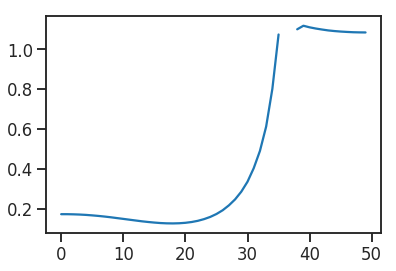

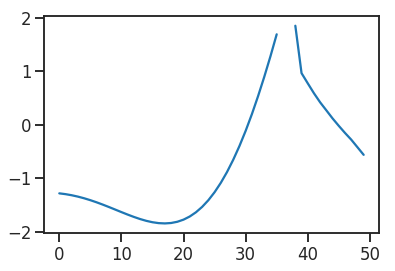

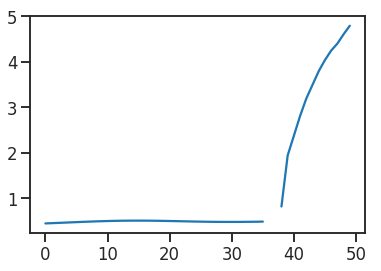

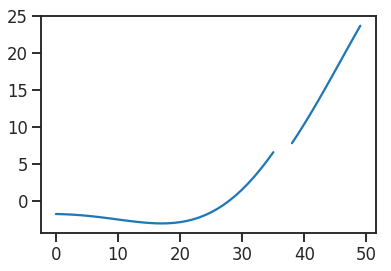

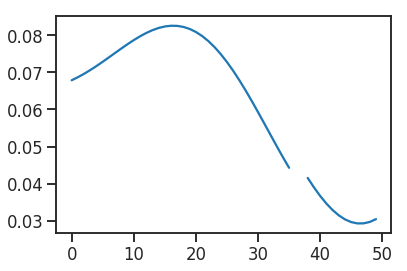

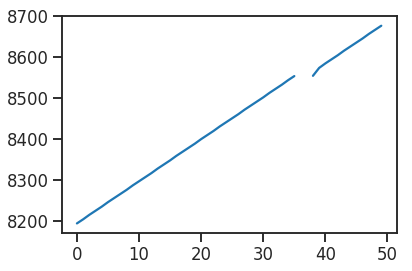

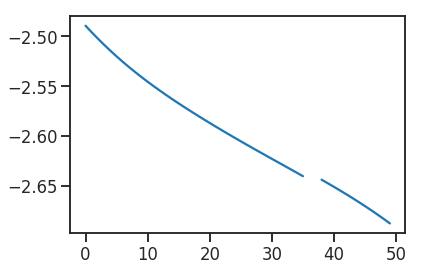

In [36]:
import numpy as np
for values in d.values():
    plt.figure()
    plt.plot([float(v)-float(values[0]) for v in values][800:850])

In [37]:
print(values[800:850])

[35.94725536763776, 35.94062708929692, 35.93424298527967, 35.928100335517684, 35.922193365113806, 35.916513632453885, 35.91105046290881, 35.905791411037114, 35.9007227341283, 35.89582986047773, 35.89109783691302, 35.8865117417405, 35.88205705136752, 35.87771995127957, 35.87348758469455, 35.869348234954536, 35.86529144042922, 35.861308043285085, 35.85739017582677, 35.853531190162514, 35.84972553862367, 35.845968613639734, 35.84225655662388, 35.83858604587709, 35.834954073604024, 35.831357721894584, 35.827793947001304, 35.82425938046839, 35.820750154673, 35.8172617591507, 35.813788932727256, 35.81032559500919, 35.80686481924771, 35.803398847042466, 35.79991914385642, 35.79641649292871, 'NaN', 'NaN', 35.79288112394958, 35.78930287183367, 35.78567136011152, 35.78197620285193, 35.77820721861577, 35.774354649706574, 35.77040937991006, 35.76636314399238, 35.76220872245521, 35.75794011543388, 35.753552690187426, 35.749043297380965]
